## Initialisation

In [1]:
!pip install keras

    100% |################################| 337kB 3.1MB/s ta 0:00:011
    100% |################################| 256kB 4.0MB/s eta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /root/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml
You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import keras
import h5py as h5
import numpy as np

PATH_DATA = '../half.h5'
PATH_PREDICT_WITHOUT_GT = '../pred_eighties_from_half_1_without_gt.h5'
PATH_SUBMIT = '../pred_eighties_from_half_1_INCREDIBLE.csv'
PATH_PREDICT_WITH_GT = '../pred_eighties_from_half_1.h5'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
ls -l

total 16988
-rw-rw-r-- 1 root root  118234 Mar 19 16:47 Hackathon_Florian.ipynb
-rw-rw-r-- 1 1008 1009   32204 Mar 19 16:17 Hackathon_Mostafa.ipynb
-rw-r--r-- 1 root root 5749488 Mar 20 07:52 Hackathon_Pineau.ipynb
-rw-r--r-- 1 root root   19266 Mar 20 07:53 Hackathon_perla.ipynb
-rw-r--r-- 1 root root 2626400 Mar 19 13:44 awesome_model.dqf
-rw-r--r-- 1 root root 1447968 Mar 19 14:39 awesome_model_2.dqf
drwxr-xr-x 2 root root    4096 Mar 19 15:19 data_s/
-rw-r--r-- 1 root root     800 Mar 19 14:57 eightieth.h5
-rw-r--r-- 1 root root  581400 Mar 19 14:39 incredible_florian.dqf
-rw-r--r-- 1 root root  581320 Mar 19 16:55 part_full_training.dqf
-rw-r--r-- 1 root root  970928 Mar 19 16:56 pred_eighties_from_full_AWESOME.h5
-rw-r--r-- 1 root root  970928 Mar 19 13:40 pred_eighties_from_half_1_AWESOMEGROUP.h5
-rw-r--r-- 1 root root 2113355 Mar 19 14:57 pred_eighties_from_half_1_INCREDIBLE_FLORIAN.csv
-rw-r--r-- 1 root root 2156205 Mar 19 13:47 result.csv


## CNN

In [5]:
BATCH_SIZE = 32
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, Activation, MaxPooling2D, ZeroPadding2D
import keras.layers.normalization 
from keras.callbacks import Callback
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count

In [7]:
def generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = f['S2'][batch_idxs, :,:,:]
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

In [8]:
idxs = get_idxs(PATH_DATA)
shuffled_idxs = shuffle_idx(idxs)
train_idxs, val_idxs = split_train_val(shuffled_idxs, 0.2)

Afin d'afficher clairement les images, on cherche à les traiter. Pour ce faire, on va tout d'abord chercher la balance des blancs. On suppose que sur la totalité des images, il y a au moins 1 pixel représentant du blanc. Ce pixel va servir de base à l'étalonnage de toutes les images.

Voici ici l'algorithme permettant de trouver cette balance:

In [246]:
[abs_max_r, abs_max_g, abs_max_b] = [0, 0, 0]

f = h5.File(PATH_DATA)
count = 0
n = len(idxs)
for idx in idxs:
    count += 1
    rgb16 = f['S2'][idx,:,:,:3]
    [max_r, max_g, max_b] = [0, 0, 0]
    for i in range(16):
        for j in range(16):
            [r,g,b] = rgb16[i][j][:]
            if (r*g*b > max_r*max_g*max_b) :
                max_r, max_g, max_b = r, g, b
    if (max_r*max_g*max_b > abs_max_r*abs_max_g*abs_max_b):
        abs_max_r, abs_max_g, abs_max_b = max_r, max_g, max_b
    print('[%d / %d] : %d' % (count, n, max_r*max_g*max_b))

[1 / 9349120] : 206842224
[2 / 9349120] : 204681600
[3 / 9349120] : 201178800
[4 / 9349120] : 249213312
[5 / 9349120] : 197611392
[6 / 9349120] : 209882992
[7 / 9349120] : 207347248
[8 / 9349120] : 207037056
[9 / 9349120] : 187682048
[10 / 9349120] : 191457504
[11 / 9349120] : 194184992
[12 / 9349120] : 198922192
[13 / 9349120] : 193034656
[14 / 9349120] : 192658848
[15 / 9349120] : 186952208
[16 / 9349120] : 196421536
[17 / 9349120] : 196468272
[18 / 9349120] : 185945568
[19 / 9349120] : 192444432
[20 / 9349120] : 235377344
[21 / 9349120] : 189439824
[22 / 9349120] : 182428272
[23 / 9349120] : 220250544
[24 / 9349120] : 177908400
[25 / 9349120] : 212660528
[26 / 9349120] : 193283008
[27 / 9349120] : 202656640
[28 / 9349120] : 201206208
[29 / 9349120] : 181372864
[30 / 9349120] : 189345760
[31 / 9349120] : 205111776
[32 / 9349120] : 204099920
[33 / 9349120] : 210799808
[34 / 9349120] : 187441088
[35 / 9349120] : 204495184
[36 / 9349120] : 208882800
[37 / 9349120] : 187306016
[38 / 9349

[459 / 9349120] : 207167184
[460 / 9349120] : 191347920
[461 / 9349120] : 209299744
[462 / 9349120] : 190376128
[463 / 9349120] : 186450176
[464 / 9349120] : 201558752
[465 / 9349120] : 205279264
[466 / 9349120] : 181143872
[467 / 9349120] : 188427600
[468 / 9349120] : 185455200
[469 / 9349120] : 182202368
[470 / 9349120] : 188296224
[471 / 9349120] : 212192192
[472 / 9349120] : 196198208
[473 / 9349120] : 213191232
[474 / 9349120] : 226030544
[475 / 9349120] : 193281728
[476 / 9349120] : 181571856
[477 / 9349120] : 196200048
[478 / 9349120] : 186981568
[479 / 9349120] : 202780928
[480 / 9349120] : 192407424
[481 / 9349120] : 181775008
[482 / 9349120] : 182694160
[483 / 9349120] : 187016224
[484 / 9349120] : 200950992
[485 / 9349120] : 199496512
[486 / 9349120] : 181756864
[487 / 9349120] : 196127264
[488 / 9349120] : 199040688
[489 / 9349120] : 190805520
[490 / 9349120] : 185440080
[491 / 9349120] : 182273152
[492 / 9349120] : 196952960
[493 / 9349120] : 195344096
[494 / 9349120] : 19

[764 / 9349120] : 201907536
[765 / 9349120] : 194493600
[766 / 9349120] : 201531152
[767 / 9349120] : 232668432
[768 / 9349120] : 219959120
[769 / 9349120] : 203272736
[770 / 9349120] : 186518592
[771 / 9349120] : 182292832
[772 / 9349120] : 198414000
[773 / 9349120] : 184710720
[774 / 9349120] : 174869632
[775 / 9349120] : 183777792
[776 / 9349120] : 184634528
[777 / 9349120] : 191953696
[778 / 9349120] : 190822320
[779 / 9349120] : 183592800
[780 / 9349120] : 187896800
[781 / 9349120] : 190337376
[782 / 9349120] : 178448784
[783 / 9349120] : 189827712
[784 / 9349120] : 189192640
[785 / 9349120] : 193369536
[786 / 9349120] : 205789760
[787 / 9349120] : 205757248
[788 / 9349120] : 209271456
[789 / 9349120] : 205563600
[790 / 9349120] : 190199872
[791 / 9349120] : 195011392
[792 / 9349120] : 190830816
[793 / 9349120] : 190478224
[794 / 9349120] : 208849872
[795 / 9349120] : 197820128
[796 / 9349120] : 179070176
[797 / 9349120] : 188638208
[798 / 9349120] : 181778080
[799 / 9349120] : 21

[1213 / 9349120] : 200998048
[1214 / 9349120] : 221118048
[1215 / 9349120] : 209723856
[1216 / 9349120] : 206669984
[1217 / 9349120] : 199198192
[1218 / 9349120] : 174713120
[1219 / 9349120] : 185772144
[1220 / 9349120] : 189424896
[1221 / 9349120] : 182095056
[1222 / 9349120] : 182502320
[1223 / 9349120] : 190458336
[1224 / 9349120] : 189516608
[1225 / 9349120] : 191849232
[1226 / 9349120] : 172626496
[1227 / 9349120] : 183895920
[1228 / 9349120] : 183128400
[1229 / 9349120] : 181792192
[1230 / 9349120] : 198830368
[1231 / 9349120] : 180835200
[1232 / 9349120] : 190761424
[1233 / 9349120] : 174363904
[1234 / 9349120] : 212160608
[1235 / 9349120] : 208378080
[1236 / 9349120] : 187613760
[1237 / 9349120] : 236469696
[1238 / 9349120] : 187303216
[1239 / 9349120] : 193616992
[1240 / 9349120] : 199928608
[1241 / 9349120] : 183842032
[1242 / 9349120] : 206159056
[1243 / 9349120] : 191418352
[1244 / 9349120] : 187702944
[1245 / 9349120] : 181148000
[1246 / 9349120] : 188468736
[1247 / 934912

[1661 / 9349120] : 218749440
[1662 / 9349120] : 236215008
[1663 / 9349120] : 217028320
[1664 / 9349120] : 203222256
[1665 / 9349120] : 177344992
[1666 / 9349120] : 180487440
[1667 / 9349120] : 183652608
[1668 / 9349120] : 189990160
[1669 / 9349120] : 186428336
[1670 / 9349120] : 194039312
[1671 / 9349120] : 191348128
[1672 / 9349120] : 193722704
[1673 / 9349120] : 173107200
[1674 / 9349120] : 225259008
[1675 / 9349120] : 201968096
[1676 / 9349120] : 184700816
[1677 / 9349120] : 185575680
[1678 / 9349120] : 179889152
[1679 / 9349120] : 202452896
[1680 / 9349120] : 216859104
[1681 / 9349120] : 171146608
[1682 / 9349120] : 184296336
[1683 / 9349120] : 205348224
[1684 / 9349120] : 176396928
[1685 / 9349120] : 174843504
[1686 / 9349120] : 187849392
[1687 / 9349120] : 196128768
[1688 / 9349120] : 195080512
[1689 / 9349120] : 177547408
[1690 / 9349120] : 188472240
[1691 / 9349120] : 200447072
[1692 / 9349120] : 189965152
[1693 / 9349120] : 214093824
[1694 / 9349120] : 192928784
[1695 / 934912

[2143 / 9349120] : 178345760
[2144 / 9349120] : 186145824
[2145 / 9349120] : 174932816
[2146 / 9349120] : 260219696
[2147 / 9349120] : 202166208
[2148 / 9349120] : 196810816
[2149 / 9349120] : 189629440
[2150 / 9349120] : 196846784
[2151 / 9349120] : 186600032
[2152 / 9349120] : 194608800
[2153 / 9349120] : 205302896
[2154 / 9349120] : 233849600
[2155 / 9349120] : 177457568
[2156 / 9349120] : 176933488
[2157 / 9349120] : 186038480
[2158 / 9349120] : 208328256
[2159 / 9349120] : 187433792
[2160 / 9349120] : 204828752
[2161 / 9349120] : 206898128
[2162 / 9349120] : 212535392
[2163 / 9349120] : 231014624
[2164 / 9349120] : 207363024
[2165 / 9349120] : 212466992
[2166 / 9349120] : 205143120
[2167 / 9349120] : 199720672
[2168 / 9349120] : 211663872
[2169 / 9349120] : 213624032
[2170 / 9349120] : 182494080
[2171 / 9349120] : 188692624
[2172 / 9349120] : 196857760
[2173 / 9349120] : 194770800
[2174 / 9349120] : 195480000
[2175 / 9349120] : 220762656
[2176 / 9349120] : 216458112
[2177 / 934912

[2665 / 9349120] : 191022720
[2666 / 9349120] : 189617904
[2667 / 9349120] : 193333712
[2668 / 9349120] : 183532448
[2669 / 9349120] : 188945456
[2670 / 9349120] : 200283984
[2671 / 9349120] : 223479728
[2672 / 9349120] : 203788800
[2673 / 9349120] : 193264464
[2674 / 9349120] : 195088704
[2675 / 9349120] : 194891744
[2676 / 9349120] : 207229200
[2677 / 9349120] : 220292784
[2678 / 9349120] : 189319952
[2679 / 9349120] : 194939680
[2680 / 9349120] : 210628032
[2681 / 9349120] : 209233088
[2682 / 9349120] : 222347888
[2683 / 9349120] : 195706416
[2684 / 9349120] : 179759152
[2685 / 9349120] : 192613504
[2686 / 9349120] : 204533040
[2687 / 9349120] : 208356480
[2688 / 9349120] : 199599184
[2689 / 9349120] : 186569152
[2690 / 9349120] : 183166016
[2691 / 9349120] : 189449328
[2692 / 9349120] : 178992656
[2693 / 9349120] : 194282288
[2694 / 9349120] : 204280704
[2695 / 9349120] : 181347536
[2696 / 9349120] : 182387392
[2697 / 9349120] : 183919600
[2698 / 9349120] : 176447040
[2699 / 934912

[2948 / 9349120] : 183890576
[2949 / 9349120] : 176888400
[2950 / 9349120] : 176908928
[2951 / 9349120] : 196652624
[2952 / 9349120] : 169079648
[2953 / 9349120] : 173360192
[2954 / 9349120] : 193863600
[2955 / 9349120] : 184881600
[2956 / 9349120] : 176597824
[2957 / 9349120] : 177651536
[2958 / 9349120] : 170179680
[2959 / 9349120] : 173372144
[2960 / 9349120] : 169368544
[2961 / 9349120] : 182476576
[2962 / 9349120] : 213999392
[2963 / 9349120] : 174284416
[2964 / 9349120] : 183124464
[2965 / 9349120] : 206406784
[2966 / 9349120] : 192119920
[2967 / 9349120] : 202744080
[2968 / 9349120] : 180791472
[2969 / 9349120] : 178463440
[2970 / 9349120] : 182371600
[2971 / 9349120] : 181402416
[2972 / 9349120] : 177047696
[2973 / 9349120] : 189955424
[2974 / 9349120] : 178270096
[2975 / 9349120] : 192628224
[2976 / 9349120] : 210921040
[2977 / 9349120] : 184533120
[2978 / 9349120] : 202069216
[2979 / 9349120] : 206741840
[2980 / 9349120] : 215197792
[2981 / 9349120] : 184368128
[2982 / 934912

[3432 / 9349120] : 202285376
[3433 / 9349120] : 188504576
[3434 / 9349120] : 201481648
[3435 / 9349120] : 179565696
[3436 / 9349120] : 192349696
[3437 / 9349120] : 212873472
[3438 / 9349120] : 198551456
[3439 / 9349120] : 196070400
[3440 / 9349120] : 214695456
[3441 / 9349120] : 202343392
[3442 / 9349120] : 187390352
[3443 / 9349120] : 206459520
[3444 / 9349120] : 177239792
[3445 / 9349120] : 191883936
[3446 / 9349120] : 176084832
[3447 / 9349120] : 186430560
[3448 / 9349120] : 187246080
[3449 / 9349120] : 194377392
[3450 / 9349120] : 192413312
[3451 / 9349120] : 193032160
[3452 / 9349120] : 182663904
[3453 / 9349120] : 176783168
[3454 / 9349120] : 185131440
[3455 / 9349120] : 192345888
[3456 / 9349120] : 218197312
[3457 / 9349120] : 178123600
[3458 / 9349120] : 182611968
[3459 / 9349120] : 201069328
[3460 / 9349120] : 182475504
[3461 / 9349120] : 174927488
[3462 / 9349120] : 197250576
[3463 / 9349120] : 178810512
[3464 / 9349120] : 176913488
[3465 / 9349120] : 169613728
[3466 / 934912

[3905 / 9349120] : 195498400
[3906 / 9349120] : 192801088
[3907 / 9349120] : 174689728
[3908 / 9349120] : 167745424
[3909 / 9349120] : 182932464
[3910 / 9349120] : 191997504
[3911 / 9349120] : 184907104
[3912 / 9349120] : 170694480
[3913 / 9349120] : 171656720
[3914 / 9349120] : 212900944
[3915 / 9349120] : 173039776
[3916 / 9349120] : 177085440
[3917 / 9349120] : 164719168
[3918 / 9349120] : 166483968
[3919 / 9349120] : 167321696
[3920 / 9349120] : 183127808
[3921 / 9349120] : 190223392
[3922 / 9349120] : 179642816
[3923 / 9349120] : 165975424
[3924 / 9349120] : 171867968
[3925 / 9349120] : 196514240
[3926 / 9349120] : 179258832
[3927 / 9349120] : 180643424
[3928 / 9349120] : 166706336
[3929 / 9349120] : 188597952
[3930 / 9349120] : 184411504
[3931 / 9349120] : 188390368
[3932 / 9349120] : 192330048
[3933 / 9349120] : 175164528
[3934 / 9349120] : 179996880
[3935 / 9349120] : 170795696
[3936 / 9349120] : 182331744
[3937 / 9349120] : 194983152
[3938 / 9349120] : 213912144
[3939 / 934912

[4296 / 9349120] : 198051744
[4297 / 9349120] : 196848880
[4298 / 9349120] : 202706720
[4299 / 9349120] : 192139680
[4300 / 9349120] : 196310128
[4301 / 9349120] : 202491008
[4302 / 9349120] : 227846464
[4303 / 9349120] : 196105552
[4304 / 9349120] : 206678288
[4305 / 9349120] : 201021264
[4306 / 9349120] : 200424928
[4307 / 9349120] : 207461760
[4308 / 9349120] : 204707248
[4309 / 9349120] : 192521168
[4310 / 9349120] : 191154096
[4311 / 9349120] : 217717504
[4312 / 9349120] : 195130208
[4313 / 9349120] : 202997760
[4314 / 9349120] : 228652176
[4315 / 9349120] : 195694880
[4316 / 9349120] : 205044176
[4317 / 9349120] : 195423616
[4318 / 9349120] : 202763376
[4319 / 9349120] : 215968976
[4320 / 9349120] : 212913248
[4321 / 9349120] : 204402128
[4322 / 9349120] : 193372624
[4323 / 9349120] : 216527072
[4324 / 9349120] : 205915248
[4325 / 9349120] : 202246112
[4326 / 9349120] : 210787488
[4327 / 9349120] : 216148992
[4328 / 9349120] : 206776000
[4329 / 9349120] : 201114160
[4330 / 934912

[4825 / 9349120] : 236340720
[4826 / 9349120] : 213410528
[4827 / 9349120] : 221048256
[4828 / 9349120] : 229734960
[4829 / 9349120] : 213619552
[4830 / 9349120] : 211609408
[4831 / 9349120] : 218059328
[4832 / 9349120] : 218265056
[4833 / 9349120] : 217558000
[4834 / 9349120] : 193406400
[4835 / 9349120] : 207171360
[4836 / 9349120] : 208164000
[4837 / 9349120] : 211968000
[4838 / 9349120] : 216691856
[4839 / 9349120] : 209382032
[4840 / 9349120] : 206014992
[4841 / 9349120] : 224252336
[4842 / 9349120] : 210897920
[4843 / 9349120] : 211623600
[4844 / 9349120] : 203466384
[4845 / 9349120] : 189737184
[4846 / 9349120] : 222837888
[4847 / 9349120] : 220791328
[4848 / 9349120] : 201190608
[4849 / 9349120] : 196651808
[4850 / 9349120] : 199880064
[4851 / 9349120] : 212727840
[4852 / 9349120] : 204236928
[4853 / 9349120] : 207184320
[4854 / 9349120] : 204536064
[4855 / 9349120] : 192527280
[4856 / 9349120] : 208409808
[4857 / 9349120] : 192729744
[4858 / 9349120] : 192747552
[4859 / 934912

[5226 / 9349120] : 211008320
[5227 / 9349120] : 193557776
[5228 / 9349120] : 186029840
[5229 / 9349120] : 190192256
[5230 / 9349120] : 195500880
[5231 / 9349120] : 210038992
[5232 / 9349120] : 204385280
[5233 / 9349120] : 208758960
[5234 / 9349120] : 198520576
[5235 / 9349120] : 201786896
[5236 / 9349120] : 194255920
[5237 / 9349120] : 193896896
[5238 / 9349120] : 197776160
[5239 / 9349120] : 207142112
[5240 / 9349120] : 247849888
[5241 / 9349120] : 199316160
[5242 / 9349120] : 217119696
[5243 / 9349120] : 208547552
[5244 / 9349120] : 219160256
[5245 / 9349120] : 214423424
[5246 / 9349120] : 234164192
[5247 / 9349120] : 201148928
[5248 / 9349120] : 216546336
[5249 / 9349120] : 217969920
[5250 / 9349120] : 203466384
[5251 / 9349120] : 204768016
[5252 / 9349120] : 194715376
[5253 / 9349120] : 215394048
[5254 / 9349120] : 192989440
[5255 / 9349120] : 203281152
[5256 / 9349120] : 216221536
[5257 / 9349120] : 187073424
[5258 / 9349120] : 196044160
[5259 / 9349120] : 227242400
[5260 / 934912

[5590 / 9349120] : 218034112
[5591 / 9349120] : 199267200
[5592 / 9349120] : 239179248
[5593 / 9349120] : 203707360
[5594 / 9349120] : 215537296
[5595 / 9349120] : 205276000
[5596 / 9349120] : 231632000
[5597 / 9349120] : 216537600
[5598 / 9349120] : 220471776
[5599 / 9349120] : 212552064
[5600 / 9349120] : 198077168
[5601 / 9349120] : 200978688
[5602 / 9349120] : 238999264
[5603 / 9349120] : 230787648
[5604 / 9349120] : 198963936
[5605 / 9349120] : 222399264
[5606 / 9349120] : 223095520
[5607 / 9349120] : 210909120
[5608 / 9349120] : 219232448
[5609 / 9349120] : 222596848
[5610 / 9349120] : 242286464
[5611 / 9349120] : 209708736
[5612 / 9349120] : 213117296
[5613 / 9349120] : 198614016
[5614 / 9349120] : 217010624
[5615 / 9349120] : 213536288
[5616 / 9349120] : 214765456
[5617 / 9349120] : 198132480
[5618 / 9349120] : 242436448
[5619 / 9349120] : 194343968
[5620 / 9349120] : 198202496
[5621 / 9349120] : 196118880
[5622 / 9349120] : 208433712
[5623 / 9349120] : 244617776
[5624 / 934912

[6077 / 9349120] : 193173408
[6078 / 9349120] : 205314256
[6079 / 9349120] : 199570144
[6080 / 9349120] : 224316000
[6081 / 9349120] : 211509520
[6082 / 9349120] : 202542368
[6083 / 9349120] : 204194032
[6084 / 9349120] : 225578848
[6085 / 9349120] : 224399616
[6086 / 9349120] : 223091200
[6087 / 9349120] : 185754864
[6088 / 9349120] : 186303008
[6089 / 9349120] : 212787840
[6090 / 9349120] : 216506624
[6091 / 9349120] : 208424736
[6092 / 9349120] : 198450240
[6093 / 9349120] : 190538704
[6094 / 9349120] : 199602896
[6095 / 9349120] : 192564320
[6096 / 9349120] : 198697968
[6097 / 9349120] : 200718064
[6098 / 9349120] : 193766528
[6099 / 9349120] : 195560928
[6100 / 9349120] : 205405200
[6101 / 9349120] : 215763584
[6102 / 9349120] : 207079488
[6103 / 9349120] : 231908608
[6104 / 9349120] : 260514192
[6105 / 9349120] : 198912960
[6106 / 9349120] : 214438000
[6107 / 9349120] : 207849984
[6108 / 9349120] : 199060800
[6109 / 9349120] : 202744080
[6110 / 9349120] : 214028048
[6111 / 934912

[6474 / 9349120] : 225160112
[6475 / 9349120] : 200129440
[6476 / 9349120] : 190776608
[6477 / 9349120] : 208766400
[6478 / 9349120] : 206349472
[6479 / 9349120] : 189343552
[6480 / 9349120] : 227241280
[6481 / 9349120] : 198407664
[6482 / 9349120] : 211936640
[6483 / 9349120] : 213415024
[6484 / 9349120] : 209126544
[6485 / 9349120] : 201435168
[6486 / 9349120] : 232566784
[6487 / 9349120] : 229287056
[6488 / 9349120] : 252331376
[6489 / 9349120] : 218715328
[6490 / 9349120] : 207942848
[6491 / 9349120] : 197540928
[6492 / 9349120] : 221713072
[6493 / 9349120] : 205418752
[6494 / 9349120] : 218896528
[6495 / 9349120] : 191343440
[6496 / 9349120] : 239482240
[6497 / 9349120] : 207988816
[6498 / 9349120] : 191992496
[6499 / 9349120] : 211403136
[6500 / 9349120] : 206649824
[6501 / 9349120] : 198733120
[6502 / 9349120] : 213960960
[6503 / 9349120] : 220913152
[6504 / 9349120] : 193442720
[6505 / 9349120] : 202100032
[6506 / 9349120] : 210452928
[6507 / 9349120] : 194494624
[6508 / 934912

[6890 / 9349120] : 201898208
[6891 / 9349120] : 210863520
[6892 / 9349120] : 206924144
[6893 / 9349120] : 198303360
[6894 / 9349120] : 228696320
[6895 / 9349120] : 192864672
[6896 / 9349120] : 200495568
[6897 / 9349120] : 224603600
[6898 / 9349120] : 202812896
[6899 / 9349120] : 193387328
[6900 / 9349120] : 208801824
[6901 / 9349120] : 189321296
[6902 / 9349120] : 210597888
[6903 / 9349120] : 197328848
[6904 / 9349120] : 237614480
[6905 / 9349120] : 218803376
[6906 / 9349120] : 226269856
[6907 / 9349120] : 226212336
[6908 / 9349120] : 227888128
[6909 / 9349120] : 256655360
[6910 / 9349120] : 199705968
[6911 / 9349120] : 206076048
[6912 / 9349120] : 202678944
[6913 / 9349120] : 189952480
[6914 / 9349120] : 195711104
[6915 / 9349120] : 196621728
[6916 / 9349120] : 214894848
[6917 / 9349120] : 199408784
[6918 / 9349120] : 195441344
[6919 / 9349120] : 194716176
[6920 / 9349120] : 181798336
[6921 / 9349120] : 185609280
[6922 / 9349120] : 208697072
[6923 / 9349120] : 225810208
[6924 / 934912

[7368 / 9349120] : 188899200
[7369 / 9349120] : 205360144
[7370 / 9349120] : 187217728
[7371 / 9349120] : 183899696
[7372 / 9349120] : 209534976
[7373 / 9349120] : 199354848
[7374 / 9349120] : 194610944
[7375 / 9349120] : 202176480
[7376 / 9349120] : 195674784
[7377 / 9349120] : 183401856
[7378 / 9349120] : 189593552
[7379 / 9349120] : 198514016
[7380 / 9349120] : 205837632
[7381 / 9349120] : 197416304
[7382 / 9349120] : 185262880
[7383 / 9349120] : 187485472
[7384 / 9349120] : 212265392
[7385 / 9349120] : 200986016
[7386 / 9349120] : 189318864
[7387 / 9349120] : 202536000
[7388 / 9349120] : 212731216
[7389 / 9349120] : 199467008
[7390 / 9349120] : 196316208
[7391 / 9349120] : 204072960
[7392 / 9349120] : 247223760
[7393 / 9349120] : 205764368
[7394 / 9349120] : 189531664
[7395 / 9349120] : 207887904
[7396 / 9349120] : 217496224
[7397 / 9349120] : 201488928
[7398 / 9349120] : 206352624
[7399 / 9349120] : 207274688
[7400 / 9349120] : 219455280
[7401 / 9349120] : 203464800
[7402 / 934912

[7869 / 9349120] : 209627520
[7870 / 9349120] : 184581504
[7871 / 9349120] : 194578368
[7872 / 9349120] : 212469056
[7873 / 9349120] : 183264128
[7874 / 9349120] : 191445408
[7875 / 9349120] : 206844976
[7876 / 9349120] : 195324496
[7877 / 9349120] : 202820256
[7878 / 9349120] : 200132864
[7879 / 9349120] : 191586384
[7880 / 9349120] : 197544480
[7881 / 9349120] : 188641088
[7882 / 9349120] : 212794688
[7883 / 9349120] : 187025744
[7884 / 9349120] : 188336496
[7885 / 9349120] : 199999808
[7886 / 9349120] : 193748000
[7887 / 9349120] : 218175552
[7888 / 9349120] : 203518768
[7889 / 9349120] : 198648240
[7890 / 9349120] : 205334976
[7891 / 9349120] : 207778720
[7892 / 9349120] : 196509856
[7893 / 9349120] : 186249488
[7894 / 9349120] : 196959008
[7895 / 9349120] : 190393808
[7896 / 9349120] : 217941536
[7897 / 9349120] : 202520144
[7898 / 9349120] : 194006208
[7899 / 9349120] : 213479936
[7900 / 9349120] : 189212672
[7901 / 9349120] : 203424544
[7902 / 9349120] : 188473664
[7903 / 934912

[8360 / 9349120] : 195546656
[8361 / 9349120] : 222550416
[8362 / 9349120] : 208540048
[8363 / 9349120] : 245557056
[8364 / 9349120] : 201264464
[8365 / 9349120] : 244530000
[8366 / 9349120] : 190165248
[8367 / 9349120] : 195173936
[8368 / 9349120] : 202204704
[8369 / 9349120] : 215661024
[8370 / 9349120] : 209213552
[8371 / 9349120] : 199233344
[8372 / 9349120] : 195808384
[8373 / 9349120] : 207843760
[8374 / 9349120] : 201798000
[8375 / 9349120] : 190766160
[8376 / 9349120] : 213675680
[8377 / 9349120] : 195398784
[8378 / 9349120] : 197302944
[8379 / 9349120] : 212575104
[8380 / 9349120] : 213483600
[8381 / 9349120] : 205535168
[8382 / 9349120] : 212190000
[8383 / 9349120] : 197656528
[8384 / 9349120] : 218137824
[8385 / 9349120] : 212497152
[8386 / 9349120] : 209457728
[8387 / 9349120] : 213634800
[8388 / 9349120] : 213129840
[8389 / 9349120] : 210464640
[8390 / 9349120] : 195687664
[8391 / 9349120] : 185058000
[8392 / 9349120] : 229334992
[8393 / 9349120] : 196492160
[8394 / 934912

[8892 / 9349120] : 251688400
[8893 / 9349120] : 193784336
[8894 / 9349120] : 207108000
[8895 / 9349120] : 193651904
[8896 / 9349120] : 247812000
[8897 / 9349120] : 220448592
[8898 / 9349120] : 199297280
[8899 / 9349120] : 191494800
[8900 / 9349120] : 226362272
[8901 / 9349120] : 198421824
[8902 / 9349120] : 179816400
[8903 / 9349120] : 193140912
[8904 / 9349120] : 204156240
[8905 / 9349120] : 191032384
[8906 / 9349120] : 204635600
[8907 / 9349120] : 216505920
[8908 / 9349120] : 210906080
[8909 / 9349120] : 196239120
[8910 / 9349120] : 214283872
[8911 / 9349120] : 200700000
[8912 / 9349120] : 223789056
[8913 / 9349120] : 223766496
[8914 / 9349120] : 210249216
[8915 / 9349120] : 192898480
[8916 / 9349120] : 206828928
[8917 / 9349120] : 232591712
[8918 / 9349120] : 193522560
[8919 / 9349120] : 220540320
[8920 / 9349120] : 212764864
[8921 / 9349120] : 217408640
[8922 / 9349120] : 237511552
[8923 / 9349120] : 212156480
[8924 / 9349120] : 235582736
[8925 / 9349120] : 243767040
[8926 / 934912

[9272 / 9349120] : 205709120
[9273 / 9349120] : 206723280
[9274 / 9349120] : 200392192
[9275 / 9349120] : 202836480
[9276 / 9349120] : 203435072
[9277 / 9349120] : 194546880
[9278 / 9349120] : 197831392
[9279 / 9349120] : 211094736
[9280 / 9349120] : 218382240
[9281 / 9349120] : 211554880
[9282 / 9349120] : 211864272
[9283 / 9349120] : 197136000
[9284 / 9349120] : 205598848
[9285 / 9349120] : 211413968
[9286 / 9349120] : 214444352
[9287 / 9349120] : 209692880
[9288 / 9349120] : 199149472
[9289 / 9349120] : 215128192
[9290 / 9349120] : 204331168
[9291 / 9349120] : 205381312
[9292 / 9349120] : 189828384
[9293 / 9349120] : 196222096
[9294 / 9349120] : 211918320
[9295 / 9349120] : 236544880
[9296 / 9349120] : 211962624
[9297 / 9349120] : 193130368
[9298 / 9349120] : 202956144
[9299 / 9349120] : 203427280
[9300 / 9349120] : 206058064
[9301 / 9349120] : 192862736
[9302 / 9349120] : 206468368
[9303 / 9349120] : 217578880
[9304 / 9349120] : 211712416
[9305 / 9349120] : 196938656
[9306 / 934912

[9688 / 9349120] : 248182384
[9689 / 9349120] : 232632400
[9690 / 9349120] : 211738528
[9691 / 9349120] : 201752768
[9692 / 9349120] : 199451136
[9693 / 9349120] : 211354656
[9694 / 9349120] : 216271984
[9695 / 9349120] : 224865568
[9696 / 9349120] : 197707920
[9697 / 9349120] : 198350208
[9698 / 9349120] : 213782240
[9699 / 9349120] : 197322576
[9700 / 9349120] : 202959696
[9701 / 9349120] : 225936672
[9702 / 9349120] : 212711520
[9703 / 9349120] : 212160368
[9704 / 9349120] : 203490144
[9705 / 9349120] : 197753040
[9706 / 9349120] : 203111920
[9707 / 9349120] : 191912992
[9708 / 9349120] : 196985792
[9709 / 9349120] : 196652576
[9710 / 9349120] : 188541280
[9711 / 9349120] : 187042464
[9712 / 9349120] : 194622320
[9713 / 9349120] : 191826816
[9714 / 9349120] : 214149408
[9715 / 9349120] : 213451376
[9716 / 9349120] : 210293408
[9717 / 9349120] : 213630704
[9718 / 9349120] : 202988352
[9719 / 9349120] : 186512144
[9720 / 9349120] : 214693920
[9721 / 9349120] : 197525808
[9722 / 934912

[10126 / 9349120] : 206061328
[10127 / 9349120] : 228573536
[10128 / 9349120] : 241268064
[10129 / 9349120] : 201483360
[10130 / 9349120] : 184185488
[10131 / 9349120] : 202047552
[10132 / 9349120] : 240325168
[10133 / 9349120] : 203950512
[10134 / 9349120] : 193496400
[10135 / 9349120] : 180166656
[10136 / 9349120] : 204236928
[10137 / 9349120] : 211673568
[10138 / 9349120] : 211471760
[10139 / 9349120] : 202300288
[10140 / 9349120] : 199257792
[10141 / 9349120] : 213240160
[10142 / 9349120] : 204097408
[10143 / 9349120] : 218042144
[10144 / 9349120] : 219600000
[10145 / 9349120] : 238647920
[10146 / 9349120] : 196826640
[10147 / 9349120] : 208125456
[10148 / 9349120] : 236546768
[10149 / 9349120] : 202771808
[10150 / 9349120] : 234408112
[10151 / 9349120] : 221192864
[10152 / 9349120] : 210355200
[10153 / 9349120] : 204603152
[10154 / 9349120] : 208966720
[10155 / 9349120] : 217441792
[10156 / 9349120] : 206522336
[10157 / 9349120] : 189132336
[10158 / 9349120] : 194776768
[10159 / 9

[10544 / 9349120] : 206468944
[10545 / 9349120] : 186349248
[10546 / 9349120] : 194703776
[10547 / 9349120] : 190631776
[10548 / 9349120] : 235978272
[10549 / 9349120] : 195195888
[10550 / 9349120] : 195712448
[10551 / 9349120] : 204027488
[10552 / 9349120] : 203382192
[10553 / 9349120] : 187165664
[10554 / 9349120] : 230591792
[10555 / 9349120] : 215472288
[10556 / 9349120] : 182178368
[10557 / 9349120] : 187956304
[10558 / 9349120] : 194066784
[10559 / 9349120] : 226751616
[10560 / 9349120] : 208876144
[10561 / 9349120] : 199326400
[10562 / 9349120] : 225765344
[10563 / 9349120] : 209503440
[10564 / 9349120] : 203177360
[10565 / 9349120] : 209598752
[10566 / 9349120] : 196572864
[10567 / 9349120] : 196765328
[10568 / 9349120] : 220812816
[10569 / 9349120] : 212719872
[10570 / 9349120] : 217574704
[10571 / 9349120] : 233048304
[10572 / 9349120] : 260472240
[10573 / 9349120] : 203381632
[10574 / 9349120] : 198858880
[10575 / 9349120] : 187147840
[10576 / 9349120] : 198076032
[10577 / 9

[10818 / 9349120] : 224516608
[10819 / 9349120] : 186842416
[10820 / 9349120] : 203121488
[10821 / 9349120] : 190966176
[10822 / 9349120] : 198869728
[10823 / 9349120] : 232713536
[10824 / 9349120] : 227307808
[10825 / 9349120] : 207062752
[10826 / 9349120] : 230383792
[10827 / 9349120] : 193944240
[10828 / 9349120] : 215047760
[10829 / 9349120] : 201304080
[10830 / 9349120] : 218823536
[10831 / 9349120] : 179836608
[10832 / 9349120] : 198700128
[10833 / 9349120] : 212433648
[10834 / 9349120] : 215096064
[10835 / 9349120] : 200374608
[10836 / 9349120] : 205735920
[10837 / 9349120] : 221705440
[10838 / 9349120] : 225860032
[10839 / 9349120] : 213769536
[10840 / 9349120] : 191675376
[10841 / 9349120] : 208780192
[10842 / 9349120] : 207991216
[10843 / 9349120] : 197854976
[10844 / 9349120] : 211999872
[10845 / 9349120] : 208844928
[10846 / 9349120] : 196534272
[10847 / 9349120] : 228334928
[10848 / 9349120] : 210089888
[10849 / 9349120] : 198160512
[10850 / 9349120] : 216590880
[10851 / 9

[11100 / 9349120] : 195246576
[11101 / 9349120] : 221416160
[11102 / 9349120] : 236879552
[11103 / 9349120] : 198324960
[11104 / 9349120] : 202544640
[11105 / 9349120] : 214768192
[11106 / 9349120] : 203981168
[11107 / 9349120] : 222824848
[11108 / 9349120] : 245688688
[11109 / 9349120] : 206665344
[11110 / 9349120] : 196519008
[11111 / 9349120] : 188613216
[11112 / 9349120] : 215513760
[11113 / 9349120] : 201414368
[11114 / 9349120] : 212939104
[11115 / 9349120] : 210006816
[11116 / 9349120] : 190719200
[11117 / 9349120] : 196239680
[11118 / 9349120] : 199090944
[11119 / 9349120] : 204553968
[11120 / 9349120] : 192435296
[11121 / 9349120] : 199169888
[11122 / 9349120] : 193446768
[11123 / 9349120] : 202325760
[11124 / 9349120] : 202351536
[11125 / 9349120] : 211690016
[11126 / 9349120] : 249066208
[11127 / 9349120] : 211067216
[11128 / 9349120] : 200540336
[11129 / 9349120] : 209315392
[11130 / 9349120] : 202427888
[11131 / 9349120] : 198633760
[11132 / 9349120] : 193200320
[11133 / 9

[11535 / 9349120] : 209345600
[11536 / 9349120] : 211959856
[11537 / 9349120] : 191900352
[11538 / 9349120] : 199438592
[11539 / 9349120] : 193506304
[11540 / 9349120] : 239265760
[11541 / 9349120] : 207359648
[11542 / 9349120] : 204881040
[11543 / 9349120] : 197153216
[11544 / 9349120] : 199540496
[11545 / 9349120] : 240552320
[11546 / 9349120] : 184158448
[11547 / 9349120] : 215672688
[11548 / 9349120] : 198678064
[11549 / 9349120] : 190337280
[11550 / 9349120] : 199367248
[11551 / 9349120] : 184631968
[11552 / 9349120] : 225972240
[11553 / 9349120] : 201599744
[11554 / 9349120] : 206947504
[11555 / 9349120] : 213298192
[11556 / 9349120] : 190928208
[11557 / 9349120] : 187492480
[11558 / 9349120] : 203681952
[11559 / 9349120] : 244879072
[11560 / 9349120] : 205528016
[11561 / 9349120] : 198006880
[11562 / 9349120] : 215689632
[11563 / 9349120] : 189955552
[11564 / 9349120] : 187393632
[11565 / 9349120] : 216826464
[11566 / 9349120] : 201123776
[11567 / 9349120] : 202804016
[11568 / 9

[12082 / 9349120] : 189339728
[12083 / 9349120] : 208495248
[12084 / 9349120] : 202983296
[12085 / 9349120] : 191630848
[12086 / 9349120] : 182587664
[12087 / 9349120] : 208504800
[12088 / 9349120] : 180975312
[12089 / 9349120] : 222627600
[12090 / 9349120] : 192580960
[12091 / 9349120] : 197838912
[12092 / 9349120] : 186722896
[12093 / 9349120] : 253559248
[12094 / 9349120] : 182074880
[12095 / 9349120] : 189675328
[12096 / 9349120] : 255037584
[12097 / 9349120] : 205684128
[12098 / 9349120] : 203487440
[12099 / 9349120] : 227290784
[12100 / 9349120] : 226739008
[12101 / 9349120] : 225232560
[12102 / 9349120] : 217690400
[12103 / 9349120] : 199701872
[12104 / 9349120] : 227944640
[12105 / 9349120] : 208315616
[12106 / 9349120] : 220421920
[12107 / 9349120] : 310816064
[12108 / 9349120] : 230136992
[12109 / 9349120] : 200970736
[12110 / 9349120] : 213663904
[12111 / 9349120] : 197012656
[12112 / 9349120] : 201052688
[12113 / 9349120] : 250253552
[12114 / 9349120] : 222007776
[12115 / 9

[12511 / 9349120] : 222434432
[12512 / 9349120] : 256533008
[12513 / 9349120] : 222312352
[12514 / 9349120] : 215842656
[12515 / 9349120] : 208642704
[12516 / 9349120] : 218281504
[12517 / 9349120] : 255936112
[12518 / 9349120] : 231204512
[12519 / 9349120] : 236460896
[12520 / 9349120] : 229207440
[12521 / 9349120] : 204825600
[12522 / 9349120] : 215430048
[12523 / 9349120] : 223225472
[12524 / 9349120] : 207715888
[12525 / 9349120] : 226812800
[12526 / 9349120] : 202024176
[12527 / 9349120] : 246304368
[12528 / 9349120] : 236257280
[12529 / 9349120] : 215402880
[12530 / 9349120] : 197293632
[12531 / 9349120] : 225593808
[12532 / 9349120] : 224094400
[12533 / 9349120] : 203964368
[12534 / 9349120] : 213799232
[12535 / 9349120] : 213527104
[12536 / 9349120] : 243631072
[12537 / 9349120] : 237141536
[12538 / 9349120] : 242129840
[12539 / 9349120] : 243417600
[12540 / 9349120] : 249314896
[12541 / 9349120] : 238597952
[12542 / 9349120] : 207316032
[12543 / 9349120] : 221838336
[12544 / 9

[12829 / 9349120] : 279679840
[12830 / 9349120] : 215277408
[12831 / 9349120] : 247294800
[12832 / 9349120] : 271693376
[12833 / 9349120] : 238277984
[12834 / 9349120] : 234873312
[12835 / 9349120] : 286978944
[12836 / 9349120] : 253022432
[12837 / 9349120] : 204333712
[12838 / 9349120] : 280240032
[12839 / 9349120] : 210038016
[12840 / 9349120] : 239913520
[12841 / 9349120] : 237247920
[12842 / 9349120] : 235036544
[12843 / 9349120] : 228117216
[12844 / 9349120] : 203663248
[12845 / 9349120] : 234897536
[12846 / 9349120] : 190164352
[12847 / 9349120] : 232470496
[12848 / 9349120] : 213398240
[12849 / 9349120] : 208107648
[12850 / 9349120] : 216200448
[12851 / 9349120] : 228633600
[12852 / 9349120] : 220975648
[12853 / 9349120] : 260880224
[12854 / 9349120] : 223274016
[12855 / 9349120] : 221490576
[12856 / 9349120] : 208631696
[12857 / 9349120] : 215502336
[12858 / 9349120] : 216951376
[12859 / 9349120] : 212357344
[12860 / 9349120] : 219070800
[12861 / 9349120] : 238920400
[12862 / 9

[13291 / 9349120] : 216705600
[13292 / 9349120] : 233694720
[13293 / 9349120] : 225661952
[13294 / 9349120] : 212146944
[13295 / 9349120] : 188591136
[13296 / 9349120] : 199096016
[13297 / 9349120] : 240647216
[13298 / 9349120] : 230393968
[13299 / 9349120] : 222632064
[13300 / 9349120] : 207402048
[13301 / 9349120] : 209994640
[13302 / 9349120] : 236629792
[13303 / 9349120] : 234962912
[13304 / 9349120] : 219898800
[13305 / 9349120] : 229894496
[13306 / 9349120] : 203199488
[13307 / 9349120] : 213544800
[13308 / 9349120] : 209902080
[13309 / 9349120] : 217786256
[13310 / 9349120] : 193264352
[13311 / 9349120] : 211337152
[13312 / 9349120] : 212665440
[13313 / 9349120] : 212751872
[13314 / 9349120] : 207157504
[13315 / 9349120] : 201599840
[13316 / 9349120] : 202839296
[13317 / 9349120] : 193224448
[13318 / 9349120] : 192968304
[13319 / 9349120] : 224284704
[13320 / 9349120] : 212350464
[13321 / 9349120] : 247101440
[13322 / 9349120] : 275992576
[13323 / 9349120] : 225323648
[13324 / 9

[13619 / 9349120] : 240144304
[13620 / 9349120] : 200656560
[13621 / 9349120] : 221585616
[13622 / 9349120] : 221308992
[13623 / 9349120] : 202087808
[13624 / 9349120] : 217845024
[13625 / 9349120] : 210028896
[13626 / 9349120] : 221478512
[13627 / 9349120] : 205350560
[13628 / 9349120] : 229461088
[13629 / 9349120] : 242392800
[13630 / 9349120] : 236714304
[13631 / 9349120] : 214729840
[13632 / 9349120] : 207010944
[13633 / 9349120] : 210782144
[13634 / 9349120] : 199433120
[13635 / 9349120] : 210930560
[13636 / 9349120] : 188088320
[13637 / 9349120] : 211595904
[13638 / 9349120] : 218513808
[13639 / 9349120] : 190576688
[13640 / 9349120] : 219790144
[13641 / 9349120] : 246491504
[13642 / 9349120] : 227470208
[13643 / 9349120] : 202017280
[13644 / 9349120] : 223324560
[13645 / 9349120] : 193060976
[13646 / 9349120] : 197758544
[13647 / 9349120] : 202855744
[13648 / 9349120] : 202688176
[13649 / 9349120] : 208441280
[13650 / 9349120] : 245814160
[13651 / 9349120] : 267070048
[13652 / 9

[14186 / 9349120] : 202743536
[14187 / 9349120] : 201951024
[14188 / 9349120] : 212899504
[14189 / 9349120] : 204580576
[14190 / 9349120] : 194568192
[14191 / 9349120] : 204047168
[14192 / 9349120] : 206651328
[14193 / 9349120] : 238448032
[14194 / 9349120] : 222217024
[14195 / 9349120] : 221087040
[14196 / 9349120] : 204453392
[14197 / 9349120] : 266564000
[14198 / 9349120] : 218693104
[14199 / 9349120] : 197322656
[14200 / 9349120] : 184534176
[14201 / 9349120] : 200583360
[14202 / 9349120] : 215932416
[14203 / 9349120] : 192996272
[14204 / 9349120] : 211315232
[14205 / 9349120] : 205510928
[14206 / 9349120] : 199606832
[14207 / 9349120] : 208161408
[14208 / 9349120] : 202734848
[14209 / 9349120] : 207116576
[14210 / 9349120] : 236411088
[14211 / 9349120] : 239075552
[14212 / 9349120] : 189358576
[14213 / 9349120] : 195349136
[14214 / 9349120] : 185769360
[14215 / 9349120] : 203762784
[14216 / 9349120] : 213802096
[14217 / 9349120] : 206516768
[14218 / 9349120] : 195646368
[14219 / 9

[14662 / 9349120] : 217489104
[14663 / 9349120] : 209475808
[14664 / 9349120] : 189889152
[14665 / 9349120] : 212227584
[14666 / 9349120] : 215616704
[14667 / 9349120] : 206637600
[14668 / 9349120] : 209391744
[14669 / 9349120] : 214701504
[14670 / 9349120] : 195821440
[14671 / 9349120] : 233923872
[14672 / 9349120] : 202678944
[14673 / 9349120] : 219010112
[14674 / 9349120] : 205459200
[14675 / 9349120] : 196553184
[14676 / 9349120] : 206972336
[14677 / 9349120] : 200318176
[14678 / 9349120] : 223563552
[14679 / 9349120] : 202014080
[14680 / 9349120] : 209431552
[14681 / 9349120] : 220659680
[14682 / 9349120] : 198178336
[14683 / 9349120] : 216005376
[14684 / 9349120] : 213471440
[14685 / 9349120] : 228463648
[14686 / 9349120] : 224745392
[14687 / 9349120] : 253580144
[14688 / 9349120] : 202535424
[14689 / 9349120] : 216757712
[14690 / 9349120] : 222754224
[14691 / 9349120] : 207528256
[14692 / 9349120] : 236086208
[14693 / 9349120] : 180682480
[14694 / 9349120] : 183257536
[14695 / 9

[14956 / 9349120] : 229192800
[14957 / 9349120] : 202425792
[14958 / 9349120] : 241084144
[14959 / 9349120] : 181648176
[14960 / 9349120] : 244490688
[14961 / 9349120] : 216138128
[14962 / 9349120] : 227918400
[14963 / 9349120] : 190822560
[14964 / 9349120] : 212284512
[14965 / 9349120] : 200361088
[14966 / 9349120] : 192295312
[14967 / 9349120] : 204808496
[14968 / 9349120] : 198166688
[14969 / 9349120] : 191241696
[14970 / 9349120] : 203252544
[14971 / 9349120] : 228280848
[14972 / 9349120] : 178842304
[14973 / 9349120] : 207063840
[14974 / 9349120] : 189628304
[14975 / 9349120] : 188538496
[14976 / 9349120] : 187121744
[14977 / 9349120] : 206215232
[14978 / 9349120] : 198294400
[14979 / 9349120] : 230349888
[14980 / 9349120] : 201477984
[14981 / 9349120] : 235735280
[14982 / 9349120] : 214296752
[14983 / 9349120] : 186106816
[14984 / 9349120] : 215640496
[14985 / 9349120] : 217453824
[14986 / 9349120] : 191242240
[14987 / 9349120] : 177863712
[14988 / 9349120] : 208490064
[14989 / 9

[15541 / 9349120] : 206761888
[15542 / 9349120] : 205048080
[15543 / 9349120] : 205590880
[15544 / 9349120] : 192599968
[15545 / 9349120] : 207926992
[15546 / 9349120] : 217749600
[15547 / 9349120] : 192159136
[15548 / 9349120] : 200412736
[15549 / 9349120] : 209208096
[15550 / 9349120] : 231713200
[15551 / 9349120] : 192370176
[15552 / 9349120] : 195716736
[15553 / 9349120] : 196214656
[15554 / 9349120] : 196460960
[15555 / 9349120] : 179044752
[15556 / 9349120] : 186564224
[15557 / 9349120] : 191238576
[15558 / 9349120] : 205944816
[15559 / 9349120] : 209914320
[15560 / 9349120] : 226048320
[15561 / 9349120] : 218462080
[15562 / 9349120] : 201063328
[15563 / 9349120] : 197762656
[15564 / 9349120] : 198450000
[15565 / 9349120] : 193950720
[15566 / 9349120] : 202830624
[15567 / 9349120] : 184644000
[15568 / 9349120] : 222115536
[15569 / 9349120] : 204376880
[15570 / 9349120] : 196610336
[15571 / 9349120] : 213213312
[15572 / 9349120] : 215886064
[15573 / 9349120] : 212094064
[15574 / 9

[15825 / 9349120] : 194786272
[15826 / 9349120] : 182371408
[15827 / 9349120] : 184001616
[15828 / 9349120] : 213927440
[15829 / 9349120] : 186031808
[15830 / 9349120] : 202218160
[15831 / 9349120] : 214238080
[15832 / 9349120] : 202842000
[15833 / 9349120] : 192880800
[15834 / 9349120] : 201377072
[15835 / 9349120] : 214151168
[15836 / 9349120] : 209818816
[15837 / 9349120] : 201014784
[15838 / 9349120] : 193602640
[15839 / 9349120] : 191142000
[15840 / 9349120] : 224478912
[15841 / 9349120] : 200749104
[15842 / 9349120] : 200313040
[15843 / 9349120] : 215834032
[15844 / 9349120] : 190023600
[15845 / 9349120] : 197930624
[15846 / 9349120] : 197100128
[15847 / 9349120] : 210536784
[15848 / 9349120] : 197872096
[15849 / 9349120] : 229834080
[15850 / 9349120] : 191842560
[15851 / 9349120] : 226092240
[15852 / 9349120] : 204987504
[15853 / 9349120] : 202993824
[15854 / 9349120] : 215395680
[15855 / 9349120] : 244617904
[15856 / 9349120] : 205815872
[15857 / 9349120] : 218916864
[15858 / 9

[16115 / 9349120] : 192231984
[16116 / 9349120] : 191104704
[16117 / 9349120] : 219058496
[16118 / 9349120] : 204833280
[16119 / 9349120] : 217251904
[16120 / 9349120] : 189954432
[16121 / 9349120] : 224240880
[16122 / 9349120] : 204643840
[16123 / 9349120] : 200362144
[16124 / 9349120] : 193754224
[16125 / 9349120] : 192412160
[16126 / 9349120] : 217277760
[16127 / 9349120] : 190450848
[16128 / 9349120] : 199772192
[16129 / 9349120] : 185494656
[16130 / 9349120] : 175815008
[16131 / 9349120] : 179609920
[16132 / 9349120] : 201843312
[16133 / 9349120] : 182767200
[16134 / 9349120] : 188658832
[16135 / 9349120] : 216648000
[16136 / 9349120] : 196407216
[16137 / 9349120] : 217670176
[16138 / 9349120] : 194864768
[16139 / 9349120] : 197499456
[16140 / 9349120] : 190439040
[16141 / 9349120] : 204515872
[16142 / 9349120] : 201700416
[16143 / 9349120] : 206883872
[16144 / 9349120] : 234026832
[16145 / 9349120] : 196005280
[16146 / 9349120] : 184737312
[16147 / 9349120] : 193028400
[16148 / 9

[16471 / 9349120] : 216873072
[16472 / 9349120] : 232936320
[16473 / 9349120] : 205726288
[16474 / 9349120] : 220320000
[16475 / 9349120] : 227406368
[16476 / 9349120] : 240536400
[16477 / 9349120] : 241613280
[16478 / 9349120] : 212426544
[16479 / 9349120] : 237716608
[16480 / 9349120] : 241453216
[16481 / 9349120] : 196955136
[16482 / 9349120] : 199833808
[16483 / 9349120] : 217375936
[16484 / 9349120] : 225085792
[16485 / 9349120] : 239159744
[16486 / 9349120] : 203648448
[16487 / 9349120] : 227286368
[16488 / 9349120] : 194105168
[16489 / 9349120] : 183710016
[16490 / 9349120] : 216819904
[16491 / 9349120] : 213600816
[16492 / 9349120] : 236338432
[16493 / 9349120] : 203762784
[16494 / 9349120] : 197885760
[16495 / 9349120] : 205724752
[16496 / 9349120] : 209321760
[16497 / 9349120] : 212547600
[16498 / 9349120] : 189097904
[16499 / 9349120] : 222195280
[16500 / 9349120] : 233770688
[16501 / 9349120] : 216184192
[16502 / 9349120] : 244002064
[16503 / 9349120] : 211046224
[16504 / 9

[16850 / 9349120] : 194564480
[16851 / 9349120] : 209117040
[16852 / 9349120] : 240420560
[16853 / 9349120] : 224420432
[16854 / 9349120] : 220487392
[16855 / 9349120] : 210732192
[16856 / 9349120] : 193826352
[16857 / 9349120] : 207009008
[16858 / 9349120] : 199739104
[16859 / 9349120] : 238290112
[16860 / 9349120] : 227205312
[16861 / 9349120] : 231399280
[16862 / 9349120] : 233598160
[16863 / 9349120] : 253304800
[16864 / 9349120] : 201742000
[16865 / 9349120] : 204510464
[16866 / 9349120] : 194465888
[16867 / 9349120] : 204395392
[16868 / 9349120] : 227158256
[16869 / 9349120] : 270230720
[16870 / 9349120] : 205897024
[16871 / 9349120] : 205635056
[16872 / 9349120] : 216189728
[16873 / 9349120] : 200190544
[16874 / 9349120] : 213678576
[16875 / 9349120] : 192190320
[16876 / 9349120] : 203388768
[16877 / 9349120] : 217475472
[16878 / 9349120] : 202004192
[16879 / 9349120] : 197618848
[16880 / 9349120] : 215150400
[16881 / 9349120] : 190239504
[16882 / 9349120] : 203270736
[16883 / 9

[17133 / 9349120] : 200091600
[17134 / 9349120] : 202249104
[17135 / 9349120] : 193523488
[17136 / 9349120] : 199981152
[17137 / 9349120] : 218965952
[17138 / 9349120] : 191820192
[17139 / 9349120] : 199731840
[17140 / 9349120] : 216921328
[17141 / 9349120] : 233981744
[17142 / 9349120] : 219981024
[17143 / 9349120] : 189757344
[17144 / 9349120] : 193416080
[17145 / 9349120] : 200836320
[17146 / 9349120] : 196390656
[17147 / 9349120] : 217628416
[17148 / 9349120] : 182042272
[17149 / 9349120] : 191361824
[17150 / 9349120] : 243530976
[17151 / 9349120] : 228104112
[17152 / 9349120] : 187117696
[17153 / 9349120] : 182397776
[17154 / 9349120] : 210107008
[17155 / 9349120] : 233820000
[17156 / 9349120] : 235757904
[17157 / 9349120] : 224455008
[17158 / 9349120] : 240913952
[17159 / 9349120] : 196962176
[17160 / 9349120] : 211942176
[17161 / 9349120] : 219359696
[17162 / 9349120] : 214755968
[17163 / 9349120] : 241867920
[17164 / 9349120] : 234550784
[17165 / 9349120] : 187946528
[17166 / 9

[17611 / 9349120] : 238097248
[17612 / 9349120] : 209209104
[17613 / 9349120] : 205418752
[17614 / 9349120] : 218364128
[17615 / 9349120] : 202881600
[17616 / 9349120] : 209854800
[17617 / 9349120] : 201203648
[17618 / 9349120] : 216034944
[17619 / 9349120] : 202558944
[17620 / 9349120] : 207063744
[17621 / 9349120] : 206646832
[17622 / 9349120] : 193302576
[17623 / 9349120] : 204324128
[17624 / 9349120] : 202926720
[17625 / 9349120] : 198579744
[17626 / 9349120] : 204346800
[17627 / 9349120] : 206781744
[17628 / 9349120] : 247007472
[17629 / 9349120] : 206236864
[17630 / 9349120] : 204392224
[17631 / 9349120] : 203686752
[17632 / 9349120] : 251050800
[17633 / 9349120] : 217193872
[17634 / 9349120] : 236006784
[17635 / 9349120] : 194083200
[17636 / 9349120] : 207815664
[17637 / 9349120] : 219801600
[17638 / 9349120] : 210224320
[17639 / 9349120] : 210519936
[17640 / 9349120] : 203051264
[17641 / 9349120] : 194358448
[17642 / 9349120] : 208676704
[17643 / 9349120] : 181290784
[17644 / 9

[17975 / 9349120] : 214061376
[17976 / 9349120] : 194701504
[17977 / 9349120] : 197284816
[17978 / 9349120] : 242597936
[17979 / 9349120] : 200716128
[17980 / 9349120] : 235215040
[17981 / 9349120] : 199448080
[17982 / 9349120] : 190035184
[17983 / 9349120] : 195872512
[17984 / 9349120] : 197275488
[17985 / 9349120] : 234800608
[17986 / 9349120] : 227222464
[17987 / 9349120] : 198963328
[17988 / 9349120] : 211043600
[17989 / 9349120] : 243205696
[17990 / 9349120] : 220698000
[17991 / 9349120] : 286970784
[17992 / 9349120] : 195328512
[17993 / 9349120] : 189586784
[17994 / 9349120] : 191293312
[17995 / 9349120] : 244851456
[17996 / 9349120] : 222818864
[17997 / 9349120] : 203590464
[17998 / 9349120] : 236066944
[17999 / 9349120] : 230158800
[18000 / 9349120] : 256465312
[18001 / 9349120] : 227976608
[18002 / 9349120] : 215946736
[18003 / 9349120] : 212940624
[18004 / 9349120] : 247077568
[18005 / 9349120] : 211733136
[18006 / 9349120] : 184646192
[18007 / 9349120] : 207262480
[18008 / 9

[18292 / 9349120] : 209106240
[18293 / 9349120] : 231846400
[18294 / 9349120] : 205687936
[18295 / 9349120] : 192002528
[18296 / 9349120] : 233103840
[18297 / 9349120] : 232054272
[18298 / 9349120] : 189407952
[18299 / 9349120] : 211751984
[18300 / 9349120] : 213136896
[18301 / 9349120] : 195529600
[18302 / 9349120] : 243614176
[18303 / 9349120] : 202900880
[18304 / 9349120] : 218931664
[18305 / 9349120] : 205043136
[18306 / 9349120] : 195921184
[18307 / 9349120] : 227238688
[18308 / 9349120] : 198538400
[18309 / 9349120] : 211814400
[18310 / 9349120] : 230768224
[18311 / 9349120] : 211225760
[18312 / 9349120] : 202733680
[18313 / 9349120] : 183430176
[18314 / 9349120] : 205656576
[18315 / 9349120] : 205557248
[18316 / 9349120] : 198779008
[18317 / 9349120] : 237473744
[18318 / 9349120] : 196873568
[18319 / 9349120] : 206496576
[18320 / 9349120] : 224477440
[18321 / 9349120] : 204410544
[18322 / 9349120] : 198226624
[18323 / 9349120] : 193606688
[18324 / 9349120] : 270131520
[18325 / 9

[18762 / 9349120] : 183412352
[18763 / 9349120] : 198032048
[18764 / 9349120] : 198030560
[18765 / 9349120] : 256725216
[18766 / 9349120] : 191679248
[18767 / 9349120] : 218903520
[18768 / 9349120] : 218382480
[18769 / 9349120] : 210949824
[18770 / 9349120] : 208812688
[18771 / 9349120] : 195497872
[18772 / 9349120] : 202833936
[18773 / 9349120] : 243371296
[18774 / 9349120] : 253352736
[18775 / 9349120] : 199191824
[18776 / 9349120] : 196569728
[18777 / 9349120] : 221056672
[18778 / 9349120] : 187251264
[18779 / 9349120] : 194835296
[18780 / 9349120] : 201809664
[18781 / 9349120] : 214529824
[18782 / 9349120] : 247816800
[18783 / 9349120] : 202239040
[18784 / 9349120] : 190957984
[18785 / 9349120] : 201105856
[18786 / 9349120] : 217152352
[18787 / 9349120] : 237558576
[18788 / 9349120] : 190480256
[18789 / 9349120] : 218166608
[18790 / 9349120] : 222317232
[18791 / 9349120] : 198711232
[18792 / 9349120] : 180819216
[18793 / 9349120] : 242897472
[18794 / 9349120] : 214713824
[18795 / 9

[19201 / 9349120] : 224159392
[19202 / 9349120] : 221788800
[19203 / 9349120] : 220332000
[19204 / 9349120] : 205694576
[19205 / 9349120] : 195552400
[19206 / 9349120] : 205195200
[19207 / 9349120] : 197490176
[19208 / 9349120] : 170857136
[19209 / 9349120] : 202083840
[19210 / 9349120] : 208078496
[19211 / 9349120] : 253356560
[19212 / 9349120] : 207172352
[19213 / 9349120] : 208967040
[19214 / 9349120] : 207734432
[19215 / 9349120] : 219287248
[19216 / 9349120] : 235670496
[19217 / 9349120] : 193325616
[19218 / 9349120] : 231403568
[19219 / 9349120] : 230592704
[19220 / 9349120] : 208399808
[19221 / 9349120] : 208173248
[19222 / 9349120] : 191188800
[19223 / 9349120] : 208740832
[19224 / 9349120] : 229100592
[19225 / 9349120] : 223084320
[19226 / 9349120] : 200229120
[19227 / 9349120] : 209260448
[19228 / 9349120] : 201992128
[19229 / 9349120] : 196704352
[19230 / 9349120] : 197757872
[19231 / 9349120] : 222647056
[19232 / 9349120] : 192756704
[19233 / 9349120] : 204557568
[19234 / 9

[19664 / 9349120] : 182847008
[19665 / 9349120] : 224148608
[19666 / 9349120] : 199819232
[19667 / 9349120] : 196004416
[19668 / 9349120] : 182654992
[19669 / 9349120] : 215026416
[19670 / 9349120] : 206615424
[19671 / 9349120] : 225827488
[19672 / 9349120] : 262255824
[19673 / 9349120] : 206760208
[19674 / 9349120] : 224773888
[19675 / 9349120] : 206554208
[19676 / 9349120] : 203571936
[19677 / 9349120] : 209854800
[19678 / 9349120] : 213805552
[19679 / 9349120] : 184558224
[19680 / 9349120] : 195937920
[19681 / 9349120] : 212586944
[19682 / 9349120] : 195894720
[19683 / 9349120] : 206338048
[19684 / 9349120] : 201681056
[19685 / 9349120] : 202948960
[19686 / 9349120] : 190547872
[19687 / 9349120] : 207497264
[19688 / 9349120] : 201482432
[19689 / 9349120] : 203183184
[19690 / 9349120] : 210060624
[19691 / 9349120] : 200699776
[19692 / 9349120] : 227284192
[19693 / 9349120] : 210118736
[19694 / 9349120] : 196561088
[19695 / 9349120] : 213747664
[19696 / 9349120] : 195671504
[19697 / 9

[20190 / 9349120] : 201214080
[20191 / 9349120] : 197116416
[20192 / 9349120] : 216273456
[20193 / 9349120] : 203574528
[20194 / 9349120] : 221489232
[20195 / 9349120] : 246534080
[20196 / 9349120] : 205056992
[20197 / 9349120] : 206081280
[20198 / 9349120] : 202580656
[20199 / 9349120] : 194987360
[20200 / 9349120] : 213836320
[20201 / 9349120] : 207031872
[20202 / 9349120] : 215733024
[20203 / 9349120] : 196261056
[20204 / 9349120] : 196105648
[20205 / 9349120] : 211152704
[20206 / 9349120] : 194669008
[20207 / 9349120] : 194788912
[20208 / 9349120] : 216751920
[20209 / 9349120] : 206875648
[20210 / 9349120] : 210170272
[20211 / 9349120] : 223072496
[20212 / 9349120] : 196035472
[20213 / 9349120] : 206081616
[20214 / 9349120] : 207311712
[20215 / 9349120] : 199972496
[20216 / 9349120] : 213963008
[20217 / 9349120] : 195363776
[20218 / 9349120] : 199263072
[20219 / 9349120] : 213852944
[20220 / 9349120] : 205233600
[20221 / 9349120] : 180649248
[20222 / 9349120] : 195653632
[20223 / 9

[20494 / 9349120] : 201674784
[20495 / 9349120] : 205989680
[20496 / 9349120] : 208206144
[20497 / 9349120] : 327239168
[20498 / 9349120] : 241696864
[20499 / 9349120] : 193471744
[20500 / 9349120] : 226791696
[20501 / 9349120] : 220017408
[20502 / 9349120] : 200777984
[20503 / 9349120] : 193800992
[20504 / 9349120] : 194370000
[20505 / 9349120] : 227196576
[20506 / 9349120] : 198147104
[20507 / 9349120] : 212916560
[20508 / 9349120] : 221908832
[20509 / 9349120] : 219512512
[20510 / 9349120] : 197932832
[20511 / 9349120] : 215237648
[20512 / 9349120] : 197790160
[20513 / 9349120] : 252876336
[20514 / 9349120] : 203463008
[20515 / 9349120] : 203938016
[20516 / 9349120] : 207780992
[20517 / 9349120] : 202788960
[20518 / 9349120] : 240156048
[20519 / 9349120] : 187619648
[20520 / 9349120] : 210643088
[20521 / 9349120] : 213587824
[20522 / 9349120] : 202928544
[20523 / 9349120] : 209470960
[20524 / 9349120] : 225177248
[20525 / 9349120] : 210582400
[20526 / 9349120] : 258860144
[20527 / 9

[21006 / 9349120] : 205893280
[21007 / 9349120] : 206733376
[21008 / 9349120] : 233522160
[21009 / 9349120] : 219071408
[21010 / 9349120] : 194508288
[21011 / 9349120] : 212549120
[21012 / 9349120] : 209291200
[21013 / 9349120] : 201306304
[21014 / 9349120] : 193135376
[21015 / 9349120] : 248073104
[21016 / 9349120] : 209265072
[21017 / 9349120] : 191653632
[21018 / 9349120] : 200434496
[21019 / 9349120] : 211011568
[21020 / 9349120] : 210213760
[21021 / 9349120] : 188144064
[21022 / 9349120] : 219098048
[21023 / 9349120] : 233211776
[21024 / 9349120] : 212968672
[21025 / 9349120] : 213114592
[21026 / 9349120] : 252994224
[21027 / 9349120] : 219750912
[21028 / 9349120] : 230757120
[21029 / 9349120] : 208603280
[21030 / 9349120] : 211291200
[21031 / 9349120] : 209513312
[21032 / 9349120] : 203705712
[21033 / 9349120] : 216326224
[21034 / 9349120] : 227783136
[21035 / 9349120] : 196390656
[21036 / 9349120] : 182784352
[21037 / 9349120] : 244147952
[21038 / 9349120] : 245816976
[21039 / 9

[21315 / 9349120] : 196393216
[21316 / 9349120] : 196094928
[21317 / 9349120] : 193588976
[21318 / 9349120] : 217267360
[21319 / 9349120] : 222128640
[21320 / 9349120] : 206614272
[21321 / 9349120] : 199252624
[21322 / 9349120] : 201477216
[21323 / 9349120] : 197260816
[21324 / 9349120] : 304836864
[21325 / 9349120] : 218025152
[21326 / 9349120] : 188593952
[21327 / 9349120] : 213932240
[21328 / 9349120] : 231743584
[21329 / 9349120] : 233858656
[21330 / 9349120] : 233968384
[21331 / 9349120] : 206538960
[21332 / 9349120] : 237082048
[21333 / 9349120] : 196825632
[21334 / 9349120] : 229597312
[21335 / 9349120] : 187828784
[21336 / 9349120] : 203524512
[21337 / 9349120] : 196762336
[21338 / 9349120] : 213339264
[21339 / 9349120] : 188245344
[21340 / 9349120] : 211140000
[21341 / 9349120] : 201207136
[21342 / 9349120] : 205629136
[21343 / 9349120] : 225953984
[21344 / 9349120] : 201598736
[21345 / 9349120] : 197825984
[21346 / 9349120] : 203072096
[21347 / 9349120] : 199731696
[21348 / 9

[21589 / 9349120] : 216216000
[21590 / 9349120] : 256668720
[21591 / 9349120] : 209932656
[21592 / 9349120] : 204969200
[21593 / 9349120] : 199321872
[21594 / 9349120] : 221506560
[21595 / 9349120] : 211395488
[21596 / 9349120] : 228906832
[21597 / 9349120] : 206755632
[21598 / 9349120] : 224590464
[21599 / 9349120] : 201006960
[21600 / 9349120] : 212660160
[21601 / 9349120] : 225306896
[21602 / 9349120] : 226640800
[21603 / 9349120] : 213070832
[21604 / 9349120] : 184198880
[21605 / 9349120] : 253060192
[21606 / 9349120] : 222765120
[21607 / 9349120] : 206799040
[21608 / 9349120] : 253199552
[21609 / 9349120] : 189629104
[21610 / 9349120] : 185520064
[21611 / 9349120] : 209709936
[21612 / 9349120] : 251180992
[21613 / 9349120] : 214725504
[21614 / 9349120] : 195635664
[21615 / 9349120] : 215832928
[21616 / 9349120] : 219269808
[21617 / 9349120] : 212266080
[21618 / 9349120] : 215833200
[21619 / 9349120] : 201000144
[21620 / 9349120] : 233816960
[21621 / 9349120] : 222535552
[21622 / 9

[22017 / 9349120] : 244178544
[22018 / 9349120] : 202813440
[22019 / 9349120] : 187119600
[22020 / 9349120] : 219980416
[22021 / 9349120] : 205239040
[22022 / 9349120] : 188958416
[22023 / 9349120] : 223568288
[22024 / 9349120] : 210938016
[22025 / 9349120] : 196010464
[22026 / 9349120] : 200828160
[22027 / 9349120] : 212186048
[22028 / 9349120] : 197932016
[22029 / 9349120] : 217572304
[22030 / 9349120] : 209276464
[22031 / 9349120] : 200096400
[22032 / 9349120] : 218642576
[22033 / 9349120] : 197593920
[22034 / 9349120] : 213129840
[22035 / 9349120] : 184447280
[22036 / 9349120] : 210467568
[22037 / 9349120] : 198922752
[22038 / 9349120] : 221862240
[22039 / 9349120] : 199540800
[22040 / 9349120] : 216869216
[22041 / 9349120] : 203673472
[22042 / 9349120] : 200775104
[22043 / 9349120] : 213397424
[22044 / 9349120] : 286837184
[22045 / 9349120] : 192789312
[22046 / 9349120] : 198049408
[22047 / 9349120] : 205459968
[22048 / 9349120] : 215013760
[22049 / 9349120] : 231000000
[22050 / 9

[22535 / 9349120] : 195347728
[22536 / 9349120] : 207597824
[22537 / 9349120] : 216883840
[22538 / 9349120] : 249409376
[22539 / 9349120] : 193806144
[22540 / 9349120] : 252645248
[22541 / 9349120] : 202256640
[22542 / 9349120] : 214567824
[22543 / 9349120] : 197350496
[22544 / 9349120] : 217037856
[22545 / 9349120] : 207106464
[22546 / 9349120] : 218913760
[22547 / 9349120] : 212775584
[22548 / 9349120] : 213787392
[22549 / 9349120] : 206109312
[22550 / 9349120] : 212394576
[22551 / 9349120] : 197693728
[22552 / 9349120] : 207692576
[22553 / 9349120] : 215781184
[22554 / 9349120] : 203463008
[22555 / 9349120] : 210525472
[22556 / 9349120] : 235018208
[22557 / 9349120] : 197565952
[22558 / 9349120] : 214516448
[22559 / 9349120] : 216772576
[22560 / 9349120] : 249171872
[22561 / 9349120] : 215475024
[22562 / 9349120] : 183349376
[22563 / 9349120] : 234373648
[22564 / 9349120] : 199456112
[22565 / 9349120] : 244993360
[22566 / 9349120] : 192888112
[22567 / 9349120] : 202297280
[22568 / 9

[22996 / 9349120] : 206974336
[22997 / 9349120] : 255492896
[22998 / 9349120] : 195981280
[22999 / 9349120] : 223002848
[23000 / 9349120] : 218328272
[23001 / 9349120] : 191350480
[23002 / 9349120] : 202599520
[23003 / 9349120] : 214237008
[23004 / 9349120] : 218312640
[23005 / 9349120] : 198420992
[23006 / 9349120] : 226435200
[23007 / 9349120] : 212060384
[23008 / 9349120] : 248968752
[23009 / 9349120] : 210870800
[23010 / 9349120] : 197417088
[23011 / 9349120] : 266105568
[23012 / 9349120] : 200554384
[23013 / 9349120] : 211468192
[23014 / 9349120] : 237091248
[23015 / 9349120] : 203806656
[23016 / 9349120] : 242423280
[23017 / 9349120] : 207779872
[23018 / 9349120] : 235457072
[23019 / 9349120] : 227179104
[23020 / 9349120] : 199673696
[23021 / 9349120] : 204269520
[23022 / 9349120] : 190800688
[23023 / 9349120] : 193208064
[23024 / 9349120] : 239359872
[23025 / 9349120] : 197930624
[23026 / 9349120] : 248031008
[23027 / 9349120] : 230025312
[23028 / 9349120] : 202461792
[23029 / 9

[23448 / 9349120] : 206422112
[23449 / 9349120] : 213928928
[23450 / 9349120] : 258181568
[23451 / 9349120] : 206369792
[23452 / 9349120] : 197811712
[23453 / 9349120] : 206005888
[23454 / 9349120] : 188333312
[23455 / 9349120] : 225732032
[23456 / 9349120] : 212754592
[23457 / 9349120] : 212810496
[23458 / 9349120] : 252164848
[23459 / 9349120] : 208745936
[23460 / 9349120] : 230529200
[23461 / 9349120] : 213808064
[23462 / 9349120] : 216173408
[23463 / 9349120] : 207945920
[23464 / 9349120] : 211397040
[23465 / 9349120] : 237199712
[23466 / 9349120] : 229112640
[23467 / 9349120] : 212444992
[23468 / 9349120] : 233877888
[23469 / 9349120] : 210388464
[23470 / 9349120] : 219618896
[23471 / 9349120] : 210153216
[23472 / 9349120] : 219413376
[23473 / 9349120] : 217771600
[23474 / 9349120] : 201792928
[23475 / 9349120] : 241449760
[23476 / 9349120] : 218742416
[23477 / 9349120] : 224785968
[23478 / 9349120] : 210105600
[23479 / 9349120] : 209734784
[23480 / 9349120] : 186452656
[23481 / 9

[23977 / 9349120] : 199139328
[23978 / 9349120] : 223566160
[23979 / 9349120] : 189401344
[23980 / 9349120] : 220721856
[23981 / 9349120] : 233333104
[23982 / 9349120] : 219559120
[23983 / 9349120] : 274466400
[23984 / 9349120] : 237931200
[23985 / 9349120] : 212491616
[23986 / 9349120] : 230282032
[23987 / 9349120] : 195194368
[23988 / 9349120] : 196761600
[23989 / 9349120] : 218603840
[23990 / 9349120] : 203094544
[23991 / 9349120] : 189080896
[23992 / 9349120] : 188378192
[23993 / 9349120] : 214288000
[23994 / 9349120] : 200022592
[23995 / 9349120] : 194839584
[23996 / 9349120] : 197976912
[23997 / 9349120] : 212962752
[23998 / 9349120] : 177876320
[23999 / 9349120] : 188197392
[24000 / 9349120] : 189448720
[24001 / 9349120] : 248362496
[24002 / 9349120] : 200615136
[24003 / 9349120] : 268701344
[24004 / 9349120] : 225369888
[24005 / 9349120] : 217267584
[24006 / 9349120] : 213525520
[24007 / 9349120] : 273422368
[24008 / 9349120] : 194759712
[24009 / 9349120] : 187088912
[24010 / 9

[24455 / 9349120] : 235663744
[24456 / 9349120] : 225433536
[24457 / 9349120] : 259584672
[24458 / 9349120] : 209232880
[24459 / 9349120] : 196341600
[24460 / 9349120] : 189576576
[24461 / 9349120] : 205975488
[24462 / 9349120] : 226739696
[24463 / 9349120] : 238817760
[24464 / 9349120] : 216103136
[24465 / 9349120] : 208680944
[24466 / 9349120] : 215407856
[24467 / 9349120] : 217108080
[24468 / 9349120] : 208333632
[24469 / 9349120] : 193120768
[24470 / 9349120] : 199718240
[24471 / 9349120] : 237209824
[24472 / 9349120] : 201023680
[24473 / 9349120] : 223308128
[24474 / 9349120] : 217305216
[24475 / 9349120] : 217805280
[24476 / 9349120] : 181297120
[24477 / 9349120] : 215968896
[24478 / 9349120] : 186776576
[24479 / 9349120] : 207494832
[24480 / 9349120] : 198349056
[24481 / 9349120] : 218154032
[24482 / 9349120] : 222621984
[24483 / 9349120] : 206894848
[24484 / 9349120] : 200702704
[24485 / 9349120] : 220843392
[24486 / 9349120] : 201700608
[24487 / 9349120] : 215532992
[24488 / 9

[24833 / 9349120] : 190897568
[24834 / 9349120] : 221560288
[24835 / 9349120] : 206007296
[24836 / 9349120] : 205396384
[24837 / 9349120] : 174119040
[24838 / 9349120] : 201353040
[24839 / 9349120] : 184735776
[24840 / 9349120] : 194963248
[24841 / 9349120] : 233470704
[24842 / 9349120] : 203696000
[24843 / 9349120] : 191166496
[24844 / 9349120] : 238327488
[24845 / 9349120] : 225572256
[24846 / 9349120] : 232633024
[24847 / 9349120] : 195424256
[24848 / 9349120] : 211803776
[24849 / 9349120] : 176033104
[24850 / 9349120] : 234783184
[24851 / 9349120] : 200374496
[24852 / 9349120] : 180924896
[24853 / 9349120] : 223149984
[24854 / 9349120] : 185590992
[24855 / 9349120] : 194919136
[24856 / 9349120] : 201594224
[24857 / 9349120] : 196239120
[24858 / 9349120] : 223107040
[24859 / 9349120] : 203479616
[24860 / 9349120] : 196077120
[24861 / 9349120] : 209511056
[24862 / 9349120] : 241380224
[24863 / 9349120] : 228486960
[24864 / 9349120] : 224652080
[24865 / 9349120] : 209593184
[24866 / 9

[25285 / 9349120] : 209503184
[25286 / 9349120] : 201111680
[25287 / 9349120] : 192173856
[25288 / 9349120] : 219175904
[25289 / 9349120] : 186285392
[25290 / 9349120] : 216888864
[25291 / 9349120] : 202977184
[25292 / 9349120] : 213094160
[25293 / 9349120] : 208063680
[25294 / 9349120] : 211369984
[25295 / 9349120] : 232408800
[25296 / 9349120] : 200196352
[25297 / 9349120] : 217455616
[25298 / 9349120] : 192818880
[25299 / 9349120] : 224215200
[25300 / 9349120] : 201463216
[25301 / 9349120] : 232833600
[25302 / 9349120] : 178490256
[25303 / 9349120] : 208214592
[25304 / 9349120] : 235984144
[25305 / 9349120] : 194560384
[25306 / 9349120] : 215304224
[25307 / 9349120] : 209250000
[25308 / 9349120] : 207443808
[25309 / 9349120] : 179948944
[25310 / 9349120] : 203104000
[25311 / 9349120] : 279843200
[25312 / 9349120] : 224828944
[25313 / 9349120] : 204508656
[25314 / 9349120] : 188528704
[25315 / 9349120] : 238253488
[25316 / 9349120] : 189101728
[25317 / 9349120] : 214127520
[25318 / 9

[25717 / 9349120] : 221583168
[25718 / 9349120] : 188373216
[25719 / 9349120] : 207981104
[25720 / 9349120] : 206159904
[25721 / 9349120] : 182263856
[25722 / 9349120] : 182830912
[25723 / 9349120] : 237563968
[25724 / 9349120] : 211981056
[25725 / 9349120] : 211227200
[25726 / 9349120] : 233612128
[25727 / 9349120] : 211498496
[25728 / 9349120] : 200362144
[25729 / 9349120] : 192763936
[25730 / 9349120] : 192413408
[25731 / 9349120] : 198706208
[25732 / 9349120] : 248306448
[25733 / 9349120] : 226165408
[25734 / 9349120] : 209470736
[25735 / 9349120] : 205007744
[25736 / 9349120] : 186889344
[25737 / 9349120] : 217333440
[25738 / 9349120] : 187418880
[25739 / 9349120] : 212128208
[25740 / 9349120] : 202086928
[25741 / 9349120] : 191767328
[25742 / 9349120] : 199683536
[25743 / 9349120] : 205674000
[25744 / 9349120] : 204131072
[25745 / 9349120] : 198392480
[25746 / 9349120] : 191218720
[25747 / 9349120] : 189871440
[25748 / 9349120] : 197682816
[25749 / 9349120] : 204976800
[25750 / 9

[26094 / 9349120] : 196750624
[26095 / 9349120] : 220835504
[26096 / 9349120] : 184656640
[26097 / 9349120] : 219304800
[26098 / 9349120] : 219552080
[26099 / 9349120] : 219516256
[26100 / 9349120] : 205071536
[26101 / 9349120] : 182120688
[26102 / 9349120] : 185908096
[26103 / 9349120] : 162676640
[26104 / 9349120] : 217610960
[26105 / 9349120] : 198259488
[26106 / 9349120] : 177162848
[26107 / 9349120] : 196019936
[26108 / 9349120] : 209855712
[26109 / 9349120] : 199001200
[26110 / 9349120] : 235450688
[26111 / 9349120] : 206481008
[26112 / 9349120] : 184800960
[26113 / 9349120] : 199361248
[26114 / 9349120] : 195866112
[26115 / 9349120] : 207762016
[26116 / 9349120] : 201354000
[26117 / 9349120] : 201663008
[26118 / 9349120] : 244302240
[26119 / 9349120] : 166730704
[26120 / 9349120] : 208897472
[26121 / 9349120] : 179111712
[26122 / 9349120] : 188160000
[26123 / 9349120] : 220849312
[26124 / 9349120] : 227475104
[26125 / 9349120] : 233689664
[26126 / 9349120] : 222347056
[26127 / 9

[26579 / 9349120] : 196206496
[26580 / 9349120] : 237772080
[26581 / 9349120] : 235529168
[26582 / 9349120] : 206422704
[26583 / 9349120] : 208282432
[26584 / 9349120] : 228092752
[26585 / 9349120] : 211151200
[26586 / 9349120] : 200307328
[26587 / 9349120] : 219499472
[26588 / 9349120] : 189357168
[26589 / 9349120] : 252255360
[26590 / 9349120] : 214379408
[26591 / 9349120] : 193560192
[26592 / 9349120] : 199864384
[26593 / 9349120] : 224301808
[26594 / 9349120] : 230309184
[26595 / 9349120] : 207188160
[26596 / 9349120] : 225315552
[26597 / 9349120] : 184535776
[26598 / 9349120] : 205100288
[26599 / 9349120] : 202000784
[26600 / 9349120] : 217380096
[26601 / 9349120] : 253445296
[26602 / 9349120] : 218784496
[26603 / 9349120] : 199693440
[26604 / 9349120] : 213191232
[26605 / 9349120] : 206357424
[26606 / 9349120] : 240258208
[26607 / 9349120] : 193273296
[26608 / 9349120] : 285174848
[26609 / 9349120] : 212812416
[26610 / 9349120] : 188448880
[26611 / 9349120] : 208793664
[26612 / 9

[26895 / 9349120] : 257019840
[26896 / 9349120] : 196609840
[26897 / 9349120] : 195644160
[26898 / 9349120] : 207761008
[26899 / 9349120] : 263608816
[26900 / 9349120] : 212860480
[26901 / 9349120] : 203021664
[26902 / 9349120] : 212217648
[26903 / 9349120] : 187790432
[26904 / 9349120] : 212118592
[26905 / 9349120] : 220213792
[26906 / 9349120] : 254181760
[26907 / 9349120] : 216790080
[26908 / 9349120] : 213187408
[26909 / 9349120] : 220041360
[26910 / 9349120] : 188744400
[26911 / 9349120] : 193633440
[26912 / 9349120] : 206058240
[26913 / 9349120] : 177023840
[26914 / 9349120] : 189604800
[26915 / 9349120] : 201618624
[26916 / 9349120] : 178454592
[26917 / 9349120] : 202263840
[26918 / 9349120] : 206932736
[26919 / 9349120] : 194169360
[26920 / 9349120] : 262898768
[26921 / 9349120] : 200957488
[26922 / 9349120] : 227007424
[26923 / 9349120] : 217927936
[26924 / 9349120] : 272249504
[26925 / 9349120] : 243234688
[26926 / 9349120] : 282015264
[26927 / 9349120] : 211080976
[26928 / 9

[27397 / 9349120] : 204399248
[27398 / 9349120] : 192330048
[27399 / 9349120] : 193256864
[27400 / 9349120] : 197777456
[27401 / 9349120] : 195491776
[27402 / 9349120] : 179719152
[27403 / 9349120] : 198297488
[27404 / 9349120] : 195797840
[27405 / 9349120] : 185362896
[27406 / 9349120] : 215432352
[27407 / 9349120] : 197134288
[27408 / 9349120] : 218505312
[27409 / 9349120] : 175623824
[27410 / 9349120] : 183904800
[27411 / 9349120] : 181092800
[27412 / 9349120] : 214069056
[27413 / 9349120] : 213630608
[27414 / 9349120] : 203244896
[27415 / 9349120] : 201238512
[27416 / 9349120] : 182993072
[27417 / 9349120] : 210716608
[27418 / 9349120] : 192660480
[27419 / 9349120] : 191834448
[27420 / 9349120] : 177741632
[27421 / 9349120] : 197454400
[27422 / 9349120] : 201159904
[27423 / 9349120] : 244698336
[27424 / 9349120] : 206123984
[27425 / 9349120] : 225785664
[27426 / 9349120] : 221067104
[27427 / 9349120] : 188439552
[27428 / 9349120] : 200810240
[27429 / 9349120] : 203501392
[27430 / 9

[27709 / 9349120] : 241477600
[27710 / 9349120] : 231458304
[27711 / 9349120] : 213360496
[27712 / 9349120] : 236188944
[27713 / 9349120] : 219953232
[27714 / 9349120] : 207709824
[27715 / 9349120] : 200343600
[27716 / 9349120] : 215556816
[27717 / 9349120] : 192314480
[27718 / 9349120] : 215182960
[27719 / 9349120] : 201953248
[27720 / 9349120] : 184732768
[27721 / 9349120] : 182817152
[27722 / 9349120] : 209321872
[27723 / 9349120] : 204257328
[27724 / 9349120] : 211620640
[27725 / 9349120] : 193914272
[27726 / 9349120] : 202539920
[27727 / 9349120] : 196992416
[27728 / 9349120] : 191125600
[27729 / 9349120] : 196070400
[27730 / 9349120] : 203825152
[27731 / 9349120] : 212611456
[27732 / 9349120] : 192598560
[27733 / 9349120] : 189612000
[27734 / 9349120] : 189719568
[27735 / 9349120] : 225983040
[27736 / 9349120] : 222548672
[27737 / 9349120] : 202704784
[27738 / 9349120] : 213648768
[27739 / 9349120] : 227236448
[27740 / 9349120] : 211639680
[27741 / 9349120] : 187759872
[27742 / 9

[28169 / 9349120] : 215802464
[28170 / 9349120] : 234807296
[28171 / 9349120] : 192593648
[28172 / 9349120] : 188276096
[28173 / 9349120] : 241664944
[28174 / 9349120] : 188634880
[28175 / 9349120] : 233856000
[28176 / 9349120] : 202143424
[28177 / 9349120] : 195273056
[28178 / 9349120] : 214744464
[28179 / 9349120] : 202289280
[28180 / 9349120] : 199852384
[28181 / 9349120] : 181544144
[28182 / 9349120] : 211669920
[28183 / 9349120] : 215021792
[28184 / 9349120] : 196471840
[28185 / 9349120] : 194462400
[28186 / 9349120] : 192293376
[28187 / 9349120] : 203752768
[28188 / 9349120] : 218674848
[28189 / 9349120] : 224197264
[28190 / 9349120] : 210238496
[28191 / 9349120] : 210635712
[28192 / 9349120] : 219726432
[28193 / 9349120] : 192749616
[28194 / 9349120] : 196832400
[28195 / 9349120] : 217003744
[28196 / 9349120] : 243269424
[28197 / 9349120] : 249224768
[28198 / 9349120] : 222518592
[28199 / 9349120] : 220425536
[28200 / 9349120] : 215206736
[28201 / 9349120] : 215848416
[28202 / 9

[28458 / 9349120] : 199467008
[28459 / 9349120] : 202486960
[28460 / 9349120] : 243719424
[28461 / 9349120] : 231860160
[28462 / 9349120] : 213063328
[28463 / 9349120] : 199240272
[28464 / 9349120] : 203416272
[28465 / 9349120] : 226967600
[28466 / 9349120] : 235758592
[28467 / 9349120] : 211201520
[28468 / 9349120] : 239566416
[28469 / 9349120] : 205531200
[28470 / 9349120] : 225702400
[28471 / 9349120] : 208977600
[28472 / 9349120] : 213754464
[28473 / 9349120] : 206203200
[28474 / 9349120] : 206692288
[28475 / 9349120] : 188288320
[28476 / 9349120] : 205921168
[28477 / 9349120] : 196060496
[28478 / 9349120] : 215739328
[28479 / 9349120] : 227633760
[28480 / 9349120] : 217200192
[28481 / 9349120] : 200359568
[28482 / 9349120] : 203903248
[28483 / 9349120] : 248839248
[28484 / 9349120] : 184114592
[28485 / 9349120] : 206895360
[28486 / 9349120] : 201933248
[28487 / 9349120] : 191982336
[28488 / 9349120] : 204296800
[28489 / 9349120] : 202594288
[28490 / 9349120] : 246714224
[28491 / 9

[28749 / 9349120] : 244888176
[28750 / 9349120] : 235448640
[28751 / 9349120] : 215394672
[28752 / 9349120] : 226092240
[28753 / 9349120] : 290629408
[28754 / 9349120] : 217303984
[28755 / 9349120] : 209090000
[28756 / 9349120] : 211047424
[28757 / 9349120] : 189607696
[28758 / 9349120] : 198308560
[28759 / 9349120] : 268192320
[28760 / 9349120] : 235425760
[28761 / 9349120] : 238207392
[28762 / 9349120] : 290525760
[28763 / 9349120] : 292397952
[28764 / 9349120] : 190760000
[28765 / 9349120] : 219813088
[28766 / 9349120] : 207308928
[28767 / 9349120] : 186547712
[28768 / 9349120] : 243356256
[28769 / 9349120] : 226524704
[28770 / 9349120] : 212224320
[28771 / 9349120] : 217554784
[28772 / 9349120] : 234138960
[28773 / 9349120] : 193186624
[28774 / 9349120] : 208986624
[28775 / 9349120] : 210949824
[28776 / 9349120] : 193493792
[28777 / 9349120] : 205699824
[28778 / 9349120] : 230005312
[28779 / 9349120] : 245540704
[28780 / 9349120] : 194495264
[28781 / 9349120] : 215453184
[28782 / 9

[29166 / 9349120] : 202521312
[29167 / 9349120] : 205046528
[29168 / 9349120] : 223245520
[29169 / 9349120] : 213276672
[29170 / 9349120] : 209336288
[29171 / 9349120] : 221775888
[29172 / 9349120] : 251513248
[29173 / 9349120] : 292063200
[29174 / 9349120] : 217582208
[29175 / 9349120] : 231057440
[29176 / 9349120] : 207531072
[29177 / 9349120] : 217562368
[29178 / 9349120] : 225737472
[29179 / 9349120] : 188323600
[29180 / 9349120] : 295723008
[29181 / 9349120] : 208956912
[29182 / 9349120] : 284798976
[29183 / 9349120] : 230788448
[29184 / 9349120] : 206634400
[29185 / 9349120] : 251838048
[29186 / 9349120] : 229055168
[29187 / 9349120] : 204483008
[29188 / 9349120] : 210841472
[29189 / 9349120] : 235475312
[29190 / 9349120] : 242119376
[29191 / 9349120] : 218124176
[29192 / 9349120] : 210771104
[29193 / 9349120] : 208799472
[29194 / 9349120] : 261353600
[29195 / 9349120] : 221381152
[29196 / 9349120] : 223360656
[29197 / 9349120] : 233106720
[29198 / 9349120] : 221563776
[29199 / 9

[29633 / 9349120] : 250208800
[29634 / 9349120] : 230735504
[29635 / 9349120] : 206726176
[29636 / 9349120] : 242498880
[29637 / 9349120] : 216429712
[29638 / 9349120] : 266445392
[29639 / 9349120] : 249719920
[29640 / 9349120] : 231927504
[29641 / 9349120] : 214448480
[29642 / 9349120] : 190070736
[29643 / 9349120] : 191527600
[29644 / 9349120] : 188774256
[29645 / 9349120] : 215958384
[29646 / 9349120] : 229406048
[29647 / 9349120] : 215574000
[29648 / 9349120] : 185462704
[29649 / 9349120] : 270512992
[29650 / 9349120] : 206070592
[29651 / 9349120] : 242921840
[29652 / 9349120] : 198771216
[29653 / 9349120] : 230527248
[29654 / 9349120] : 185411840
[29655 / 9349120] : 227657072
[29656 / 9349120] : 237573616
[29657 / 9349120] : 286382240
[29658 / 9349120] : 204761328
[29659 / 9349120] : 198751104
[29660 / 9349120] : 196278720
[29661 / 9349120] : 215066464
[29662 / 9349120] : 205461664
[29663 / 9349120] : 212366400
[29664 / 9349120] : 225456288
[29665 / 9349120] : 211981440
[29666 / 9

[30086 / 9349120] : 218635872
[30087 / 9349120] : 216244080
[30088 / 9349120] : 175368240
[30089 / 9349120] : 261528960
[30090 / 9349120] : 320473504
[30091 / 9349120] : 211061760
[30092 / 9349120] : 205098800
[30093 / 9349120] : 257332944
[30094 / 9349120] : 226599152
[30095 / 9349120] : 195140480
[30096 / 9349120] : 201481872
[30097 / 9349120] : 217611936
[30098 / 9349120] : 201241440
[30099 / 9349120] : 196614528
[30100 / 9349120] : 178718272
[30101 / 9349120] : 210000560
[30102 / 9349120] : 206170016
[30103 / 9349120] : 221665024
[30104 / 9349120] : 263956320
[30105 / 9349120] : 280511968
[30106 / 9349120] : 209550240
[30107 / 9349120] : 231004016
[30108 / 9349120] : 246621648
[30109 / 9349120] : 233551920
[30110 / 9349120] : 254887408
[30111 / 9349120] : 188527424
[30112 / 9349120] : 195797712
[30113 / 9349120] : 233863552
[30114 / 9349120] : 258739152
[30115 / 9349120] : 227338512
[30116 / 9349120] : 189067072
[30117 / 9349120] : 227964096
[30118 / 9349120] : 254488080
[30119 / 9

[30513 / 9349120] : 221558256
[30514 / 9349120] : 184142624
[30515 / 9349120] : 252262496
[30516 / 9349120] : 208208640
[30517 / 9349120] : 198607456
[30518 / 9349120] : 230031040
[30519 / 9349120] : 221314928
[30520 / 9349120] : 236465456
[30521 / 9349120] : 254247184
[30522 / 9349120] : 190929616
[30523 / 9349120] : 200400592
[30524 / 9349120] : 194459936
[30525 / 9349120] : 327030912
[30526 / 9349120] : 253591952
[30527 / 9349120] : 190496880
[30528 / 9349120] : 209424624
[30529 / 9349120] : 194998688
[30530 / 9349120] : 199987920
[30531 / 9349120] : 183015440
[30532 / 9349120] : 240853024
[30533 / 9349120] : 217486080
[30534 / 9349120] : 207238688
[30535 / 9349120] : 237873232
[30536 / 9349120] : 193663168
[30537 / 9349120] : 226658256
[30538 / 9349120] : 201345152
[30539 / 9349120] : 226939488
[30540 / 9349120] : 193235456
[30541 / 9349120] : 225478896
[30542 / 9349120] : 202463680
[30543 / 9349120] : 212705920
[30544 / 9349120] : 204853600
[30545 / 9349120] : 211796064
[30546 / 9

[31002 / 9349120] : 208475184
[31003 / 9349120] : 235820000
[31004 / 9349120] : 205447600
[31005 / 9349120] : 197136640
[31006 / 9349120] : 217707936
[31007 / 9349120] : 202941280
[31008 / 9349120] : 205414272
[31009 / 9349120] : 214219600
[31010 / 9349120] : 246408032
[31011 / 9349120] : 240281904
[31012 / 9349120] : 219208384
[31013 / 9349120] : 194679008
[31014 / 9349120] : 232032736
[31015 / 9349120] : 208674144
[31016 / 9349120] : 186278400
[31017 / 9349120] : 233223584
[31018 / 9349120] : 359312832
[31019 / 9349120] : 314331360
[31020 / 9349120] : 215211664
[31021 / 9349120] : 265074768
[31022 / 9349120] : 207171664
[31023 / 9349120] : 249044464
[31024 / 9349120] : 228595264
[31025 / 9349120] : 278746112
[31026 / 9349120] : 227224800
[31027 / 9349120] : 223832016
[31028 / 9349120] : 237015408
[31029 / 9349120] : 236371072
[31030 / 9349120] : 213945264
[31031 / 9349120] : 236163648
[31032 / 9349120] : 260754800
[31033 / 9349120] : 219004768
[31034 / 9349120] : 213975296
[31035 / 9

[31489 / 9349120] : 204795008
[31490 / 9349120] : 207715536
[31491 / 9349120] : 228333312
[31492 / 9349120] : 211100480
[31493 / 9349120] : 262174464
[31494 / 9349120] : 191258496
[31495 / 9349120] : 202161824
[31496 / 9349120] : 200599520
[31497 / 9349120] : 185079648
[31498 / 9349120] : 189066240
[31499 / 9349120] : 205624672
[31500 / 9349120] : 248589200
[31501 / 9349120] : 228492144
[31502 / 9349120] : 200941024
[31503 / 9349120] : 259758576
[31504 / 9349120] : 227965312
[31505 / 9349120] : 207766048
[31506 / 9349120] : 211160192
[31507 / 9349120] : 202789056
[31508 / 9349120] : 224037696
[31509 / 9349120] : 212990848
[31510 / 9349120] : 205255120
[31511 / 9349120] : 217026480
[31512 / 9349120] : 205172992
[31513 / 9349120] : 212418576
[31514 / 9349120] : 223235712
[31515 / 9349120] : 234863648
[31516 / 9349120] : 242204944
[31517 / 9349120] : 236523216
[31518 / 9349120] : 237148896
[31519 / 9349120] : 201046336
[31520 / 9349120] : 213855840
[31521 / 9349120] : 347694080
[31522 / 9

[31930 / 9349120] : 235601520
[31931 / 9349120] : 210196352
[31932 / 9349120] : 258765840
[31933 / 9349120] : 239280000
[31934 / 9349120] : 236856896
[31935 / 9349120] : 209035664
[31936 / 9349120] : 206154176
[31937 / 9349120] : 192598544
[31938 / 9349120] : 212050800
[31939 / 9349120] : 224944032
[31940 / 9349120] : 198881920
[31941 / 9349120] : 260739920
[31942 / 9349120] : 221831616
[31943 / 9349120] : 188053168
[31944 / 9349120] : 226677152
[31945 / 9349120] : 233951424
[31946 / 9349120] : 190800128
[31947 / 9349120] : 238271424
[31948 / 9349120] : 249802320
[31949 / 9349120] : 229364848
[31950 / 9349120] : 228758400
[31951 / 9349120] : 233093536
[31952 / 9349120] : 239354720
[31953 / 9349120] : 181399472
[31954 / 9349120] : 190579616
[31955 / 9349120] : 197809984
[31956 / 9349120] : 213240448
[31957 / 9349120] : 250816304
[31958 / 9349120] : 229524592
[31959 / 9349120] : 250813568
[31960 / 9349120] : 241857632
[31961 / 9349120] : 207638080
[31962 / 9349120] : 203449088
[31963 / 9

[32332 / 9349120] : 277265088
[32333 / 9349120] : 220182576
[32334 / 9349120] : 215614800
[32335 / 9349120] : 222903744
[32336 / 9349120] : 281885248
[32337 / 9349120] : 230746032
[32338 / 9349120] : 244048464
[32339 / 9349120] : 232027536
[32340 / 9349120] : 221386176
[32341 / 9349120] : 229272128
[32342 / 9349120] : 232451056
[32343 / 9349120] : 239019536
[32344 / 9349120] : 211134624
[32345 / 9349120] : 208404336
[32346 / 9349120] : 193639328
[32347 / 9349120] : 217077840
[32348 / 9349120] : 235417296
[32349 / 9349120] : 201928128
[32350 / 9349120] : 213668928
[32351 / 9349120] : 212179504
[32352 / 9349120] : 212106576
[32353 / 9349120] : 229984480
[32354 / 9349120] : 230450400
[32355 / 9349120] : 235666864
[32356 / 9349120] : 196315808
[32357 / 9349120] : 219909344
[32358 / 9349120] : 242251632
[32359 / 9349120] : 244171504
[32360 / 9349120] : 219374304
[32361 / 9349120] : 300851712
[32362 / 9349120] : 259463232
[32363 / 9349120] : 212179952
[32364 / 9349120] : 225562208
[32365 / 9

[32688 / 9349120] : 248823456
[32689 / 9349120] : 222384896
[32690 / 9349120] : 236322720
[32691 / 9349120] : 242568288
[32692 / 9349120] : 227513808
[32693 / 9349120] : 188980448
[32694 / 9349120] : 244306064
[32695 / 9349120] : 240309584
[32696 / 9349120] : 242263408
[32697 / 9349120] : 250695456
[32698 / 9349120] : 209041936
[32699 / 9349120] : 218487680
[32700 / 9349120] : 253558400
[32701 / 9349120] : 249256976
[32702 / 9349120] : 222410112
[32703 / 9349120] : 315420256
[32704 / 9349120] : 212454000
[32705 / 9349120] : 209223456
[32706 / 9349120] : 209491360
[32707 / 9349120] : 231005008
[32708 / 9349120] : 257124144
[32709 / 9349120] : 217641056
[32710 / 9349120] : 209290304
[32711 / 9349120] : 219786528
[32712 / 9349120] : 196271456
[32713 / 9349120] : 243321120
[32714 / 9349120] : 204132880
[32715 / 9349120] : 192674688
[32716 / 9349120] : 206304000
[32717 / 9349120] : 189928896
[32718 / 9349120] : 195346320
[32719 / 9349120] : 213282800
[32720 / 9349120] : 211825152
[32721 / 9

[33111 / 9349120] : 215817744
[33112 / 9349120] : 221416384
[33113 / 9349120] : 215034368
[33114 / 9349120] : 245750752
[33115 / 9349120] : 249140288
[33116 / 9349120] : 246746496
[33117 / 9349120] : 250758144
[33118 / 9349120] : 274409088
[33119 / 9349120] : 247072144
[33120 / 9349120] : 261003600
[33121 / 9349120] : 227698928
[33122 / 9349120] : 243252720
[33123 / 9349120] : 297576416
[33124 / 9349120] : 263233536
[33125 / 9349120] : 227838576
[33126 / 9349120] : 246520192
[33127 / 9349120] : 241653840
[33128 / 9349120] : 248461632
[33129 / 9349120] : 302338464
[33130 / 9349120] : 349442368
[33131 / 9349120] : 232408176
[33132 / 9349120] : 243465776
[33133 / 9349120] : 244595456
[33134 / 9349120] : 249828192
[33135 / 9349120] : 242346848
[33136 / 9349120] : 248978768
[33137 / 9349120] : 234505600
[33138 / 9349120] : 284171552
[33139 / 9349120] : 248342256
[33140 / 9349120] : 271374784
[33141 / 9349120] : 209732864
[33142 / 9349120] : 241167776
[33143 / 9349120] : 239519696
[33144 / 9

[33537 / 9349120] : 190454688
[33538 / 9349120] : 205074320
[33539 / 9349120] : 241549200
[33540 / 9349120] : 253665504
[33541 / 9349120] : 240478880
[33542 / 9349120] : 228606512
[33543 / 9349120] : 218405488
[33544 / 9349120] : 204224400
[33545 / 9349120] : 204722496
[33546 / 9349120] : 228313792
[33547 / 9349120] : 257384624
[33548 / 9349120] : 203118448
[33549 / 9349120] : 228310128
[33550 / 9349120] : 208697440
[33551 / 9349120] : 207763376
[33552 / 9349120] : 271349312
[33553 / 9349120] : 253916896
[33554 / 9349120] : 252469072
[33555 / 9349120] : 245606144
[33556 / 9349120] : 225473920
[33557 / 9349120] : 236130176
[33558 / 9349120] : 216154464
[33559 / 9349120] : 234465888
[33560 / 9349120] : 225069424
[33561 / 9349120] : 222293680
[33562 / 9349120] : 226752672
[33563 / 9349120] : 237689760
[33564 / 9349120] : 286721856
[33565 / 9349120] : 283012704
[33566 / 9349120] : 235126320
[33567 / 9349120] : 221724352
[33568 / 9349120] : 231327408
[33569 / 9349120] : 236868512
[33570 / 9

[33996 / 9349120] : 226582208
[33997 / 9349120] : 233931392
[33998 / 9349120] : 210121104
[33999 / 9349120] : 232569472
[34000 / 9349120] : 234107728
[34001 / 9349120] : 256151280
[34002 / 9349120] : 217192976
[34003 / 9349120] : 209919264
[34004 / 9349120] : 263107840
[34005 / 9349120] : 234299872
[34006 / 9349120] : 218266416
[34007 / 9349120] : 230766240
[34008 / 9349120] : 251399120
[34009 / 9349120] : 234135008
[34010 / 9349120] : 265781680
[34011 / 9349120] : 247660000
[34012 / 9349120] : 265793056
[34013 / 9349120] : 266400352
[34014 / 9349120] : 241318384
[34015 / 9349120] : 274263424
[34016 / 9349120] : 274079424
[34017 / 9349120] : 270245888
[34018 / 9349120] : 257258688
[34019 / 9349120] : 279812608
[34020 / 9349120] : 250251152
[34021 / 9349120] : 286864256
[34022 / 9349120] : 220236272
[34023 / 9349120] : 245442592
[34024 / 9349120] : 265002112
[34025 / 9349120] : 246427328
[34026 / 9349120] : 253286880
[34027 / 9349120] : 216494816
[34028 / 9349120] : 264768368
[34029 / 9

[34568 / 9349120] : 204524992
[34569 / 9349120] : 251672000
[34570 / 9349120] : 220471968
[34571 / 9349120] : 229028384
[34572 / 9349120] : 264190048
[34573 / 9349120] : 230629648
[34574 / 9349120] : 240848640
[34575 / 9349120] : 210112640
[34576 / 9349120] : 209937472
[34577 / 9349120] : 238609024
[34578 / 9349120] : 239597952
[34579 / 9349120] : 271193824
[34580 / 9349120] : 215634000
[34581 / 9349120] : 230107680
[34582 / 9349120] : 223711568
[34583 / 9349120] : 264532544
[34584 / 9349120] : 284983488
[34585 / 9349120] : 258071312
[34586 / 9349120] : 305687584
[34587 / 9349120] : 316007520
[34588 / 9349120] : 237178848
[34589 / 9349120] : 228228080
[34590 / 9349120] : 284123520
[34591 / 9349120] : 326749728
[34592 / 9349120] : 229174176
[34593 / 9349120] : 278213632
[34594 / 9349120] : 233324992
[34595 / 9349120] : 274571168
[34596 / 9349120] : 244614720
[34597 / 9349120] : 216792576
[34598 / 9349120] : 249902272
[34599 / 9349120] : 234272736
[34600 / 9349120] : 244765408
[34601 / 9

[35159 / 9349120] : 275406528
[35160 / 9349120] : 211152480
[35161 / 9349120] : 254557728
[35162 / 9349120] : 255817728
[35163 / 9349120] : 353385472
[35164 / 9349120] : 274105664
[35165 / 9349120] : 271215744
[35166 / 9349120] : 293278976
[35167 / 9349120] : 399596000
[35168 / 9349120] : 268723008
[35169 / 9349120] : 231131088
[35170 / 9349120] : 290491072
[35171 / 9349120] : 279329856
[35172 / 9349120] : 243200992
[35173 / 9349120] : 366551424
[35174 / 9349120] : 261004672
[35175 / 9349120] : 281615872
[35176 / 9349120] : 269156160
[35177 / 9349120] : 270750080
[35178 / 9349120] : 242335184
[35179 / 9349120] : 235639120
[35180 / 9349120] : 241360000
[35181 / 9349120] : 332649760
[35182 / 9349120] : 270726816
[35183 / 9349120] : 265832896
[35184 / 9349120] : 238943616
[35185 / 9349120] : 279644736
[35186 / 9349120] : 309249600
[35187 / 9349120] : 258090752
[35188 / 9349120] : 233649552
[35189 / 9349120] : 214839728
[35190 / 9349120] : 259226736
[35191 / 9349120] : 263215584
[35192 / 9

[35595 / 9349120] : 259033600
[35596 / 9349120] : 222501840
[35597 / 9349120] : 214859904
[35598 / 9349120] : 228836496
[35599 / 9349120] : 198646176
[35600 / 9349120] : 223376320
[35601 / 9349120] : 206475296
[35602 / 9349120] : 263180192
[35603 / 9349120] : 292200032
[35604 / 9349120] : 253041744
[35605 / 9349120] : 232021120
[35606 / 9349120] : 232100992
[35607 / 9349120] : 244871792
[35608 / 9349120] : 278483296
[35609 / 9349120] : 347153408
[35610 / 9349120] : 352333248
[35611 / 9349120] : 300184800
[35612 / 9349120] : 254722656
[35613 / 9349120] : 237156928
[35614 / 9349120] : 247791648
[35615 / 9349120] : 265199024
[35616 / 9349120] : 253326112
[35617 / 9349120] : 241829200
[35618 / 9349120] : 268031808
[35619 / 9349120] : 308665600
[35620 / 9349120] : 208917856
[35621 / 9349120] : 236802720
[35622 / 9349120] : 353936000
[35623 / 9349120] : 250672672
[35624 / 9349120] : 254117088
[35625 / 9349120] : 257249312
[35626 / 9349120] : 233844640
[35627 / 9349120] : 284526528
[35628 / 9

[36048 / 9349120] : 228572160
[36049 / 9349120] : 233982000
[36050 / 9349120] : 266340352
[36051 / 9349120] : 292723200
[36052 / 9349120] : 238883040
[36053 / 9349120] : 280232352
[36054 / 9349120] : 254914224
[36055 / 9349120] : 300588288
[36056 / 9349120] : 238094528
[36057 / 9349120] : 226073328
[36058 / 9349120] : 264887728
[36059 / 9349120] : 256394800
[36060 / 9349120] : 254262624
[36061 / 9349120] : 230899536
[36062 / 9349120] : 239580736
[36063 / 9349120] : 264007840
[36064 / 9349120] : 245868800
[36065 / 9349120] : 260252992
[36066 / 9349120] : 240668288
[36067 / 9349120] : 260661536
[36068 / 9349120] : 247910096
[36069 / 9349120] : 232208608
[36070 / 9349120] : 239091216
[36071 / 9349120] : 229474000
[36072 / 9349120] : 250009872
[36073 / 9349120] : 250666208
[36074 / 9349120] : 302957408
[36075 / 9349120] : 269423744
[36076 / 9349120] : 306560928
[36077 / 9349120] : 272746240
[36078 / 9349120] : 236118192
[36079 / 9349120] : 266926912
[36080 / 9349120] : 393724800
[36081 / 9

[36554 / 9349120] : 218141280
[36555 / 9349120] : 225185552
[36556 / 9349120] : 243278480
[36557 / 9349120] : 195932608
[36558 / 9349120] : 234832816
[36559 / 9349120] : 271408864
[36560 / 9349120] : 286893056
[36561 / 9349120] : 381247040
[36562 / 9349120] : 282919552
[36563 / 9349120] : 222979504
[36564 / 9349120] : 235551280
[36565 / 9349120] : 240002832
[36566 / 9349120] : 253156048
[36567 / 9349120] : 258194752
[36568 / 9349120] : 241177248
[36569 / 9349120] : 316932512
[36570 / 9349120] : 295344544
[36571 / 9349120] : 311945024
[36572 / 9349120] : 246668624
[36573 / 9349120] : 221804576
[36574 / 9349120] : 243076608
[36575 / 9349120] : 267775200
[36576 / 9349120] : 264177936
[36577 / 9349120] : 233592096
[36578 / 9349120] : 216698800
[36579 / 9349120] : 231589312
[36580 / 9349120] : 255708144
[36581 / 9349120] : 277686528
[36582 / 9349120] : 255218496
[36583 / 9349120] : 343156864
[36584 / 9349120] : 274074400
[36585 / 9349120] : 320549280
[36586 / 9349120] : 264109760
[36587 / 9

[36940 / 9349120] : 262188736
[36941 / 9349120] : 302456224
[36942 / 9349120] : 235179216
[36943 / 9349120] : 320112000
[36944 / 9349120] : 264624720
[36945 / 9349120] : 297794176
[36946 / 9349120] : 243562496
[36947 / 9349120] : 332597856
[36948 / 9349120] : 368596800
[36949 / 9349120] : 277126560
[36950 / 9349120] : 281370688
[36951 / 9349120] : 295583968
[36952 / 9349120] : 291449984
[36953 / 9349120] : 257111824
[36954 / 9349120] : 305126592
[36955 / 9349120] : 348958336
[36956 / 9349120] : 304412384
[36957 / 9349120] : 280342784
[36958 / 9349120] : 232546080
[36959 / 9349120] : 285281344
[36960 / 9349120] : 232749968
[36961 / 9349120] : 307921568
[36962 / 9349120] : 242123024
[36963 / 9349120] : 271383680
[36964 / 9349120] : 283134848
[36965 / 9349120] : 235812000
[36966 / 9349120] : 308944768
[36967 / 9349120] : 247242240
[36968 / 9349120] : 266420368
[36969 / 9349120] : 351647296
[36970 / 9349120] : 360538880
[36971 / 9349120] : 347440576
[36972 / 9349120] : 323876352
[36973 / 9

[37443 / 9349120] : 239354512
[37444 / 9349120] : 242536832
[37445 / 9349120] : 268989600
[37446 / 9349120] : 294138720
[37447 / 9349120] : 280416928
[37448 / 9349120] : 236121984
[37449 / 9349120] : 272555776
[37450 / 9349120] : 263820448
[37451 / 9349120] : 297016160
[37452 / 9349120] : 255669936
[37453 / 9349120] : 278677120
[37454 / 9349120] : 382927360
[37455 / 9349120] : 256530048
[37456 / 9349120] : 292407328
[37457 / 9349120] : 275438784
[37458 / 9349120] : 277541536
[37459 / 9349120] : 303696544
[37460 / 9349120] : 316750496
[37461 / 9349120] : 266003744
[37462 / 9349120] : 248972400
[37463 / 9349120] : 258857632
[37464 / 9349120] : 258547904
[37465 / 9349120] : 259027824
[37466 / 9349120] : 272700448
[37467 / 9349120] : 267580464
[37468 / 9349120] : 284096800
[37469 / 9349120] : 337196480
[37470 / 9349120] : 299841760
[37471 / 9349120] : 258986112
[37472 / 9349120] : 288695104
[37473 / 9349120] : 310960192
[37474 / 9349120] : 332743424
[37475 / 9349120] : 238486144
[37476 / 9

[37942 / 9349120] : 262052288
[37943 / 9349120] : 299727104
[37944 / 9349120] : 273859456
[37945 / 9349120] : 325292416
[37946 / 9349120] : 273322336
[37947 / 9349120] : 273744448
[37948 / 9349120] : 376645184
[37949 / 9349120] : 332357472
[37950 / 9349120] : 274039520
[37951 / 9349120] : 264423744
[37952 / 9349120] : 272743584
[37953 / 9349120] : 233238752
[37954 / 9349120] : 274173632
[37955 / 9349120] : 269747104
[37956 / 9349120] : 282910848
[37957 / 9349120] : 249733792
[37958 / 9349120] : 252671248
[37959 / 9349120] : 251401600
[37960 / 9349120] : 261275520
[37961 / 9349120] : 273852800
[37962 / 9349120] : 316853504
[37963 / 9349120] : 253252992
[37964 / 9349120] : 216219664
[37965 / 9349120] : 271798784
[37966 / 9349120] : 268934336
[37967 / 9349120] : 285248640
[37968 / 9349120] : 260014608
[37969 / 9349120] : 248477712
[37970 / 9349120] : 335868896
[37971 / 9349120] : 250913040
[37972 / 9349120] : 327684768
[37973 / 9349120] : 284729920
[37974 / 9349120] : 292632608
[37975 / 9

[38438 / 9349120] : 289000544
[38439 / 9349120] : 256393568
[38440 / 9349120] : 301823648
[38441 / 9349120] : 308695040
[38442 / 9349120] : 304946976
[38443 / 9349120] : 257396832
[38444 / 9349120] : 261191952
[38445 / 9349120] : 260340912
[38446 / 9349120] : 274141760
[38447 / 9349120] : 239275968
[38448 / 9349120] : 263124288
[38449 / 9349120] : 274533952
[38450 / 9349120] : 255598224
[38451 / 9349120] : 285746368
[38452 / 9349120] : 238508064
[38453 / 9349120] : 299601280
[38454 / 9349120] : 268198528
[38455 / 9349120] : 335690656
[38456 / 9349120] : 303625280
[38457 / 9349120] : 289481728
[38458 / 9349120] : 293773472
[38459 / 9349120] : 271171936
[38460 / 9349120] : 362079776
[38461 / 9349120] : 360144128
[38462 / 9349120] : 473106624
[38463 / 9349120] : 302553888
[38464 / 9349120] : 234404320
[38465 / 9349120] : 224815552
[38466 / 9349120] : 293619296
[38467 / 9349120] : 252208560
[38468 / 9349120] : 280241216
[38469 / 9349120] : 283669376
[38470 / 9349120] : 253991376
[38471 / 9

[38891 / 9349120] : 297603936
[38892 / 9349120] : 261075264
[38893 / 9349120] : 276467104
[38894 / 9349120] : 281301120
[38895 / 9349120] : 294948512
[38896 / 9349120] : 239094320
[38897 / 9349120] : 354663296
[38898 / 9349120] : 329554016
[38899 / 9349120] : 317513760
[38900 / 9349120] : 270788704
[38901 / 9349120] : 272641312
[38902 / 9349120] : 271906560
[38903 / 9349120] : 272257280
[38904 / 9349120] : 294063008
[38905 / 9349120] : 321417792
[38906 / 9349120] : 335358592
[38907 / 9349120] : 274670688
[38908 / 9349120] : 290099936
[38909 / 9349120] : 253186336
[38910 / 9349120] : 275321152
[38911 / 9349120] : 262018560
[38912 / 9349120] : 268877696
[38913 / 9349120] : 296549568
[38914 / 9349120] : 334272768
[38915 / 9349120] : 253376592
[38916 / 9349120] : 340335360
[38917 / 9349120] : 267050208
[38918 / 9349120] : 251142496
[38919 / 9349120] : 306298560
[38920 / 9349120] : 251720000
[38921 / 9349120] : 252640128
[38922 / 9349120] : 276132480
[38923 / 9349120] : 255859168
[38924 / 9

[39190 / 9349120] : 241034752
[39191 / 9349120] : 268086256
[39192 / 9349120] : 287055104
[39193 / 9349120] : 247690000
[39194 / 9349120] : 229509056
[39195 / 9349120] : 278982144
[39196 / 9349120] : 330339072
[39197 / 9349120] : 274687264
[39198 / 9349120] : 335077920
[39199 / 9349120] : 226116576
[39200 / 9349120] : 244530000
[39201 / 9349120] : 257268448
[39202 / 9349120] : 276930240
[39203 / 9349120] : 262557792
[39204 / 9349120] : 265840864
[39205 / 9349120] : 268057440
[39206 / 9349120] : 317793152
[39207 / 9349120] : 380555744
[39208 / 9349120] : 280488096
[39209 / 9349120] : 313978240
[39210 / 9349120] : 335974784
[39211 / 9349120] : 293244800
[39212 / 9349120] : 365733120
[39213 / 9349120] : 289914240
[39214 / 9349120] : 252388176
[39215 / 9349120] : 292301664
[39216 / 9349120] : 270679648
[39217 / 9349120] : 388934176
[39218 / 9349120] : 288041600
[39219 / 9349120] : 330283136
[39220 / 9349120] : 264813440
[39221 / 9349120] : 250941904
[39222 / 9349120] : 328582368
[39223 / 9

[39617 / 9349120] : 302027616
[39618 / 9349120] : 270512992
[39619 / 9349120] : 253654432
[39620 / 9349120] : 263900944
[39621 / 9349120] : 283067840
[39622 / 9349120] : 303332448
[39623 / 9349120] : 272212768
[39624 / 9349120] : 267534960
[39625 / 9349120] : 267067440
[39626 / 9349120] : 343159616
[39627 / 9349120] : 257985344
[39628 / 9349120] : 243637696
[39629 / 9349120] : 238946400
[39630 / 9349120] : 274437440
[39631 / 9349120] : 274560224
[39632 / 9349120] : 274463712
[39633 / 9349120] : 282656736
[39634 / 9349120] : 243898368
[39635 / 9349120] : 290809600
[39636 / 9349120] : 252794432
[39637 / 9349120] : 266812416
[39638 / 9349120] : 290728672
[39639 / 9349120] : 268155072
[39640 / 9349120] : 266087264
[39641 / 9349120] : 252756000
[39642 / 9349120] : 242440128
[39643 / 9349120] : 262178272
[39644 / 9349120] : 289976480
[39645 / 9349120] : 268596480
[39646 / 9349120] : 236116976
[39647 / 9349120] : 279892224
[39648 / 9349120] : 252704704
[39649 / 9349120] : 261992800
[39650 / 9

[40100 / 9349120] : 253022096
[40101 / 9349120] : 308983552
[40102 / 9349120] : 301069312
[40103 / 9349120] : 373356768
[40104 / 9349120] : 265487008
[40105 / 9349120] : 298200064
[40106 / 9349120] : 275435392
[40107 / 9349120] : 284794752
[40108 / 9349120] : 261458912
[40109 / 9349120] : 313409248
[40110 / 9349120] : 255717360
[40111 / 9349120] : 279483744
[40112 / 9349120] : 320795264
[40113 / 9349120] : 251670416
[40114 / 9349120] : 288027488
[40115 / 9349120] : 289456384
[40116 / 9349120] : 232281280
[40117 / 9349120] : 269235200
[40118 / 9349120] : 324307872
[40119 / 9349120] : 346850880
[40120 / 9349120] : 339403872
[40121 / 9349120] : 375752992
[40122 / 9349120] : 275903712
[40123 / 9349120] : 251095904
[40124 / 9349120] : 287428512
[40125 / 9349120] : 267471360
[40126 / 9349120] : 307439552
[40127 / 9349120] : 313496032
[40128 / 9349120] : 349353888
[40129 / 9349120] : 291411776
[40130 / 9349120] : 290980736
[40131 / 9349120] : 287343840
[40132 / 9349120] : 247249792
[40133 / 9

[40603 / 9349120] : 256620016
[40604 / 9349120] : 287306816
[40605 / 9349120] : 275532192
[40606 / 9349120] : 292938688
[40607 / 9349120] : 267237088
[40608 / 9349120] : 381447808
[40609 / 9349120] : 259459200
[40610 / 9349120] : 245729280
[40611 / 9349120] : 322850880
[40612 / 9349120] : 249976320
[40613 / 9349120] : 328965120
[40614 / 9349120] : 276766816
[40615 / 9349120] : 301883392
[40616 / 9349120] : 272593408
[40617 / 9349120] : 258045728
[40618 / 9349120] : 310463712
[40619 / 9349120] : 258034832
[40620 / 9349120] : 304099392
[40621 / 9349120] : 304910848
[40622 / 9349120] : 225221200
[40623 / 9349120] : 238691280
[40624 / 9349120] : 273810976
[40625 / 9349120] : 268320000
[40626 / 9349120] : 275675712
[40627 / 9349120] : 333160640
[40628 / 9349120] : 254173456
[40629 / 9349120] : 284678208
[40630 / 9349120] : 322351392
[40631 / 9349120] : 284798016
[40632 / 9349120] : 259650496
[40633 / 9349120] : 316952992
[40634 / 9349120] : 294727552
[40635 / 9349120] : 269368320
[40636 / 9

[41175 / 9349120] : 186512144
[41176 / 9349120] : 172548880
[41177 / 9349120] : 170864832
[41178 / 9349120] : 184309456
[41179 / 9349120] : 171092576
[41180 / 9349120] : 168617680
[41181 / 9349120] : 178465024
[41182 / 9349120] : 159172656
[41183 / 9349120] : 174383664
[41184 / 9349120] : 175683200
[41185 / 9349120] : 172043376
[41186 / 9349120] : 168876288
[41187 / 9349120] : 211157120
[41188 / 9349120] : 200558496
[41189 / 9349120] : 195773808
[41190 / 9349120] : 195793152
[41191 / 9349120] : 172902576
[41192 / 9349120] : 188936640
[41193 / 9349120] : 182652160
[41194 / 9349120] : 197105008
[41195 / 9349120] : 186877072
[41196 / 9349120] : 189635584
[41197 / 9349120] : 189379968
[41198 / 9349120] : 189533696
[41199 / 9349120] : 190607952
[41200 / 9349120] : 191428768
[41201 / 9349120] : 177022048
[41202 / 9349120] : 191782656
[41203 / 9349120] : 176428672
[41204 / 9349120] : 191454192
[41205 / 9349120] : 172268896
[41206 / 9349120] : 175150080
[41207 / 9349120] : 185637056
[41208 / 9

[41462 / 9349120] : 201488832
[41463 / 9349120] : 188000544
[41464 / 9349120] : 181304640
[41465 / 9349120] : 173642864
[41466 / 9349120] : 183920880
[41467 / 9349120] : 194063200
[41468 / 9349120] : 168071680
[41469 / 9349120] : 177398432
[41470 / 9349120] : 180865776
[41471 / 9349120] : 177973856
[41472 / 9349120] : 179244736
[41473 / 9349120] : 176496512
[41474 / 9349120] : 169224400
[41475 / 9349120] : 169349168
[41476 / 9349120] : 174714112
[41477 / 9349120] : 160132048
[41478 / 9349120] : 165746080
[41479 / 9349120] : 167396784
[41480 / 9349120] : 163669616
[41481 / 9349120] : 186388272
[41482 / 9349120] : 177230592
[41483 / 9349120] : 168504000
[41484 / 9349120] : 182463360
[41485 / 9349120] : 186889392
[41486 / 9349120] : 186041440
[41487 / 9349120] : 172576000
[41488 / 9349120] : 166502336
[41489 / 9349120] : 183219424
[41490 / 9349120] : 198138560
[41491 / 9349120] : 176285616
[41492 / 9349120] : 186387328
[41493 / 9349120] : 159807136
[41494 / 9349120] : 176032672
[41495 / 9

[41992 / 9349120] : 189428512
[41993 / 9349120] : 157271056
[41994 / 9349120] : 191358944
[41995 / 9349120] : 172051808
[41996 / 9349120] : 168583808
[41997 / 9349120] : 168746496
[41998 / 9349120] : 183604240
[41999 / 9349120] : 169688928
[42000 / 9349120] : 162828960
[42001 / 9349120] : 171654288
[42002 / 9349120] : 170496032
[42003 / 9349120] : 160100176
[42004 / 9349120] : 171176800
[42005 / 9349120] : 165184192
[42006 / 9349120] : 169137360
[42007 / 9349120] : 193476928
[42008 / 9349120] : 173834448
[42009 / 9349120] : 181656000
[42010 / 9349120] : 191028320
[42011 / 9349120] : 187977168
[42012 / 9349120] : 185587584
[42013 / 9349120] : 189917568
[42014 / 9349120] : 178671360
[42015 / 9349120] : 173063392
[42016 / 9349120] : 172618688
[42017 / 9349120] : 174012304
[42018 / 9349120] : 178268576
[42019 / 9349120] : 171677840
[42020 / 9349120] : 172963392
[42021 / 9349120] : 183699456
[42022 / 9349120] : 184941504
[42023 / 9349120] : 188799392
[42024 / 9349120] : 180520704
[42025 / 9

[42400 / 9349120] : 172942432
[42401 / 9349120] : 175950736
[42402 / 9349120] : 184911872
[42403 / 9349120] : 173568128
[42404 / 9349120] : 193536000
[42405 / 9349120] : 183484032
[42406 / 9349120] : 181085632
[42407 / 9349120] : 189569440
[42408 / 9349120] : 225132768
[42409 / 9349120] : 207739232
[42410 / 9349120] : 194627168
[42411 / 9349120] : 187083648
[42412 / 9349120] : 203914240
[42413 / 9349120] : 180657712
[42414 / 9349120] : 186051424
[42415 / 9349120] : 167639968
[42416 / 9349120] : 181183536
[42417 / 9349120] : 184848784
[42418 / 9349120] : 188342032
[42419 / 9349120] : 176737440
[42420 / 9349120] : 173768896
[42421 / 9349120] : 184411504
[42422 / 9349120] : 188476032
[42423 / 9349120] : 179742464
[42424 / 9349120] : 183112976
[42425 / 9349120] : 171117760
[42426 / 9349120] : 181160064
[42427 / 9349120] : 170224736
[42428 / 9349120] : 181244688
[42429 / 9349120] : 181410944
[42430 / 9349120] : 186066496
[42431 / 9349120] : 188869968
[42432 / 9349120] : 178306560
[42433 / 9

[42753 / 9349120] : 162655200
[42754 / 9349120] : 156606064
[42755 / 9349120] : 163025280
[42756 / 9349120] : 158510384
[42757 / 9349120] : 173213424
[42758 / 9349120] : 187350336
[42759 / 9349120] : 165060144
[42760 / 9349120] : 167317120
[42761 / 9349120] : 183178176
[42762 / 9349120] : 160046880
[42763 / 9349120] : 170516880
[42764 / 9349120] : 163472960
[42765 / 9349120] : 176541216
[42766 / 9349120] : 183245312
[42767 / 9349120] : 182031696
[42768 / 9349120] : 167562272
[42769 / 9349120] : 173219264
[42770 / 9349120] : 171139872
[42771 / 9349120] : 171064320
[42772 / 9349120] : 179619280
[42773 / 9349120] : 210997152
[42774 / 9349120] : 193604832
[42775 / 9349120] : 180406112
[42776 / 9349120] : 176184000
[42777 / 9349120] : 163078112
[42778 / 9349120] : 175988736
[42779 / 9349120] : 184286960
[42780 / 9349120] : 176400928
[42781 / 9349120] : 170209088
[42782 / 9349120] : 201478208
[42783 / 9349120] : 174531856
[42784 / 9349120] : 196338784
[42785 / 9349120] : 181398592
[42786 / 9

[43232 / 9349120] : 175876096
[43233 / 9349120] : 200839488
[43234 / 9349120] : 188721648
[43235 / 9349120] : 200218656
[43236 / 9349120] : 179377376
[43237 / 9349120] : 186333120
[43238 / 9349120] : 183124032
[43239 / 9349120] : 175193600
[43240 / 9349120] : 191345600
[43241 / 9349120] : 195034112
[43242 / 9349120] : 202019216
[43243 / 9349120] : 187392160
[43244 / 9349120] : 204552976
[43245 / 9349120] : 204008160
[43246 / 9349120] : 194208752
[43247 / 9349120] : 207763920
[43248 / 9349120] : 200655184
[43249 / 9349120] : 177802240
[43250 / 9349120] : 172927840
[43251 / 9349120] : 184899616
[43252 / 9349120] : 177735712
[43253 / 9349120] : 178712112
[43254 / 9349120] : 190792224
[43255 / 9349120] : 182111024
[43256 / 9349120] : 179805360
[43257 / 9349120] : 172747616
[43258 / 9349120] : 187050864
[43259 / 9349120] : 177456960
[43260 / 9349120] : 196493600
[43261 / 9349120] : 189346816
[43262 / 9349120] : 193959520
[43263 / 9349120] : 179868320
[43264 / 9349120] : 190108736
[43265 / 9

[43512 / 9349120] : 188061696
[43513 / 9349120] : 180569088
[43514 / 9349120] : 175163808
[43515 / 9349120] : 169894928
[43516 / 9349120] : 169402512
[43517 / 9349120] : 187359952
[43518 / 9349120] : 216641888
[43519 / 9349120] : 182917648
[43520 / 9349120] : 198738608
[43521 / 9349120] : 171238592
[43522 / 9349120] : 164205600
[43523 / 9349120] : 174047008
[43524 / 9349120] : 165728512
[43525 / 9349120] : 181819648
[43526 / 9349120] : 172626560
[43527 / 9349120] : 171776384
[43528 / 9349120] : 185643648
[43529 / 9349120] : 176702112
[43530 / 9349120] : 168562688
[43531 / 9349120] : 167869184
[43532 / 9349120] : 178783168
[43533 / 9349120] : 203695360
[43534 / 9349120] : 189207200
[43535 / 9349120] : 180185280
[43536 / 9349120] : 180968176
[43537 / 9349120] : 185595200
[43538 / 9349120] : 224407168
[43539 / 9349120] : 184888352
[43540 / 9349120] : 177072704
[43541 / 9349120] : 188520864
[43542 / 9349120] : 179114048
[43543 / 9349120] : 172641584
[43544 / 9349120] : 174137040
[43545 / 9

[43894 / 9349120] : 185714768
[43895 / 9349120] : 174884640
[43896 / 9349120] : 200750544
[43897 / 9349120] : 180811072
[43898 / 9349120] : 181177920
[43899 / 9349120] : 177243504
[43900 / 9349120] : 192614144
[43901 / 9349120] : 175659376
[43902 / 9349120] : 186550944
[43903 / 9349120] : 206804384
[43904 / 9349120] : 226670512
[43905 / 9349120] : 177988032
[43906 / 9349120] : 164351616
[43907 / 9349120] : 174258656
[43908 / 9349120] : 179464240
[43909 / 9349120] : 173350336
[43910 / 9349120] : 186882912
[43911 / 9349120] : 182649808
[43912 / 9349120] : 184395360
[43913 / 9349120] : 175574256
[43914 / 9349120] : 171533152
[43915 / 9349120] : 194742528
[43916 / 9349120] : 189754592
[43917 / 9349120] : 192903456
[43918 / 9349120] : 172287504
[43919 / 9349120] : 168537088
[43920 / 9349120] : 164821728
[43921 / 9349120] : 174300256
[43922 / 9349120] : 163051360
[43923 / 9349120] : 175142800
[43924 / 9349120] : 205897440
[43925 / 9349120] : 202161952
[43926 / 9349120] : 182605392
[43927 / 9

[44439 / 9349120] : 178465568
[44440 / 9349120] : 201510048
[44441 / 9349120] : 175660512
[44442 / 9349120] : 169222480
[44443 / 9349120] : 190185216
[44444 / 9349120] : 185871536
[44445 / 9349120] : 188154208
[44446 / 9349120] : 185375376
[44447 / 9349120] : 177962048
[44448 / 9349120] : 225819872
[44449 / 9349120] : 199838304
[44450 / 9349120] : 190141952
[44451 / 9349120] : 187614192
[44452 / 9349120] : 185547712
[44453 / 9349120] : 189010320
[44454 / 9349120] : 174932816
[44455 / 9349120] : 206904368
[44456 / 9349120] : 174465632
[44457 / 9349120] : 194437488
[44458 / 9349120] : 169896288
[44459 / 9349120] : 169246592
[44460 / 9349120] : 188953184
[44461 / 9349120] : 187226320
[44462 / 9349120] : 191321920
[44463 / 9349120] : 202635216
[44464 / 9349120] : 172395296
[44465 / 9349120] : 182393680
[44466 / 9349120] : 187480080
[44467 / 9349120] : 191800288
[44468 / 9349120] : 187170976
[44469 / 9349120] : 190672304
[44470 / 9349120] : 183547984
[44471 / 9349120] : 191488128
[44472 / 9

[44788 / 9349120] : 183892544
[44789 / 9349120] : 189939200
[44790 / 9349120] : 185764416
[44791 / 9349120] : 176980176
[44792 / 9349120] : 188164800
[44793 / 9349120] : 181966736
[44794 / 9349120] : 186600960
[44795 / 9349120] : 176316592
[44796 / 9349120] : 191476912
[44797 / 9349120] : 173186752
[44798 / 9349120] : 176444928
[44799 / 9349120] : 178920000
[44800 / 9349120] : 188718928
[44801 / 9349120] : 170347504
[44802 / 9349120] : 190183392
[44803 / 9349120] : 172808080
[44804 / 9349120] : 172153344
[44805 / 9349120] : 172372864
[44806 / 9349120] : 171678528
[44807 / 9349120] : 176292864
[44808 / 9349120] : 187454144
[44809 / 9349120] : 185939488
[44810 / 9349120] : 183077792
[44811 / 9349120] : 171190272
[44812 / 9349120] : 169669504
[44813 / 9349120] : 164799072
[44814 / 9349120] : 154447728
[44815 / 9349120] : 171279072
[44816 / 9349120] : 177130800
[44817 / 9349120] : 173869040
[44818 / 9349120] : 171782096
[44819 / 9349120] : 175123520
[44820 / 9349120] : 181365584
[44821 / 9

[45246 / 9349120] : 187858256
[45247 / 9349120] : 187101360
[45248 / 9349120] : 229851904
[45249 / 9349120] : 198538400
[45250 / 9349120] : 187942528
[45251 / 9349120] : 200173088
[45252 / 9349120] : 205969136
[45253 / 9349120] : 188766704
[45254 / 9349120] : 184262400
[45255 / 9349120] : 196632800
[45256 / 9349120] : 173909408
[45257 / 9349120] : 175485648
[45258 / 9349120] : 191495088
[45259 / 9349120] : 198685504
[45260 / 9349120] : 195041408
[45261 / 9349120] : 174254080
[45262 / 9349120] : 173264032
[45263 / 9349120] : 170911616
[45264 / 9349120] : 181352608
[45265 / 9349120] : 223921152
[45266 / 9349120] : 216995584
[45267 / 9349120] : 181099264
[45268 / 9349120] : 213999712
[45269 / 9349120] : 197988480
[45270 / 9349120] : 197372928
[45271 / 9349120] : 184599712
[45272 / 9349120] : 191483520
[45273 / 9349120] : 211538256
[45274 / 9349120] : 185000576
[45275 / 9349120] : 176824368
[45276 / 9349120] : 212133600
[45277 / 9349120] : 190441680
[45278 / 9349120] : 202925248
[45279 / 9

[45599 / 9349120] : 216741632
[45600 / 9349120] : 197908032
[45601 / 9349120] : 164997440
[45602 / 9349120] : 205436112
[45603 / 9349120] : 213206448
[45604 / 9349120] : 194134992
[45605 / 9349120] : 177968256
[45606 / 9349120] : 203339696
[45607 / 9349120] : 213832864
[45608 / 9349120] : 192713280
[45609 / 9349120] : 197413568
[45610 / 9349120] : 197043296
[45611 / 9349120] : 190023600
[45612 / 9349120] : 178840480
[45613 / 9349120] : 226978560
[45614 / 9349120] : 193656320
[45615 / 9349120] : 226319008
[45616 / 9349120] : 194213376
[45617 / 9349120] : 211169952
[45618 / 9349120] : 243575648
[45619 / 9349120] : 198054016
[45620 / 9349120] : 197499456
[45621 / 9349120] : 193714832
[45622 / 9349120] : 209459040
[45623 / 9349120] : 191221920
[45624 / 9349120] : 225900144
[45625 / 9349120] : 220508352
[45626 / 9349120] : 201608224
[45627 / 9349120] : 191138816
[45628 / 9349120] : 210518160
[45629 / 9349120] : 194651552
[45630 / 9349120] : 204260720
[45631 / 9349120] : 182485584
[45632 / 9

[45888 / 9349120] : 201750992
[45889 / 9349120] : 180276272
[45890 / 9349120] : 185639168
[45891 / 9349120] : 184437552
[45892 / 9349120] : 185661456
[45893 / 9349120] : 179231616
[45894 / 9349120] : 198866256
[45895 / 9349120] : 185461248
[45896 / 9349120] : 183744000
[45897 / 9349120] : 172465520
[45898 / 9349120] : 180043600
[45899 / 9349120] : 190518400
[45900 / 9349120] : 181128944
[45901 / 9349120] : 189789248
[45902 / 9349120] : 160794480
[45903 / 9349120] : 188131184
[45904 / 9349120] : 167678896
[45905 / 9349120] : 179404992
[45906 / 9349120] : 184338144
[45907 / 9349120] : 179151344
[45908 / 9349120] : 176875344
[45909 / 9349120] : 189777600
[45910 / 9349120] : 202716736
[45911 / 9349120] : 185767120
[45912 / 9349120] : 198897120
[45913 / 9349120] : 188442000
[45914 / 9349120] : 176776768
[45915 / 9349120] : 181261504
[45916 / 9349120] : 190232160
[45917 / 9349120] : 198006928
[45918 / 9349120] : 180451712
[45919 / 9349120] : 211441856
[45920 / 9349120] : 194871600
[45921 / 9

[46512 / 9349120] : 185263168
[46513 / 9349120] : 205658864
[46514 / 9349120] : 200025840
[46515 / 9349120] : 184228048
[46516 / 9349120] : 193891840
[46517 / 9349120] : 192944672
[46518 / 9349120] : 185644032
[46519 / 9349120] : 188342032
[46520 / 9349120] : 215658208
[46521 / 9349120] : 195518112
[46522 / 9349120] : 196267344
[46523 / 9349120] : 186469888
[46524 / 9349120] : 196497664
[46525 / 9349120] : 218315776
[46526 / 9349120] : 190313360
[46527 / 9349120] : 189447552
[46528 / 9349120] : 191566304
[46529 / 9349120] : 180116352
[46530 / 9349120] : 178965088
[46531 / 9349120] : 198901424
[46532 / 9349120] : 174632976
[46533 / 9349120] : 168053600
[46534 / 9349120] : 192123440
[46535 / 9349120] : 190397600
[46536 / 9349120] : 172348544
[46537 / 9349120] : 178222976
[46538 / 9349120] : 176095648
[46539 / 9349120] : 177045024
[46540 / 9349120] : 179700320
[46541 / 9349120] : 180336576
[46542 / 9349120] : 177245024
[46543 / 9349120] : 217493056
[46544 / 9349120] : 186449472
[46545 / 9

[46849 / 9349120] : 186536880
[46850 / 9349120] : 174510000
[46851 / 9349120] : 172554384
[46852 / 9349120] : 187459264
[46853 / 9349120] : 214309104
[46854 / 9349120] : 192451952
[46855 / 9349120] : 175546560
[46856 / 9349120] : 166900800
[46857 / 9349120] : 179223408
[46858 / 9349120] : 171640944
[46859 / 9349120] : 172377216
[46860 / 9349120] : 178468368
[46861 / 9349120] : 172583968
[46862 / 9349120] : 183053440
[46863 / 9349120] : 188028048
[46864 / 9349120] : 187945104
[46865 / 9349120] : 168620880
[46866 / 9349120] : 192961536
[46867 / 9349120] : 183418560
[46868 / 9349120] : 208916400
[46869 / 9349120] : 186923520
[46870 / 9349120] : 159635296
[46871 / 9349120] : 179543520
[46872 / 9349120] : 196156000
[46873 / 9349120] : 183240448
[46874 / 9349120] : 172302176
[46875 / 9349120] : 197531472
[46876 / 9349120] : 185493952
[46877 / 9349120] : 188539296
[46878 / 9349120] : 174668880
[46879 / 9349120] : 167826960
[46880 / 9349120] : 177186736
[46881 / 9349120] : 183526400
[46882 / 9

[47301 / 9349120] : 182558768
[47302 / 9349120] : 179954752
[47303 / 9349120] : 161113936
[47304 / 9349120] : 173020544
[47305 / 9349120] : 185917776
[47306 / 9349120] : 175674992
[47307 / 9349120] : 183243056
[47308 / 9349120] : 181679680
[47309 / 9349120] : 175812000
[47310 / 9349120] : 176821232
[47311 / 9349120] : 186262528
[47312 / 9349120] : 189705744
[47313 / 9349120] : 174050256
[47314 / 9349120] : 232764832
[47315 / 9349120] : 211171744
[47316 / 9349120] : 188074128
[47317 / 9349120] : 186649312
[47318 / 9349120] : 197470752
[47319 / 9349120] : 191311616
[47320 / 9349120] : 190042896
[47321 / 9349120] : 169452336
[47322 / 9349120] : 181827824
[47323 / 9349120] : 188819696
[47324 / 9349120] : 183717504
[47325 / 9349120] : 185429680
[47326 / 9349120] : 187740800
[47327 / 9349120] : 199272000
[47328 / 9349120] : 193660064
[47329 / 9349120] : 196683392
[47330 / 9349120] : 202912624
[47331 / 9349120] : 165882304
[47332 / 9349120] : 170009760
[47333 / 9349120] : 195330912
[47334 / 9

[47688 / 9349120] : 188326080
[47689 / 9349120] : 179421472
[47690 / 9349120] : 191560768
[47691 / 9349120] : 196575344
[47692 / 9349120] : 179693904
[47693 / 9349120] : 210337984
[47694 / 9349120] : 201838848
[47695 / 9349120] : 182742880
[47696 / 9349120] : 181384480
[47697 / 9349120] : 180497728
[47698 / 9349120] : 212582560
[47699 / 9349120] : 201096000
[47700 / 9349120] : 195197888
[47701 / 9349120] : 240351296
[47702 / 9349120] : 200844704
[47703 / 9349120] : 228281200
[47704 / 9349120] : 199910976
[47705 / 9349120] : 197088640
[47706 / 9349120] : 194362768
[47707 / 9349120] : 204411264
[47708 / 9349120] : 181513088
[47709 / 9349120] : 215443200
[47710 / 9349120] : 206017568
[47711 / 9349120] : 177430176
[47712 / 9349120] : 199905536
[47713 / 9349120] : 181428352
[47714 / 9349120] : 202494240
[47715 / 9349120] : 216578032
[47716 / 9349120] : 192660480
[47717 / 9349120] : 196105536
[47718 / 9349120] : 186671936
[47719 / 9349120] : 204186656
[47720 / 9349120] : 196496768
[47721 / 9

[48087 / 9349120] : 189934880
[48088 / 9349120] : 185054224
[48089 / 9349120] : 187488000
[48090 / 9349120] : 173049184
[48091 / 9349120] : 188625024
[48092 / 9349120] : 194472480
[48093 / 9349120] : 187888272
[48094 / 9349120] : 194723888
[48095 / 9349120] : 214407440
[48096 / 9349120] : 201260992
[48097 / 9349120] : 223012800
[48098 / 9349120] : 198614592
[48099 / 9349120] : 197641984
[48100 / 9349120] : 177329600
[48101 / 9349120] : 189617360
[48102 / 9349120] : 210831632
[48103 / 9349120] : 200696448
[48104 / 9349120] : 184420464
[48105 / 9349120] : 186606144
[48106 / 9349120] : 191872224
[48107 / 9349120] : 182143728
[48108 / 9349120] : 197962816
[48109 / 9349120] : 197809920
[48110 / 9349120] : 186740288
[48111 / 9349120] : 195625248
[48112 / 9349120] : 176964416
[48113 / 9349120] : 181258368
[48114 / 9349120] : 188623568
[48115 / 9349120] : 185212560
[48116 / 9349120] : 171738688
[48117 / 9349120] : 198513696
[48118 / 9349120] : 189592672
[48119 / 9349120] : 195167200
[48120 / 9

[48407 / 9349120] : 187894480
[48408 / 9349120] : 184159296
[48409 / 9349120] : 194778240
[48410 / 9349120] : 197413520
[48411 / 9349120] : 210178656
[48412 / 9349120] : 196463984
[48413 / 9349120] : 194625552
[48414 / 9349120] : 187297552
[48415 / 9349120] : 192746896
[48416 / 9349120] : 197582112
[48417 / 9349120] : 195809120
[48418 / 9349120] : 181242272
[48419 / 9349120] : 200931024
[48420 / 9349120] : 203850000
[48421 / 9349120] : 188056176
[48422 / 9349120] : 203076320
[48423 / 9349120] : 208243040
[48424 / 9349120] : 186575888
[48425 / 9349120] : 192725376
[48426 / 9349120] : 200851392
[48427 / 9349120] : 207527328
[48428 / 9349120] : 199005296
[48429 / 9349120] : 188352752
[48430 / 9349120] : 210083392
[48431 / 9349120] : 179402192
[48432 / 9349120] : 208422064
[48433 / 9349120] : 199917312
[48434 / 9349120] : 200625216
[48435 / 9349120] : 209605968
[48436 / 9349120] : 192840480
[48437 / 9349120] : 176339648
[48438 / 9349120] : 189542080
[48439 / 9349120] : 183742592
[48440 / 9

[48874 / 9349120] : 181187824
[48875 / 9349120] : 175594064
[48876 / 9349120] : 197170592
[48877 / 9349120] : 191230880
[48878 / 9349120] : 168438144
[48879 / 9349120] : 194494624
[48880 / 9349120] : 186861312
[48881 / 9349120] : 184861120
[48882 / 9349120] : 213118288
[48883 / 9349120] : 204201520
[48884 / 9349120] : 194810624
[48885 / 9349120] : 189334992
[48886 / 9349120] : 207077824
[48887 / 9349120] : 190645744
[48888 / 9349120] : 181517664
[48889 / 9349120] : 200354848
[48890 / 9349120] : 187902400
[48891 / 9349120] : 207644848
[48892 / 9349120] : 195265408
[48893 / 9349120] : 183369168
[48894 / 9349120] : 186203664
[48895 / 9349120] : 195535200
[48896 / 9349120] : 197501856
[48897 / 9349120] : 178414224
[48898 / 9349120] : 185582880
[48899 / 9349120] : 195331504
[48900 / 9349120] : 197562240
[48901 / 9349120] : 198689632
[48902 / 9349120] : 195552224
[48903 / 9349120] : 178204736
[48904 / 9349120] : 217459264
[48905 / 9349120] : 183657600
[48906 / 9349120] : 186209472
[48907 / 9

[49153 / 9349120] : 202771408
[49154 / 9349120] : 217433376
[49155 / 9349120] : 181728096
[49156 / 9349120] : 186719456
[49157 / 9349120] : 214587232
[49158 / 9349120] : 182874256
[49159 / 9349120] : 225638272
[49160 / 9349120] : 219373440
[49161 / 9349120] : 200526816
[49162 / 9349120] : 180899088
[49163 / 9349120] : 202262064
[49164 / 9349120] : 189694512
[49165 / 9349120] : 201541088
[49166 / 9349120] : 196708512
[49167 / 9349120] : 202483296
[49168 / 9349120] : 190041408
[49169 / 9349120] : 180866560
[49170 / 9349120] : 187220000
[49171 / 9349120] : 197326912
[49172 / 9349120] : 227991392
[49173 / 9349120] : 186335008
[49174 / 9349120] : 184323392
[49175 / 9349120] : 196979856
[49176 / 9349120] : 201774528
[49177 / 9349120] : 191912992
[49178 / 9349120] : 211363648
[49179 / 9349120] : 179120816
[49180 / 9349120] : 196034528
[49181 / 9349120] : 195383328
[49182 / 9349120] : 184158336
[49183 / 9349120] : 194352304
[49184 / 9349120] : 180364352
[49185 / 9349120] : 204749056
[49186 / 9

[49527 / 9349120] : 183021936
[49528 / 9349120] : 192806256
[49529 / 9349120] : 184189024
[49530 / 9349120] : 191927232
[49531 / 9349120] : 205572000
[49532 / 9349120] : 173972832
[49533 / 9349120] : 179503328
[49534 / 9349120] : 185219104
[49535 / 9349120] : 177941888
[49536 / 9349120] : 196691904
[49537 / 9349120] : 187015856
[49538 / 9349120] : 216961936
[49539 / 9349120] : 190537632
[49540 / 9349120] : 181008848
[49541 / 9349120] : 191399424
[49542 / 9349120] : 221878352
[49543 / 9349120] : 188773648
[49544 / 9349120] : 208282560
[49545 / 9349120] : 217712016
[49546 / 9349120] : 253758112
[49547 / 9349120] : 192386720
[49548 / 9349120] : 221815872
[49549 / 9349120] : 214324432
[49550 / 9349120] : 202044448
[49551 / 9349120] : 202242000
[49552 / 9349120] : 180789568
[49553 / 9349120] : 193746176
[49554 / 9349120] : 214287120
[49555 / 9349120] : 204620304
[49556 / 9349120] : 182135296
[49557 / 9349120] : 175354368
[49558 / 9349120] : 183965856
[49559 / 9349120] : 195023872
[49560 / 9

[50019 / 9349120] : 196743200
[50020 / 9349120] : 209620384
[50021 / 9349120] : 184657536
[50022 / 9349120] : 186116608
[50023 / 9349120] : 224006688
[50024 / 9349120] : 213536016
[50025 / 9349120] : 186810400
[50026 / 9349120] : 210435552
[50027 / 9349120] : 206982048
[50028 / 9349120] : 207837472
[50029 / 9349120] : 190814352
[50030 / 9349120] : 187853648
[50031 / 9349120] : 187266224
[50032 / 9349120] : 194816640
[50033 / 9349120] : 204890400
[50034 / 9349120] : 201344608
[50035 / 9349120] : 202360032
[50036 / 9349120] : 187051200
[50037 / 9349120] : 203455168
[50038 / 9349120] : 211577568
[50039 / 9349120] : 196961600
[50040 / 9349120] : 238420000
[50041 / 9349120] : 183750000
[50042 / 9349120] : 186940320
[50043 / 9349120] : 171335360
[50044 / 9349120] : 189541440
[50045 / 9349120] : 201140944
[50046 / 9349120] : 204751472
[50047 / 9349120] : 191979248
[50048 / 9349120] : 194112016
[50049 / 9349120] : 189231120
[50050 / 9349120] : 190315712
[50051 / 9349120] : 219671264
[50052 / 9

[50543 / 9349120] : 197820480
[50544 / 9349120] : 193206544
[50545 / 9349120] : 197866800
[50546 / 9349120] : 192219472
[50547 / 9349120] : 194544672
[50548 / 9349120] : 168872768
[50549 / 9349120] : 175737600
[50550 / 9349120] : 206166496
[50551 / 9349120] : 186925200
[50552 / 9349120] : 222186144
[50553 / 9349120] : 210337152
[50554 / 9349120] : 188034848
[50555 / 9349120] : 187803424
[50556 / 9349120] : 183590736
[50557 / 9349120] : 181153280
[50558 / 9349120] : 182274848
[50559 / 9349120] : 201107584
[50560 / 9349120] : 197841312
[50561 / 9349120] : 195234176
[50562 / 9349120] : 197573040
[50563 / 9349120] : 217068048
[50564 / 9349120] : 217003664
[50565 / 9349120] : 186102720
[50566 / 9349120] : 192998448
[50567 / 9349120] : 198421248
[50568 / 9349120] : 185611776
[50569 / 9349120] : 211136256
[50570 / 9349120] : 179643600
[50571 / 9349120] : 180840352
[50572 / 9349120] : 179528976
[50573 / 9349120] : 192190144
[50574 / 9349120] : 199450352
[50575 / 9349120] : 195600384
[50576 / 9

[50878 / 9349120] : 189985264
[50879 / 9349120] : 184035328
[50880 / 9349120] : 197136640
[50881 / 9349120] : 200378880
[50882 / 9349120] : 199255984
[50883 / 9349120] : 204370576
[50884 / 9349120] : 201418384
[50885 / 9349120] : 177876000
[50886 / 9349120] : 211664704
[50887 / 9349120] : 188997904
[50888 / 9349120] : 200864752
[50889 / 9349120] : 223137392
[50890 / 9349120] : 196137360
[50891 / 9349120] : 174916672
[50892 / 9349120] : 196031072
[50893 / 9349120] : 247065856
[50894 / 9349120] : 201576704
[50895 / 9349120] : 236729056
[50896 / 9349120] : 200019408
[50897 / 9349120] : 189871120
[50898 / 9349120] : 221334960
[50899 / 9349120] : 190687648
[50900 / 9349120] : 176143456
[50901 / 9349120] : 193897952
[50902 / 9349120] : 189631728
[50903 / 9349120] : 182161280
[50904 / 9349120] : 170843392
[50905 / 9349120] : 179725184
[50906 / 9349120] : 227913248
[50907 / 9349120] : 200265600
[50908 / 9349120] : 210116192
[50909 / 9349120] : 192922464
[50910 / 9349120] : 189954080
[50911 / 9

[51341 / 9349120] : 193418448
[51342 / 9349120] : 168759856
[51343 / 9349120] : 180469104
[51344 / 9349120] : 172816448
[51345 / 9349120] : 193415040
[51346 / 9349120] : 192474000
[51347 / 9349120] : 201952416
[51348 / 9349120] : 208969744
[51349 / 9349120] : 186782816
[51350 / 9349120] : 199397264
[51351 / 9349120] : 181997168
[51352 / 9349120] : 176759280
[51353 / 9349120] : 179287024
[51354 / 9349120] : 190126848
[51355 / 9349120] : 177460192
[51356 / 9349120] : 173123984
[51357 / 9349120] : 206438016
[51358 / 9349120] : 194454816
[51359 / 9349120] : 180489920
[51360 / 9349120] : 208464640
[51361 / 9349120] : 205111008
[51362 / 9349120] : 191197952
[51363 / 9349120] : 187134944
[51364 / 9349120] : 186427616
[51365 / 9349120] : 178951504
[51366 / 9349120] : 180658080
[51367 / 9349120] : 208125120
[51368 / 9349120] : 227869872
[51369 / 9349120] : 189318848
[51370 / 9349120] : 193523328
[51371 / 9349120] : 191210112
[51372 / 9349120] : 179260192
[51373 / 9349120] : 191792640
[51374 / 9

[51701 / 9349120] : 205678080
[51702 / 9349120] : 178725312
[51703 / 9349120] : 176422400
[51704 / 9349120] : 205696512
[51705 / 9349120] : 179070800
[51706 / 9349120] : 173552400
[51707 / 9349120] : 198737744
[51708 / 9349120] : 208850400
[51709 / 9349120] : 174992288
[51710 / 9349120] : 222954592
[51711 / 9349120] : 191477424
[51712 / 9349120] : 186780816
[51713 / 9349120] : 185725824
[51714 / 9349120] : 176289744
[51715 / 9349120] : 169932000
[51716 / 9349120] : 181357792
[51717 / 9349120] : 215008960
[51718 / 9349120] : 190887392
[51719 / 9349120] : 212663872
[51720 / 9349120] : 181519968
[51721 / 9349120] : 174944000
[51722 / 9349120] : 181297200
[51723 / 9349120] : 196319216
[51724 / 9349120] : 190616032
[51725 / 9349120] : 197145904
[51726 / 9349120] : 226319008
[51727 / 9349120] : 198717280
[51728 / 9349120] : 203076720
[51729 / 9349120] : 193702256
[51730 / 9349120] : 200919360
[51731 / 9349120] : 185109808
[51732 / 9349120] : 182383488
[51733 / 9349120] : 192479280
[51734 / 9

[52227 / 9349120] : 197899344
[52228 / 9349120] : 193442720
[52229 / 9349120] : 174692224
[52230 / 9349120] : 180427696
[52231 / 9349120] : 187866176
[52232 / 9349120] : 197306208
[52233 / 9349120] : 184826128
[52234 / 9349120] : 201255600
[52235 / 9349120] : 185647504
[52236 / 9349120] : 180707792
[52237 / 9349120] : 191372368
[52238 / 9349120] : 186574304
[52239 / 9349120] : 182794096
[52240 / 9349120] : 177748800
[52241 / 9349120] : 202745344
[52242 / 9349120] : 191425520
[52243 / 9349120] : 180078944
[52244 / 9349120] : 205331936
[52245 / 9349120] : 186116400
[52246 / 9349120] : 212309744
[52247 / 9349120] : 187546592
[52248 / 9349120] : 206519152
[52249 / 9349120] : 210909344
[52250 / 9349120] : 196792592
[52251 / 9349120] : 189387808
[52252 / 9349120] : 204883840
[52253 / 9349120] : 192108240
[52254 / 9349120] : 198026368
[52255 / 9349120] : 184942800
[52256 / 9349120] : 174530416
[52257 / 9349120] : 177487520
[52258 / 9349120] : 200843072
[52259 / 9349120] : 209377584
[52260 / 9

[52539 / 9349120] : 190472800
[52540 / 9349120] : 180738624
[52541 / 9349120] : 223155872
[52542 / 9349120] : 212476928
[52543 / 9349120] : 231449184
[52544 / 9349120] : 187813248
[52545 / 9349120] : 183275280
[52546 / 9349120] : 191299712
[52547 / 9349120] : 188407584
[52548 / 9349120] : 200263696
[52549 / 9349120] : 177504896
[52550 / 9349120] : 196674240
[52551 / 9349120] : 169204464
[52552 / 9349120] : 214861952
[52553 / 9349120] : 176360976
[52554 / 9349120] : 185842800
[52555 / 9349120] : 236300160
[52556 / 9349120] : 188053504
[52557 / 9349120] : 197247600
[52558 / 9349120] : 175077776
[52559 / 9349120] : 174794144
[52560 / 9349120] : 208186528
[52561 / 9349120] : 171907232
[52562 / 9349120] : 186083728
[52563 / 9349120] : 197355040
[52564 / 9349120] : 233871552
[52565 / 9349120] : 208439504
[52566 / 9349120] : 216176544
[52567 / 9349120] : 182904960
[52568 / 9349120] : 183662720
[52569 / 9349120] : 200302656
[52570 / 9349120] : 204786000
[52571 / 9349120] : 204858032
[52572 / 9

[52984 / 9349120] : 183774464
[52985 / 9349120] : 182362752
[52986 / 9349120] : 185879232
[52987 / 9349120] : 220034704
[52988 / 9349120] : 209474192
[52989 / 9349120] : 204136864
[52990 / 9349120] : 181182192
[52991 / 9349120] : 203387488
[52992 / 9349120] : 208648272
[52993 / 9349120] : 179463200
[52994 / 9349120] : 197038096
[52995 / 9349120] : 191323440
[52996 / 9349120] : 190801056
[52997 / 9349120] : 209373376
[52998 / 9349120] : 177656064
[52999 / 9349120] : 186502704
[53000 / 9349120] : 184068736
[53001 / 9349120] : 223950224
[53002 / 9349120] : 184663472
[53003 / 9349120] : 182044160
[53004 / 9349120] : 191979648
[53005 / 9349120] : 184755008
[53006 / 9349120] : 180929392
[53007 / 9349120] : 202617792
[53008 / 9349120] : 182630048
[53009 / 9349120] : 199399376
[53010 / 9349120] : 167771216
[53011 / 9349120] : 185544272
[53012 / 9349120] : 234456688
[53013 / 9349120] : 183712528
[53014 / 9349120] : 182976480
[53015 / 9349120] : 188826816
[53016 / 9349120] : 194328416
[53017 / 9

[53488 / 9349120] : 206740288
[53489 / 9349120] : 213716016
[53490 / 9349120] : 207294144
[53491 / 9349120] : 192669840
[53492 / 9349120] : 230829184
[53493 / 9349120] : 207975008
[53494 / 9349120] : 193993792
[53495 / 9349120] : 198627632
[53496 / 9349120] : 215499840
[53497 / 9349120] : 200665088
[53498 / 9349120] : 218609664
[53499 / 9349120] : 211445616
[53500 / 9349120] : 201369600
[53501 / 9349120] : 221779776
[53502 / 9349120] : 198144768
[53503 / 9349120] : 203125696
[53504 / 9349120] : 202748288
[53505 / 9349120] : 181098960
[53506 / 9349120] : 170880736
[53507 / 9349120] : 190239328
[53508 / 9349120] : 214553424
[53509 / 9349120] : 199559792
[53510 / 9349120] : 185870960
[53511 / 9349120] : 176070400
[53512 / 9349120] : 208808240
[53513 / 9349120] : 181123008
[53514 / 9349120] : 185929296
[53515 / 9349120] : 179969984
[53516 / 9349120] : 197377536
[53517 / 9349120] : 191691008
[53518 / 9349120] : 189151424
[53519 / 9349120] : 250831344
[53520 / 9349120] : 191725376
[53521 / 9

[53946 / 9349120] : 176595392
[53947 / 9349120] : 225282240
[53948 / 9349120] : 193072352
[53949 / 9349120] : 202295296
[53950 / 9349120] : 192454160
[53951 / 9349120] : 200956896
[53952 / 9349120] : 186941312
[53953 / 9349120] : 182328944
[53954 / 9349120] : 183744288
[53955 / 9349120] : 184086688
[53956 / 9349120] : 196125264
[53957 / 9349120] : 194092992
[53958 / 9349120] : 215790144
[53959 / 9349120] : 206235120
[53960 / 9349120] : 225532704
[53961 / 9349120] : 209591824
[53962 / 9349120] : 186156560
[53963 / 9349120] : 190965200
[53964 / 9349120] : 186780672
[53965 / 9349120] : 226197888
[53966 / 9349120] : 188207456
[53967 / 9349120] : 187267440
[53968 / 9349120] : 185356080
[53969 / 9349120] : 217237680
[53970 / 9349120] : 206013312
[53971 / 9349120] : 190968000
[53972 / 9349120] : 223664960
[53973 / 9349120] : 209145568
[53974 / 9349120] : 212279168
[53975 / 9349120] : 184421552
[53976 / 9349120] : 188078880
[53977 / 9349120] : 189929744
[53978 / 9349120] : 187823104
[53979 / 9

[54280 / 9349120] : 181235696
[54281 / 9349120] : 240364288
[54282 / 9349120] : 171577968
[54283 / 9349120] : 199266640
[54284 / 9349120] : 189455744
[54285 / 9349120] : 215797936
[54286 / 9349120] : 203165936
[54287 / 9349120] : 190247648
[54288 / 9349120] : 192003984
[54289 / 9349120] : 177304240
[54290 / 9349120] : 242848128
[54291 / 9349120] : 182995952
[54292 / 9349120] : 182077872
[54293 / 9349120] : 194133376
[54294 / 9349120] : 198095040
[54295 / 9349120] : 205484208
[54296 / 9349120] : 190339696
[54297 / 9349120] : 196543376
[54298 / 9349120] : 195548160
[54299 / 9349120] : 199118304
[54300 / 9349120] : 220341600
[54301 / 9349120] : 195856032
[54302 / 9349120] : 191031056
[54303 / 9349120] : 195912368
[54304 / 9349120] : 188758928
[54305 / 9349120] : 223805568
[54306 / 9349120] : 205518288
[54307 / 9349120] : 204825600
[54308 / 9349120] : 199610480
[54309 / 9349120] : 200870032
[54310 / 9349120] : 184518880
[54311 / 9349120] : 175176752
[54312 / 9349120] : 198995936
[54313 / 9

[54568 / 9349120] : 205197600
[54569 / 9349120] : 206723440
[54570 / 9349120] : 196998752
[54571 / 9349120] : 186167264
[54572 / 9349120] : 208217280
[54573 / 9349120] : 200503296
[54574 / 9349120] : 220268880
[54575 / 9349120] : 203506784
[54576 / 9349120] : 201107392
[54577 / 9349120] : 200907360
[54578 / 9349120] : 192283520
[54579 / 9349120] : 195420672
[54580 / 9349120] : 214666432
[54581 / 9349120] : 209042368
[54582 / 9349120] : 193741616
[54583 / 9349120] : 193302576
[54584 / 9349120] : 197116496
[54585 / 9349120] : 195548160
[54586 / 9349120] : 212284512
[54587 / 9349120] : 174582656
[54588 / 9349120] : 199361440
[54589 / 9349120] : 196457600
[54590 / 9349120] : 215376448
[54591 / 9349120] : 192229440
[54592 / 9349120] : 231149616
[54593 / 9349120] : 170168832
[54594 / 9349120] : 193346848
[54595 / 9349120] : 188601808
[54596 / 9349120] : 187297664
[54597 / 9349120] : 195592320
[54598 / 9349120] : 208421184
[54599 / 9349120] : 206533040
[54600 / 9349120] : 202166752
[54601 / 9

[55080 / 9349120] : 180366128
[55081 / 9349120] : 192071648
[55082 / 9349120] : 185372640
[55083 / 9349120] : 240997680
[55084 / 9349120] : 178271808
[55085 / 9349120] : 186217856
[55086 / 9349120] : 193380480
[55087 / 9349120] : 202571168
[55088 / 9349120] : 195851840
[55089 / 9349120] : 198950176
[55090 / 9349120] : 191023872
[55091 / 9349120] : 192869344
[55092 / 9349120] : 193654896
[55093 / 9349120] : 196200640
[55094 / 9349120] : 182489056
[55095 / 9349120] : 176234240
[55096 / 9349120] : 206362816
[55097 / 9349120] : 163821312
[55098 / 9349120] : 183559952
[55099 / 9349120] : 204110448
[55100 / 9349120] : 193528320
[55101 / 9349120] : 182214032
[55102 / 9349120] : 195731136
[55103 / 9349120] : 191513696
[55104 / 9349120] : 223403456
[55105 / 9349120] : 195482432
[55106 / 9349120] : 185542816
[55107 / 9349120] : 207185792
[55108 / 9349120] : 195078880
[55109 / 9349120] : 200765200
[55110 / 9349120] : 188955920
[55111 / 9349120] : 186743136
[55112 / 9349120] : 186368992
[55113 / 9

[55697 / 9349120] : 184018000
[55698 / 9349120] : 198491840
[55699 / 9349120] : 180869952
[55700 / 9349120] : 215559872
[55701 / 9349120] : 189813456
[55702 / 9349120] : 185886000
[55703 / 9349120] : 194808544
[55704 / 9349120] : 188595200
[55705 / 9349120] : 205386320
[55706 / 9349120] : 188773648
[55707 / 9349120] : 189488624
[55708 / 9349120] : 201393696
[55709 / 9349120] : 187972928
[55710 / 9349120] : 168060640
[55711 / 9349120] : 179516288
[55712 / 9349120] : 192278256
[55713 / 9349120] : 204672800
[55714 / 9349120] : 193302656
[55715 / 9349120] : 191966880
[55716 / 9349120] : 199106368
[55717 / 9349120] : 219632512
[55718 / 9349120] : 198811712
[55719 / 9349120] : 188956880
[55720 / 9349120] : 178984176
[55721 / 9349120] : 173084768
[55722 / 9349120] : 218425888
[55723 / 9349120] : 197896736
[55724 / 9349120] : 187626608
[55725 / 9349120] : 193689904
[55726 / 9349120] : 191412512
[55727 / 9349120] : 216501472
[55728 / 9349120] : 189305200
[55729 / 9349120] : 225475392
[55730 / 9

[56009 / 9349120] : 207475280
[56010 / 9349120] : 196166288
[56011 / 9349120] : 221001216
[56012 / 9349120] : 203801472
[56013 / 9349120] : 216913472
[56014 / 9349120] : 187314224
[56015 / 9349120] : 197345200
[56016 / 9349120] : 199647440
[56017 / 9349120] : 177327200
[56018 / 9349120] : 186516544
[56019 / 9349120] : 203797792
[56020 / 9349120] : 180986400
[56021 / 9349120] : 172969920
[56022 / 9349120] : 212150400
[56023 / 9349120] : 196942480
[56024 / 9349120] : 181135360
[56025 / 9349120] : 224132480
[56026 / 9349120] : 243848880
[56027 / 9349120] : 189924640
[56028 / 9349120] : 220493344
[56029 / 9349120] : 265791936
[56030 / 9349120] : 199720480
[56031 / 9349120] : 195731136
[56032 / 9349120] : 193338240
[56033 / 9349120] : 174827408
[56034 / 9349120] : 188813248
[56035 / 9349120] : 196388880
[56036 / 9349120] : 199663760
[56037 / 9349120] : 184009200
[56038 / 9349120] : 186637184
[56039 / 9349120] : 218181712
[56040 / 9349120] : 183808928
[56041 / 9349120] : 198888320
[56042 / 9

[56488 / 9349120] : 173399760
[56489 / 9349120] : 204788224
[56490 / 9349120] : 193628704
[56491 / 9349120] : 189544640
[56492 / 9349120] : 206802752
[56493 / 9349120] : 213425280
[56494 / 9349120] : 176367616
[56495 / 9349120] : 192051856
[56496 / 9349120] : 182044160
[56497 / 9349120] : 195773760
[56498 / 9349120] : 179470064
[56499 / 9349120] : 206411072
[56500 / 9349120] : 187418368
[56501 / 9349120] : 219315216
[56502 / 9349120] : 209280800
[56503 / 9349120] : 212728800
[56504 / 9349120] : 203151520
[56505 / 9349120] : 201916256
[56506 / 9349120] : 210512224
[56507 / 9349120] : 188733056
[56508 / 9349120] : 192635056
[56509 / 9349120] : 191048032
[56510 / 9349120] : 219616224
[56511 / 9349120] : 200318960
[56512 / 9349120] : 232448576
[56513 / 9349120] : 200578176
[56514 / 9349120] : 191599200
[56515 / 9349120] : 189113184
[56516 / 9349120] : 190933120
[56517 / 9349120] : 188108416
[56518 / 9349120] : 218546624
[56519 / 9349120] : 213015104
[56520 / 9349120] : 193391600
[56521 / 9

[57089 / 9349120] : 186561056
[57090 / 9349120] : 180960912
[57091 / 9349120] : 233474624
[57092 / 9349120] : 191899456
[57093 / 9349120] : 188068064
[57094 / 9349120] : 206687296
[57095 / 9349120] : 198695424
[57096 / 9349120] : 206706592
[57097 / 9349120] : 195063120
[57098 / 9349120] : 168776576
[57099 / 9349120] : 198250752
[57100 / 9349120] : 214007856
[57101 / 9349120] : 192850000
[57102 / 9349120] : 207021728
[57103 / 9349120] : 188625264
[57104 / 9349120] : 227964128
[57105 / 9349120] : 203053040
[57106 / 9349120] : 225698880
[57107 / 9349120] : 215606256
[57108 / 9349120] : 198801696
[57109 / 9349120] : 235868496
[57110 / 9349120] : 195325984
[57111 / 9349120] : 192071872
[57112 / 9349120] : 194930064
[57113 / 9349120] : 203405504
[57114 / 9349120] : 193348352
[57115 / 9349120] : 187870848
[57116 / 9349120] : 181506800
[57117 / 9349120] : 202577760
[57118 / 9349120] : 199736384
[57119 / 9349120] : 199778160
[57120 / 9349120] : 194663696
[57121 / 9349120] : 197437600
[57122 / 9

[57602 / 9349120] : 206513280
[57603 / 9349120] : 219301680
[57604 / 9349120] : 197155968
[57605 / 9349120] : 218378688
[57606 / 9349120] : 203552704
[57607 / 9349120] : 203559648
[57608 / 9349120] : 203318048
[57609 / 9349120] : 192925152
[57610 / 9349120] : 211011568
[57611 / 9349120] : 196082368
[57612 / 9349120] : 231708480
[57613 / 9349120] : 202859056
[57614 / 9349120] : 219113328
[57615 / 9349120] : 231024864
[57616 / 9349120] : 203374912
[57617 / 9349120] : 204863712
[57618 / 9349120] : 233556624
[57619 / 9349120] : 228829264
[57620 / 9349120] : 182931008
[57621 / 9349120] : 208681344
[57622 / 9349120] : 213937792
[57623 / 9349120] : 204774176
[57624 / 9349120] : 222749056
[57625 / 9349120] : 211262032
[57626 / 9349120] : 200951328
[57627 / 9349120] : 182589872
[57628 / 9349120] : 201277440
[57629 / 9349120] : 200542720
[57630 / 9349120] : 207697888
[57631 / 9349120] : 191507936
[57632 / 9349120] : 187575392
[57633 / 9349120] : 210635952
[57634 / 9349120] : 206028816
[57635 / 9

[58096 / 9349120] : 202831200
[58097 / 9349120] : 219480176
[58098 / 9349120] : 227065200
[58099 / 9349120] : 188876336
[58100 / 9349120] : 237989552
[58101 / 9349120] : 227750256
[58102 / 9349120] : 219785376
[58103 / 9349120] : 207106464
[58104 / 9349120] : 195096384
[58105 / 9349120] : 206222016
[58106 / 9349120] : 201116512
[58107 / 9349120] : 198183504
[58108 / 9349120] : 203420464
[58109 / 9349120] : 221571200
[58110 / 9349120] : 227742992
[58111 / 9349120] : 219280352
[58112 / 9349120] : 228537504
[58113 / 9349120] : 222426624
[58114 / 9349120] : 189239552
[58115 / 9349120] : 189259088
[58116 / 9349120] : 216553392
[58117 / 9349120] : 200478304
[58118 / 9349120] : 210470400
[58119 / 9349120] : 216833584
[58120 / 9349120] : 201869040
[58121 / 9349120] : 263661072
[58122 / 9349120] : 220577360
[58123 / 9349120] : 194468560
[58124 / 9349120] : 192384976
[58125 / 9349120] : 181889952
[58126 / 9349120] : 208310480
[58127 / 9349120] : 220172432
[58128 / 9349120] : 192556864
[58129 / 9

[58559 / 9349120] : 229091360
[58560 / 9349120] : 203286272
[58561 / 9349120] : 228951648
[58562 / 9349120] : 233584256
[58563 / 9349120] : 192315200
[58564 / 9349120] : 208887008
[58565 / 9349120] : 222480096
[58566 / 9349120] : 224037696
[58567 / 9349120] : 209199808
[58568 / 9349120] : 245782624
[58569 / 9349120] : 195357824
[58570 / 9349120] : 198363360
[58571 / 9349120] : 216334800
[58572 / 9349120] : 199148544
[58573 / 9349120] : 198353568
[58574 / 9349120] : 231637568
[58575 / 9349120] : 219357392
[58576 / 9349120] : 212761872
[58577 / 9349120] : 231652688
[58578 / 9349120] : 191676528
[58579 / 9349120] : 193969152
[58580 / 9349120] : 201767584
[58581 / 9349120] : 231975040
[58582 / 9349120] : 196514240
[58583 / 9349120] : 220132304
[58584 / 9349120] : 199457920
[58585 / 9349120] : 192510416
[58586 / 9349120] : 194072256
[58587 / 9349120] : 204472992
[58588 / 9349120] : 201717952
[58589 / 9349120] : 191344432
[58590 / 9349120] : 224595008
[58591 / 9349120] : 197607760
[58592 / 9

[58881 / 9349120] : 203726160
[58882 / 9349120] : 210971616
[58883 / 9349120] : 188602304
[58884 / 9349120] : 206822000
[58885 / 9349120] : 207982976
[58886 / 9349120] : 189607696
[58887 / 9349120] : 180864160
[58888 / 9349120] : 198440064
[58889 / 9349120] : 208864656
[58890 / 9349120] : 202634592
[58891 / 9349120] : 204764672
[58892 / 9349120] : 196339248
[58893 / 9349120] : 197508048
[58894 / 9349120] : 197535552
[58895 / 9349120] : 215446848
[58896 / 9349120] : 213221408
[58897 / 9349120] : 214812176
[58898 / 9349120] : 202340944
[58899 / 9349120] : 197421648
[58900 / 9349120] : 217177792
[58901 / 9349120] : 201491008
[58902 / 9349120] : 206221184
[58903 / 9349120] : 224148608
[58904 / 9349120] : 188928368
[58905 / 9349120] : 206201920
[58906 / 9349120] : 217440720
[58907 / 9349120] : 256601152
[58908 / 9349120] : 233355600
[58909 / 9349120] : 207027600
[58910 / 9349120] : 253980720
[58911 / 9349120] : 244526256
[58912 / 9349120] : 247861216
[58913 / 9349120] : 243532384
[58914 / 9

[59451 / 9349120] : 231438272
[59452 / 9349120] : 200826592
[59453 / 9349120] : 189498736
[59454 / 9349120] : 216470208
[59455 / 9349120] : 223612896
[59456 / 9349120] : 214099024
[59457 / 9349120] : 209811888
[59458 / 9349120] : 188751904
[59459 / 9349120] : 200553472
[59460 / 9349120] : 249994592
[59461 / 9349120] : 180320800
[59462 / 9349120] : 200877296
[59463 / 9349120] : 186323280
[59464 / 9349120] : 240537808
[59465 / 9349120] : 217308000
[59466 / 9349120] : 191182464
[59467 / 9349120] : 196986112
[59468 / 9349120] : 188721632
[59469 / 9349120] : 204432768
[59470 / 9349120] : 203588800
[59471 / 9349120] : 205109824
[59472 / 9349120] : 190964400
[59473 / 9349120] : 215606256
[59474 / 9349120] : 179412416
[59475 / 9349120] : 205714816
[59476 / 9349120] : 185931008
[59477 / 9349120] : 194562368
[59478 / 9349120] : 190818592
[59479 / 9349120] : 179679536
[59480 / 9349120] : 200226816
[59481 / 9349120] : 206889296
[59482 / 9349120] : 198338144
[59483 / 9349120] : 209247760
[59484 / 9

[59965 / 9349120] : 223301424
[59966 / 9349120] : 244028320
[59967 / 9349120] : 220211152
[59968 / 9349120] : 216870784
[59969 / 9349120] : 190379328
[59970 / 9349120] : 204865168
[59971 / 9349120] : 183744000
[59972 / 9349120] : 174699008
[59973 / 9349120] : 178143312
[59974 / 9349120] : 237617184
[59975 / 9349120] : 211820304
[59976 / 9349120] : 221968032
[59977 / 9349120] : 192363024
[59978 / 9349120] : 184960512
[59979 / 9349120] : 196197312
[59980 / 9349120] : 193805952
[59981 / 9349120] : 198915072
[59982 / 9349120] : 185369648
[59983 / 9349120] : 208704672
[59984 / 9349120] : 206700400
[59985 / 9349120] : 185434816
[59986 / 9349120] : 206810240
[59987 / 9349120] : 215855648
[59988 / 9349120] : 208767632
[59989 / 9349120] : 212906560
[59990 / 9349120] : 248838752
[59991 / 9349120] : 290330688
[59992 / 9349120] : 278052032
[59993 / 9349120] : 243162416
[59994 / 9349120] : 202502160
[59995 / 9349120] : 205712880
[59996 / 9349120] : 190654880
[59997 / 9349120] : 201813504
[59998 / 9

[60524 / 9349120] : 209631744
[60525 / 9349120] : 222129600
[60526 / 9349120] : 196132864
[60527 / 9349120] : 193642752
[60528 / 9349120] : 219265280
[60529 / 9349120] : 207905040
[60530 / 9349120] : 216774144
[60531 / 9349120] : 201128928
[60532 / 9349120] : 198326128
[60533 / 9349120] : 193667760
[60534 / 9349120] : 194995504
[60535 / 9349120] : 197352288
[60536 / 9349120] : 198531008
[60537 / 9349120] : 254200032
[60538 / 9349120] : 208293424
[60539 / 9349120] : 185434816
[60540 / 9349120] : 216575008
[60541 / 9349120] : 189943488
[60542 / 9349120] : 229561344
[60543 / 9349120] : 208987904
[60544 / 9349120] : 183886144
[60545 / 9349120] : 198777344
[60546 / 9349120] : 204680368
[60547 / 9349120] : 204086144
[60548 / 9349120] : 209518272
[60549 / 9349120] : 254146096
[60550 / 9349120] : 211272848
[60551 / 9349120] : 202379936
[60552 / 9349120] : 225414096
[60553 / 9349120] : 226993280
[60554 / 9349120] : 225400640
[60555 / 9349120] : 207891952
[60556 / 9349120] : 196586752
[60557 / 9

[60931 / 9349120] : 193615936
[60932 / 9349120] : 209532000
[60933 / 9349120] : 244783008
[60934 / 9349120] : 228439312
[60935 / 9349120] : 204751808
[60936 / 9349120] : 202896720
[60937 / 9349120] : 197399264
[60938 / 9349120] : 231751872
[60939 / 9349120] : 212612800
[60940 / 9349120] : 209174752
[60941 / 9349120] : 212264640
[60942 / 9349120] : 198981056
[60943 / 9349120] : 209359808
[60944 / 9349120] : 209180752
[60945 / 9349120] : 203120640
[60946 / 9349120] : 234666368
[60947 / 9349120] : 207110112
[60948 / 9349120] : 210206880
[60949 / 9349120] : 209816640
[60950 / 9349120] : 218204352
[60951 / 9349120] : 273763264
[60952 / 9349120] : 206873472
[60953 / 9349120] : 237867840
[60954 / 9349120] : 219788928
[60955 / 9349120] : 215397600
[60956 / 9349120] : 189480368
[60957 / 9349120] : 200993552
[60958 / 9349120] : 223924656
[60959 / 9349120] : 249616224
[60960 / 9349120] : 212770800
[60961 / 9349120] : 202876560
[60962 / 9349120] : 197776384
[60963 / 9349120] : 212139648
[60964 / 9

[61431 / 9349120] : 202268448
[61432 / 9349120] : 221229024
[61433 / 9349120] : 216459936
[61434 / 9349120] : 263380320
[61435 / 9349120] : 199608704
[61436 / 9349120] : 237427344
[61437 / 9349120] : 186295200
[61438 / 9349120] : 224159632
[61439 / 9349120] : 192445968
[61440 / 9349120] : 204644880
[61441 / 9349120] : 242701248
[61442 / 9349120] : 245297504
[61443 / 9349120] : 204741216
[61444 / 9349120] : 222260080
[61445 / 9349120] : 194745600
[61446 / 9349120] : 202716736
[61447 / 9349120] : 217313728
[61448 / 9349120] : 249566880
[61449 / 9349120] : 255852304
[61450 / 9349120] : 222038432
[61451 / 9349120] : 207943360
[61452 / 9349120] : 216038816
[61453 / 9349120] : 189123904
[61454 / 9349120] : 201383648
[61455 / 9349120] : 209009696
[61456 / 9349120] : 219193712
[61457 / 9349120] : 208001824
[61458 / 9349120] : 239740768
[61459 / 9349120] : 179294304
[61460 / 9349120] : 232815808
[61461 / 9349120] : 217581600
[61462 / 9349120] : 241821840
[61463 / 9349120] : 218981568
[61464 / 9

[61814 / 9349120] : 262676256
[61815 / 9349120] : 221361664
[61816 / 9349120] : 244564480
[61817 / 9349120] : 194339072
[61818 / 9349120] : 197753984
[61819 / 9349120] : 186064560
[61820 / 9349120] : 192602432
[61821 / 9349120] : 214681200
[61822 / 9349120] : 183683504
[61823 / 9349120] : 199738128
[61824 / 9349120] : 228487392
[61825 / 9349120] : 207977920
[61826 / 9349120] : 249339392
[61827 / 9349120] : 205827568
[61828 / 9349120] : 217419872
[61829 / 9349120] : 225600032
[61830 / 9349120] : 217667008
[61831 / 9349120] : 204995392
[61832 / 9349120] : 222813408
[61833 / 9349120] : 280864192
[61834 / 9349120] : 223003872
[61835 / 9349120] : 234303840
[61836 / 9349120] : 204272688
[61837 / 9349120] : 196513200
[61838 / 9349120] : 205249136
[61839 / 9349120] : 220732384
[61840 / 9349120] : 195094048
[61841 / 9349120] : 194066736
[61842 / 9349120] : 201378048
[61843 / 9349120] : 183734096
[61844 / 9349120] : 251780560
[61845 / 9349120] : 202482896
[61846 / 9349120] : 189034304
[61847 / 9

[62209 / 9349120] : 235964240
[62210 / 9349120] : 210515760
[62211 / 9349120] : 190085120
[62212 / 9349120] : 210397280
[62213 / 9349120] : 255986832
[62214 / 9349120] : 238158592
[62215 / 9349120] : 219524256
[62216 / 9349120] : 238616496
[62217 / 9349120] : 202956032
[62218 / 9349120] : 213932400
[62219 / 9349120] : 252156432
[62220 / 9349120] : 200710000
[62221 / 9349120] : 202201952
[62222 / 9349120] : 218249360
[62223 / 9349120] : 205452416
[62224 / 9349120] : 220852864
[62225 / 9349120] : 275294848
[62226 / 9349120] : 228105952
[62227 / 9349120] : 230630176
[62228 / 9349120] : 326683488
[62229 / 9349120] : 192330320
[62230 / 9349120] : 182938000
[62231 / 9349120] : 192931968
[62232 / 9349120] : 207211200
[62233 / 9349120] : 211564560
[62234 / 9349120] : 210233520
[62235 / 9349120] : 202443904
[62236 / 9349120] : 271964160
[62237 / 9349120] : 232786176
[62238 / 9349120] : 230207488
[62239 / 9349120] : 191654912
[62240 / 9349120] : 211636256
[62241 / 9349120] : 215604752
[62242 / 9

[62520 / 9349120] : 251380800
[62521 / 9349120] : 258906016
[62522 / 9349120] : 206884528
[62523 / 9349120] : 237138960
[62524 / 9349120] : 195491392
[62525 / 9349120] : 207723472
[62526 / 9349120] : 201167152
[62527 / 9349120] : 205791264
[62528 / 9349120] : 209892064
[62529 / 9349120] : 259949184
[62530 / 9349120] : 235265184
[62531 / 9349120] : 225279664
[62532 / 9349120] : 224769376
[62533 / 9349120] : 223254032
[62534 / 9349120] : 224551600
[62535 / 9349120] : 208424832
[62536 / 9349120] : 251554832
[62537 / 9349120] : 196357120
[62538 / 9349120] : 217437840
[62539 / 9349120] : 190061968
[62540 / 9349120] : 207642208
[62541 / 9349120] : 206017152
[62542 / 9349120] : 224922848
[62543 / 9349120] : 241734416
[62544 / 9349120] : 228791296
[62545 / 9349120] : 200970896
[62546 / 9349120] : 252655920
[62547 / 9349120] : 248378128
[62548 / 9349120] : 194212144
[62549 / 9349120] : 200896032
[62550 / 9349120] : 230932800
[62551 / 9349120] : 233932096
[62552 / 9349120] : 244520640
[62553 / 9

[62967 / 9349120] : 233361744
[62968 / 9349120] : 189464192
[62969 / 9349120] : 213610592
[62970 / 9349120] : 197953872
[62971 / 9349120] : 202624544
[62972 / 9349120] : 201213600
[62973 / 9349120] : 185939488
[62974 / 9349120] : 191784576
[62975 / 9349120] : 186913632
[62976 / 9349120] : 199406896
[62977 / 9349120] : 222172064
[62978 / 9349120] : 251299504
[62979 / 9349120] : 235436432
[62980 / 9349120] : 204268752
[62981 / 9349120] : 229643856
[62982 / 9349120] : 209921088
[62983 / 9349120] : 204151264
[62984 / 9349120] : 225542784
[62985 / 9349120] : 220739904
[62986 / 9349120] : 237426928
[62987 / 9349120] : 205464496
[62988 / 9349120] : 190323840
[62989 / 9349120] : 219017408
[62990 / 9349120] : 252652032
[62991 / 9349120] : 228149456
[62992 / 9349120] : 208551168
[62993 / 9349120] : 206829504
[62994 / 9349120] : 217881632
[62995 / 9349120] : 200254560
[62996 / 9349120] : 230620480
[62997 / 9349120] : 232752176
[62998 / 9349120] : 206908000
[62999 / 9349120] : 190474368
[63000 / 9

[63489 / 9349120] : 299956448
[63490 / 9349120] : 197168400
[63491 / 9349120] : 182269008
[63492 / 9349120] : 236121984
[63493 / 9349120] : 206463808
[63494 / 9349120] : 214314400
[63495 / 9349120] : 200323824
[63496 / 9349120] : 213891744
[63497 / 9349120] : 191615760
[63498 / 9349120] : 258392160
[63499 / 9349120] : 229698240
[63500 / 9349120] : 227915520
[63501 / 9349120] : 213188976
[63502 / 9349120] : 225132768
[63503 / 9349120] : 225722736
[63504 / 9349120] : 219235616
[63505 / 9349120] : 279913728
[63506 / 9349120] : 273011456
[63507 / 9349120] : 222973568
[63508 / 9349120] : 205405200
[63509 / 9349120] : 211026592
[63510 / 9349120] : 221308992
[63511 / 9349120] : 223302192
[63512 / 9349120] : 243125984
[63513 / 9349120] : 222682320
[63514 / 9349120] : 269682688
[63515 / 9349120] : 217084960
[63516 / 9349120] : 224729216
[63517 / 9349120] : 209437152
[63518 / 9349120] : 213014512
[63519 / 9349120] : 223958896
[63520 / 9349120] : 213495168
[63521 / 9349120] : 228715632
[63522 / 9

[64030 / 9349120] : 235259648
[64031 / 9349120] : 195063120
[64032 / 9349120] : 200066496
[64033 / 9349120] : 214905760
[64034 / 9349120] : 224121744
[64035 / 9349120] : 225105984
[64036 / 9349120] : 197103440
[64037 / 9349120] : 246706944
[64038 / 9349120] : 244910976
[64039 / 9349120] : 188457440
[64040 / 9349120] : 226414432
[64041 / 9349120] : 223237040
[64042 / 9349120] : 214991616
[64043 / 9349120] : 188244000
[64044 / 9349120] : 206951360
[64045 / 9349120] : 235341616
[64046 / 9349120] : 284367616
[64047 / 9349120] : 213738192
[64048 / 9349120] : 220874624
[64049 / 9349120] : 192342496
[64050 / 9349120] : 260575712
[64051 / 9349120] : 197500400
[64052 / 9349120] : 208281600
[64053 / 9349120] : 203097728
[64054 / 9349120] : 302423232
[64055 / 9349120] : 206905408
[64056 / 9349120] : 258673920
[64057 / 9349120] : 211152480
[64058 / 9349120] : 191516384
[64059 / 9349120] : 211617440
[64060 / 9349120] : 217989920
[64061 / 9349120] : 204895280
[64062 / 9349120] : 204197120
[64063 / 9

[64631 / 9349120] : 245365536
[64632 / 9349120] : 226417360
[64633 / 9349120] : 209469456
[64634 / 9349120] : 201705168
[64635 / 9349120] : 199820384
[64636 / 9349120] : 224264336
[64637 / 9349120] : 204014784
[64638 / 9349120] : 261227968
[64639 / 9349120] : 220422800
[64640 / 9349120] : 200645440
[64641 / 9349120] : 202871088
[64642 / 9349120] : 209918352
[64643 / 9349120] : 218146128
[64644 / 9349120] : 207332576
[64645 / 9349120] : 209816640
[64646 / 9349120] : 194885808
[64647 / 9349120] : 214453984
[64648 / 9349120] : 216798416
[64649 / 9349120] : 204634224
[64650 / 9349120] : 226347424
[64651 / 9349120] : 253818384
[64652 / 9349120] : 209983824
[64653 / 9349120] : 214089264
[64654 / 9349120] : 209677200
[64655 / 9349120] : 195726592
[64656 / 9349120] : 211585536
[64657 / 9349120] : 244861056
[64658 / 9349120] : 293493728
[64659 / 9349120] : 247045744
[64660 / 9349120] : 226462208
[64661 / 9349120] : 230849632
[64662 / 9349120] : 215212688
[64663 / 9349120] : 220451216
[64664 / 9

[64960 / 9349120] : 212704656
[64961 / 9349120] : 239047200
[64962 / 9349120] : 210772800
[64963 / 9349120] : 178149792
[64964 / 9349120] : 223155040
[64965 / 9349120] : 225055904
[64966 / 9349120] : 213774000
[64967 / 9349120] : 194589472
[64968 / 9349120] : 227971344
[64969 / 9349120] : 266317312
[64970 / 9349120] : 207068400
[64971 / 9349120] : 244572448
[64972 / 9349120] : 244030640
[64973 / 9349120] : 219970752
[64974 / 9349120] : 239426224
[64975 / 9349120] : 204664016
[64976 / 9349120] : 196240960
[64977 / 9349120] : 233636208
[64978 / 9349120] : 215276688
[64979 / 9349120] : 224010320
[64980 / 9349120] : 200236704
[64981 / 9349120] : 209075872
[64982 / 9349120] : 211394288
[64983 / 9349120] : 212391872
[64984 / 9349120] : 257373472
[64985 / 9349120] : 233620192
[64986 / 9349120] : 203780000
[64987 / 9349120] : 196768208
[64988 / 9349120] : 202521376
[64989 / 9349120] : 203707920
[64990 / 9349120] : 225910336
[64991 / 9349120] : 249364496
[64992 / 9349120] : 205581472
[64993 / 9

[65475 / 9349120] : 226218256
[65476 / 9349120] : 199225312
[65477 / 9349120] : 233942480
[65478 / 9349120] : 194876112
[65479 / 9349120] : 196943232
[65480 / 9349120] : 227180592
[65481 / 9349120] : 196488576
[65482 / 9349120] : 192496192
[65483 / 9349120] : 229797568
[65484 / 9349120] : 193184048
[65485 / 9349120] : 229734960
[65486 / 9349120] : 257911200
[65487 / 9349120] : 197705776
[65488 / 9349120] : 214807056
[65489 / 9349120] : 187037136
[65490 / 9349120] : 209901616
[65491 / 9349120] : 214400160
[65492 / 9349120] : 229183968
[65493 / 9349120] : 288090432
[65494 / 9349120] : 227402368
[65495 / 9349120] : 216326480
[65496 / 9349120] : 209411712
[65497 / 9349120] : 241894256
[65498 / 9349120] : 216017600
[65499 / 9349120] : 247978496
[65500 / 9349120] : 233798272
[65501 / 9349120] : 222884992
[65502 / 9349120] : 257169920
[65503 / 9349120] : 206703744
[65504 / 9349120] : 214632304
[65505 / 9349120] : 249566304
[65506 / 9349120] : 209466768
[65507 / 9349120] : 314858880
[65508 / 9

[66016 / 9349120] : 205225024
[66017 / 9349120] : 208227376
[66018 / 9349120] : 201039024
[66019 / 9349120] : 232963024
[66020 / 9349120] : 222678384
[66021 / 9349120] : 185829120
[66022 / 9349120] : 205336800
[66023 / 9349120] : 209869920
[66024 / 9349120] : 223748384
[66025 / 9349120] : 237042288
[66026 / 9349120] : 226094016
[66027 / 9349120] : 198235296
[66028 / 9349120] : 229712848
[66029 / 9349120] : 228940928
[66030 / 9349120] : 210960288
[66031 / 9349120] : 216868960
[66032 / 9349120] : 224888832
[66033 / 9349120] : 224769664
[66034 / 9349120] : 229793632
[66035 / 9349120] : 220951152
[66036 / 9349120] : 215758400
[66037 / 9349120] : 257862192
[66038 / 9349120] : 231900464
[66039 / 9349120] : 214770528
[66040 / 9349120] : 222966656
[66041 / 9349120] : 209967008
[66042 / 9349120] : 229348336
[66043 / 9349120] : 267020352
[66044 / 9349120] : 192823200
[66045 / 9349120] : 200416736
[66046 / 9349120] : 225875488
[66047 / 9349120] : 226907472
[66048 / 9349120] : 195734688
[66049 / 9

[66513 / 9349120] : 208990240
[66514 / 9349120] : 180234848
[66515 / 9349120] : 197726352
[66516 / 9349120] : 231873408
[66517 / 9349120] : 223292192
[66518 / 9349120] : 218843104
[66519 / 9349120] : 193439248
[66520 / 9349120] : 202408752
[66521 / 9349120] : 185760240
[66522 / 9349120] : 218455984
[66523 / 9349120] : 202411456
[66524 / 9349120] : 197490688
[66525 / 9349120] : 203878816
[66526 / 9349120] : 195568128
[66527 / 9349120] : 208854096
[66528 / 9349120] : 226402176
[66529 / 9349120] : 219652160
[66530 / 9349120] : 207932080
[66531 / 9349120] : 212445472
[66532 / 9349120] : 194570416
[66533 / 9349120] : 227450160
[66534 / 9349120] : 209251344
[66535 / 9349120] : 196455264
[66536 / 9349120] : 180609104
[66537 / 9349120] : 210375392
[66538 / 9349120] : 202561104
[66539 / 9349120] : 230865232
[66540 / 9349120] : 223002784
[66541 / 9349120] : 205289088
[66542 / 9349120] : 198298368
[66543 / 9349120] : 199881600
[66544 / 9349120] : 195621648
[66545 / 9349120] : 237314880
[66546 / 9

[66965 / 9349120] : 209104800
[66966 / 9349120] : 196484464
[66967 / 9349120] : 215329120
[66968 / 9349120] : 262929888
[66969 / 9349120] : 188536480
[66970 / 9349120] : 196231312
[66971 / 9349120] : 260237376
[66972 / 9349120] : 233437440
[66973 / 9349120] : 196529760
[66974 / 9349120] : 202117680
[66975 / 9349120] : 204537568
[66976 / 9349120] : 222406384
[66977 / 9349120] : 189992064
[66978 / 9349120] : 210134400
[66979 / 9349120] : 180121760
[66980 / 9349120] : 204224864
[66981 / 9349120] : 251145424
[66982 / 9349120] : 213871056
[66983 / 9349120] : 209864240
[66984 / 9349120] : 227999456
[66985 / 9349120] : 184588800
[66986 / 9349120] : 266928064
[66987 / 9349120] : 199584000
[66988 / 9349120] : 210809648
[66989 / 9349120] : 246604144
[66990 / 9349120] : 207529152
[66991 / 9349120] : 254347136
[66992 / 9349120] : 274332224
[66993 / 9349120] : 189360320
[66994 / 9349120] : 189708832
[66995 / 9349120] : 194184288
[66996 / 9349120] : 202911840
[66997 / 9349120] : 204650544
[66998 / 9

[67329 / 9349120] : 216103632
[67330 / 9349120] : 187055328
[67331 / 9349120] : 202889856
[67332 / 9349120] : 221360160
[67333 / 9349120] : 232745232
[67334 / 9349120] : 212401856
[67335 / 9349120] : 201343744
[67336 / 9349120] : 196781184
[67337 / 9349120] : 225514800
[67338 / 9349120] : 200482128
[67339 / 9349120] : 203578832
[67340 / 9349120] : 178708944
[67341 / 9349120] : 185672848
[67342 / 9349120] : 247895648
[67343 / 9349120] : 192934912
[67344 / 9349120] : 212147104
[67345 / 9349120] : 172158528
[67346 / 9349120] : 215956384
[67347 / 9349120] : 249934576
[67348 / 9349120] : 220996560
[67349 / 9349120] : 259606880
[67350 / 9349120] : 197115744
[67351 / 9349120] : 207879312
[67352 / 9349120] : 187704240
[67353 / 9349120] : 211294512
[67354 / 9349120] : 183199072
[67355 / 9349120] : 203743552
[67356 / 9349120] : 182458160
[67357 / 9349120] : 182591248
[67358 / 9349120] : 213171616
[67359 / 9349120] : 208429648
[67360 / 9349120] : 213995584
[67361 / 9349120] : 190206512
[67362 / 9

[67628 / 9349120] : 198866384
[67629 / 9349120] : 222647600
[67630 / 9349120] : 283165312
[67631 / 9349120] : 193421888
[67632 / 9349120] : 172377456
[67633 / 9349120] : 194529728
[67634 / 9349120] : 189183648
[67635 / 9349120] : 193156032
[67636 / 9349120] : 201566816
[67637 / 9349120] : 176288656
[67638 / 9349120] : 193906528
[67639 / 9349120] : 191242240
[67640 / 9349120] : 251981248
[67641 / 9349120] : 195607872
[67642 / 9349120] : 231162288
[67643 / 9349120] : 191906256
[67644 / 9349120] : 189378784
[67645 / 9349120] : 186117360
[67646 / 9349120] : 219643632
[67647 / 9349120] : 194344400
[67648 / 9349120] : 256830912
[67649 / 9349120] : 202561984
[67650 / 9349120] : 187362784
[67651 / 9349120] : 204729440
[67652 / 9349120] : 233077312
[67653 / 9349120] : 237263840
[67654 / 9349120] : 212190832
[67655 / 9349120] : 195845888
[67656 / 9349120] : 208620000
[67657 / 9349120] : 179195632
[67658 / 9349120] : 195234064
[67659 / 9349120] : 224101648
[67660 / 9349120] : 194004720
[67661 / 9

[68084 / 9349120] : 255371520
[68085 / 9349120] : 202771824
[68086 / 9349120] : 187487696
[68087 / 9349120] : 187450208
[68088 / 9349120] : 207935104
[68089 / 9349120] : 209899680
[68090 / 9349120] : 223409712
[68091 / 9349120] : 221609392
[68092 / 9349120] : 207151808
[68093 / 9349120] : 193852208
[68094 / 9349120] : 239235216
[68095 / 9349120] : 188264736
[68096 / 9349120] : 194461328
[68097 / 9349120] : 215392208
[68098 / 9349120] : 203131200
[68099 / 9349120] : 191261504
[68100 / 9349120] : 179324624
[68101 / 9349120] : 184221280
[68102 / 9349120] : 196851424
[68103 / 9349120] : 253627920
[68104 / 9349120] : 213977552
[68105 / 9349120] : 204389120
[68106 / 9349120] : 185191264
[68107 / 9349120] : 214595648
[68108 / 9349120] : 212918368
[68109 / 9349120] : 210766592
[68110 / 9349120] : 194997936
[68111 / 9349120] : 191640592
[68112 / 9349120] : 200968992
[68113 / 9349120] : 197760784
[68114 / 9349120] : 191959424
[68115 / 9349120] : 212079184
[68116 / 9349120] : 205350560
[68117 / 9

[68508 / 9349120] : 208372224
[68509 / 9349120] : 216051904
[68510 / 9349120] : 221692944
[68511 / 9349120] : 235809280
[68512 / 9349120] : 211464000
[68513 / 9349120] : 190654464
[68514 / 9349120] : 180845552
[68515 / 9349120] : 226466144
[68516 / 9349120] : 191723216
[68517 / 9349120] : 204135792
[68518 / 9349120] : 185973840
[68519 / 9349120] : 197922272
[68520 / 9349120] : 227934320
[68521 / 9349120] : 227616480
[68522 / 9349120] : 215332416
[68523 / 9349120] : 243958480
[68524 / 9349120] : 217193728
[68525 / 9349120] : 239656928
[68526 / 9349120] : 202213648
[68527 / 9349120] : 203412384
[68528 / 9349120] : 269331840
[68529 / 9349120] : 198662704
[68530 / 9349120] : 172448112
[68531 / 9349120] : 201404384
[68532 / 9349120] : 195651744
[68533 / 9349120] : 194533616
[68534 / 9349120] : 212517696
[68535 / 9349120] : 183094128
[68536 / 9349120] : 240398192
[68537 / 9349120] : 204044032
[68538 / 9349120] : 211206112
[68539 / 9349120] : 235804928
[68540 / 9349120] : 219055472
[68541 / 9

[69007 / 9349120] : 192009600
[69008 / 9349120] : 206191104
[69009 / 9349120] : 207510112
[69010 / 9349120] : 210494592
[69011 / 9349120] : 180233136
[69012 / 9349120] : 206829744
[69013 / 9349120] : 196289456
[69014 / 9349120] : 216748352
[69015 / 9349120] : 215008800
[69016 / 9349120] : 204486400
[69017 / 9349120] : 216872832
[69018 / 9349120] : 246996624
[69019 / 9349120] : 224997888
[69020 / 9349120] : 241006688
[69021 / 9349120] : 200391936
[69022 / 9349120] : 201021024
[69023 / 9349120] : 235749088
[69024 / 9349120] : 188544080
[69025 / 9349120] : 182717104
[69026 / 9349120] : 187395776
[69027 / 9349120] : 212153632
[69028 / 9349120] : 193911728
[69029 / 9349120] : 198878048
[69030 / 9349120] : 208896416
[69031 / 9349120] : 216647072
[69032 / 9349120] : 190583952
[69033 / 9349120] : 290749408
[69034 / 9349120] : 232062736
[69035 / 9349120] : 197722816
[69036 / 9349120] : 199164112
[69037 / 9349120] : 184027168
[69038 / 9349120] : 216603920
[69039 / 9349120] : 198085808
[69040 / 9

[69455 / 9349120] : 242554976
[69456 / 9349120] : 184305936
[69457 / 9349120] : 226930544
[69458 / 9349120] : 224987744
[69459 / 9349120] : 210835616
[69460 / 9349120] : 219672576
[69461 / 9349120] : 195752160
[69462 / 9349120] : 255615360
[69463 / 9349120] : 212056032
[69464 / 9349120] : 209498528
[69465 / 9349120] : 220887168
[69466 / 9349120] : 226810224
[69467 / 9349120] : 259196576
[69468 / 9349120] : 246940096
[69469 / 9349120] : 183896992
[69470 / 9349120] : 204188880
[69471 / 9349120] : 204188528
[69472 / 9349120] : 252929776
[69473 / 9349120] : 247281664
[69474 / 9349120] : 196511424
[69475 / 9349120] : 236963728
[69476 / 9349120] : 242902800
[69477 / 9349120] : 218035616
[69478 / 9349120] : 258106720
[69479 / 9349120] : 243071600
[69480 / 9349120] : 229479728
[69481 / 9349120] : 201379088
[69482 / 9349120] : 218085072
[69483 / 9349120] : 236418304
[69484 / 9349120] : 224014208
[69485 / 9349120] : 214710752
[69486 / 9349120] : 246742560
[69487 / 9349120] : 218678720
[69488 / 9

[69878 / 9349120] : 238825440
[69879 / 9349120] : 228100096
[69880 / 9349120] : 264759872
[69881 / 9349120] : 317786400
[69882 / 9349120] : 225001440
[69883 / 9349120] : 241167776
[69884 / 9349120] : 203158832
[69885 / 9349120] : 179980336
[69886 / 9349120] : 209041728
[69887 / 9349120] : 248272128
[69888 / 9349120] : 231831712
[69889 / 9349120] : 245392752
[69890 / 9349120] : 248163744
[69891 / 9349120] : 195173152
[69892 / 9349120] : 218159376
[69893 / 9349120] : 208927600
[69894 / 9349120] : 235955168
[69895 / 9349120] : 218159712
[69896 / 9349120] : 253680832
[69897 / 9349120] : 268975456
[69898 / 9349120] : 185463712
[69899 / 9349120] : 194040160
[69900 / 9349120] : 193564800
[69901 / 9349120] : 247119600
[69902 / 9349120] : 238449120
[69903 / 9349120] : 281660448
[69904 / 9349120] : 203925728
[69905 / 9349120] : 234887312
[69906 / 9349120] : 230654304
[69907 / 9349120] : 223222384
[69908 / 9349120] : 185110448
[69909 / 9349120] : 208012528
[69910 / 9349120] : 215362800
[69911 / 9

[70399 / 9349120] : 269831360
[70400 / 9349120] : 217807744
[70401 / 9349120] : 198082464
[70402 / 9349120] : 207238496
[70403 / 9349120] : 224058816
[70404 / 9349120] : 211015664
[70405 / 9349120] : 208806384
[70406 / 9349120] : 191652560
[70407 / 9349120] : 246582000
[70408 / 9349120] : 221056672
[70409 / 9349120] : 207165952
[70410 / 9349120] : 192925408
[70411 / 9349120] : 210540608
[70412 / 9349120] : 239313120
[70413 / 9349120] : 209636864
[70414 / 9349120] : 251491392
[70415 / 9349120] : 189298992
[70416 / 9349120] : 225885568
[70417 / 9349120] : 199640000
[70418 / 9349120] : 243221200
[70419 / 9349120] : 194938592
[70420 / 9349120] : 209978048
[70421 / 9349120] : 189312448
[70422 / 9349120] : 198596992
[70423 / 9349120] : 232335136
[70424 / 9349120] : 218155872
[70425 / 9349120] : 224417600
[70426 / 9349120] : 205887824
[70427 / 9349120] : 216009536
[70428 / 9349120] : 219068080
[70429 / 9349120] : 228319616
[70430 / 9349120] : 212117584
[70431 / 9349120] : 205362528
[70432 / 9

[70935 / 9349120] : 195671888
[70936 / 9349120] : 222559152
[70937 / 9349120] : 207504800
[70938 / 9349120] : 195418080
[70939 / 9349120] : 294886080
[70940 / 9349120] : 249557776
[70941 / 9349120] : 215787264
[70942 / 9349120] : 214178576
[70943 / 9349120] : 225919328
[70944 / 9349120] : 225309600
[70945 / 9349120] : 214728000
[70946 / 9349120] : 258537504
[70947 / 9349120] : 205000384
[70948 / 9349120] : 237001072
[70949 / 9349120] : 220995680
[70950 / 9349120] : 235071648
[70951 / 9349120] : 244892992
[70952 / 9349120] : 240147424
[70953 / 9349120] : 248104768
[70954 / 9349120] : 236056848
[70955 / 9349120] : 199137120
[70956 / 9349120] : 217668992
[70957 / 9349120] : 240462880
[70958 / 9349120] : 229072832
[70959 / 9349120] : 219619328
[70960 / 9349120] : 233362336
[70961 / 9349120] : 208545792
[70962 / 9349120] : 238708400
[70963 / 9349120] : 214415008
[70964 / 9349120] : 224016912
[70965 / 9349120] : 215961600
[70966 / 9349120] : 218578368
[70967 / 9349120] : 191329920
[70968 / 9

[71427 / 9349120] : 207169328
[71428 / 9349120] : 189941408
[71429 / 9349120] : 215748224
[71430 / 9349120] : 205989504
[71431 / 9349120] : 204822752
[71432 / 9349120] : 208271568
[71433 / 9349120] : 189246768
[71434 / 9349120] : 194241424
[71435 / 9349120] : 236238480
[71436 / 9349120] : 220948448
[71437 / 9349120] : 203854432
[71438 / 9349120] : 189326272
[71439 / 9349120] : 197439376
[71440 / 9349120] : 209439248
[71441 / 9349120] : 254381728
[71442 / 9349120] : 214381728
[71443 / 9349120] : 242328240
[71444 / 9349120] : 303112992
[71445 / 9349120] : 208349792
[71446 / 9349120] : 258029504
[71447 / 9349120] : 235200144
[71448 / 9349120] : 201232944
[71449 / 9349120] : 215651696
[71450 / 9349120] : 214197536
[71451 / 9349120] : 216275344
[71452 / 9349120] : 210278256
[71453 / 9349120] : 202157904
[71454 / 9349120] : 212465664
[71455 / 9349120] : 211969936
[71456 / 9349120] : 208076160
[71457 / 9349120] : 243497104
[71458 / 9349120] : 208408464
[71459 / 9349120] : 194564832
[71460 / 9

[71995 / 9349120] : 219647696
[71996 / 9349120] : 231280000
[71997 / 9349120] : 216447888
[71998 / 9349120] : 245124240
[71999 / 9349120] : 226125104
[72000 / 9349120] : 260441104
[72001 / 9349120] : 219819600
[72002 / 9349120] : 226904320
[72003 / 9349120] : 234877104
[72004 / 9349120] : 225331728
[72005 / 9349120] : 245639696
[72006 / 9349120] : 194246640
[72007 / 9349120] : 219434416
[72008 / 9349120] : 226413328
[72009 / 9349120] : 198755968
[72010 / 9349120] : 204248864
[72011 / 9349120] : 199788544
[72012 / 9349120] : 206531456
[72013 / 9349120] : 201629536
[72014 / 9349120] : 222345808
[72015 / 9349120] : 205887824
[72016 / 9349120] : 208116224
[72017 / 9349120] : 226623952
[72018 / 9349120] : 231944784
[72019 / 9349120] : 196399840
[72020 / 9349120] : 199210912
[72021 / 9349120] : 213618576
[72022 / 9349120] : 249654464
[72023 / 9349120] : 239708160
[72024 / 9349120] : 218260416
[72025 / 9349120] : 196408208
[72026 / 9349120] : 188096256
[72027 / 9349120] : 188140240
[72028 / 9

[72405 / 9349120] : 219913744
[72406 / 9349120] : 183884912
[72407 / 9349120] : 259058944
[72408 / 9349120] : 227052288
[72409 / 9349120] : 259410992
[72410 / 9349120] : 229104288
[72411 / 9349120] : 176534352
[72412 / 9349120] : 197668800
[72413 / 9349120] : 310070944
[72414 / 9349120] : 244122544
[72415 / 9349120] : 228009808
[72416 / 9349120] : 200941840
[72417 / 9349120] : 197853088
[72418 / 9349120] : 213528736
[72419 / 9349120] : 230095680
[72420 / 9349120] : 209484992
[72421 / 9349120] : 210770032
[72422 / 9349120] : 219929312
[72423 / 9349120] : 267004512
[72424 / 9349120] : 224236400
[72425 / 9349120] : 268069872
[72426 / 9349120] : 201922704
[72427 / 9349120] : 216937104
[72428 / 9349120] : 257796000
[72429 / 9349120] : 190081856
[72430 / 9349120] : 231016752
[72431 / 9349120] : 261723008
[72432 / 9349120] : 241405680
[72433 / 9349120] : 220686096
[72434 / 9349120] : 215282832
[72435 / 9349120] : 206764896
[72436 / 9349120] : 225993232
[72437 / 9349120] : 195777792
[72438 / 9

[72690 / 9349120] : 252720000
[72691 / 9349120] : 217003744
[72692 / 9349120] : 203122208
[72693 / 9349120] : 207568320
[72694 / 9349120] : 177940320
[72695 / 9349120] : 227845952
[72696 / 9349120] : 265656464
[72697 / 9349120] : 216371616
[72698 / 9349120] : 260456864
[72699 / 9349120] : 249320144
[72700 / 9349120] : 246135808
[72701 / 9349120] : 308694656
[72702 / 9349120] : 231327168
[72703 / 9349120] : 221378816
[72704 / 9349120] : 264528608
[72705 / 9349120] : 188865936
[72706 / 9349120] : 238740960
[72707 / 9349120] : 210693456
[72708 / 9349120] : 204326080
[72709 / 9349120] : 250622816
[72710 / 9349120] : 188312400
[72711 / 9349120] : 196224000
[72712 / 9349120] : 198180128
[72713 / 9349120] : 206239520
[72714 / 9349120] : 213868800
[72715 / 9349120] : 261509120
[72716 / 9349120] : 207879712
[72717 / 9349120] : 234348384
[72718 / 9349120] : 248766352
[72719 / 9349120] : 259893552
[72720 / 9349120] : 217540960
[72721 / 9349120] : 214861904
[72722 / 9349120] : 214068976
[72723 / 9

[73170 / 9349120] : 225090528
[73171 / 9349120] : 222679808
[73172 / 9349120] : 194036928
[73173 / 9349120] : 232973680
[73174 / 9349120] : 240298688
[73175 / 9349120] : 249938304
[73176 / 9349120] : 202591056
[73177 / 9349120] : 213446032
[73178 / 9349120] : 191816096
[73179 / 9349120] : 226895008
[73180 / 9349120] : 310426368
[73181 / 9349120] : 223201136
[73182 / 9349120] : 212094720
[73183 / 9349120] : 210413232
[73184 / 9349120] : 233362976
[73185 / 9349120] : 214408704
[73186 / 9349120] : 249602928
[73187 / 9349120] : 236501536
[73188 / 9349120] : 198257712
[73189 / 9349120] : 218024400
[73190 / 9349120] : 215888320
[73191 / 9349120] : 207576000
[73192 / 9349120] : 237588752
[73193 / 9349120] : 211528752
[73194 / 9349120] : 259605456
[73195 / 9349120] : 203585216
[73196 / 9349120] : 294318976
[73197 / 9349120] : 223744000
[73198 / 9349120] : 205553040
[73199 / 9349120] : 208527888
[73200 / 9349120] : 209407664
[73201 / 9349120] : 206619328
[73202 / 9349120] : 200021696
[73203 / 9

[73473 / 9349120] : 210089296
[73474 / 9349120] : 247384800
[73475 / 9349120] : 196335040
[73476 / 9349120] : 255069632
[73477 / 9349120] : 240504448
[73478 / 9349120] : 215875616
[73479 / 9349120] : 184158336
[73480 / 9349120] : 195804000
[73481 / 9349120] : 178766928
[73482 / 9349120] : 226724944
[73483 / 9349120] : 190818512
[73484 / 9349120] : 199052176
[73485 / 9349120] : 261151968
[73486 / 9349120] : 208108832
[73487 / 9349120] : 198627728
[73488 / 9349120] : 225310208
[73489 / 9349120] : 224984560
[73490 / 9349120] : 180398032
[73491 / 9349120] : 199657440
[73492 / 9349120] : 241112704
[73493 / 9349120] : 229140512
[73494 / 9349120] : 207792144
[73495 / 9349120] : 220171776
[73496 / 9349120] : 245377024
[73497 / 9349120] : 201459872
[73498 / 9349120] : 278925088
[73499 / 9349120] : 222729056
[73500 / 9349120] : 245799616
[73501 / 9349120] : 214600496
[73502 / 9349120] : 181450080
[73503 / 9349120] : 237393424
[73504 / 9349120] : 225318752
[73505 / 9349120] : 193260064
[73506 / 9

[73985 / 9349120] : 239550320
[73986 / 9349120] : 204404448
[73987 / 9349120] : 277833472
[73988 / 9349120] : 329622816
[73989 / 9349120] : 260774208
[73990 / 9349120] : 213803520
[73991 / 9349120] : 215018496
[73992 / 9349120] : 231173200
[73993 / 9349120] : 232259120
[73994 / 9349120] : 226152112
[73995 / 9349120] : 263878080
[73996 / 9349120] : 243171808
[73997 / 9349120] : 223936096
[73998 / 9349120] : 248559296
[73999 / 9349120] : 290482464
[74000 / 9349120] : 208491264
[74001 / 9349120] : 274553600
[74002 / 9349120] : 347502400
[74003 / 9349120] : 312765344
[74004 / 9349120] : 250184288
[74005 / 9349120] : 248002560
[74006 / 9349120] : 227636096
[74007 / 9349120] : 271650688
[74008 / 9349120] : 219569200
[74009 / 9349120] : 426664256
[74010 / 9349120] : 307482400
[74011 / 9349120] : 269597280
[74012 / 9349120] : 214481280
[74013 / 9349120] : 295041120
[74014 / 9349120] : 275467392
[74015 / 9349120] : 253646256
[74016 / 9349120] : 260277728
[74017 / 9349120] : 220146192
[74018 / 9

[74412 / 9349120] : 255505664
[74413 / 9349120] : 294838080
[74414 / 9349120] : 235944896
[74415 / 9349120] : 253673184
[74416 / 9349120] : 228707008
[74417 / 9349120] : 249291392
[74418 / 9349120] : 238826512
[74419 / 9349120] : 237714048
[74420 / 9349120] : 240961136
[74421 / 9349120] : 291354688
[74422 / 9349120] : 232883280
[74423 / 9349120] : 258962704
[74424 / 9349120] : 241888672
[74425 / 9349120] : 275058016
[74426 / 9349120] : 262117840
[74427 / 9349120] : 255787712
[74428 / 9349120] : 253114016
[74429 / 9349120] : 246548608
[74430 / 9349120] : 335074848
[74431 / 9349120] : 323449920
[74432 / 9349120] : 275653376
[74433 / 9349120] : 261263696
[74434 / 9349120] : 238604544
[74435 / 9349120] : 233803104
[74436 / 9349120] : 232770336
[74437 / 9349120] : 240415552
[74438 / 9349120] : 249929856
[74439 / 9349120] : 275518208
[74440 / 9349120] : 246615600
[74441 / 9349120] : 271521600
[74442 / 9349120] : 245158368
[74443 / 9349120] : 209801600
[74444 / 9349120] : 244171424
[74445 / 9

[74867 / 9349120] : 233853696
[74868 / 9349120] : 358182016
[74869 / 9349120] : 298901952
[74870 / 9349120] : 288718976
[74871 / 9349120] : 291874112
[74872 / 9349120] : 212818592
[74873 / 9349120] : 228876816
[74874 / 9349120] : 255935888
[74875 / 9349120] : 225648368
[74876 / 9349120] : 254430848
[74877 / 9349120] : 294065984
[74878 / 9349120] : 255951424
[74879 / 9349120] : 251314640
[74880 / 9349120] : 261717072
[74881 / 9349120] : 212505280
[74882 / 9349120] : 226060528
[74883 / 9349120] : 238065632
[74884 / 9349120] : 255050064
[74885 / 9349120] : 202521040
[74886 / 9349120] : 215056496
[74887 / 9349120] : 206825472
[74888 / 9349120] : 191714016
[74889 / 9349120] : 215784000
[74890 / 9349120] : 233462064
[74891 / 9349120] : 281213696
[74892 / 9349120] : 236974080
[74893 / 9349120] : 241813936
[74894 / 9349120] : 202391312
[74895 / 9349120] : 295580896
[74896 / 9349120] : 270534624
[74897 / 9349120] : 239334304
[74898 / 9349120] : 225140992
[74899 / 9349120] : 260234672
[74900 / 9

[75207 / 9349120] : 216237056
[75208 / 9349120] : 258337680
[75209 / 9349120] : 226606464
[75210 / 9349120] : 277374784
[75211 / 9349120] : 214269024
[75212 / 9349120] : 267703840
[75213 / 9349120] : 211936256
[75214 / 9349120] : 242038720
[75215 / 9349120] : 207463680
[75216 / 9349120] : 231561632
[75217 / 9349120] : 331968960
[75218 / 9349120] : 258671056
[75219 / 9349120] : 269061504
[75220 / 9349120] : 264879712
[75221 / 9349120] : 271417216
[75222 / 9349120] : 258281248
[75223 / 9349120] : 252374928
[75224 / 9349120] : 255122944
[75225 / 9349120] : 227210096
[75226 / 9349120] : 266541904
[75227 / 9349120] : 252947472
[75228 / 9349120] : 204894896
[75229 / 9349120] : 261524176
[75230 / 9349120] : 289104640
[75231 / 9349120] : 295519168
[75232 / 9349120] : 256589792
[75233 / 9349120] : 247994208
[75234 / 9349120] : 298342848
[75235 / 9349120] : 236228496
[75236 / 9349120] : 247331696
[75237 / 9349120] : 263434976
[75238 / 9349120] : 247403936
[75239 / 9349120] : 259952112
[75240 / 9

[75670 / 9349120] : 245230656
[75671 / 9349120] : 264650400
[75672 / 9349120] : 254131872
[75673 / 9349120] : 252318848
[75674 / 9349120] : 299431232
[75675 / 9349120] : 239267600
[75676 / 9349120] : 239514176
[75677 / 9349120] : 309616384
[75678 / 9349120] : 250184288
[75679 / 9349120] : 230486384
[75680 / 9349120] : 255874432
[75681 / 9349120] : 260849824
[75682 / 9349120] : 285359264
[75683 / 9349120] : 253025760
[75684 / 9349120] : 247157504
[75685 / 9349120] : 239270656
[75686 / 9349120] : 287678016
[75687 / 9349120] : 223373552
[75688 / 9349120] : 255890096
[75689 / 9349120] : 254500816
[75690 / 9349120] : 273254240
[75691 / 9349120] : 257496880
[75692 / 9349120] : 259113840
[75693 / 9349120] : 227436144
[75694 / 9349120] : 270019584
[75695 / 9349120] : 243403376
[75696 / 9349120] : 233659328
[75697 / 9349120] : 244626656
[75698 / 9349120] : 285149216
[75699 / 9349120] : 255755392
[75700 / 9349120] : 238235360
[75701 / 9349120] : 250262688
[75702 / 9349120] : 290015040
[75703 / 9

[76140 / 9349120] : 221863600
[76141 / 9349120] : 226137600
[76142 / 9349120] : 259084672
[76143 / 9349120] : 248696656
[76144 / 9349120] : 251733344
[76145 / 9349120] : 247766064
[76146 / 9349120] : 305901472
[76147 / 9349120] : 327486592
[76148 / 9349120] : 251092800
[76149 / 9349120] : 292201664
[76150 / 9349120] : 274551104
[76151 / 9349120] : 236101600
[76152 / 9349120] : 288684000
[76153 / 9349120] : 303007584
[76154 / 9349120] : 310192736
[76155 / 9349120] : 253424736
[76156 / 9349120] : 291122816
[76157 / 9349120] : 277662240
[76158 / 9349120] : 239939840
[76159 / 9349120] : 265978560
[76160 / 9349120] : 311099264
[76161 / 9349120] : 226577152
[76162 / 9349120] : 264021856
[76163 / 9349120] : 300329568
[76164 / 9349120] : 235597024
[76165 / 9349120] : 270870080
[76166 / 9349120] : 248089904
[76167 / 9349120] : 320781632
[76168 / 9349120] : 301596032
[76169 / 9349120] : 302189376
[76170 / 9349120] : 274727264
[76171 / 9349120] : 271288928
[76172 / 9349120] : 227094320
[76173 / 9

[76545 / 9349120] : 234179616
[76546 / 9349120] : 231906144
[76547 / 9349120] : 278460000
[76548 / 9349120] : 252090112
[76549 / 9349120] : 213098688
[76550 / 9349120] : 222618128
[76551 / 9349120] : 218130944
[76552 / 9349120] : 249982656
[76553 / 9349120] : 225695808
[76554 / 9349120] : 211682400
[76555 / 9349120] : 229216352
[76556 / 9349120] : 253132432
[76557 / 9349120] : 286838240
[76558 / 9349120] : 250600320
[76559 / 9349120] : 279256096
[76560 / 9349120] : 225430912
[76561 / 9349120] : 211232144
[76562 / 9349120] : 205286240
[76563 / 9349120] : 255111024
[76564 / 9349120] : 289980608
[76565 / 9349120] : 281677280
[76566 / 9349120] : 252699712
[76567 / 9349120] : 223473120
[76568 / 9349120] : 256803872
[76569 / 9349120] : 206784480
[76570 / 9349120] : 256322880
[76571 / 9349120] : 221647504
[76572 / 9349120] : 261378624
[76573 / 9349120] : 239139104
[76574 / 9349120] : 234136464
[76575 / 9349120] : 219956192
[76576 / 9349120] : 397777056
[76577 / 9349120] : 256095840
[76578 / 9

[76926 / 9349120] : 260402688
[76927 / 9349120] : 267518848
[76928 / 9349120] : 282603424
[76929 / 9349120] : 246846624
[76930 / 9349120] : 272670592
[76931 / 9349120] : 238546368
[76932 / 9349120] : 234588352
[76933 / 9349120] : 255555536
[76934 / 9349120] : 276988768
[76935 / 9349120] : 271109152
[76936 / 9349120] : 229447648
[76937 / 9349120] : 264203200
[76938 / 9349120] : 237629600
[76939 / 9349120] : 260415600
[76940 / 9349120] : 227951344
[76941 / 9349120] : 300610336
[76942 / 9349120] : 231168496
[76943 / 9349120] : 263875232
[76944 / 9349120] : 306624864
[76945 / 9349120] : 267660064
[76946 / 9349120] : 300659040
[76947 / 9349120] : 256959920
[76948 / 9349120] : 224977760
[76949 / 9349120] : 236697600
[76950 / 9349120] : 198407872
[76951 / 9349120] : 253938240
[76952 / 9349120] : 224755136
[76953 / 9349120] : 320892000
[76954 / 9349120] : 276295328
[76955 / 9349120] : 247895184
[76956 / 9349120] : 237002176
[76957 / 9349120] : 218403392
[76958 / 9349120] : 257996896
[76959 / 9

[77431 / 9349120] : 317267168
[77432 / 9349120] : 249967184
[77433 / 9349120] : 280940416
[77434 / 9349120] : 248454688
[77435 / 9349120] : 251033120
[77436 / 9349120] : 259324064
[77437 / 9349120] : 216958336
[77438 / 9349120] : 219712496
[77439 / 9349120] : 250703568
[77440 / 9349120] : 237324288
[77441 / 9349120] : 288945984
[77442 / 9349120] : 241062432
[77443 / 9349120] : 235748800
[77444 / 9349120] : 265973984
[77445 / 9349120] : 219623424
[77446 / 9349120] : 242542160
[77447 / 9349120] : 222844160
[77448 / 9349120] : 272278528
[77449 / 9349120] : 232482512
[77450 / 9349120] : 248376576
[77451 / 9349120] : 274112896
[77452 / 9349120] : 272033984
[77453 / 9349120] : 255425840
[77454 / 9349120] : 245021248
[77455 / 9349120] : 238161696
[77456 / 9349120] : 278972096
[77457 / 9349120] : 234981760
[77458 / 9349120] : 235076992
[77459 / 9349120] : 278981920
[77460 / 9349120] : 223569728
[77461 / 9349120] : 253469744
[77462 / 9349120] : 257204624
[77463 / 9349120] : 220411296
[77464 / 9

[77886 / 9349120] : 289314432
[77887 / 9349120] : 314030464
[77888 / 9349120] : 290098464
[77889 / 9349120] : 270662368
[77890 / 9349120] : 300227392
[77891 / 9349120] : 258328416
[77892 / 9349120] : 319219520
[77893 / 9349120] : 264688320
[77894 / 9349120] : 236722208
[77895 / 9349120] : 333626400
[77896 / 9349120] : 237827840
[77897 / 9349120] : 265140864
[77898 / 9349120] : 290146880
[77899 / 9349120] : 323808736
[77900 / 9349120] : 255858336
[77901 / 9349120] : 304430368
[77902 / 9349120] : 297411488
[77903 / 9349120] : 272758208
[77904 / 9349120] : 250542000
[77905 / 9349120] : 268212512
[77906 / 9349120] : 301504896
[77907 / 9349120] : 243828224
[77908 / 9349120] : 299471680
[77909 / 9349120] : 253436400
[77910 / 9349120] : 252421216
[77911 / 9349120] : 287478912
[77912 / 9349120] : 296881152
[77913 / 9349120] : 258861488
[77914 / 9349120] : 281581440
[77915 / 9349120] : 278774944
[77916 / 9349120] : 258949120
[77917 / 9349120] : 312039072
[77918 / 9349120] : 285842304
[77919 / 9

[78337 / 9349120] : 242904928
[78338 / 9349120] : 292739040
[78339 / 9349120] : 235840224
[78340 / 9349120] : 244909920
[78341 / 9349120] : 294215744
[78342 / 9349120] : 277478656
[78343 / 9349120] : 288773184
[78344 / 9349120] : 280605856
[78345 / 9349120] : 291881216
[78346 / 9349120] : 258038560
[78347 / 9349120] : 295298560
[78348 / 9349120] : 311531904
[78349 / 9349120] : 257768704
[78350 / 9349120] : 261220112
[78351 / 9349120] : 226538560
[78352 / 9349120] : 258645632
[78353 / 9349120] : 255590672
[78354 / 9349120] : 296474944
[78355 / 9349120] : 241000192
[78356 / 9349120] : 255898064
[78357 / 9349120] : 268583040
[78358 / 9349120] : 248250144
[78359 / 9349120] : 319393536
[78360 / 9349120] : 305037376
[78361 / 9349120] : 311932800
[78362 / 9349120] : 325075424
[78363 / 9349120] : 287973504
[78364 / 9349120] : 265970432
[78365 / 9349120] : 285157536
[78366 / 9349120] : 228193680
[78367 / 9349120] : 264726000
[78368 / 9349120] : 257591488
[78369 / 9349120] : 291992832
[78370 / 9

[78840 / 9349120] : 255595536
[78841 / 9349120] : 309420000
[78842 / 9349120] : 326062080
[78843 / 9349120] : 262635520
[78844 / 9349120] : 247501584
[78845 / 9349120] : 300161792
[78846 / 9349120] : 377924384
[78847 / 9349120] : 282678272
[78848 / 9349120] : 333723456
[78849 / 9349120] : 252284064
[78850 / 9349120] : 274072512
[78851 / 9349120] : 293007648
[78852 / 9349120] : 266883808
[78853 / 9349120] : 262665472
[78854 / 9349120] : 243335376
[78855 / 9349120] : 301982656
[78856 / 9349120] : 251125200
[78857 / 9349120] : 264239424
[78858 / 9349120] : 256307968
[78859 / 9349120] : 254300992
[78860 / 9349120] : 268752608
[78861 / 9349120] : 239666576
[78862 / 9349120] : 296057280
[78863 / 9349120] : 264775072
[78864 / 9349120] : 263821440
[78865 / 9349120] : 271426112
[78866 / 9349120] : 274592512
[78867 / 9349120] : 246719744
[78868 / 9349120] : 260432544
[78869 / 9349120] : 268550976
[78870 / 9349120] : 281727296
[78871 / 9349120] : 419804672
[78872 / 9349120] : 244665904
[78873 / 9

[79359 / 9349120] : 290466944
[79360 / 9349120] : 261234000
[79361 / 9349120] : 290571808
[79362 / 9349120] : 299608192
[79363 / 9349120] : 230073744
[79364 / 9349120] : 269519584
[79365 / 9349120] : 230196720
[79366 / 9349120] : 231329136
[79367 / 9349120] : 237254224
[79368 / 9349120] : 232801504
[79369 / 9349120] : 400367872
[79370 / 9349120] : 296108288
[79371 / 9349120] : 277378784
[79372 / 9349120] : 251271952
[79373 / 9349120] : 221044128
[79374 / 9349120] : 237394224
[79375 / 9349120] : 295040000
[79376 / 9349120] : 250301744
[79377 / 9349120] : 234007488
[79378 / 9349120] : 262416960
[79379 / 9349120] : 253338112
[79380 / 9349120] : 276386656
[79381 / 9349120] : 298278016
[79382 / 9349120] : 297973728
[79383 / 9349120] : 293351584
[79384 / 9349120] : 268125856
[79385 / 9349120] : 257553696
[79386 / 9349120] : 231135376
[79387 / 9349120] : 250687952
[79388 / 9349120] : 313145280
[79389 / 9349120] : 239589696
[79390 / 9349120] : 242590688
[79391 / 9349120] : 340105344
[79392 / 9

[79842 / 9349120] : 284223808
[79843 / 9349120] : 280683904
[79844 / 9349120] : 289295328
[79845 / 9349120] : 266450624
[79846 / 9349120] : 265764112
[79847 / 9349120] : 333722720
[79848 / 9349120] : 277875840
[79849 / 9349120] : 296115456
[79850 / 9349120] : 300823392
[79851 / 9349120] : 325676320
[79852 / 9349120] : 304982080
[79853 / 9349120] : 308727456
[79854 / 9349120] : 353511616
[79855 / 9349120] : 243644448
[79856 / 9349120] : 257809760
[79857 / 9349120] : 373749792
[79858 / 9349120] : 286103520
[79859 / 9349120] : 280940416
[79860 / 9349120] : 307740960
[79861 / 9349120] : 301545792
[79862 / 9349120] : 252891216
[79863 / 9349120] : 342181856
[79864 / 9349120] : 302922688
[79865 / 9349120] : 259745216
[79866 / 9349120] : 284187744
[79867 / 9349120] : 218552896
[79868 / 9349120] : 268227456
[79869 / 9349120] : 268178272
[79870 / 9349120] : 291879072
[79871 / 9349120] : 262171456
[79872 / 9349120] : 291628096
[79873 / 9349120] : 382119360
[79874 / 9349120] : 290139200
[79875 / 9

[80252 / 9349120] : 266228992
[80253 / 9349120] : 273693312
[80254 / 9349120] : 273166080
[80255 / 9349120] : 248618256
[80256 / 9349120] : 283468896
[80257 / 9349120] : 251768512
[80258 / 9349120] : 396043488
[80259 / 9349120] : 233152064
[80260 / 9349120] : 277706080
[80261 / 9349120] : 249937504
[80262 / 9349120] : 281613152
[80263 / 9349120] : 256972496
[80264 / 9349120] : 246430912
[80265 / 9349120] : 283380672
[80266 / 9349120] : 274350400
[80267 / 9349120] : 245578000
[80268 / 9349120] : 255481200
[80269 / 9349120] : 277568736
[80270 / 9349120] : 264894176
[80271 / 9349120] : 265732832
[80272 / 9349120] : 252339360
[80273 / 9349120] : 243241584
[80274 / 9349120] : 253915840
[80275 / 9349120] : 241667120
[80276 / 9349120] : 253478400
[80277 / 9349120] : 274477408
[80278 / 9349120] : 269226720
[80279 / 9349120] : 259462560
[80280 / 9349120] : 250999424
[80281 / 9349120] : 260604960
[80282 / 9349120] : 227430912
[80283 / 9349120] : 280272480
[80284 / 9349120] : 263967008
[80285 / 9

[80677 / 9349120] : 250008192
[80678 / 9349120] : 265328992
[80679 / 9349120] : 287900128
[80680 / 9349120] : 272201952
[80681 / 9349120] : 307845216
[80682 / 9349120] : 315536960
[80683 / 9349120] : 222397648
[80684 / 9349120] : 242151088
[80685 / 9349120] : 275549920
[80686 / 9349120] : 349012608
[80687 / 9349120] : 342944512
[80688 / 9349120] : 292495488
[80689 / 9349120] : 274815936
[80690 / 9349120] : 234584032
[80691 / 9349120] : 290827264
[80692 / 9349120] : 257794816
[80693 / 9349120] : 258672960
[80694 / 9349120] : 256123296
[80695 / 9349120] : 305702240
[80696 / 9349120] : 298312512
[80697 / 9349120] : 435908928
[80698 / 9349120] : 326198080
[80699 / 9349120] : 308623072
[80700 / 9349120] : 259524000
[80701 / 9349120] : 277771040
[80702 / 9349120] : 307139136
[80703 / 9349120] : 305428640
[80704 / 9349120] : 304551008
[80705 / 9349120] : 239490048
[80706 / 9349120] : 278804320
[80707 / 9349120] : 228554368
[80708 / 9349120] : 325107936
[80709 / 9349120] : 298488256
[80710 / 9

[81153 / 9349120] : 240552320
[81154 / 9349120] : 254533120
[81155 / 9349120] : 259449408
[81156 / 9349120] : 254610048
[81157 / 9349120] : 395496672
[81158 / 9349120] : 256450144
[81159 / 9349120] : 293732832
[81160 / 9349120] : 289574848
[81161 / 9349120] : 246209920
[81162 / 9349120] : 266701024
[81163 / 9349120] : 243452704
[81164 / 9349120] : 236011680
[81165 / 9349120] : 244036736
[81166 / 9349120] : 279601632
[81167 / 9349120] : 209103440
[81168 / 9349120] : 243368400
[81169 / 9349120] : 278274688
[81170 / 9349120] : 234723264
[81171 / 9349120] : 311934496
[81172 / 9349120] : 245822816
[81173 / 9349120] : 290217216
[81174 / 9349120] : 295884960
[81175 / 9349120] : 298045024
[81176 / 9349120] : 260170592
[81177 / 9349120] : 277126208
[81178 / 9349120] : 299682400
[81179 / 9349120] : 282134016
[81180 / 9349120] : 235717792
[81181 / 9349120] : 277648896
[81182 / 9349120] : 276653312
[81183 / 9349120] : 264633472
[81184 / 9349120] : 287970368
[81185 / 9349120] : 252948144
[81186 / 9

[81495 / 9349120] : 232848816
[81496 / 9349120] : 327607712
[81497 / 9349120] : 268036256
[81498 / 9349120] : 367541376
[81499 / 9349120] : 268538816
[81500 / 9349120] : 273196160
[81501 / 9349120] : 267053216
[81502 / 9349120] : 257868640
[81503 / 9349120] : 228403008
[81504 / 9349120] : 241475344
[81505 / 9349120] : 286790432
[81506 / 9349120] : 317047520
[81507 / 9349120] : 294155552
[81508 / 9349120] : 263652352
[81509 / 9349120] : 299090624
[81510 / 9349120] : 274219808
[81511 / 9349120] : 290447136
[81512 / 9349120] : 299024608
[81513 / 9349120] : 279549792
[81514 / 9349120] : 382937856
[81515 / 9349120] : 260484448
[81516 / 9349120] : 247592432
[81517 / 9349120] : 340857984
[81518 / 9349120] : 310423040
[81519 / 9349120] : 260543424
[81520 / 9349120] : 246123008
[81521 / 9349120] : 236039568
[81522 / 9349120] : 316537408
[81523 / 9349120] : 273182528
[81524 / 9349120] : 303433632
[81525 / 9349120] : 274754688
[81526 / 9349120] : 339099872
[81527 / 9349120] : 284875136
[81528 / 9

[81921 / 9349120] : 167970432
[81922 / 9349120] : 164845792
[81923 / 9349120] : 164733664
[81924 / 9349120] : 194493312
[81925 / 9349120] : 181581744
[81926 / 9349120] : 169272064
[81927 / 9349120] : 186557344
[81928 / 9349120] : 200333024
[81929 / 9349120] : 194892480
[81930 / 9349120] : 165419104
[81931 / 9349120] : 173550976
[81932 / 9349120] : 173459648
[81933 / 9349120] : 170255392
[81934 / 9349120] : 211680000
[81935 / 9349120] : 170037904
[81936 / 9349120] : 184911104
[81937 / 9349120] : 177997600
[81938 / 9349120] : 175518864
[81939 / 9349120] : 176109488
[81940 / 9349120] : 186795328
[81941 / 9349120] : 188416800
[81942 / 9349120] : 179642608
[81943 / 9349120] : 180886912
[81944 / 9349120] : 190836256
[81945 / 9349120] : 196947168
[81946 / 9349120] : 198543488
[81947 / 9349120] : 194546784
[81948 / 9349120] : 192029760
[81949 / 9349120] : 171158400
[81950 / 9349120] : 179208960
[81951 / 9349120] : 207178592
[81952 / 9349120] : 172227552
[81953 / 9349120] : 190790256
[81954 / 9

[82522 / 9349120] : 196247856
[82523 / 9349120] : 196225888
[82524 / 9349120] : 197535504
[82525 / 9349120] : 188213616
[82526 / 9349120] : 196512352
[82527 / 9349120] : 235649536
[82528 / 9349120] : 174256176
[82529 / 9349120] : 181481616
[82530 / 9349120] : 207267648
[82531 / 9349120] : 189060960
[82532 / 9349120] : 188114208
[82533 / 9349120] : 188059168
[82534 / 9349120] : 180264080
[82535 / 9349120] : 194615520
[82536 / 9349120] : 203875680
[82537 / 9349120] : 192051856
[82538 / 9349120] : 175910000
[82539 / 9349120] : 184931712
[82540 / 9349120] : 181715040
[82541 / 9349120] : 181346400
[82542 / 9349120] : 190210192
[82543 / 9349120] : 185106848
[82544 / 9349120] : 223373568
[82545 / 9349120] : 189144720
[82546 / 9349120] : 186716784
[82547 / 9349120] : 177627520
[82548 / 9349120] : 194325536
[82549 / 9349120] : 208244768
[82550 / 9349120] : 200963280
[82551 / 9349120] : 207984400
[82552 / 9349120] : 209745904
[82553 / 9349120] : 196653600
[82554 / 9349120] : 188616768
[82555 / 9

[82953 / 9349120] : 169966944
[82954 / 9349120] : 170184368
[82955 / 9349120] : 173140608
[82956 / 9349120] : 187197920
[82957 / 9349120] : 170954384
[82958 / 9349120] : 177437568
[82959 / 9349120] : 178012336
[82960 / 9349120] : 181270080
[82961 / 9349120] : 177209552
[82962 / 9349120] : 191744448
[82963 / 9349120] : 177685536
[82964 / 9349120] : 182016544
[82965 / 9349120] : 178581344
[82966 / 9349120] : 187521952
[82967 / 9349120] : 167147344
[82968 / 9349120] : 195523968
[82969 / 9349120] : 180703424
[82970 / 9349120] : 189707360
[82971 / 9349120] : 187591104
[82972 / 9349120] : 180980800
[82973 / 9349120] : 202649632
[82974 / 9349120] : 191286400
[82975 / 9349120] : 216731536
[82976 / 9349120] : 174380480
[82977 / 9349120] : 191735856
[82978 / 9349120] : 173426400
[82979 / 9349120] : 182071296
[82980 / 9349120] : 196158752
[82981 / 9349120] : 191112112
[82982 / 9349120] : 187356256
[82983 / 9349120] : 184614864
[82984 / 9349120] : 192499552
[82985 / 9349120] : 170748000
[82986 / 9

[83433 / 9349120] : 215847504
[83434 / 9349120] : 169329888
[83435 / 9349120] : 199743168
[83436 / 9349120] : 188027920
[83437 / 9349120] : 182239216
[83438 / 9349120] : 183741056
[83439 / 9349120] : 213935696
[83440 / 9349120] : 203059584
[83441 / 9349120] : 193436384
[83442 / 9349120] : 207122368
[83443 / 9349120] : 221053136
[83444 / 9349120] : 210206880
[83445 / 9349120] : 221852528
[83446 / 9349120] : 187833472
[83447 / 9349120] : 180221440
[83448 / 9349120] : 170828096
[83449 / 9349120] : 172858560
[83450 / 9349120] : 179343424
[83451 / 9349120] : 197651040
[83452 / 9349120] : 186892352
[83453 / 9349120] : 188861328
[83454 / 9349120] : 207099360
[83455 / 9349120] : 191921200
[83456 / 9349120] : 197664768
[83457 / 9349120] : 176002128
[83458 / 9349120] : 175894624
[83459 / 9349120] : 163239376
[83460 / 9349120] : 175583664
[83461 / 9349120] : 182901984
[83462 / 9349120] : 175553728
[83463 / 9349120] : 171345728
[83464 / 9349120] : 167803744
[83465 / 9349120] : 176787120
[83466 / 9

[83911 / 9349120] : 166390528
[83912 / 9349120] : 174294096
[83913 / 9349120] : 168961408
[83914 / 9349120] : 168815504
[83915 / 9349120] : 212765408
[83916 / 9349120] : 187811392
[83917 / 9349120] : 183258496
[83918 / 9349120] : 182987200
[83919 / 9349120] : 201531520
[83920 / 9349120] : 191069664
[83921 / 9349120] : 181712400
[83922 / 9349120] : 191164960
[83923 / 9349120] : 202842000
[83924 / 9349120] : 195696544
[83925 / 9349120] : 188879424
[83926 / 9349120] : 171324992
[83927 / 9349120] : 179234992
[83928 / 9349120] : 185716608
[83929 / 9349120] : 179673136
[83930 / 9349120] : 171570432
[83931 / 9349120] : 199096832
[83932 / 9349120] : 169201360
[83933 / 9349120] : 183906528
[83934 / 9349120] : 212740816
[83935 / 9349120] : 180996656
[83936 / 9349120] : 179184720
[83937 / 9349120] : 195744064
[83938 / 9349120] : 187210800
[83939 / 9349120] : 175859600
[83940 / 9349120] : 199821440
[83941 / 9349120] : 217476288
[83942 / 9349120] : 187726896
[83943 / 9349120] : 181213952
[83944 / 9

[84248 / 9349120] : 190677728
[84249 / 9349120] : 179934752
[84250 / 9349120] : 178505968
[84251 / 9349120] : 184622048
[84252 / 9349120] : 188905856
[84253 / 9349120] : 192506496
[84254 / 9349120] : 217303376
[84255 / 9349120] : 187668096
[84256 / 9349120] : 181329424
[84257 / 9349120] : 163363200
[84258 / 9349120] : 184747888
[84259 / 9349120] : 185409376
[84260 / 9349120] : 206433936
[84261 / 9349120] : 180091040
[84262 / 9349120] : 195286560
[84263 / 9349120] : 183440272
[84264 / 9349120] : 207217600
[84265 / 9349120] : 194503680
[84266 / 9349120] : 195234176
[84267 / 9349120] : 206904880
[84268 / 9349120] : 192126000
[84269 / 9349120] : 212546320
[84270 / 9349120] : 215947520
[84271 / 9349120] : 188375520
[84272 / 9349120] : 192340800
[84273 / 9349120] : 202285376
[84274 / 9349120] : 200995264
[84275 / 9349120] : 185466272
[84276 / 9349120] : 185914624
[84277 / 9349120] : 192454800
[84278 / 9349120] : 193599008
[84279 / 9349120] : 202194224
[84280 / 9349120] : 181896848
[84281 / 9

[84669 / 9349120] : 181382848
[84670 / 9349120] : 175559616
[84671 / 9349120] : 191675376
[84672 / 9349120] : 185098288
[84673 / 9349120] : 172601120
[84674 / 9349120] : 195123872
[84675 / 9349120] : 180380192
[84676 / 9349120] : 184316336
[84677 / 9349120] : 167368480
[84678 / 9349120] : 163715904
[84679 / 9349120] : 166145920
[84680 / 9349120] : 157696192
[84681 / 9349120] : 201152256
[84682 / 9349120] : 180037248
[84683 / 9349120] : 192348032
[84684 / 9349120] : 181442400
[84685 / 9349120] : 190326416
[84686 / 9349120] : 205856896
[84687 / 9349120] : 183523360
[84688 / 9349120] : 186406640
[84689 / 9349120] : 191492144
[84690 / 9349120] : 203019008
[84691 / 9349120] : 191073552
[84692 / 9349120] : 177767104
[84693 / 9349120] : 178800144
[84694 / 9349120] : 198566544
[84695 / 9349120] : 197470272
[84696 / 9349120] : 187772640
[84697 / 9349120] : 181215888
[84698 / 9349120] : 180653520
[84699 / 9349120] : 176782848
[84700 / 9349120] : 185153232
[84701 / 9349120] : 174941152
[84702 / 9

[85167 / 9349120] : 196613568
[85168 / 9349120] : 187440928
[85169 / 9349120] : 187414288
[85170 / 9349120] : 206260992
[85171 / 9349120] : 189540208
[85172 / 9349120] : 269676192
[85173 / 9349120] : 206578208
[85174 / 9349120] : 223692480
[85175 / 9349120] : 226746432
[85176 / 9349120] : 183192672
[85177 / 9349120] : 183763440
[85178 / 9349120] : 214607088
[85179 / 9349120] : 213141984
[85180 / 9349120] : 252163760
[85181 / 9349120] : 203624432
[85182 / 9349120] : 182564800
[85183 / 9349120] : 175681120
[85184 / 9349120] : 189604608
[85185 / 9349120] : 171110816
[85186 / 9349120] : 185139680
[85187 / 9349120] : 175262240
[85188 / 9349120] : 184192000
[85189 / 9349120] : 173676496
[85190 / 9349120] : 174056416
[85191 / 9349120] : 183257536
[85192 / 9349120] : 191296560
[85193 / 9349120] : 169888768
[85194 / 9349120] : 188187552
[85195 / 9349120] : 177162176
[85196 / 9349120] : 182354176
[85197 / 9349120] : 170474160
[85198 / 9349120] : 181702944
[85199 / 9349120] : 173366544
[85200 / 9

[85728 / 9349120] : 186042800
[85729 / 9349120] : 177652288
[85730 / 9349120] : 179776448
[85731 / 9349120] : 180089472
[85732 / 9349120] : 188058848
[85733 / 9349120] : 178988512
[85734 / 9349120] : 179407200
[85735 / 9349120] : 194523008
[85736 / 9349120] : 186719184
[85737 / 9349120] : 191112832
[85738 / 9349120] : 186577120
[85739 / 9349120] : 185732336
[85740 / 9349120] : 189968064
[85741 / 9349120] : 197675136
[85742 / 9349120] : 188585280
[85743 / 9349120] : 183264672
[85744 / 9349120] : 182816992
[85745 / 9349120] : 206799312
[85746 / 9349120] : 205785232
[85747 / 9349120] : 197817360
[85748 / 9349120] : 248830576
[85749 / 9349120] : 196387920
[85750 / 9349120] : 212081776
[85751 / 9349120] : 186764672
[85752 / 9349120] : 167634144
[85753 / 9349120] : 190296096
[85754 / 9349120] : 194076256
[85755 / 9349120] : 202551712
[85756 / 9349120] : 200534672
[85757 / 9349120] : 244422432
[85758 / 9349120] : 193529184
[85759 / 9349120] : 212678400
[85760 / 9349120] : 190285376
[85761 / 9

[86159 / 9349120] : 185866352
[86160 / 9349120] : 182583664
[86161 / 9349120] : 181136096
[86162 / 9349120] : 197592704
[86163 / 9349120] : 170144336
[86164 / 9349120] : 198577968
[86165 / 9349120] : 180348000
[86166 / 9349120] : 209249280
[86167 / 9349120] : 197970960
[86168 / 9349120] : 224630016
[86169 / 9349120] : 193297104
[86170 / 9349120] : 174894720
[86171 / 9349120] : 211470336
[86172 / 9349120] : 181647552
[86173 / 9349120] : 181570144
[86174 / 9349120] : 207415264
[86175 / 9349120] : 197978048
[86176 / 9349120] : 200895248
[86177 / 9349120] : 205879888
[86178 / 9349120] : 216253824
[86179 / 9349120] : 194213888
[86180 / 9349120] : 198602256
[86181 / 9349120] : 201789120
[86182 / 9349120] : 198602448
[86183 / 9349120] : 203456256
[86184 / 9349120] : 181816080
[86185 / 9349120] : 185456528
[86186 / 9349120] : 194126800
[86187 / 9349120] : 186602240
[86188 / 9349120] : 189836624
[86189 / 9349120] : 219441600
[86190 / 9349120] : 192641008
[86191 / 9349120] : 191483024
[86192 / 9

[86785 / 9349120] : 258286448
[86786 / 9349120] : 219512160
[86787 / 9349120] : 179487360
[86788 / 9349120] : 186879232
[86789 / 9349120] : 170443840
[86790 / 9349120] : 214354000
[86791 / 9349120] : 182082384
[86792 / 9349120] : 192334880
[86793 / 9349120] : 179207568
[86794 / 9349120] : 168107552
[86795 / 9349120] : 183496320
[86796 / 9349120] : 175057248
[86797 / 9349120] : 213254368
[86798 / 9349120] : 208146112
[86799 / 9349120] : 193512272
[86800 / 9349120] : 218377408
[86801 / 9349120] : 202017728
[86802 / 9349120] : 205673312
[86803 / 9349120] : 175799968
[86804 / 9349120] : 175167120
[86805 / 9349120] : 199405760
[86806 / 9349120] : 209603632
[86807 / 9349120] : 182353888
[86808 / 9349120] : 179200864
[86809 / 9349120] : 174504448
[86810 / 9349120] : 182985456
[86811 / 9349120] : 204078336
[86812 / 9349120] : 195607616
[86813 / 9349120] : 256984496
[86814 / 9349120] : 199848608
[86815 / 9349120] : 180162912
[86816 / 9349120] : 188059168
[86817 / 9349120] : 204317280
[86818 / 9

[87083 / 9349120] : 193802496
[87084 / 9349120] : 189330848
[87085 / 9349120] : 184808544
[87086 / 9349120] : 191307504
[87087 / 9349120] : 188093200
[87088 / 9349120] : 201059408
[87089 / 9349120] : 181150240
[87090 / 9349120] : 205872240
[87091 / 9349120] : 216482752
[87092 / 9349120] : 191591824
[87093 / 9349120] : 211158896
[87094 / 9349120] : 183431296
[87095 / 9349120] : 186329808
[87096 / 9349120] : 186012960
[87097 / 9349120] : 201449424
[87098 / 9349120] : 186767456
[87099 / 9349120] : 240641232
[87100 / 9349120] : 203169888
[87101 / 9349120] : 184643728
[87102 / 9349120] : 201666000
[87103 / 9349120] : 208343120
[87104 / 9349120] : 178833856
[87105 / 9349120] : 197393840
[87106 / 9349120] : 179125408
[87107 / 9349120] : 179426368
[87108 / 9349120] : 186451776
[87109 / 9349120] : 188256640
[87110 / 9349120] : 197384688
[87111 / 9349120] : 193617536
[87112 / 9349120] : 182635120
[87113 / 9349120] : 175048272
[87114 / 9349120] : 169355328
[87115 / 9349120] : 180927200
[87116 / 9

[87469 / 9349120] : 190745984
[87470 / 9349120] : 190224192
[87471 / 9349120] : 215112560
[87472 / 9349120] : 183032160
[87473 / 9349120] : 186485376
[87474 / 9349120] : 183260656
[87475 / 9349120] : 182378352
[87476 / 9349120] : 200739056
[87477 / 9349120] : 195449536
[87478 / 9349120] : 184116240
[87479 / 9349120] : 183859200
[87480 / 9349120] : 195601200
[87481 / 9349120] : 180769648
[87482 / 9349120] : 186722896
[87483 / 9349120] : 197018640
[87484 / 9349120] : 196906592
[87485 / 9349120] : 177992128
[87486 / 9349120] : 222648784
[87487 / 9349120] : 257165936
[87488 / 9349120] : 247098096
[87489 / 9349120] : 196211152
[87490 / 9349120] : 184016448
[87491 / 9349120] : 183980896
[87492 / 9349120] : 191766432
[87493 / 9349120] : 181427920
[87494 / 9349120] : 186109920
[87495 / 9349120] : 187645504
[87496 / 9349120] : 180389424
[87497 / 9349120] : 199021520
[87498 / 9349120] : 195040320
[87499 / 9349120] : 226852896
[87500 / 9349120] : 191446416
[87501 / 9349120] : 205806576
[87502 / 9

[87968 / 9349120] : 195014720
[87969 / 9349120] : 198089856
[87970 / 9349120] : 177785440
[87971 / 9349120] : 201202816
[87972 / 9349120] : 186595584
[87973 / 9349120] : 177473920
[87974 / 9349120] : 204032640
[87975 / 9349120] : 189345888
[87976 / 9349120] : 190834224
[87977 / 9349120] : 183761056
[87978 / 9349120] : 195437312
[87979 / 9349120] : 191143360
[87980 / 9349120] : 188507760
[87981 / 9349120] : 173389776
[87982 / 9349120] : 180106080
[87983 / 9349120] : 175227616
[87984 / 9349120] : 227800144
[87985 / 9349120] : 204438720
[87986 / 9349120] : 201666880
[87987 / 9349120] : 197356816
[87988 / 9349120] : 181032016
[87989 / 9349120] : 182376240
[87990 / 9349120] : 197261568
[87991 / 9349120] : 193252144
[87992 / 9349120] : 201533760
[87993 / 9349120] : 198299776
[87994 / 9349120] : 187046640
[87995 / 9349120] : 197548400
[87996 / 9349120] : 201530080
[87997 / 9349120] : 185897856
[87998 / 9349120] : 215686544
[87999 / 9349120] : 206070416
[88000 / 9349120] : 203585216
[88001 / 9

[88427 / 9349120] : 182523248
[88428 / 9349120] : 211640304
[88429 / 9349120] : 183639888
[88430 / 9349120] : 177333840
[88431 / 9349120] : 212074976
[88432 / 9349120] : 189052544
[88433 / 9349120] : 190264272
[88434 / 9349120] : 230398224
[88435 / 9349120] : 199402512
[88436 / 9349120] : 208050912
[88437 / 9349120] : 172250912
[88438 / 9349120] : 189610208
[88439 / 9349120] : 200130624
[88440 / 9349120] : 197575888
[88441 / 9349120] : 193024336
[88442 / 9349120] : 213944368
[88443 / 9349120] : 223027856
[88444 / 9349120] : 205738112
[88445 / 9349120] : 197469088
[88446 / 9349120] : 183653568
[88447 / 9349120] : 185752272
[88448 / 9349120] : 180636064
[88449 / 9349120] : 215534192
[88450 / 9349120] : 195741376
[88451 / 9349120] : 193667744
[88452 / 9349120] : 201990592
[88453 / 9349120] : 194172032
[88454 / 9349120] : 191977872
[88455 / 9349120] : 181521648
[88456 / 9349120] : 200296512
[88457 / 9349120] : 210299600
[88458 / 9349120] : 192111664
[88459 / 9349120] : 178307360
[88460 / 9

[88929 / 9349120] : 177638672
[88930 / 9349120] : 205938720
[88931 / 9349120] : 182154960
[88932 / 9349120] : 188755488
[88933 / 9349120] : 218224000
[88934 / 9349120] : 177655680
[88935 / 9349120] : 186601088
[88936 / 9349120] : 174362160
[88937 / 9349120] : 202545728
[88938 / 9349120] : 197452272
[88939 / 9349120] : 205933024
[88940 / 9349120] : 174767664
[88941 / 9349120] : 167286000
[88942 / 9349120] : 198248816
[88943 / 9349120] : 189187040
[88944 / 9349120] : 197895856
[88945 / 9349120] : 221957312
[88946 / 9349120] : 194494720
[88947 / 9349120] : 171897936
[88948 / 9349120] : 182523568
[88949 / 9349120] : 204095280
[88950 / 9349120] : 196180880
[88951 / 9349120] : 200837600
[88952 / 9349120] : 177907840
[88953 / 9349120] : 201726720
[88954 / 9349120] : 181686960
[88955 / 9349120] : 202242384
[88956 / 9349120] : 168307424
[88957 / 9349120] : 176107360
[88958 / 9349120] : 186171648
[88959 / 9349120] : 184810336
[88960 / 9349120] : 187915088
[88961 / 9349120] : 216932848
[88962 / 9

[89345 / 9349120] : 187550896
[89346 / 9349120] : 185753744
[89347 / 9349120] : 196142688
[89348 / 9349120] : 194697216
[89349 / 9349120] : 208475968
[89350 / 9349120] : 186753120
[89351 / 9349120] : 183886000
[89352 / 9349120] : 183774496
[89353 / 9349120] : 201938464
[89354 / 9349120] : 190530480
[89355 / 9349120] : 185831232
[89356 / 9349120] : 214859904
[89357 / 9349120] : 220368064
[89358 / 9349120] : 194241664
[89359 / 9349120] : 197146032
[89360 / 9349120] : 205798496
[89361 / 9349120] : 186467568
[89362 / 9349120] : 209432384
[89363 / 9349120] : 200253184
[89364 / 9349120] : 223516832
[89365 / 9349120] : 197048176
[89366 / 9349120] : 202871088
[89367 / 9349120] : 224316544
[89368 / 9349120] : 200356320
[89369 / 9349120] : 194103408
[89370 / 9349120] : 179040352
[89371 / 9349120] : 183613456
[89372 / 9349120] : 201267168
[89373 / 9349120] : 199134000
[89374 / 9349120] : 188841408
[89375 / 9349120] : 189614912
[89376 / 9349120] : 199511136
[89377 / 9349120] : 210499456
[89378 / 9

[89837 / 9349120] : 187660112
[89838 / 9349120] : 203576400
[89839 / 9349120] : 185255616
[89840 / 9349120] : 186586736
[89841 / 9349120] : 185902080
[89842 / 9349120] : 208319872
[89843 / 9349120] : 209323856
[89844 / 9349120] : 188741280
[89845 / 9349120] : 192433504
[89846 / 9349120] : 203509792
[89847 / 9349120] : 167510064
[89848 / 9349120] : 201960992
[89849 / 9349120] : 188478096
[89850 / 9349120] : 182433632
[89851 / 9349120] : 183289552
[89852 / 9349120] : 184834032
[89853 / 9349120] : 187080032
[89854 / 9349120] : 195923360
[89855 / 9349120] : 200040192
[89856 / 9349120] : 207140688
[89857 / 9349120] : 194249664
[89858 / 9349120] : 210673008
[89859 / 9349120] : 206087040
[89860 / 9349120] : 196120624
[89861 / 9349120] : 204698528
[89862 / 9349120] : 233473920
[89863 / 9349120] : 206420256
[89864 / 9349120] : 186451776
[89865 / 9349120] : 189980000
[89866 / 9349120] : 202435824
[89867 / 9349120] : 229173376
[89868 / 9349120] : 206454016
[89869 / 9349120] : 194949296
[89870 / 9

[90369 / 9349120] : 229870448
[90370 / 9349120] : 207387056
[90371 / 9349120] : 202108368
[90372 / 9349120] : 184650720
[90373 / 9349120] : 201231232
[90374 / 9349120] : 176734368
[90375 / 9349120] : 186229584
[90376 / 9349120] : 204464400
[90377 / 9349120] : 205101456
[90378 / 9349120] : 222344080
[90379 / 9349120] : 201476864
[90380 / 9349120] : 190207216
[90381 / 9349120] : 187651296
[90382 / 9349120] : 194470032
[90383 / 9349120] : 199653376
[90384 / 9349120] : 191572496
[90385 / 9349120] : 180906384
[90386 / 9349120] : 225510240
[90387 / 9349120] : 202719744
[90388 / 9349120] : 205023904
[90389 / 9349120] : 198432336
[90390 / 9349120] : 228593776
[90391 / 9349120] : 202580032
[90392 / 9349120] : 198659808
[90393 / 9349120] : 198714960
[90394 / 9349120] : 190847072
[90395 / 9349120] : 177672672
[90396 / 9349120] : 190679472
[90397 / 9349120] : 200484864
[90398 / 9349120] : 197253184
[90399 / 9349120] : 201271984
[90400 / 9349120] : 192332560
[90401 / 9349120] : 185061568
[90402 / 9

[90857 / 9349120] : 187959456
[90858 / 9349120] : 231028672
[90859 / 9349120] : 176733200
[90860 / 9349120] : 204070272
[90861 / 9349120] : 200041184
[90862 / 9349120] : 199993856
[90863 / 9349120] : 203686240
[90864 / 9349120] : 185701824
[90865 / 9349120] : 206466368
[90866 / 9349120] : 175802592
[90867 / 9349120] : 206924000
[90868 / 9349120] : 224144192
[90869 / 9349120] : 191271680
[90870 / 9349120] : 180803040
[90871 / 9349120] : 184255344
[90872 / 9349120] : 178473264
[90873 / 9349120] : 178569600
[90874 / 9349120] : 196886848
[90875 / 9349120] : 208405888
[90876 / 9349120] : 205642800
[90877 / 9349120] : 204299856
[90878 / 9349120] : 203244048
[90879 / 9349120] : 185699184
[90880 / 9349120] : 196828720
[90881 / 9349120] : 182965072
[90882 / 9349120] : 190667696
[90883 / 9349120] : 203118176
[90884 / 9349120] : 193570288
[90885 / 9349120] : 202733680
[90886 / 9349120] : 200438832
[90887 / 9349120] : 207001872
[90888 / 9349120] : 194953088
[90889 / 9349120] : 195976352
[90890 / 9

[91167 / 9349120] : 181397776
[91168 / 9349120] : 176209184
[91169 / 9349120] : 203041792
[91170 / 9349120] : 187881984
[91171 / 9349120] : 184880640
[91172 / 9349120] : 187698480
[91173 / 9349120] : 216919712
[91174 / 9349120] : 197056336
[91175 / 9349120] : 204132432
[91176 / 9349120] : 191143360
[91177 / 9349120] : 190533152
[91178 / 9349120] : 185052480
[91179 / 9349120] : 184373904
[91180 / 9349120] : 205983520
[91181 / 9349120] : 186447744
[91182 / 9349120] : 209806624
[91183 / 9349120] : 198632256
[91184 / 9349120] : 240782144
[91185 / 9349120] : 200352160
[91186 / 9349120] : 174962560
[91187 / 9349120] : 205329408
[91188 / 9349120] : 207282000
[91189 / 9349120] : 187941344
[91190 / 9349120] : 215573632
[91191 / 9349120] : 209792368
[91192 / 9349120] : 204697392
[91193 / 9349120] : 218853360
[91194 / 9349120] : 182742768
[91195 / 9349120] : 213653872
[91196 / 9349120] : 190425600
[91197 / 9349120] : 174359808
[91198 / 9349120] : 210050656
[91199 / 9349120] : 177210080
[91200 / 9

[91608 / 9349120] : 186127968
[91609 / 9349120] : 208983872
[91610 / 9349120] : 176562816
[91611 / 9349120] : 211843808
[91612 / 9349120] : 191886336
[91613 / 9349120] : 186068656
[91614 / 9349120] : 191492144
[91615 / 9349120] : 176525440
[91616 / 9349120] : 193235328
[91617 / 9349120] : 210874352
[91618 / 9349120] : 202930640
[91619 / 9349120] : 263761856
[91620 / 9349120] : 211357568
[91621 / 9349120] : 186009648
[91622 / 9349120] : 211581968
[91623 / 9349120] : 205521088
[91624 / 9349120] : 215513760
[91625 / 9349120] : 203888480
[91626 / 9349120] : 193037552
[91627 / 9349120] : 194680304
[91628 / 9349120] : 194606528
[91629 / 9349120] : 202310720
[91630 / 9349120] : 226885968
[91631 / 9349120] : 192544128
[91632 / 9349120] : 198438880
[91633 / 9349120] : 182673936
[91634 / 9349120] : 243772736
[91635 / 9349120] : 207292544
[91636 / 9349120] : 210900096
[91637 / 9349120] : 193895520
[91638 / 9349120] : 204422400
[91639 / 9349120] : 214696944
[91640 / 9349120] : 200726240
[91641 / 9

[92098 / 9349120] : 165341744
[92099 / 9349120] : 194221200
[92100 / 9349120] : 194527360
[92101 / 9349120] : 204449008
[92102 / 9349120] : 207817504
[92103 / 9349120] : 176915200
[92104 / 9349120] : 165133568
[92105 / 9349120] : 213344640
[92106 / 9349120] : 184117680
[92107 / 9349120] : 187645952
[92108 / 9349120] : 198511488
[92109 / 9349120] : 194682112
[92110 / 9349120] : 178171904
[92111 / 9349120] : 176225280
[92112 / 9349120] : 196530848
[92113 / 9349120] : 185429248
[92114 / 9349120] : 203179872
[92115 / 9349120] : 181309856
[92116 / 9349120] : 199649856
[92117 / 9349120] : 189694432
[92118 / 9349120] : 259527664
[92119 / 9349120] : 189835104
[92120 / 9349120] : 181947504
[92121 / 9349120] : 194578560
[92122 / 9349120] : 199912864
[92123 / 9349120] : 217635312
[92124 / 9349120] : 209408160
[92125 / 9349120] : 209167392
[92126 / 9349120] : 232629600
[92127 / 9349120] : 220968992
[92128 / 9349120] : 192346560
[92129 / 9349120] : 194418896
[92130 / 9349120] : 198521344
[92131 / 9

[92577 / 9349120] : 207924576
[92578 / 9349120] : 195804000
[92579 / 9349120] : 201702112
[92580 / 9349120] : 190083968
[92581 / 9349120] : 179645824
[92582 / 9349120] : 188153408
[92583 / 9349120] : 207824320
[92584 / 9349120] : 190557312
[92585 / 9349120] : 198268704
[92586 / 9349120] : 209167808
[92587 / 9349120] : 203395504
[92588 / 9349120] : 216106608
[92589 / 9349120] : 172800336
[92590 / 9349120] : 194330544
[92591 / 9349120] : 202265184
[92592 / 9349120] : 204456448
[92593 / 9349120] : 204366960
[92594 / 9349120] : 193128240
[92595 / 9349120] : 194278496
[92596 / 9349120] : 203329408
[92597 / 9349120] : 213787392
[92598 / 9349120] : 183872832
[92599 / 9349120] : 209164544
[92600 / 9349120] : 192989200
[92601 / 9349120] : 190886784
[92602 / 9349120] : 201281808
[92603 / 9349120] : 237685680
[92604 / 9349120] : 187335008
[92605 / 9349120] : 204334496
[92606 / 9349120] : 194291232
[92607 / 9349120] : 175507248
[92608 / 9349120] : 169423808
[92609 / 9349120] : 187479936
[92610 / 9

[92946 / 9349120] : 190444592
[92947 / 9349120] : 169456000
[92948 / 9349120] : 183739504
[92949 / 9349120] : 190757248
[92950 / 9349120] : 172035424
[92951 / 9349120] : 201051904
[92952 / 9349120] : 198670496
[92953 / 9349120] : 184931328
[92954 / 9349120] : 186480000
[92955 / 9349120] : 178925104
[92956 / 9349120] : 186589200
[92957 / 9349120] : 198633760
[92958 / 9349120] : 202386592
[92959 / 9349120] : 180259200
[92960 / 9349120] : 200384992
[92961 / 9349120] : 171749152
[92962 / 9349120] : 174740464
[92963 / 9349120] : 180327840
[92964 / 9349120] : 190386656
[92965 / 9349120] : 200856352
[92966 / 9349120] : 174545280
[92967 / 9349120] : 219091376
[92968 / 9349120] : 188715344
[92969 / 9349120] : 217059488
[92970 / 9349120] : 204635968
[92971 / 9349120] : 197707504
[92972 / 9349120] : 194388992
[92973 / 9349120] : 215230864
[92974 / 9349120] : 203852816
[92975 / 9349120] : 193344832
[92976 / 9349120] : 195288416
[92977 / 9349120] : 181870512
[92978 / 9349120] : 180785520
[92979 / 9

[93307 / 9349120] : 224092976
[93308 / 9349120] : 189432048
[93309 / 9349120] : 205755152
[93310 / 9349120] : 198725888
[93311 / 9349120] : 196172688
[93312 / 9349120] : 236579264
[93313 / 9349120] : 200746704
[93314 / 9349120] : 205339600
[93315 / 9349120] : 172237376
[93316 / 9349120] : 176848064
[93317 / 9349120] : 224725792
[93318 / 9349120] : 193560640
[93319 / 9349120] : 193276880
[93320 / 9349120] : 171940240
[93321 / 9349120] : 177825760
[93322 / 9349120] : 170713312
[93323 / 9349120] : 194709808
[93324 / 9349120] : 177145920
[93325 / 9349120] : 184236480
[93326 / 9349120] : 204539360
[93327 / 9349120] : 182496992
[93328 / 9349120] : 194516880
[93329 / 9349120] : 182561120
[93330 / 9349120] : 206394048
[93331 / 9349120] : 184657824
[93332 / 9349120] : 200462144
[93333 / 9349120] : 218400784
[93334 / 9349120] : 178656896
[93335 / 9349120] : 202612000
[93336 / 9349120] : 183241920
[93337 / 9349120] : 188935440
[93338 / 9349120] : 199053280
[93339 / 9349120] : 186016512
[93340 / 9

[93804 / 9349120] : 197254400
[93805 / 9349120] : 207997680
[93806 / 9349120] : 204346800
[93807 / 9349120] : 201588480
[93808 / 9349120] : 202240192
[93809 / 9349120] : 205179488
[93810 / 9349120] : 211658048
[93811 / 9349120] : 184115056
[93812 / 9349120] : 196538784
[93813 / 9349120] : 180982976
[93814 / 9349120] : 195346064
[93815 / 9349120] : 175006656
[93816 / 9349120] : 204318896
[93817 / 9349120] : 208252528
[93818 / 9349120] : 191166624
[93819 / 9349120] : 197006592
[93820 / 9349120] : 176565392
[93821 / 9349120] : 289797920
[93822 / 9349120] : 247860000
[93823 / 9349120] : 192473344
[93824 / 9349120] : 224460720
[93825 / 9349120] : 207458064
[93826 / 9349120] : 187155824
[93827 / 9349120] : 196034720
[93828 / 9349120] : 192614400
[93829 / 9349120] : 186562272
[93830 / 9349120] : 209791536
[93831 / 9349120] : 194766320
[93832 / 9349120] : 179288192
[93833 / 9349120] : 179770400
[93834 / 9349120] : 204098704
[93835 / 9349120] : 178886400
[93836 / 9349120] : 207814208
[93837 / 9

[94177 / 9349120] : 224682272
[94178 / 9349120] : 187963424
[94179 / 9349120] : 235995520
[94180 / 9349120] : 231830400
[94181 / 9349120] : 200317504
[94182 / 9349120] : 190226880
[94183 / 9349120] : 191684864
[94184 / 9349120] : 206466768
[94185 / 9349120] : 202398592
[94186 / 9349120] : 198147392
[94187 / 9349120] : 196993152
[94188 / 9349120] : 238731552
[94189 / 9349120] : 198624512
[94190 / 9349120] : 189898064
[94191 / 9349120] : 194594400
[94192 / 9349120] : 180916656
[94193 / 9349120] : 184825152
[94194 / 9349120] : 206979072
[94195 / 9349120] : 199901520
[94196 / 9349120] : 197116416
[94197 / 9349120] : 181261504
[94198 / 9349120] : 196531808
[94199 / 9349120] : 197612496
[94200 / 9349120] : 206221680
[94201 / 9349120] : 192843920
[94202 / 9349120] : 171981600
[94203 / 9349120] : 189932576
[94204 / 9349120] : 198603232
[94205 / 9349120] : 218177648
[94206 / 9349120] : 212346464
[94207 / 9349120] : 231226384
[94208 / 9349120] : 168979552
[94209 / 9349120] : 189873024
[94210 / 9

[94575 / 9349120] : 185181360
[94576 / 9349120] : 204702832
[94577 / 9349120] : 202265520
[94578 / 9349120] : 204279072
[94579 / 9349120] : 198930688
[94580 / 9349120] : 192137680
[94581 / 9349120] : 202318080
[94582 / 9349120] : 213700192
[94583 / 9349120] : 177845984
[94584 / 9349120] : 188684496
[94585 / 9349120] : 219270336
[94586 / 9349120] : 219272256
[94587 / 9349120] : 214817104
[94588 / 9349120] : 222216960
[94589 / 9349120] : 247802096
[94590 / 9349120] : 235964240
[94591 / 9349120] : 229166624
[94592 / 9349120] : 204216320
[94593 / 9349120] : 182793600
[94594 / 9349120] : 200976720
[94595 / 9349120] : 182122288
[94596 / 9349120] : 200869344
[94597 / 9349120] : 221024544
[94598 / 9349120] : 185880416
[94599 / 9349120] : 226104752
[94600 / 9349120] : 209875984
[94601 / 9349120] : 183065888
[94602 / 9349120] : 181238400
[94603 / 9349120] : 199803056
[94604 / 9349120] : 220932416
[94605 / 9349120] : 186698864
[94606 / 9349120] : 204531264
[94607 / 9349120] : 211347264
[94608 / 9

[94862 / 9349120] : 192106384
[94863 / 9349120] : 209577728
[94864 / 9349120] : 193234272
[94865 / 9349120] : 201111776
[94866 / 9349120] : 219363440
[94867 / 9349120] : 238111616
[94868 / 9349120] : 201745280
[94869 / 9349120] : 185778064
[94870 / 9349120] : 186346160
[94871 / 9349120] : 204982432
[94872 / 9349120] : 219927104
[94873 / 9349120] : 188643264
[94874 / 9349120] : 230515600
[94875 / 9349120] : 195535872
[94876 / 9349120] : 208123520
[94877 / 9349120] : 197076048
[94878 / 9349120] : 171511168
[94879 / 9349120] : 191849232
[94880 / 9349120] : 182529952
[94881 / 9349120] : 195583680
[94882 / 9349120] : 200592000
[94883 / 9349120] : 200589376
[94884 / 9349120] : 211430688
[94885 / 9349120] : 247265440
[94886 / 9349120] : 191657040
[94887 / 9349120] : 240405936
[94888 / 9349120] : 195515968
[94889 / 9349120] : 203450528
[94890 / 9349120] : 189072736
[94891 / 9349120] : 177408864
[94892 / 9349120] : 209424464
[94893 / 9349120] : 196767712
[94894 / 9349120] : 217177600
[94895 / 9

[95394 / 9349120] : 218242336
[95395 / 9349120] : 204402048
[95396 / 9349120] : 176653600
[95397 / 9349120] : 188363600
[95398 / 9349120] : 191254768
[95399 / 9349120] : 184892640
[95400 / 9349120] : 175040512
[95401 / 9349120] : 245569152
[95402 / 9349120] : 206613792
[95403 / 9349120] : 184243664
[95404 / 9349120] : 203120192
[95405 / 9349120] : 292875776
[95406 / 9349120] : 214901856
[95407 / 9349120] : 222629712
[95408 / 9349120] : 216782528
[95409 / 9349120] : 211955184
[95410 / 9349120] : 210276528
[95411 / 9349120] : 227251920
[95412 / 9349120] : 196380192
[95413 / 9349120] : 216995344
[95414 / 9349120] : 218265600
[95415 / 9349120] : 211216736
[95416 / 9349120] : 202346576
[95417 / 9349120] : 182196224
[95418 / 9349120] : 197729856
[95419 / 9349120] : 236435760
[95420 / 9349120] : 216066592
[95421 / 9349120] : 224687232
[95422 / 9349120] : 251477696
[95423 / 9349120] : 223361360
[95424 / 9349120] : 192541440
[95425 / 9349120] : 195911744
[95426 / 9349120] : 224930400
[95427 / 9

[95857 / 9349120] : 210656032
[95858 / 9349120] : 186395424
[95859 / 9349120] : 208782656
[95860 / 9349120] : 204139776
[95861 / 9349120] : 198264784
[95862 / 9349120] : 216330048
[95863 / 9349120] : 187359088
[95864 / 9349120] : 211861536
[95865 / 9349120] : 208055200
[95866 / 9349120] : 188103168
[95867 / 9349120] : 187071360
[95868 / 9349120] : 225101552
[95869 / 9349120] : 202380928
[95870 / 9349120] : 200510640
[95871 / 9349120] : 232392128
[95872 / 9349120] : 195597712
[95873 / 9349120] : 218747760
[95874 / 9349120] : 192593648
[95875 / 9349120] : 215689632
[95876 / 9349120] : 198032672
[95877 / 9349120] : 167706880
[95878 / 9349120] : 195497120
[95879 / 9349120] : 185480992
[95880 / 9349120] : 185641680
[95881 / 9349120] : 187267440
[95882 / 9349120] : 184290000
[95883 / 9349120] : 177226704
[95884 / 9349120] : 183193632
[95885 / 9349120] : 185086976
[95886 / 9349120] : 197998624
[95887 / 9349120] : 195275120
[95888 / 9349120] : 227911552
[95889 / 9349120] : 192107344
[95890 / 9

[96257 / 9349120] : 214587968
[96258 / 9349120] : 211629168
[96259 / 9349120] : 211206112
[96260 / 9349120] : 229690688
[96261 / 9349120] : 190347504
[96262 / 9349120] : 175230896
[96263 / 9349120] : 194637664
[96264 / 9349120] : 188826816
[96265 / 9349120] : 191050656
[96266 / 9349120] : 179987504
[96267 / 9349120] : 186638512
[96268 / 9349120] : 215090912
[96269 / 9349120] : 221017888
[96270 / 9349120] : 219778016
[96271 / 9349120] : 206687376
[96272 / 9349120] : 178378528
[96273 / 9349120] : 193299472
[96274 / 9349120] : 192946656
[96275 / 9349120] : 198529376
[96276 / 9349120] : 202185088
[96277 / 9349120] : 197070256
[96278 / 9349120] : 203524640
[96279 / 9349120] : 204860368
[96280 / 9349120] : 204313424
[96281 / 9349120] : 187186576
[96282 / 9349120] : 198304144
[96283 / 9349120] : 189346720
[96284 / 9349120] : 174040720
[96285 / 9349120] : 240323648
[96286 / 9349120] : 191030848
[96287 / 9349120] : 220294208
[96288 / 9349120] : 184079120
[96289 / 9349120] : 200438320
[96290 / 9

[96535 / 9349120] : 209502544
[96536 / 9349120] : 199035264
[96537 / 9349120] : 195537952
[96538 / 9349120] : 184094208
[96539 / 9349120] : 184215168
[96540 / 9349120] : 192805696
[96541 / 9349120] : 205911360
[96542 / 9349120] : 190024848
[96543 / 9349120] : 175834656
[96544 / 9349120] : 182127120
[96545 / 9349120] : 215719984
[96546 / 9349120] : 225182720
[96547 / 9349120] : 172192064
[96548 / 9349120] : 188292352
[96549 / 9349120] : 177057936
[96550 / 9349120] : 179944416
[96551 / 9349120] : 240454368
[96552 / 9349120] : 189382912
[96553 / 9349120] : 205632000
[96554 / 9349120] : 200919664
[96555 / 9349120] : 185808672
[96556 / 9349120] : 214550464
[96557 / 9349120] : 188436784
[96558 / 9349120] : 187219984
[96559 / 9349120] : 193968000
[96560 / 9349120] : 217994144
[96561 / 9349120] : 210033376
[96562 / 9349120] : 184235520
[96563 / 9349120] : 196511136
[96564 / 9349120] : 217336896
[96565 / 9349120] : 226662976
[96566 / 9349120] : 187448304
[96567 / 9349120] : 208471776
[96568 / 9

[96993 / 9349120] : 174879552
[96994 / 9349120] : 216285600
[96995 / 9349120] : 229236896
[96996 / 9349120] : 178953600
[96997 / 9349120] : 195355168
[96998 / 9349120] : 203312192
[96999 / 9349120] : 209641408
[97000 / 9349120] : 198139584
[97001 / 9349120] : 208736480
[97002 / 9349120] : 224593696
[97003 / 9349120] : 191181408
[97004 / 9349120] : 194852384
[97005 / 9349120] : 200771616
[97006 / 9349120] : 244045712
[97007 / 9349120] : 199220080
[97008 / 9349120] : 220890784
[97009 / 9349120] : 219542912
[97010 / 9349120] : 216453376
[97011 / 9349120] : 221917664
[97012 / 9349120] : 188563072
[97013 / 9349120] : 213130192
[97014 / 9349120] : 213935696
[97015 / 9349120] : 207966992
[97016 / 9349120] : 212893104
[97017 / 9349120] : 239825664
[97018 / 9349120] : 197377904
[97019 / 9349120] : 208699616
[97020 / 9349120] : 190532000
[97021 / 9349120] : 206767840
[97022 / 9349120] : 216846240
[97023 / 9349120] : 201116512
[97024 / 9349120] : 242136720
[97025 / 9349120] : 223279488
[97026 / 9

[97364 / 9349120] : 188412992
[97365 / 9349120] : 213471712
[97366 / 9349120] : 197305856
[97367 / 9349120] : 181765552
[97368 / 9349120] : 173359904
[97369 / 9349120] : 175078800
[97370 / 9349120] : 192071760
[97371 / 9349120] : 185875200
[97372 / 9349120] : 208618336
[97373 / 9349120] : 204920752
[97374 / 9349120] : 203136352
[97375 / 9349120] : 222781872
[97376 / 9349120] : 228355872
[97377 / 9349120] : 207026816
[97378 / 9349120] : 232121120
[97379 / 9349120] : 204144112
[97380 / 9349120] : 187386448
[97381 / 9349120] : 200809392
[97382 / 9349120] : 200191040
[97383 / 9349120] : 197288736
[97384 / 9349120] : 213621296
[97385 / 9349120] : 181855040
[97386 / 9349120] : 204005472
[97387 / 9349120] : 215606256
[97388 / 9349120] : 218693120
[97389 / 9349120] : 219509248
[97390 / 9349120] : 203320704
[97391 / 9349120] : 196914000
[97392 / 9349120] : 207927712
[97393 / 9349120] : 214498656
[97394 / 9349120] : 255301744
[97395 / 9349120] : 204724704
[97396 / 9349120] : 190228400
[97397 / 9

[97793 / 9349120] : 188835232
[97794 / 9349120] : 206359632
[97795 / 9349120] : 184500320
[97796 / 9349120] : 220626128
[97797 / 9349120] : 173926112
[97798 / 9349120] : 192957536
[97799 / 9349120] : 185964960
[97800 / 9349120] : 192521328
[97801 / 9349120] : 207599984
[97802 / 9349120] : 184241744
[97803 / 9349120] : 211309568
[97804 / 9349120] : 174709440
[97805 / 9349120] : 217835728
[97806 / 9349120] : 187443360
[97807 / 9349120] : 198986400
[97808 / 9349120] : 195842496
[97809 / 9349120] : 178018560
[97810 / 9349120] : 200596224
[97811 / 9349120] : 226926400
[97812 / 9349120] : 190339872
[97813 / 9349120] : 204334704
[97814 / 9349120] : 198793856
[97815 / 9349120] : 225710864
[97816 / 9349120] : 197568000
[97817 / 9349120] : 186237968
[97818 / 9349120] : 181977472
[97819 / 9349120] : 215262112
[97820 / 9349120] : 213980672
[97821 / 9349120] : 205563600
[97822 / 9349120] : 197777920
[97823 / 9349120] : 185034672
[97824 / 9349120] : 198029952
[97825 / 9349120] : 208269472
[97826 / 9

[98305 / 9349120] : 218680944
[98306 / 9349120] : 205731008
[98307 / 9349120] : 191115984
[98308 / 9349120] : 188483728
[98309 / 9349120] : 216473088
[98310 / 9349120] : 205124832
[98311 / 9349120] : 204659136
[98312 / 9349120] : 251810432
[98313 / 9349120] : 216115552
[98314 / 9349120] : 212871088
[98315 / 9349120] : 219426064
[98316 / 9349120] : 224959504
[98317 / 9349120] : 212164640
[98318 / 9349120] : 206292096
[98319 / 9349120] : 202029664
[98320 / 9349120] : 186381840
[98321 / 9349120] : 198827488
[98322 / 9349120] : 198325232
[98323 / 9349120] : 199951088
[98324 / 9349120] : 213877744
[98325 / 9349120] : 221346048
[98326 / 9349120] : 220851968
[98327 / 9349120] : 210772464
[98328 / 9349120] : 211953280
[98329 / 9349120] : 220498896
[98330 / 9349120] : 233889344
[98331 / 9349120] : 215425056
[98332 / 9349120] : 229084080
[98333 / 9349120] : 211917088
[98334 / 9349120] : 224743120
[98335 / 9349120] : 212235904
[98336 / 9349120] : 225534240
[98337 / 9349120] : 248347008
[98338 / 9

[98829 / 9349120] : 195148800
[98830 / 9349120] : 184461408
[98831 / 9349120] : 199193328
[98832 / 9349120] : 205895840
[98833 / 9349120] : 180865776
[98834 / 9349120] : 222246368
[98835 / 9349120] : 209816816
[98836 / 9349120] : 200760512
[98837 / 9349120] : 215945728
[98838 / 9349120] : 213392704
[98839 / 9349120] : 214414208
[98840 / 9349120] : 192678192
[98841 / 9349120] : 238612608
[98842 / 9349120] : 199911888
[98843 / 9349120] : 208555072
[98844 / 9349120] : 217041408
[98845 / 9349120] : 188489504
[98846 / 9349120] : 206919968
[98847 / 9349120] : 196844256
[98848 / 9349120] : 197480976
[98849 / 9349120] : 198823968
[98850 / 9349120] : 235318288
[98851 / 9349120] : 241342336
[98852 / 9349120] : 244826928
[98853 / 9349120] : 238306992
[98854 / 9349120] : 220985600
[98855 / 9349120] : 226782672
[98856 / 9349120] : 207279664
[98857 / 9349120] : 248521504
[98858 / 9349120] : 206760160
[98859 / 9349120] : 223965776
[98860 / 9349120] : 197941184
[98861 / 9349120] : 245850144
[98862 / 9

[99329 / 9349120] : 203374080
[99330 / 9349120] : 201789696
[99331 / 9349120] : 212453008
[99332 / 9349120] : 220663008
[99333 / 9349120] : 207405904
[99334 / 9349120] : 196428688
[99335 / 9349120] : 190027648
[99336 / 9349120] : 210646208
[99337 / 9349120] : 222806640
[99338 / 9349120] : 185814592
[99339 / 9349120] : 176528608
[99340 / 9349120] : 192704512
[99341 / 9349120] : 203969664
[99342 / 9349120] : 188187552
[99343 / 9349120] : 205944960
[99344 / 9349120] : 193590688
[99345 / 9349120] : 176861888
[99346 / 9349120] : 205190240
[99347 / 9349120] : 248654720
[99348 / 9349120] : 204403216
[99349 / 9349120] : 239298304
[99350 / 9349120] : 183038240
[99351 / 9349120] : 190858752
[99352 / 9349120] : 189809696
[99353 / 9349120] : 246829440
[99354 / 9349120] : 207063488
[99355 / 9349120] : 184953136
[99356 / 9349120] : 201701392
[99357 / 9349120] : 218484000
[99358 / 9349120] : 198202592
[99359 / 9349120] : 220875504
[99360 / 9349120] : 214823248
[99361 / 9349120] : 207617856
[99362 / 9

[99805 / 9349120] : 192541440
[99806 / 9349120] : 202551024
[99807 / 9349120] : 214912448
[99808 / 9349120] : 266117712
[99809 / 9349120] : 193685920
[99810 / 9349120] : 201824288
[99811 / 9349120] : 198298224
[99812 / 9349120] : 230220528
[99813 / 9349120] : 188709456
[99814 / 9349120] : 210624048
[99815 / 9349120] : 206651552
[99816 / 9349120] : 223937312
[99817 / 9349120] : 200162240
[99818 / 9349120] : 204541952
[99819 / 9349120] : 206769024
[99820 / 9349120] : 189094496
[99821 / 9349120] : 188101120
[99822 / 9349120] : 195878256
[99823 / 9349120] : 203504448
[99824 / 9349120] : 214123072
[99825 / 9349120] : 202910752
[99826 / 9349120] : 210990544
[99827 / 9349120] : 224420400
[99828 / 9349120] : 219530640
[99829 / 9349120] : 219453408
[99830 / 9349120] : 245535360
[99831 / 9349120] : 217178272
[99832 / 9349120] : 198529376
[99833 / 9349120] : 208059600
[99834 / 9349120] : 220685760
[99835 / 9349120] : 266524784
[99836 / 9349120] : 243744064
[99837 / 9349120] : 194422416
[99838 / 9

[100353 / 9349120] : 188776000
[100354 / 9349120] : 192438400
[100355 / 9349120] : 201093712
[100356 / 9349120] : 198752752
[100357 / 9349120] : 214432080
[100358 / 9349120] : 209937472
[100359 / 9349120] : 273389536
[100360 / 9349120] : 189339040
[100361 / 9349120] : 207311712
[100362 / 9349120] : 201254896
[100363 / 9349120] : 206106704
[100364 / 9349120] : 194383904
[100365 / 9349120] : 226724672
[100366 / 9349120] : 211061760
[100367 / 9349120] : 200788368
[100368 / 9349120] : 231078256
[100369 / 9349120] : 206590096
[100370 / 9349120] : 202256256
[100371 / 9349120] : 263156512
[100372 / 9349120] : 201664416
[100373 / 9349120] : 213274656
[100374 / 9349120] : 195553584
[100375 / 9349120] : 186046128
[100376 / 9349120] : 214167712
[100377 / 9349120] : 240973824
[100378 / 9349120] : 230248000
[100379 / 9349120] : 183660256
[100380 / 9349120] : 205372512
[100381 / 9349120] : 192387168
[100382 / 9349120] : 193276160
[100383 / 9349120] : 195882560
[100384 / 9349120] : 222807584
[100385 

[100818 / 9349120] : 202260240
[100819 / 9349120] : 190476384
[100820 / 9349120] : 197423712
[100821 / 9349120] : 284169120
[100822 / 9349120] : 225293824
[100823 / 9349120] : 215879600
[100824 / 9349120] : 205961888
[100825 / 9349120] : 199419952
[100826 / 9349120] : 209258528
[100827 / 9349120] : 206632928
[100828 / 9349120] : 285340096
[100829 / 9349120] : 237725280
[100830 / 9349120] : 211424512
[100831 / 9349120] : 222115616
[100832 / 9349120] : 200318976
[100833 / 9349120] : 194463232
[100834 / 9349120] : 228016640
[100835 / 9349120] : 207893088
[100836 / 9349120] : 192353328
[100837 / 9349120] : 225726208
[100838 / 9349120] : 218776144
[100839 / 9349120] : 242647648
[100840 / 9349120] : 208534656
[100841 / 9349120] : 197772336
[100842 / 9349120] : 234019184
[100843 / 9349120] : 219842592
[100844 / 9349120] : 201324000
[100845 / 9349120] : 187166112
[100846 / 9349120] : 231228064
[100847 / 9349120] : 205536192
[100848 / 9349120] : 185126640
[100849 / 9349120] : 203213632
[100850 

[101415 / 9349120] : 218988288
[101416 / 9349120] : 201801680
[101417 / 9349120] : 213324992
[101418 / 9349120] : 214198176
[101419 / 9349120] : 206898720
[101420 / 9349120] : 217597312
[101421 / 9349120] : 215121056
[101422 / 9349120] : 204085216
[101423 / 9349120] : 191416256
[101424 / 9349120] : 214856096
[101425 / 9349120] : 202443904
[101426 / 9349120] : 217110672
[101427 / 9349120] : 194527968
[101428 / 9349120] : 247358832
[101429 / 9349120] : 213964800
[101430 / 9349120] : 226854288
[101431 / 9349120] : 245829648
[101432 / 9349120] : 195872608
[101433 / 9349120] : 205024832
[101434 / 9349120] : 232341136
[101435 / 9349120] : 218435696
[101436 / 9349120] : 204568384
[101437 / 9349120] : 249352192
[101438 / 9349120] : 212106208
[101439 / 9349120] : 231926752
[101440 / 9349120] : 223475008
[101441 / 9349120] : 196510160
[101442 / 9349120] : 245674912
[101443 / 9349120] : 229615968
[101444 / 9349120] : 223191936
[101445 / 9349120] : 226583728
[101446 / 9349120] : 208455936
[101447 

[101770 / 9349120] : 209919600
[101771 / 9349120] : 185343168
[101772 / 9349120] : 243170400
[101773 / 9349120] : 216715200
[101774 / 9349120] : 238731504
[101775 / 9349120] : 237602032
[101776 / 9349120] : 225422800
[101777 / 9349120] : 209344416
[101778 / 9349120] : 192638304
[101779 / 9349120] : 207598832
[101780 / 9349120] : 191006544
[101781 / 9349120] : 223252544
[101782 / 9349120] : 206029728
[101783 / 9349120] : 226346576
[101784 / 9349120] : 207032608
[101785 / 9349120] : 185721184
[101786 / 9349120] : 187528832
[101787 / 9349120] : 213782112
[101788 / 9349120] : 238835408
[101789 / 9349120] : 227431056
[101790 / 9349120] : 208437872
[101791 / 9349120] : 237882656
[101792 / 9349120] : 200608896
[101793 / 9349120] : 206235120
[101794 / 9349120] : 191526176
[101795 / 9349120] : 203040032
[101796 / 9349120] : 204913968
[101797 / 9349120] : 185953040
[101798 / 9349120] : 204989600
[101799 / 9349120] : 219911248
[101800 / 9349120] : 208705072
[101801 / 9349120] : 198709088
[101802 

[102220 / 9349120] : 205523648
[102221 / 9349120] : 206791440
[102222 / 9349120] : 237193120
[102223 / 9349120] : 198345600
[102224 / 9349120] : 227458800
[102225 / 9349120] : 222498720
[102226 / 9349120] : 233778656
[102227 / 9349120] : 228952512
[102228 / 9349120] : 197776400
[102229 / 9349120] : 247542944
[102230 / 9349120] : 217004960
[102231 / 9349120] : 229109888
[102232 / 9349120] : 236436000
[102233 / 9349120] : 204873312
[102234 / 9349120] : 220948656
[102235 / 9349120] : 196084144
[102236 / 9349120] : 204603264
[102237 / 9349120] : 232440320
[102238 / 9349120] : 237210416
[102239 / 9349120] : 229491600
[102240 / 9349120] : 204782304
[102241 / 9349120] : 188088896
[102242 / 9349120] : 195185712
[102243 / 9349120] : 253846112
[102244 / 9349120] : 202186800
[102245 / 9349120] : 233162496
[102246 / 9349120] : 234916800
[102247 / 9349120] : 205678720
[102248 / 9349120] : 219129600
[102249 / 9349120] : 204159376
[102250 / 9349120] : 213693776
[102251 / 9349120] : 230169872
[102252 

[102514 / 9349120] : 210849808
[102515 / 9349120] : 221953376
[102516 / 9349120] : 205957584
[102517 / 9349120] : 235744752
[102518 / 9349120] : 199459264
[102519 / 9349120] : 235969792
[102520 / 9349120] : 255708240
[102521 / 9349120] : 190635376
[102522 / 9349120] : 201670176
[102523 / 9349120] : 212083040
[102524 / 9349120] : 200258736
[102525 / 9349120] : 210092400
[102526 / 9349120] : 197336000
[102527 / 9349120] : 221025024
[102528 / 9349120] : 208877136
[102529 / 9349120] : 189070848
[102530 / 9349120] : 184681792
[102531 / 9349120] : 237683664
[102532 / 9349120] : 215666960
[102533 / 9349120] : 196285312
[102534 / 9349120] : 195343616
[102535 / 9349120] : 209337920
[102536 / 9349120] : 204491312
[102537 / 9349120] : 218316256
[102538 / 9349120] : 277735360
[102539 / 9349120] : 216192928
[102540 / 9349120] : 213036000
[102541 / 9349120] : 220940944
[102542 / 9349120] : 208459776
[102543 / 9349120] : 217237424
[102544 / 9349120] : 219154848
[102545 / 9349120] : 205490960
[102546 

[102917 / 9349120] : 214009552
[102918 / 9349120] : 215157088
[102919 / 9349120] : 189663152
[102920 / 9349120] : 223236208
[102921 / 9349120] : 271252480
[102922 / 9349120] : 263573312
[102923 / 9349120] : 254903040
[102924 / 9349120] : 200790224
[102925 / 9349120] : 219824288
[102926 / 9349120] : 237109552
[102927 / 9349120] : 206293232
[102928 / 9349120] : 200238208
[102929 / 9349120] : 188950864
[102930 / 9349120] : 218929616
[102931 / 9349120] : 290295104
[102932 / 9349120] : 206084736
[102933 / 9349120] : 221245760
[102934 / 9349120] : 252238864
[102935 / 9349120] : 207172512
[102936 / 9349120] : 188149520
[102937 / 9349120] : 201547760
[102938 / 9349120] : 200888992
[102939 / 9349120] : 183239424
[102940 / 9349120] : 213138544
[102941 / 9349120] : 201220992
[102942 / 9349120] : 240334544
[102943 / 9349120] : 212880000
[102944 / 9349120] : 209696720
[102945 / 9349120] : 193142400
[102946 / 9349120] : 192288960
[102947 / 9349120] : 234689216
[102948 / 9349120] : 234400640
[102949 

[103342 / 9349120] : 207388128
[103343 / 9349120] : 200597856
[103344 / 9349120] : 189489664
[103345 / 9349120] : 201939552
[103346 / 9349120] : 262502624
[103347 / 9349120] : 184151664
[103348 / 9349120] : 243377280
[103349 / 9349120] : 176369408
[103350 / 9349120] : 201668928
[103351 / 9349120] : 198629984
[103352 / 9349120] : 212704032
[103353 / 9349120] : 238626992
[103354 / 9349120] : 187581104
[103355 / 9349120] : 227783344
[103356 / 9349120] : 212467520
[103357 / 9349120] : 210678912
[103358 / 9349120] : 216263360
[103359 / 9349120] : 235161360
[103360 / 9349120] : 190356768
[103361 / 9349120] : 215885920
[103362 / 9349120] : 220584208
[103363 / 9349120] : 211018496
[103364 / 9349120] : 228344144
[103365 / 9349120] : 251213312
[103366 / 9349120] : 193161744
[103367 / 9349120] : 194872096
[103368 / 9349120] : 200648448
[103369 / 9349120] : 213995648
[103370 / 9349120] : 244722816
[103371 / 9349120] : 224399376
[103372 / 9349120] : 194616272
[103373 / 9349120] : 201320640
[103374 

[103746 / 9349120] : 270428416
[103747 / 9349120] : 211171744
[103748 / 9349120] : 192784128
[103749 / 9349120] : 208260000
[103750 / 9349120] : 194584320
[103751 / 9349120] : 216232592
[103752 / 9349120] : 218831712
[103753 / 9349120] : 229413600
[103754 / 9349120] : 192452944
[103755 / 9349120] : 214784864
[103756 / 9349120] : 197419056
[103757 / 9349120] : 191465968
[103758 / 9349120] : 229097472
[103759 / 9349120] : 203836768
[103760 / 9349120] : 241135024
[103761 / 9349120] : 223243744
[103762 / 9349120] : 216510400
[103763 / 9349120] : 231416320
[103764 / 9349120] : 213763936
[103765 / 9349120] : 210320128
[103766 / 9349120] : 247610704
[103767 / 9349120] : 227664000
[103768 / 9349120] : 206814176
[103769 / 9349120] : 211211280
[103770 / 9349120] : 239426880
[103771 / 9349120] : 219941280
[103772 / 9349120] : 186378992
[103773 / 9349120] : 207638080
[103774 / 9349120] : 207429936
[103775 / 9349120] : 216128688
[103776 / 9349120] : 216403488
[103777 / 9349120] : 219523168
[103778 

[104070 / 9349120] : 225415152
[104071 / 9349120] : 209762688
[104072 / 9349120] : 239250496
[104073 / 9349120] : 212538480
[104074 / 9349120] : 202628848
[104075 / 9349120] : 217260960
[104076 / 9349120] : 226922096
[104077 / 9349120] : 226518112
[104078 / 9349120] : 212665664
[104079 / 9349120] : 239769184
[104080 / 9349120] : 256509616
[104081 / 9349120] : 208602832
[104082 / 9349120] : 230227072
[104083 / 9349120] : 234243376
[104084 / 9349120] : 222750128
[104085 / 9349120] : 232005984
[104086 / 9349120] : 199049392
[104087 / 9349120] : 232526112
[104088 / 9349120] : 233989632
[104089 / 9349120] : 234366208
[104090 / 9349120] : 219324480
[104091 / 9349120] : 228760928
[104092 / 9349120] : 216672896
[104093 / 9349120] : 222602672
[104094 / 9349120] : 202045248
[104095 / 9349120] : 215809200
[104096 / 9349120] : 231264960
[104097 / 9349120] : 204675168
[104098 / 9349120] : 200910240
[104099 / 9349120] : 232354976
[104100 / 9349120] : 204908448
[104101 / 9349120] : 209158848
[104102 

[104559 / 9349120] : 200823008
[104560 / 9349120] : 207135856
[104561 / 9349120] : 219741664
[104562 / 9349120] : 230515600
[104563 / 9349120] : 177375744
[104564 / 9349120] : 244075840
[104565 / 9349120] : 196554816
[104566 / 9349120] : 192699904
[104567 / 9349120] : 197178848
[104568 / 9349120] : 198960880
[104569 / 9349120] : 228898480
[104570 / 9349120] : 193852160
[104571 / 9349120] : 226654864
[104572 / 9349120] : 214531360
[104573 / 9349120] : 192234240
[104574 / 9349120] : 218732496
[104575 / 9349120] : 196480512
[104576 / 9349120] : 209184640
[104577 / 9349120] : 219193920
[104578 / 9349120] : 190990080
[104579 / 9349120] : 206536176
[104580 / 9349120] : 225195904
[104581 / 9349120] : 228146096
[104582 / 9349120] : 206260992
[104583 / 9349120] : 216926432
[104584 / 9349120] : 205300656
[104585 / 9349120] : 238115344
[104586 / 9349120] : 230040096
[104587 / 9349120] : 232150464
[104588 / 9349120] : 257013168
[104589 / 9349120] : 191768416
[104590 / 9349120] : 223497680
[104591 

[105024 / 9349120] : 203276304
[105025 / 9349120] : 233390432
[105026 / 9349120] : 239186224
[105027 / 9349120] : 311449216
[105028 / 9349120] : 213651952
[105029 / 9349120] : 273871360
[105030 / 9349120] : 232779328
[105031 / 9349120] : 212561904
[105032 / 9349120] : 211672448
[105033 / 9349120] : 225423008
[105034 / 9349120] : 240070592
[105035 / 9349120] : 224826272
[105036 / 9349120] : 226419040
[105037 / 9349120] : 237624928
[105038 / 9349120] : 222093056
[105039 / 9349120] : 217507696
[105040 / 9349120] : 251623680
[105041 / 9349120] : 227182464
[105042 / 9349120] : 227390592
[105043 / 9349120] : 220627280
[105044 / 9349120] : 235977248
[105045 / 9349120] : 249622432
[105046 / 9349120] : 237316864
[105047 / 9349120] : 214232512
[105048 / 9349120] : 223059056
[105049 / 9349120] : 263373360
[105050 / 9349120] : 233234640
[105051 / 9349120] : 194412608
[105052 / 9349120] : 192810624
[105053 / 9349120] : 198005312
[105054 / 9349120] : 268405520
[105055 / 9349120] : 248563344
[105056 

[105431 / 9349120] : 225504864
[105432 / 9349120] : 221609696
[105433 / 9349120] : 228029264
[105434 / 9349120] : 239625952
[105435 / 9349120] : 211965408
[105436 / 9349120] : 196728192
[105437 / 9349120] : 213120000
[105438 / 9349120] : 219187808
[105439 / 9349120] : 212868864
[105440 / 9349120] : 201166768
[105441 / 9349120] : 207725344
[105442 / 9349120] : 200361088
[105443 / 9349120] : 235368128
[105444 / 9349120] : 264332256
[105445 / 9349120] : 236301280
[105446 / 9349120] : 296770080
[105447 / 9349120] : 206087088
[105448 / 9349120] : 224255440
[105449 / 9349120] : 191567088
[105450 / 9349120] : 199556240
[105451 / 9349120] : 206462176
[105452 / 9349120] : 252771296
[105453 / 9349120] : 227906976
[105454 / 9349120] : 210104640
[105455 / 9349120] : 201462144
[105456 / 9349120] : 212274912
[105457 / 9349120] : 206184160
[105458 / 9349120] : 222427808
[105459 / 9349120] : 180446880
[105460 / 9349120] : 221378816
[105461 / 9349120] : 252102752
[105462 / 9349120] : 202071552
[105463 

[105909 / 9349120] : 202231968
[105910 / 9349120] : 226327424
[105911 / 9349120] : 212778720
[105912 / 9349120] : 210498752
[105913 / 9349120] : 248723600
[105914 / 9349120] : 203149792
[105915 / 9349120] : 198978912
[105916 / 9349120] : 195444336
[105917 / 9349120] : 211744464
[105918 / 9349120] : 198180368
[105919 / 9349120] : 179154720
[105920 / 9349120] : 199710672
[105921 / 9349120] : 188888112
[105922 / 9349120] : 189734400
[105923 / 9349120] : 224411760
[105924 / 9349120] : 224136832
[105925 / 9349120] : 204539040
[105926 / 9349120] : 197890240
[105927 / 9349120] : 241703280
[105928 / 9349120] : 257281120
[105929 / 9349120] : 207925376
[105930 / 9349120] : 192723904
[105931 / 9349120] : 217501568
[105932 / 9349120] : 245905312
[105933 / 9349120] : 210936320
[105934 / 9349120] : 222396848
[105935 / 9349120] : 227098880
[105936 / 9349120] : 258628608
[105937 / 9349120] : 209386416
[105938 / 9349120] : 230606496
[105939 / 9349120] : 201879216
[105940 / 9349120] : 224381200
[105941 

[106320 / 9349120] : 235588176
[106321 / 9349120] : 225649152
[106322 / 9349120] : 215303376
[106323 / 9349120] : 233669616
[106324 / 9349120] : 212570160
[106325 / 9349120] : 230398288
[106326 / 9349120] : 212706000
[106327 / 9349120] : 197464736
[106328 / 9349120] : 224885568
[106329 / 9349120] : 254251248
[106330 / 9349120] : 198190432
[106331 / 9349120] : 205384320
[106332 / 9349120] : 200908736
[106333 / 9349120] : 217422784
[106334 / 9349120] : 196880960
[106335 / 9349120] : 213722048
[106336 / 9349120] : 194906912
[106337 / 9349120] : 242150032
[106338 / 9349120] : 212358080
[106339 / 9349120] : 215443584
[106340 / 9349120] : 246639472
[106341 / 9349120] : 273535008
[106342 / 9349120] : 228996688
[106343 / 9349120] : 205801520
[106344 / 9349120] : 236961648
[106345 / 9349120] : 294000704
[106346 / 9349120] : 241875312
[106347 / 9349120] : 244481312
[106348 / 9349120] : 221039616
[106349 / 9349120] : 246195376
[106350 / 9349120] : 234704800
[106351 / 9349120] : 226670400
[106352 

[106610 / 9349120] : 229003200
[106611 / 9349120] : 210661120
[106612 / 9349120] : 200477152
[106613 / 9349120] : 226849776
[106614 / 9349120] : 229936784
[106615 / 9349120] : 205714080
[106616 / 9349120] : 188652672
[106617 / 9349120] : 188619840
[106618 / 9349120] : 204862864
[106619 / 9349120] : 209728112
[106620 / 9349120] : 204587248
[106621 / 9349120] : 222384896
[106622 / 9349120] : 188891008
[106623 / 9349120] : 194023824
[106624 / 9349120] : 203376000
[106625 / 9349120] : 189860000
[106626 / 9349120] : 230326032
[106627 / 9349120] : 205277184
[106628 / 9349120] : 188321280
[106629 / 9349120] : 184929440
[106630 / 9349120] : 311284608
[106631 / 9349120] : 220031280
[106632 / 9349120] : 229392048
[106633 / 9349120] : 245016864
[106634 / 9349120] : 181324048
[106635 / 9349120] : 180368896
[106636 / 9349120] : 197664000
[106637 / 9349120] : 202946208
[106638 / 9349120] : 194143824
[106639 / 9349120] : 222073792
[106640 / 9349120] : 221719648
[106641 / 9349120] : 256408080
[106642 

[107007 / 9349120] : 259429664
[107008 / 9349120] : 226512512
[107009 / 9349120] : 224073440
[107010 / 9349120] : 214052480
[107011 / 9349120] : 208707216
[107012 / 9349120] : 218412608
[107013 / 9349120] : 218675552
[107014 / 9349120] : 217145952
[107015 / 9349120] : 240213520
[107016 / 9349120] : 234165696
[107017 / 9349120] : 189740464
[107018 / 9349120] : 190700800
[107019 / 9349120] : 214218800
[107020 / 9349120] : 212177696
[107021 / 9349120] : 247786128
[107022 / 9349120] : 200049696
[107023 / 9349120] : 206200560
[107024 / 9349120] : 215548848
[107025 / 9349120] : 204518240
[107026 / 9349120] : 227802672
[107027 / 9349120] : 219951584
[107028 / 9349120] : 206925392
[107029 / 9349120] : 213969760
[107030 / 9349120] : 216550656
[107031 / 9349120] : 208167040
[107032 / 9349120] : 205820160
[107033 / 9349120] : 215619360
[107034 / 9349120] : 253015488
[107035 / 9349120] : 207715888
[107036 / 9349120] : 200257200
[107037 / 9349120] : 214461376
[107038 / 9349120] : 225912912
[107039 

[107427 / 9349120] : 264881520
[107428 / 9349120] : 215466336
[107429 / 9349120] : 179062656
[107430 / 9349120] : 193373216
[107431 / 9349120] : 219901648
[107432 / 9349120] : 230461840
[107433 / 9349120] : 183535200
[107434 / 9349120] : 249668128
[107435 / 9349120] : 222610400
[107436 / 9349120] : 292734560
[107437 / 9349120] : 194199392
[107438 / 9349120] : 247409600
[107439 / 9349120] : 252850176
[107440 / 9349120] : 260441808
[107441 / 9349120] : 183948800
[107442 / 9349120] : 196430128
[107443 / 9349120] : 192584896
[107444 / 9349120] : 228577184
[107445 / 9349120] : 185283792
[107446 / 9349120] : 220823440
[107447 / 9349120] : 220647232
[107448 / 9349120] : 185251968
[107449 / 9349120] : 196518032
[107450 / 9349120] : 189495680
[107451 / 9349120] : 205720016
[107452 / 9349120] : 240922832
[107453 / 9349120] : 205441600
[107454 / 9349120] : 237490000
[107455 / 9349120] : 230891104
[107456 / 9349120] : 232109776
[107457 / 9349120] : 257103632
[107458 / 9349120] : 221467712
[107459 

[107948 / 9349120] : 198661104
[107949 / 9349120] : 186398080
[107950 / 9349120] : 205215200
[107951 / 9349120] : 185655712
[107952 / 9349120] : 203216368
[107953 / 9349120] : 191261504
[107954 / 9349120] : 240019776
[107955 / 9349120] : 282302176
[107956 / 9349120] : 237206880
[107957 / 9349120] : 208345200
[107958 / 9349120] : 275119232
[107959 / 9349120] : 228312000
[107960 / 9349120] : 215305248
[107961 / 9349120] : 231717888
[107962 / 9349120] : 259186528
[107963 / 9349120] : 273964864
[107964 / 9349120] : 204663744
[107965 / 9349120] : 193682624
[107966 / 9349120] : 199255056
[107967 / 9349120] : 202127744
[107968 / 9349120] : 238555072
[107969 / 9349120] : 213848528
[107970 / 9349120] : 230540576
[107971 / 9349120] : 217122576
[107972 / 9349120] : 219602576
[107973 / 9349120] : 205425824
[107974 / 9349120] : 205729040
[107975 / 9349120] : 222852032
[107976 / 9349120] : 234925280
[107977 / 9349120] : 259816960
[107978 / 9349120] : 219513840
[107979 / 9349120] : 209783184
[107980 

[108321 / 9349120] : 210643088
[108322 / 9349120] : 195648896
[108323 / 9349120] : 208173248
[108324 / 9349120] : 202865408
[108325 / 9349120] : 227355568
[108326 / 9349120] : 187785344
[108327 / 9349120] : 183032784
[108328 / 9349120] : 205873168
[108329 / 9349120] : 216991680
[108330 / 9349120] : 222456832
[108331 / 9349120] : 195108816
[108332 / 9349120] : 239231584
[108333 / 9349120] : 220769232
[108334 / 9349120] : 203967712
[108335 / 9349120] : 233114864
[108336 / 9349120] : 202136352
[108337 / 9349120] : 231449408
[108338 / 9349120] : 230900864
[108339 / 9349120] : 233949248
[108340 / 9349120] : 210826912
[108341 / 9349120] : 225908704
[108342 / 9349120] : 196819056
[108343 / 9349120] : 220528416
[108344 / 9349120] : 246481168
[108345 / 9349120] : 205638528
[108346 / 9349120] : 213890896
[108347 / 9349120] : 225124112
[108348 / 9349120] : 229743104
[108349 / 9349120] : 225247232
[108350 / 9349120] : 219601392
[108351 / 9349120] : 211040992
[108352 / 9349120] : 246008160
[108353 

[108799 / 9349120] : 179490080
[108800 / 9349120] : 218692064
[108801 / 9349120] : 209408160
[108802 / 9349120] : 198059792
[108803 / 9349120] : 197137920
[108804 / 9349120] : 207928336
[108805 / 9349120] : 228246800
[108806 / 9349120] : 264789456
[108807 / 9349120] : 224672928
[108808 / 9349120] : 188749568
[108809 / 9349120] : 197174432
[108810 / 9349120] : 185411616
[108811 / 9349120] : 183223296
[108812 / 9349120] : 231622992
[108813 / 9349120] : 215562864
[108814 / 9349120] : 215413536
[108815 / 9349120] : 202251632
[108816 / 9349120] : 256152064
[108817 / 9349120] : 211207616
[108818 / 9349120] : 189532976
[108819 / 9349120] : 200813520
[108820 / 9349120] : 220128304
[108821 / 9349120] : 211600832
[108822 / 9349120] : 222678944
[108823 / 9349120] : 193659792
[108824 / 9349120] : 227647504
[108825 / 9349120] : 203593504
[108826 / 9349120] : 211663680
[108827 / 9349120] : 237549312
[108828 / 9349120] : 214259424
[108829 / 9349120] : 211518944
[108830 / 9349120] : 221018096
[108831 

[109083 / 9349120] : 209190000
[109084 / 9349120] : 238752352
[109085 / 9349120] : 204522656
[109086 / 9349120] : 213204464
[109087 / 9349120] : 221198416
[109088 / 9349120] : 204290720
[109089 / 9349120] : 208625536
[109090 / 9349120] : 203556192
[109091 / 9349120] : 245850464
[109092 / 9349120] : 201164064
[109093 / 9349120] : 196781216
[109094 / 9349120] : 268686080
[109095 / 9349120] : 204649376
[109096 / 9349120] : 217487712
[109097 / 9349120] : 229995456
[109098 / 9349120] : 214565664
[109099 / 9349120] : 222857712
[109100 / 9349120] : 208228992
[109101 / 9349120] : 203610432
[109102 / 9349120] : 220390464
[109103 / 9349120] : 199540800
[109104 / 9349120] : 212114784
[109105 / 9349120] : 196200640
[109106 / 9349120] : 192433952
[109107 / 9349120] : 214074656
[109108 / 9349120] : 186165952
[109109 / 9349120] : 205416768
[109110 / 9349120] : 227888000
[109111 / 9349120] : 226441600
[109112 / 9349120] : 209117616
[109113 / 9349120] : 234259744
[109114 / 9349120] : 206787968
[109115 

[109519 / 9349120] : 198222848
[109520 / 9349120] : 205075264
[109521 / 9349120] : 193005120
[109522 / 9349120] : 197522144
[109523 / 9349120] : 193575856
[109524 / 9349120] : 191079440
[109525 / 9349120] : 215482288
[109526 / 9349120] : 209698624
[109527 / 9349120] : 225676368
[109528 / 9349120] : 191431904
[109529 / 9349120] : 185220000
[109530 / 9349120] : 199343136
[109531 / 9349120] : 212095248
[109532 / 9349120] : 208436592
[109533 / 9349120] : 244296736
[109534 / 9349120] : 200596416
[109535 / 9349120] : 199469600
[109536 / 9349120] : 202000176
[109537 / 9349120] : 197155376
[109538 / 9349120] : 202281808
[109539 / 9349120] : 177909120
[109540 / 9349120] : 211964400
[109541 / 9349120] : 220330112
[109542 / 9349120] : 190199152
[109543 / 9349120] : 215117664
[109544 / 9349120] : 202809920
[109545 / 9349120] : 214790336
[109546 / 9349120] : 247386704
[109547 / 9349120] : 208324800
[109548 / 9349120] : 263594240
[109549 / 9349120] : 233070832
[109550 / 9349120] : 217430976
[109551 

[109795 / 9349120] : 198518768
[109796 / 9349120] : 194997376
[109797 / 9349120] : 228118272
[109798 / 9349120] : 212333936
[109799 / 9349120] : 207000880
[109800 / 9349120] : 191175712
[109801 / 9349120] : 224508272
[109802 / 9349120] : 200729088
[109803 / 9349120] : 207763920
[109804 / 9349120] : 223612656
[109805 / 9349120] : 200432224
[109806 / 9349120] : 185223504
[109807 / 9349120] : 231184800
[109808 / 9349120] : 192476128
[109809 / 9349120] : 197182720
[109810 / 9349120] : 195846752
[109811 / 9349120] : 188163296
[109812 / 9349120] : 226041888
[109813 / 9349120] : 218523712
[109814 / 9349120] : 219137296
[109815 / 9349120] : 226216640
[109816 / 9349120] : 188225408
[109817 / 9349120] : 199496704
[109818 / 9349120] : 257137920
[109819 / 9349120] : 252758016
[109820 / 9349120] : 223482112
[109821 / 9349120] : 241899840
[109822 / 9349120] : 213253568
[109823 / 9349120] : 191952752
[109824 / 9349120] : 235817408
[109825 / 9349120] : 202601280
[109826 / 9349120] : 228169888
[109827 

[110236 / 9349120] : 207649920
[110237 / 9349120] : 199130400
[110238 / 9349120] : 226512000
[110239 / 9349120] : 209254592
[110240 / 9349120] : 175704000
[110241 / 9349120] : 224905024
[110242 / 9349120] : 238377216
[110243 / 9349120] : 212087696
[110244 / 9349120] : 207395616
[110245 / 9349120] : 204383968
[110246 / 9349120] : 229793008
[110247 / 9349120] : 226807808
[110248 / 9349120] : 272590304
[110249 / 9349120] : 182936656
[110250 / 9349120] : 182198224
[110251 / 9349120] : 201956320
[110252 / 9349120] : 200352400
[110253 / 9349120] : 202595504
[110254 / 9349120] : 213780064
[110255 / 9349120] : 204625184
[110256 / 9349120] : 197723920
[110257 / 9349120] : 211542736
[110258 / 9349120] : 228555328
[110259 / 9349120] : 187856048
[110260 / 9349120] : 217201920
[110261 / 9349120] : 205541248
[110262 / 9349120] : 181406064
[110263 / 9349120] : 207590624
[110264 / 9349120] : 215204176
[110265 / 9349120] : 238581360
[110266 / 9349120] : 241733024
[110267 / 9349120] : 202943504
[110268 

[110626 / 9349120] : 255005088
[110627 / 9349120] : 240534944
[110628 / 9349120] : 226439232
[110629 / 9349120] : 219429872
[110630 / 9349120] : 189897536
[110631 / 9349120] : 207644656
[110632 / 9349120] : 206820176
[110633 / 9349120] : 214538160
[110634 / 9349120] : 218930048
[110635 / 9349120] : 192454800
[110636 / 9349120] : 205790816
[110637 / 9349120] : 259161280
[110638 / 9349120] : 239826288
[110639 / 9349120] : 200064240
[110640 / 9349120] : 194804496
[110641 / 9349120] : 224752400
[110642 / 9349120] : 203974848
[110643 / 9349120] : 193297104
[110644 / 9349120] : 198655776
[110645 / 9349120] : 213708384
[110646 / 9349120] : 216906944
[110647 / 9349120] : 187689200
[110648 / 9349120] : 262060160
[110649 / 9349120] : 235492992
[110650 / 9349120] : 191459744
[110651 / 9349120] : 199558704
[110652 / 9349120] : 228696320
[110653 / 9349120] : 249891840
[110654 / 9349120] : 229970816
[110655 / 9349120] : 249490368
[110656 / 9349120] : 305183712
[110657 / 9349120] : 200789264
[110658 

[111086 / 9349120] : 198144224
[111087 / 9349120] : 203829456
[111088 / 9349120] : 206072240
[111089 / 9349120] : 208986224
[111090 / 9349120] : 190921504
[111091 / 9349120] : 230365888
[111092 / 9349120] : 245146608
[111093 / 9349120] : 250763520
[111094 / 9349120] : 257898816
[111095 / 9349120] : 223626224
[111096 / 9349120] : 209972016
[111097 / 9349120] : 222045344
[111098 / 9349120] : 220288464
[111099 / 9349120] : 203339936
[111100 / 9349120] : 203271504
[111101 / 9349120] : 243377600
[111102 / 9349120] : 220037792
[111103 / 9349120] : 253027808
[111104 / 9349120] : 220636272
[111105 / 9349120] : 202849648
[111106 / 9349120] : 231880208
[111107 / 9349120] : 179081616
[111108 / 9349120] : 214084944
[111109 / 9349120] : 218333808
[111110 / 9349120] : 198010368
[111111 / 9349120] : 225067440
[111112 / 9349120] : 185634464
[111113 / 9349120] : 200909264
[111114 / 9349120] : 216483264
[111115 / 9349120] : 248633760
[111116 / 9349120] : 197671232
[111117 / 9349120] : 202897376
[111118 

[111470 / 9349120] : 289793088
[111471 / 9349120] : 183547984
[111472 / 9349120] : 245765280
[111473 / 9349120] : 255185664
[111474 / 9349120] : 239276272
[111475 / 9349120] : 208253760
[111476 / 9349120] : 205377664
[111477 / 9349120] : 185496320
[111478 / 9349120] : 223230592
[111479 / 9349120] : 202443904
[111480 / 9349120] : 217563808
[111481 / 9349120] : 215805600
[111482 / 9349120] : 208346112
[111483 / 9349120] : 240438176
[111484 / 9349120] : 270621632
[111485 / 9349120] : 222335712
[111486 / 9349120] : 227888944
[111487 / 9349120] : 238389568
[111488 / 9349120] : 237675376
[111489 / 9349120] : 191138816
[111490 / 9349120] : 210817424
[111491 / 9349120] : 210107632
[111492 / 9349120] : 192314912
[111493 / 9349120] : 212510064
[111494 / 9349120] : 290766336
[111495 / 9349120] : 193139216
[111496 / 9349120] : 273851136
[111497 / 9349120] : 198827392
[111498 / 9349120] : 214028896
[111499 / 9349120] : 233038208
[111500 / 9349120] : 205678800
[111501 / 9349120] : 189364336
[111502 

[111768 / 9349120] : 205617728
[111769 / 9349120] : 223695632
[111770 / 9349120] : 213842592
[111771 / 9349120] : 227226624
[111772 / 9349120] : 232250368
[111773 / 9349120] : 223706640
[111774 / 9349120] : 207409088
[111775 / 9349120] : 233922432
[111776 / 9349120] : 169663872
[111777 / 9349120] : 204887504
[111778 / 9349120] : 188524400
[111779 / 9349120] : 215459680
[111780 / 9349120] : 231714384
[111781 / 9349120] : 219065360
[111782 / 9349120] : 227304288
[111783 / 9349120] : 216004048
[111784 / 9349120] : 229592816
[111785 / 9349120] : 240825328
[111786 / 9349120] : 211858720
[111787 / 9349120] : 221345104
[111788 / 9349120] : 227922656
[111789 / 9349120] : 255923712
[111790 / 9349120] : 252500432
[111791 / 9349120] : 198947808
[111792 / 9349120] : 207419936
[111793 / 9349120] : 214646464
[111794 / 9349120] : 197466768
[111795 / 9349120] : 207983456
[111796 / 9349120] : 204509120
[111797 / 9349120] : 258678896
[111798 / 9349120] : 217941024
[111799 / 9349120] : 235676224
[111800 

[112037 / 9349120] : 191754720
[112038 / 9349120] : 203865472
[112039 / 9349120] : 194792256
[112040 / 9349120] : 213198496
[112041 / 9349120] : 219288912
[112042 / 9349120] : 284476416
[112043 / 9349120] : 206829616
[112044 / 9349120] : 215506368
[112045 / 9349120] : 188067872
[112046 / 9349120] : 231498272
[112047 / 9349120] : 213231152
[112048 / 9349120] : 234438368
[112049 / 9349120] : 196046848
[112050 / 9349120] : 229457280
[112051 / 9349120] : 217521120
[112052 / 9349120] : 257394928
[112053 / 9349120] : 231391872
[112054 / 9349120] : 221853344
[112055 / 9349120] : 189433792
[112056 / 9349120] : 203840256
[112057 / 9349120] : 261944304
[112058 / 9349120] : 273442400
[112059 / 9349120] : 270403360
[112060 / 9349120] : 254353680
[112061 / 9349120] : 286351072
[112062 / 9349120] : 238310096
[112063 / 9349120] : 209043216
[112064 / 9349120] : 252288400
[112065 / 9349120] : 201698896
[112066 / 9349120] : 225901648
[112067 / 9349120] : 201448256
[112068 / 9349120] : 196877072
[112069 

[112484 / 9349120] : 241287488
[112485 / 9349120] : 215145088
[112486 / 9349120] : 185894784
[112487 / 9349120] : 204110496
[112488 / 9349120] : 221586528
[112489 / 9349120] : 198418224
[112490 / 9349120] : 227328208
[112491 / 9349120] : 193078512
[112492 / 9349120] : 188018592
[112493 / 9349120] : 199477088
[112494 / 9349120] : 239905120
[112495 / 9349120] : 234071648
[112496 / 9349120] : 209290160
[112497 / 9349120] : 231519600
[112498 / 9349120] : 204150272
[112499 / 9349120] : 246985168
[112500 / 9349120] : 304888576
[112501 / 9349120] : 222822512
[112502 / 9349120] : 195711136
[112503 / 9349120] : 234522608
[112504 / 9349120] : 218700560
[112505 / 9349120] : 216997040
[112506 / 9349120] : 225569120
[112507 / 9349120] : 264239424
[112508 / 9349120] : 252864624
[112509 / 9349120] : 211053440
[112510 / 9349120] : 234601456
[112511 / 9349120] : 218192528
[112512 / 9349120] : 248605872
[112513 / 9349120] : 200037392
[112514 / 9349120] : 192099600
[112515 / 9349120] : 207763920
[112516 

[112915 / 9349120] : 197775136
[112916 / 9349120] : 224896384
[112917 / 9349120] : 216678592
[112918 / 9349120] : 247324672
[112919 / 9349120] : 295192576
[112920 / 9349120] : 217651200
[112921 / 9349120] : 285876800
[112922 / 9349120] : 185499664
[112923 / 9349120] : 216730912
[112924 / 9349120] : 198742496
[112925 / 9349120] : 217025632
[112926 / 9349120] : 194330544
[112927 / 9349120] : 214375904
[112928 / 9349120] : 267557200
[112929 / 9349120] : 249361760
[112930 / 9349120] : 212128128
[112931 / 9349120] : 221002624
[112932 / 9349120] : 233217072
[112933 / 9349120] : 222993760
[112934 / 9349120] : 240674528
[112935 / 9349120] : 197877776
[112936 / 9349120] : 174028016
[112937 / 9349120] : 193512080
[112938 / 9349120] : 183623968
[112939 / 9349120] : 208680944
[112940 / 9349120] : 224366544
[112941 / 9349120] : 219835792
[112942 / 9349120] : 227207696
[112943 / 9349120] : 242311616
[112944 / 9349120] : 223833840
[112945 / 9349120] : 228411008
[112946 / 9349120] : 229587376
[112947 

[113293 / 9349120] : 216297936
[113294 / 9349120] : 235153920
[113295 / 9349120] : 215977152
[113296 / 9349120] : 208667312
[113297 / 9349120] : 230525152
[113298 / 9349120] : 223773168
[113299 / 9349120] : 246797184
[113300 / 9349120] : 227156128
[113301 / 9349120] : 210944416
[113302 / 9349120] : 218281696
[113303 / 9349120] : 210772800
[113304 / 9349120] : 252808864
[113305 / 9349120] : 216721808
[113306 / 9349120] : 189868768
[113307 / 9349120] : 226239264
[113308 / 9349120] : 210164320
[113309 / 9349120] : 234008864
[113310 / 9349120] : 216830400
[113311 / 9349120] : 191038160
[113312 / 9349120] : 219639040
[113313 / 9349120] : 263561552
[113314 / 9349120] : 243087392
[113315 / 9349120] : 197774384
[113316 / 9349120] : 204103040
[113317 / 9349120] : 184125312
[113318 / 9349120] : 205246192
[113319 / 9349120] : 246419312
[113320 / 9349120] : 192210624
[113321 / 9349120] : 204792448
[113322 / 9349120] : 223674672
[113323 / 9349120] : 237220928
[113324 / 9349120] : 221576944
[113325 

[113788 / 9349120] : 208745424
[113789 / 9349120] : 236740672
[113790 / 9349120] : 213590528
[113791 / 9349120] : 237946496
[113792 / 9349120] : 299215968
[113793 / 9349120] : 202242880
[113794 / 9349120] : 190530480
[113795 / 9349120] : 202969152
[113796 / 9349120] : 198943904
[113797 / 9349120] : 222211328
[113798 / 9349120] : 240974880
[113799 / 9349120] : 278737088
[113800 / 9349120] : 214361280
[113801 / 9349120] : 210330272
[113802 / 9349120] : 254243728
[113803 / 9349120] : 252840448
[113804 / 9349120] : 207408000
[113805 / 9349120] : 257379696
[113806 / 9349120] : 196998544
[113807 / 9349120] : 236829552
[113808 / 9349120] : 254808912
[113809 / 9349120] : 227538480
[113810 / 9349120] : 232072496
[113811 / 9349120] : 211149376
[113812 / 9349120] : 268677056
[113813 / 9349120] : 234078624
[113814 / 9349120] : 196388592
[113815 / 9349120] : 218799904
[113816 / 9349120] : 250227520
[113817 / 9349120] : 223270368
[113818 / 9349120] : 226264816
[113819 / 9349120] : 252651104
[113820 

[114278 / 9349120] : 215530224
[114279 / 9349120] : 217795488
[114280 / 9349120] : 208175024
[114281 / 9349120] : 233260560
[114282 / 9349120] : 201279984
[114283 / 9349120] : 225350656
[114284 / 9349120] : 230989648
[114285 / 9349120] : 237048960
[114286 / 9349120] : 245366304
[114287 / 9349120] : 237584480
[114288 / 9349120] : 243575648
[114289 / 9349120] : 234571296
[114290 / 9349120] : 247722016
[114291 / 9349120] : 237231344
[114292 / 9349120] : 274559744
[114293 / 9349120] : 225267840
[114294 / 9349120] : 251603040
[114295 / 9349120] : 235893888
[114296 / 9349120] : 262689488
[114297 / 9349120] : 265169232
[114298 / 9349120] : 238474464
[114299 / 9349120] : 220959760
[114300 / 9349120] : 211206720
[114301 / 9349120] : 249676416
[114302 / 9349120] : 257700368
[114303 / 9349120] : 248837312
[114304 / 9349120] : 226302112
[114305 / 9349120] : 229007968
[114306 / 9349120] : 260283744
[114307 / 9349120] : 187155712
[114308 / 9349120] : 182396800
[114309 / 9349120] : 183986480
[114310 

[114566 / 9349120] : 208397952
[114567 / 9349120] : 248768256
[114568 / 9349120] : 195415920
[114569 / 9349120] : 188068272
[114570 / 9349120] : 179256128
[114571 / 9349120] : 191526176
[114572 / 9349120] : 276453440
[114573 / 9349120] : 203666656
[114574 / 9349120] : 206061328
[114575 / 9349120] : 200690304
[114576 / 9349120] : 233071024
[114577 / 9349120] : 193417296
[114578 / 9349120] : 215082944
[114579 / 9349120] : 188378160
[114580 / 9349120] : 197539424
[114581 / 9349120] : 195274400
[114582 / 9349120] : 209115696
[114583 / 9349120] : 242027552
[114584 / 9349120] : 254605200
[114585 / 9349120] : 317062528
[114586 / 9349120] : 209570704
[114587 / 9349120] : 194370752
[114588 / 9349120] : 210639520
[114589 / 9349120] : 203843136
[114590 / 9349120] : 211324736
[114591 / 9349120] : 309596736
[114592 / 9349120] : 221347440
[114593 / 9349120] : 271562272
[114594 / 9349120] : 186283664
[114595 / 9349120] : 239471392
[114596 / 9349120] : 253932144
[114597 / 9349120] : 235445632
[114598 

[114961 / 9349120] : 252203840
[114962 / 9349120] : 222621984
[114963 / 9349120] : 258418160
[114964 / 9349120] : 235447168
[114965 / 9349120] : 237029808
[114966 / 9349120] : 236758080
[114967 / 9349120] : 274851360
[114968 / 9349120] : 264864000
[114969 / 9349120] : 232415568
[114970 / 9349120] : 240716160
[114971 / 9349120] : 217668480
[114972 / 9349120] : 223052608
[114973 / 9349120] : 250263088
[114974 / 9349120] : 234848480
[114975 / 9349120] : 277991776
[114976 / 9349120] : 246524080
[114977 / 9349120] : 273516032
[114978 / 9349120] : 219918816
[114979 / 9349120] : 235805632
[114980 / 9349120] : 255917376
[114981 / 9349120] : 278080000
[114982 / 9349120] : 256656480
[114983 / 9349120] : 248152464
[114984 / 9349120] : 381745216
[114985 / 9349120] : 236080512
[114986 / 9349120] : 217083136
[114987 / 9349120] : 248811840
[114988 / 9349120] : 224780208
[114989 / 9349120] : 223713840
[114990 / 9349120] : 303761696
[114991 / 9349120] : 265731648
[114992 / 9349120] : 240592192
[114993 

[115348 / 9349120] : 229325824
[115349 / 9349120] : 237672896
[115350 / 9349120] : 243173472
[115351 / 9349120] : 222493200
[115352 / 9349120] : 332625312
[115353 / 9349120] : 285556128
[115354 / 9349120] : 224833536
[115355 / 9349120] : 227484176
[115356 / 9349120] : 204110384
[115357 / 9349120] : 276228192
[115358 / 9349120] : 248829632
[115359 / 9349120] : 272552544
[115360 / 9349120] : 256339696
[115361 / 9349120] : 275165472
[115362 / 9349120] : 247238224
[115363 / 9349120] : 255605328
[115364 / 9349120] : 229551408
[115365 / 9349120] : 311359936
[115366 / 9349120] : 251812704
[115367 / 9349120] : 239955808
[115368 / 9349120] : 252291472
[115369 / 9349120] : 241141568
[115370 / 9349120] : 227201520
[115371 / 9349120] : 244926272
[115372 / 9349120] : 247118256
[115373 / 9349120] : 332429760
[115374 / 9349120] : 227235216
[115375 / 9349120] : 231881424
[115376 / 9349120] : 282965760
[115377 / 9349120] : 259378272
[115378 / 9349120] : 241984432
[115379 / 9349120] : 286115520
[115380 

[115713 / 9349120] : 207464608
[115714 / 9349120] : 332952480
[115715 / 9349120] : 375612736
[115716 / 9349120] : 245830208
[115717 / 9349120] : 294731296
[115718 / 9349120] : 237284768
[115719 / 9349120] : 195450480
[115720 / 9349120] : 283582400
[115721 / 9349120] : 199172304
[115722 / 9349120] : 304617984
[115723 / 9349120] : 227882976
[115724 / 9349120] : 244864704
[115725 / 9349120] : 247288464
[115726 / 9349120] : 261662400
[115727 / 9349120] : 221930736
[115728 / 9349120] : 262546704
[115729 / 9349120] : 208760112
[115730 / 9349120] : 210635568
[115731 / 9349120] : 244290816
[115732 / 9349120] : 239462528
[115733 / 9349120] : 244097712
[115734 / 9349120] : 227560880
[115735 / 9349120] : 285426304
[115736 / 9349120] : 221986208
[115737 / 9349120] : 257462528
[115738 / 9349120] : 299865888
[115739 / 9349120] : 241377920
[115740 / 9349120] : 335915520
[115741 / 9349120] : 230616144
[115742 / 9349120] : 271962240
[115743 / 9349120] : 269166272
[115744 / 9349120] : 282655456
[115745 

[115987 / 9349120] : 257742400
[115988 / 9349120] : 244017312
[115989 / 9349120] : 268475808
[115990 / 9349120] : 246663120
[115991 / 9349120] : 207322880
[115992 / 9349120] : 215720576
[115993 / 9349120] : 268964096
[115994 / 9349120] : 237557760
[115995 / 9349120] : 317533504
[115996 / 9349120] : 270627648
[115997 / 9349120] : 224390400
[115998 / 9349120] : 237702592
[115999 / 9349120] : 205755376
[116000 / 9349120] : 265847872
[116001 / 9349120] : 250105888
[116002 / 9349120] : 208820112
[116003 / 9349120] : 249784992
[116004 / 9349120] : 230171136
[116005 / 9349120] : 253582800
[116006 / 9349120] : 223462800
[116007 / 9349120] : 269993152
[116008 / 9349120] : 268807488
[116009 / 9349120] : 247712848
[116010 / 9349120] : 239182032
[116011 / 9349120] : 239217056
[116012 / 9349120] : 264425472
[116013 / 9349120] : 283791456
[116014 / 9349120] : 230266880
[116015 / 9349120] : 264682720
[116016 / 9349120] : 233530432
[116017 / 9349120] : 209926864
[116018 / 9349120] : 293185216
[116019 

[116293 / 9349120] : 215666880
[116294 / 9349120] : 214701248
[116295 / 9349120] : 200778496
[116296 / 9349120] : 217290048
[116297 / 9349120] : 240414896
[116298 / 9349120] : 222227040
[116299 / 9349120] : 236085472
[116300 / 9349120] : 232261200
[116301 / 9349120] : 210313456
[116302 / 9349120] : 266252816
[116303 / 9349120] : 225220608
[116304 / 9349120] : 231184800
[116305 / 9349120] : 259519632
[116306 / 9349120] : 217193088
[116307 / 9349120] : 249623648
[116308 / 9349120] : 330446880
[116309 / 9349120] : 265440000
[116310 / 9349120] : 308787200
[116311 / 9349120] : 223657200
[116312 / 9349120] : 238496992
[116313 / 9349120] : 225056496
[116314 / 9349120] : 252617200
[116315 / 9349120] : 355710208
[116316 / 9349120] : 268892096
[116317 / 9349120] : 285492224
[116318 / 9349120] : 221944496
[116319 / 9349120] : 255100864
[116320 / 9349120] : 226696448
[116321 / 9349120] : 276658720
[116322 / 9349120] : 304801984
[116323 / 9349120] : 281014656
[116324 / 9349120] : 248669104
[116325 

[116737 / 9349120] : 260666096
[116738 / 9349120] : 289409376
[116739 / 9349120] : 236059584
[116740 / 9349120] : 233800768
[116741 / 9349120] : 222110624
[116742 / 9349120] : 279611968
[116743 / 9349120] : 197516336
[116744 / 9349120] : 218396336
[116745 / 9349120] : 258344064
[116746 / 9349120] : 270966272
[116747 / 9349120] : 300738816
[116748 / 9349120] : 208395264
[116749 / 9349120] : 260772928
[116750 / 9349120] : 230515952
[116751 / 9349120] : 251999040
[116752 / 9349120] : 223030592
[116753 / 9349120] : 209396608
[116754 / 9349120] : 240712256
[116755 / 9349120] : 208848512
[116756 / 9349120] : 248984192
[116757 / 9349120] : 239754752
[116758 / 9349120] : 274252608
[116759 / 9349120] : 238680000
[116760 / 9349120] : 212460352
[116761 / 9349120] : 271122304
[116762 / 9349120] : 261039840
[116763 / 9349120] : 261341728
[116764 / 9349120] : 209990048
[116765 / 9349120] : 216230336
[116766 / 9349120] : 286978656
[116767 / 9349120] : 235013104
[116768 / 9349120] : 234161504
[116769 

[117316 / 9349120] : 206610496
[117317 / 9349120] : 234359728
[117318 / 9349120] : 217634000
[117319 / 9349120] : 248398912
[117320 / 9349120] : 272215744
[117321 / 9349120] : 195370416
[117322 / 9349120] : 248057040
[117323 / 9349120] : 226088496
[117324 / 9349120] : 251466432
[117325 / 9349120] : 242249280
[117326 / 9349120] : 261053232
[117327 / 9349120] : 221967328
[117328 / 9349120] : 228730400
[117329 / 9349120] : 215105152
[117330 / 9349120] : 217101936
[117331 / 9349120] : 198230864
[117332 / 9349120] : 269738560
[117333 / 9349120] : 281064160
[117334 / 9349120] : 264525936
[117335 / 9349120] : 245099312
[117336 / 9349120] : 225173360
[117337 / 9349120] : 291670624
[117338 / 9349120] : 306531712
[117339 / 9349120] : 232839680
[117340 / 9349120] : 201225200
[117341 / 9349120] : 271130848
[117342 / 9349120] : 273572384
[117343 / 9349120] : 340310240
[117344 / 9349120] : 241909920
[117345 / 9349120] : 214802640
[117346 / 9349120] : 226446640
[117347 / 9349120] : 235061456
[117348 

[117724 / 9349120] : 244521824
[117725 / 9349120] : 234595792
[117726 / 9349120] : 281386240
[117727 / 9349120] : 235439168
[117728 / 9349120] : 276635840
[117729 / 9349120] : 267689136
[117730 / 9349120] : 188076832
[117731 / 9349120] : 226357584
[117732 / 9349120] : 231787072
[117733 / 9349120] : 253785840
[117734 / 9349120] : 272255648
[117735 / 9349120] : 213052832
[117736 / 9349120] : 238289888
[117737 / 9349120] : 285318656
[117738 / 9349120] : 233829952
[117739 / 9349120] : 262741776
[117740 / 9349120] : 217647888
[117741 / 9349120] : 246000944
[117742 / 9349120] : 276360480
[117743 / 9349120] : 238435168
[117744 / 9349120] : 234022656
[117745 / 9349120] : 236849648
[117746 / 9349120] : 254270016
[117747 / 9349120] : 310050944
[117748 / 9349120] : 269030112
[117749 / 9349120] : 294041664
[117750 / 9349120] : 303704192
[117751 / 9349120] : 279538304
[117752 / 9349120] : 281775328
[117753 / 9349120] : 317663232
[117754 / 9349120] : 281004576
[117755 / 9349120] : 306449504
[117756 

[118135 / 9349120] : 270573248
[118136 / 9349120] : 259807824
[118137 / 9349120] : 286300512
[118138 / 9349120] : 245686352
[118139 / 9349120] : 275591520
[118140 / 9349120] : 306779296
[118141 / 9349120] : 234215632
[118142 / 9349120] : 291665792
[118143 / 9349120] : 267283456
[118144 / 9349120] : 249403552
[118145 / 9349120] : 288955328
[118146 / 9349120] : 215962032
[118147 / 9349120] : 235075936
[118148 / 9349120] : 267277920
[118149 / 9349120] : 229619008
[118150 / 9349120] : 282420448
[118151 / 9349120] : 228372896
[118152 / 9349120] : 213508608
[118153 / 9349120] : 291389760
[118154 / 9349120] : 257240096
[118155 / 9349120] : 221321104
[118156 / 9349120] : 311279680
[118157 / 9349120] : 255438000
[118158 / 9349120] : 235839424
[118159 / 9349120] : 215686304
[118160 / 9349120] : 245187664
[118161 / 9349120] : 218466144
[118162 / 9349120] : 214854928
[118163 / 9349120] : 220899808
[118164 / 9349120] : 270729888
[118165 / 9349120] : 242300864
[118166 / 9349120] : 226959040
[118167 

[118551 / 9349120] : 255073376
[118552 / 9349120] : 194712800
[118553 / 9349120] : 224589792
[118554 / 9349120] : 293173856
[118555 / 9349120] : 270496704
[118556 / 9349120] : 249480064
[118557 / 9349120] : 242096432
[118558 / 9349120] : 212680432
[118559 / 9349120] : 228894384
[118560 / 9349120] : 195433664
[118561 / 9349120] : 244549312
[118562 / 9349120] : 237334368
[118563 / 9349120] : 251127232
[118564 / 9349120] : 231162592
[118565 / 9349120] : 228219712
[118566 / 9349120] : 323875200
[118567 / 9349120] : 276320160
[118568 / 9349120] : 229825280
[118569 / 9349120] : 219940640
[118570 / 9349120] : 249652832
[118571 / 9349120] : 259109408
[118572 / 9349120] : 248161408
[118573 / 9349120] : 294801120
[118574 / 9349120] : 262699840
[118575 / 9349120] : 220073536
[118576 / 9349120] : 223286752
[118577 / 9349120] : 274043328
[118578 / 9349120] : 300181952
[118579 / 9349120] : 229876416
[118580 / 9349120] : 247019504
[118581 / 9349120] : 226975680
[118582 / 9349120] : 282916800
[118583 

[118902 / 9349120] : 254674912
[118903 / 9349120] : 306975232
[118904 / 9349120] : 306220384
[118905 / 9349120] : 295147424
[118906 / 9349120] : 302636256
[118907 / 9349120] : 266434560
[118908 / 9349120] : 302464800
[118909 / 9349120] : 300041280
[118910 / 9349120] : 339203904
[118911 / 9349120] : 273441312
[118912 / 9349120] : 351183648
[118913 / 9349120] : 246372832
[118914 / 9349120] : 252406160
[118915 / 9349120] : 233749840
[118916 / 9349120] : 243207440
[118917 / 9349120] : 263878192
[118918 / 9349120] : 308767872
[118919 / 9349120] : 248884736
[118920 / 9349120] : 249541264
[118921 / 9349120] : 262842160
[118922 / 9349120] : 279487488
[118923 / 9349120] : 254111232
[118924 / 9349120] : 345030848
[118925 / 9349120] : 249640560
[118926 / 9349120] : 290955552
[118927 / 9349120] : 338446112
[118928 / 9349120] : 239906992
[118929 / 9349120] : 268995008
[118930 / 9349120] : 284132192
[118931 / 9349120] : 291683936
[118932 / 9349120] : 284631488
[118933 / 9349120] : 262916544
[118934 

[119297 / 9349120] : 244359360
[119298 / 9349120] : 248592256
[119299 / 9349120] : 320653568
[119300 / 9349120] : 251371488
[119301 / 9349120] : 220675504
[119302 / 9349120] : 316020288
[119303 / 9349120] : 226661600
[119304 / 9349120] : 237991504
[119305 / 9349120] : 309770528
[119306 / 9349120] : 272499136
[119307 / 9349120] : 249832960
[119308 / 9349120] : 280813504
[119309 / 9349120] : 256392976
[119310 / 9349120] : 299734272
[119311 / 9349120] : 237984752
[119312 / 9349120] : 242960640
[119313 / 9349120] : 247143216
[119314 / 9349120] : 344151936
[119315 / 9349120] : 289131776
[119316 / 9349120] : 290908896
[119317 / 9349120] : 267512544
[119318 / 9349120] : 235358816
[119319 / 9349120] : 290181984
[119320 / 9349120] : 298880384
[119321 / 9349120] : 282128000
[119322 / 9349120] : 242296416
[119323 / 9349120] : 334584704
[119324 / 9349120] : 237416208
[119325 / 9349120] : 245590800
[119326 / 9349120] : 316715392
[119327 / 9349120] : 272438784
[119328 / 9349120] : 232313504
[119329 

[119746 / 9349120] : 259164928
[119747 / 9349120] : 293242944
[119748 / 9349120] : 264644400
[119749 / 9349120] : 247061136
[119750 / 9349120] : 276623104
[119751 / 9349120] : 264630400
[119752 / 9349120] : 276489696
[119753 / 9349120] : 249356880
[119754 / 9349120] : 292794336
[119755 / 9349120] : 272935072
[119756 / 9349120] : 266535360
[119757 / 9349120] : 255727808
[119758 / 9349120] : 244660000
[119759 / 9349120] : 244602416
[119760 / 9349120] : 245494080
[119761 / 9349120] : 280992928
[119762 / 9349120] : 267585360
[119763 / 9349120] : 232450256
[119764 / 9349120] : 270204032
[119765 / 9349120] : 363103200
[119766 / 9349120] : 287134848
[119767 / 9349120] : 277583872
[119768 / 9349120] : 322385120
[119769 / 9349120] : 285367136
[119770 / 9349120] : 258828768
[119771 / 9349120] : 252508544
[119772 / 9349120] : 256276848
[119773 / 9349120] : 280214240
[119774 / 9349120] : 261344944
[119775 / 9349120] : 257583568
[119776 / 9349120] : 244121216
[119777 / 9349120] : 304365376
[119778 

[120026 / 9349120] : 210683616
[120027 / 9349120] : 295736320
[120028 / 9349120] : 312057952
[120029 / 9349120] : 258334256
[120030 / 9349120] : 258820384
[120031 / 9349120] : 295227808
[120032 / 9349120] : 256673280
[120033 / 9349120] : 265561280
[120034 / 9349120] : 253125808
[120035 / 9349120] : 272641312
[120036 / 9349120] : 253657024
[120037 / 9349120] : 311009056
[120038 / 9349120] : 242059584
[120039 / 9349120] : 255769488
[120040 / 9349120] : 241531312
[120041 / 9349120] : 315124672
[120042 / 9349120] : 269770304
[120043 / 9349120] : 277451584
[120044 / 9349120] : 307995040
[120045 / 9349120] : 273514496
[120046 / 9349120] : 308237760
[120047 / 9349120] : 259176560
[120048 / 9349120] : 402963072
[120049 / 9349120] : 248251504
[120050 / 9349120] : 229827072
[120051 / 9349120] : 449577280
[120052 / 9349120] : 284267616
[120053 / 9349120] : 266536128
[120054 / 9349120] : 331079104
[120055 / 9349120] : 289982688
[120056 / 9349120] : 366303360
[120057 / 9349120] : 309220192
[120058 

[120317 / 9349120] : 264043040
[120318 / 9349120] : 349482496
[120319 / 9349120] : 296400608
[120320 / 9349120] : 314940736
[120321 / 9349120] : 237016832
[120322 / 9349120] : 270960192
[120323 / 9349120] : 266076880
[120324 / 9349120] : 314114944
[120325 / 9349120] : 345660896
[120326 / 9349120] : 310111616
[120327 / 9349120] : 240797184
[120328 / 9349120] : 255441376
[120329 / 9349120] : 243025200
[120330 / 9349120] : 224813568
[120331 / 9349120] : 222831664
[120332 / 9349120] : 230252512
[120333 / 9349120] : 280674752
[120334 / 9349120] : 275074816
[120335 / 9349120] : 228666368
[120336 / 9349120] : 225972240
[120337 / 9349120] : 271536384
[120338 / 9349120] : 336621280
[120339 / 9349120] : 244135888
[120340 / 9349120] : 348700832
[120341 / 9349120] : 257536944
[120342 / 9349120] : 265444240
[120343 / 9349120] : 242301824
[120344 / 9349120] : 289790944
[120345 / 9349120] : 269575808
[120346 / 9349120] : 257514192
[120347 / 9349120] : 277860224
[120348 / 9349120] : 274075296
[120349 

[120757 / 9349120] : 275077984
[120758 / 9349120] : 281010912
[120759 / 9349120] : 305511968
[120760 / 9349120] : 517453664
[120761 / 9349120] : 257333088
[120762 / 9349120] : 242097472
[120763 / 9349120] : 316046848
[120764 / 9349120] : 257517904
[120765 / 9349120] : 269483776
[120766 / 9349120] : 265043584
[120767 / 9349120] : 254616288
[120768 / 9349120] : 254571504
[120769 / 9349120] : 266554960
[120770 / 9349120] : 291433632
[120771 / 9349120] : 255211984
[120772 / 9349120] : 303461760
[120773 / 9349120] : 228515504
[120774 / 9349120] : 262776800
[120775 / 9349120] : 247276800
[120776 / 9349120] : 257641104
[120777 / 9349120] : 255290576
[120778 / 9349120] : 258612352
[120779 / 9349120] : 238825008
[120780 / 9349120] : 255060512
[120781 / 9349120] : 348775296
[120782 / 9349120] : 312729792
[120783 / 9349120] : 289255680
[120784 / 9349120] : 330581632
[120785 / 9349120] : 292932640
[120786 / 9349120] : 327202816
[120787 / 9349120] : 283245984
[120788 / 9349120] : 281506688
[120789 

[121248 / 9349120] : 245333088
[121249 / 9349120] : 254884656
[121250 / 9349120] : 293715072
[121251 / 9349120] : 303264512
[121252 / 9349120] : 234173632
[121253 / 9349120] : 289275104
[121254 / 9349120] : 285427232
[121255 / 9349120] : 332163008
[121256 / 9349120] : 247090080
[121257 / 9349120] : 252042784
[121258 / 9349120] : 270322464
[121259 / 9349120] : 236311552
[121260 / 9349120] : 271809216
[121261 / 9349120] : 225401440
[121262 / 9349120] : 290257344
[121263 / 9349120] : 250534320
[121264 / 9349120] : 241680784
[121265 / 9349120] : 311913536
[121266 / 9349120] : 287844000
[121267 / 9349120] : 339990656
[121268 / 9349120] : 251140736
[121269 / 9349120] : 281316736
[121270 / 9349120] : 264747968
[121271 / 9349120] : 262555664
[121272 / 9349120] : 299321600
[121273 / 9349120] : 365717504
[121274 / 9349120] : 323276192
[121275 / 9349120] : 314009440
[121276 / 9349120] : 323950656
[121277 / 9349120] : 347272864
[121278 / 9349120] : 224647056
[121279 / 9349120] : 390370272
[121280 

[121733 / 9349120] : 293592992
[121734 / 9349120] : 242886592
[121735 / 9349120] : 229307968
[121736 / 9349120] : 271447296
[121737 / 9349120] : 284308288
[121738 / 9349120] : 352285536
[121739 / 9349120] : 240886560
[121740 / 9349120] : 272786336
[121741 / 9349120] : 322737248
[121742 / 9349120] : 334810848
[121743 / 9349120] : 242107200
[121744 / 9349120] : 283364448
[121745 / 9349120] : 239052864
[121746 / 9349120] : 272824160
[121747 / 9349120] : 362503072
[121748 / 9349120] : 313781984
[121749 / 9349120] : 290940736
[121750 / 9349120] : 264573936
[121751 / 9349120] : 288440032
[121752 / 9349120] : 279268864
[121753 / 9349120] : 224186368
[121754 / 9349120] : 324094944
[121755 / 9349120] : 265549088
[121756 / 9349120] : 268239392
[121757 / 9349120] : 272620960
[121758 / 9349120] : 239540224
[121759 / 9349120] : 286012928
[121760 / 9349120] : 239088624
[121761 / 9349120] : 254012224
[121762 / 9349120] : 258235680
[121763 / 9349120] : 273460032
[121764 / 9349120] : 280840576
[121765 

[122314 / 9349120] : 276880960
[122315 / 9349120] : 294295776
[122316 / 9349120] : 258413616
[122317 / 9349120] : 303745056
[122318 / 9349120] : 281992960
[122319 / 9349120] : 240649504
[122320 / 9349120] : 280012512
[122321 / 9349120] : 256845952
[122322 / 9349120] : 202991248
[122323 / 9349120] : 268234704
[122324 / 9349120] : 239291936
[122325 / 9349120] : 249708256
[122326 / 9349120] : 251325664
[122327 / 9349120] : 276526240
[122328 / 9349120] : 298839296
[122329 / 9349120] : 295005760
[122330 / 9349120] : 298051648
[122331 / 9349120] : 295304192
[122332 / 9349120] : 254644288
[122333 / 9349120] : 278524480
[122334 / 9349120] : 242491616
[122335 / 9349120] : 282091328
[122336 / 9349120] : 297851392
[122337 / 9349120] : 262437504
[122338 / 9349120] : 326431936
[122339 / 9349120] : 329694304
[122340 / 9349120] : 259360928
[122341 / 9349120] : 278943744
[122342 / 9349120] : 254920480
[122343 / 9349120] : 338476320
[122344 / 9349120] : 254492288
[122345 / 9349120] : 297112736
[122346 

[122867 / 9349120] : 279704736
[122868 / 9349120] : 286900928
[122869 / 9349120] : 283960320
[122870 / 9349120] : 281273376
[122871 / 9349120] : 273023552
[122872 / 9349120] : 344791392
[122873 / 9349120] : 326920000
[122874 / 9349120] : 275952384
[122875 / 9349120] : 300516480
[122876 / 9349120] : 326835008
[122877 / 9349120] : 276507008
[122878 / 9349120] : 340533440
[122879 / 9349120] : 261103296
[122880 / 9349120] : 250465664
[122881 / 9349120] : 187933920
[122882 / 9349120] : 171829344
[122883 / 9349120] : 178846800
[122884 / 9349120] : 176574816
[122885 / 9349120] : 204288384
[122886 / 9349120] : 179950848
[122887 / 9349120] : 204600736
[122888 / 9349120] : 227414304
[122889 / 9349120] : 184334928
[122890 / 9349120] : 177872752
[122891 / 9349120] : 191727104
[122892 / 9349120] : 180134496
[122893 / 9349120] : 185086528
[122894 / 9349120] : 198534176
[122895 / 9349120] : 183506496
[122896 / 9349120] : 202855456
[122897 / 9349120] : 216807936
[122898 / 9349120] : 193698176
[122899 

[123209 / 9349120] : 179602416
[123210 / 9349120] : 173016096
[123211 / 9349120] : 201331616
[123212 / 9349120] : 165793248
[123213 / 9349120] : 183697792
[123214 / 9349120] : 169112768
[123215 / 9349120] : 184601088
[123216 / 9349120] : 189815472
[123217 / 9349120] : 188848528
[123218 / 9349120] : 179072256
[123219 / 9349120] : 167477488
[123220 / 9349120] : 171443616
[123221 / 9349120] : 189206160
[123222 / 9349120] : 176797472
[123223 / 9349120] : 190141376
[123224 / 9349120] : 183997152
[123225 / 9349120] : 177074240
[123226 / 9349120] : 199756800
[123227 / 9349120] : 197520064
[123228 / 9349120] : 194578560
[123229 / 9349120] : 241275440
[123230 / 9349120] : 175966560
[123231 / 9349120] : 182900032
[123232 / 9349120] : 189517120
[123233 / 9349120] : 224175872
[123234 / 9349120] : 203122832
[123235 / 9349120] : 204848608
[123236 / 9349120] : 201895888
[123237 / 9349120] : 177308800
[123238 / 9349120] : 175546560
[123239 / 9349120] : 190635120
[123240 / 9349120] : 180928032
[123241 

[123668 / 9349120] : 158836224
[123669 / 9349120] : 182621088
[123670 / 9349120] : 223673472
[123671 / 9349120] : 197875824
[123672 / 9349120] : 199855232
[123673 / 9349120] : 165317040
[123674 / 9349120] : 181188384
[123675 / 9349120] : 184952768
[123676 / 9349120] : 214586192
[123677 / 9349120] : 194135136
[123678 / 9349120] : 184296960
[123679 / 9349120] : 210894800
[123680 / 9349120] : 209396848
[123681 / 9349120] : 166197440
[123682 / 9349120] : 185926064
[123683 / 9349120] : 178342560
[123684 / 9349120] : 175224000
[123685 / 9349120] : 191252032
[123686 / 9349120] : 167545552
[123687 / 9349120] : 169706784
[123688 / 9349120] : 190744800
[123689 / 9349120] : 203085408
[123690 / 9349120] : 175766928
[123691 / 9349120] : 184581536
[123692 / 9349120] : 189007440
[123693 / 9349120] : 191275200
[123694 / 9349120] : 178898704
[123695 / 9349120] : 241879504
[123696 / 9349120] : 244049440
[123697 / 9349120] : 189777984
[123698 / 9349120] : 184011904
[123699 / 9349120] : 186854048
[123700 

[124159 / 9349120] : 193562464
[124160 / 9349120] : 181976384
[124161 / 9349120] : 194801488
[124162 / 9349120] : 190823840
[124163 / 9349120] : 208635600
[124164 / 9349120] : 181888416
[124165 / 9349120] : 204040256
[124166 / 9349120] : 179893872
[124167 / 9349120] : 194903424
[124168 / 9349120] : 185194752
[124169 / 9349120] : 184977408
[124170 / 9349120] : 189858144
[124171 / 9349120] : 179322384
[124172 / 9349120] : 172074752
[124173 / 9349120] : 176551200
[124174 / 9349120] : 179777024
[124175 / 9349120] : 181135168
[124176 / 9349120] : 188066176
[124177 / 9349120] : 158015232
[124178 / 9349120] : 209829232
[124179 / 9349120] : 194584320
[124180 / 9349120] : 191924928
[124181 / 9349120] : 171324928
[124182 / 9349120] : 182022976
[124183 / 9349120] : 186862992
[124184 / 9349120] : 188713248
[124185 / 9349120] : 190422000
[124186 / 9349120] : 181950304
[124187 / 9349120] : 202564768
[124188 / 9349120] : 187230960
[124189 / 9349120] : 159872080
[124190 / 9349120] : 168971008
[124191 

[124574 / 9349120] : 191787744
[124575 / 9349120] : 181955760
[124576 / 9349120] : 181260640
[124577 / 9349120] : 178031664
[124578 / 9349120] : 182664048
[124579 / 9349120] : 176510944
[124580 / 9349120] : 174520160
[124581 / 9349120] : 179166160
[124582 / 9349120] : 189548352
[124583 / 9349120] : 195373200
[124584 / 9349120] : 193252880
[124585 / 9349120] : 192487040
[124586 / 9349120] : 207701344
[124587 / 9349120] : 172942224
[124588 / 9349120] : 198418224
[124589 / 9349120] : 192588752
[124590 / 9349120] : 182569264
[124591 / 9349120] : 197897456
[124592 / 9349120] : 177338256
[124593 / 9349120] : 195411216
[124594 / 9349120] : 168156000
[124595 / 9349120] : 205996096
[124596 / 9349120] : 189532976
[124597 / 9349120] : 195153744
[124598 / 9349120] : 173284880
[124599 / 9349120] : 192510864
[124600 / 9349120] : 187998096
[124601 / 9349120] : 180979728
[124602 / 9349120] : 190972384
[124603 / 9349120] : 184688064
[124604 / 9349120] : 193456368
[124605 / 9349120] : 196028912
[124606 

[124890 / 9349120] : 168307776
[124891 / 9349120] : 186636368
[124892 / 9349120] : 189648384
[124893 / 9349120] : 184005200
[124894 / 9349120] : 181292752
[124895 / 9349120] : 209260448
[124896 / 9349120] : 194472976
[124897 / 9349120] : 187392352
[124898 / 9349120] : 206230528
[124899 / 9349120] : 207013248
[124900 / 9349120] : 202094592
[124901 / 9349120] : 198044352
[124902 / 9349120] : 176565600
[124903 / 9349120] : 198921008
[124904 / 9349120] : 189786560
[124905 / 9349120] : 194495360
[124906 / 9349120] : 182500032
[124907 / 9349120] : 170352000
[124908 / 9349120] : 178782976
[124909 / 9349120] : 176407488
[124910 / 9349120] : 177160544
[124911 / 9349120] : 171537312
[124912 / 9349120] : 179172496
[124913 / 9349120] : 188888112
[124914 / 9349120] : 191019744
[124915 / 9349120] : 178497888
[124916 / 9349120] : 198587024
[124917 / 9349120] : 190314976
[124918 / 9349120] : 174054688
[124919 / 9349120] : 223615840
[124920 / 9349120] : 164571216
[124921 / 9349120] : 222595136
[124922 

[125269 / 9349120] : 184036320
[125270 / 9349120] : 195706048
[125271 / 9349120] : 187050544
[125272 / 9349120] : 191249296
[125273 / 9349120] : 176136496
[125274 / 9349120] : 169373120
[125275 / 9349120] : 180982976
[125276 / 9349120] : 168751744
[125277 / 9349120] : 181568512
[125278 / 9349120] : 191331856
[125279 / 9349120] : 201703328
[125280 / 9349120] : 189749312
[125281 / 9349120] : 188785664
[125282 / 9349120] : 195473216
[125283 / 9349120] : 182665728
[125284 / 9349120] : 187614368
[125285 / 9349120] : 215968064
[125286 / 9349120] : 186037392
[125287 / 9349120] : 193707008
[125288 / 9349120] : 199316160
[125289 / 9349120] : 177011312
[125290 / 9349120] : 173749712
[125291 / 9349120] : 191641872
[125292 / 9349120] : 187467296
[125293 / 9349120] : 187080032
[125294 / 9349120] : 197478400
[125295 / 9349120] : 184666256
[125296 / 9349120] : 192019344
[125297 / 9349120] : 193530960
[125298 / 9349120] : 207300720
[125299 / 9349120] : 205101952
[125300 / 9349120] : 204895744
[125301 

[125697 / 9349120] : 214677200
[125698 / 9349120] : 210585376
[125699 / 9349120] : 188774816
[125700 / 9349120] : 205011440
[125701 / 9349120] : 225916736
[125702 / 9349120] : 181051232
[125703 / 9349120] : 180778272
[125704 / 9349120] : 179033872
[125705 / 9349120] : 189313568
[125706 / 9349120] : 179272384
[125707 / 9349120] : 173914096
[125708 / 9349120] : 175658336
[125709 / 9349120] : 184016672
[125710 / 9349120] : 202390192
[125711 / 9349120] : 171165584
[125712 / 9349120] : 184451264
[125713 / 9349120] : 195005408
[125714 / 9349120] : 184578352
[125715 / 9349120] : 163693536
[125716 / 9349120] : 185079488
[125717 / 9349120] : 185508704
[125718 / 9349120] : 180654112
[125719 / 9349120] : 180945264
[125720 / 9349120] : 172368896
[125721 / 9349120] : 171291744
[125722 / 9349120] : 204104384
[125723 / 9349120] : 192641008
[125724 / 9349120] : 177462096
[125725 / 9349120] : 229078272
[125726 / 9349120] : 219639920
[125727 / 9349120] : 199954912
[125728 / 9349120] : 210066368
[125729 

[126011 / 9349120] : 180334192
[126012 / 9349120] : 187615664
[126013 / 9349120] : 197366624
[126014 / 9349120] : 185290848
[126015 / 9349120] : 217820480
[126016 / 9349120] : 189305040
[126017 / 9349120] : 267175344
[126018 / 9349120] : 236701472
[126019 / 9349120] : 228366304
[126020 / 9349120] : 242506096
[126021 / 9349120] : 245441200
[126022 / 9349120] : 222966528
[126023 / 9349120] : 188341296
[126024 / 9349120] : 184750480
[126025 / 9349120] : 189569232
[126026 / 9349120] : 184012336
[126027 / 9349120] : 163206368
[126028 / 9349120] : 190258912
[126029 / 9349120] : 216366144
[126030 / 9349120] : 174860496
[126031 / 9349120] : 172752640
[126032 / 9349120] : 188358352
[126033 / 9349120] : 191471616
[126034 / 9349120] : 187676192
[126035 / 9349120] : 189352800
[126036 / 9349120] : 215893568
[126037 / 9349120] : 200414928
[126038 / 9349120] : 179832720
[126039 / 9349120] : 180953328
[126040 / 9349120] : 185216992
[126041 / 9349120] : 197977472
[126042 / 9349120] : 226015552
[126043 

[126353 / 9349120] : 204716256
[126354 / 9349120] : 196905920
[126355 / 9349120] : 208059008
[126356 / 9349120] : 198805440
[126357 / 9349120] : 189308400
[126358 / 9349120] : 180727680
[126359 / 9349120] : 187393920
[126360 / 9349120] : 196902096
[126361 / 9349120] : 177341632
[126362 / 9349120] : 204922528
[126363 / 9349120] : 186828896
[126364 / 9349120] : 166002672
[126365 / 9349120] : 195768272
[126366 / 9349120] : 192655392
[126367 / 9349120] : 194388480
[126368 / 9349120] : 201214320
[126369 / 9349120] : 191296512
[126370 / 9349120] : 181547280
[126371 / 9349120] : 195195376
[126372 / 9349120] : 193670464
[126373 / 9349120] : 181234336
[126374 / 9349120] : 187685408
[126375 / 9349120] : 187567136
[126376 / 9349120] : 183330000
[126377 / 9349120] : 187750880
[126378 / 9349120] : 179019744
[126379 / 9349120] : 209083504
[126380 / 9349120] : 198398000
[126381 / 9349120] : 187441088
[126382 / 9349120] : 200411328
[126383 / 9349120] : 189903424
[126384 / 9349120] : 184382096
[126385 

[126721 / 9349120] : 167254304
[126722 / 9349120] : 194408352
[126723 / 9349120] : 181291968
[126724 / 9349120] : 182615376
[126725 / 9349120] : 176886240
[126726 / 9349120] : 201304080
[126727 / 9349120] : 186156800
[126728 / 9349120] : 180784960
[126729 / 9349120] : 183311552
[126730 / 9349120] : 179292128
[126731 / 9349120] : 189911008
[126732 / 9349120] : 196158752
[126733 / 9349120] : 201719680
[126734 / 9349120] : 174664624
[126735 / 9349120] : 167642640
[126736 / 9349120] : 170272224
[126737 / 9349120] : 166047680
[126738 / 9349120] : 179543520
[126739 / 9349120] : 169174896
[126740 / 9349120] : 177179520
[126741 / 9349120] : 186424384
[126742 / 9349120] : 191338656
[126743 / 9349120] : 186903840
[126744 / 9349120] : 180194560
[126745 / 9349120] : 198891744
[126746 / 9349120] : 177107168
[126747 / 9349120] : 207011424
[126748 / 9349120] : 212050800
[126749 / 9349120] : 181988624
[126750 / 9349120] : 197589376
[126751 / 9349120] : 207781200
[126752 / 9349120] : 178230784
[126753 

[127264 / 9349120] : 201512784
[127265 / 9349120] : 189145008
[127266 / 9349120] : 205038096
[127267 / 9349120] : 212062624
[127268 / 9349120] : 179744400
[127269 / 9349120] : 193722400
[127270 / 9349120] : 196635264
[127271 / 9349120] : 214804048
[127272 / 9349120] : 185446464
[127273 / 9349120] : 208081920
[127274 / 9349120] : 193843280
[127275 / 9349120] : 170442720
[127276 / 9349120] : 207325408
[127277 / 9349120] : 193696800
[127278 / 9349120] : 192956400
[127279 / 9349120] : 181931808
[127280 / 9349120] : 199387264
[127281 / 9349120] : 201719200
[127282 / 9349120] : 199821440
[127283 / 9349120] : 200239792
[127284 / 9349120] : 202356000
[127285 / 9349120] : 213257520
[127286 / 9349120] : 187726128
[127287 / 9349120] : 200608448
[127288 / 9349120] : 199183744
[127289 / 9349120] : 200836000
[127290 / 9349120] : 209664336
[127291 / 9349120] : 180810000
[127292 / 9349120] : 195859040
[127293 / 9349120] : 196995840
[127294 / 9349120] : 178827280
[127295 / 9349120] : 170712016
[127296 

[127542 / 9349120] : 178968064
[127543 / 9349120] : 186401600
[127544 / 9349120] : 197802000
[127545 / 9349120] : 173993776
[127546 / 9349120] : 205007232
[127547 / 9349120] : 194339072
[127548 / 9349120] : 183761056
[127549 / 9349120] : 203104976
[127550 / 9349120] : 191551360
[127551 / 9349120] : 188852992
[127552 / 9349120] : 191502144
[127553 / 9349120] : 181888416
[127554 / 9349120] : 202219376
[127555 / 9349120] : 204800992
[127556 / 9349120] : 197130048
[127557 / 9349120] : 216627744
[127558 / 9349120] : 217451952
[127559 / 9349120] : 210889216
[127560 / 9349120] : 199439376
[127561 / 9349120] : 198917552
[127562 / 9349120] : 201378800
[127563 / 9349120] : 188039808
[127564 / 9349120] : 174636000
[127565 / 9349120] : 218377408
[127566 / 9349120] : 213863200
[127567 / 9349120] : 235265280
[127568 / 9349120] : 205340192
[127569 / 9349120] : 213916928
[127570 / 9349120] : 191679488
[127571 / 9349120] : 208285712
[127572 / 9349120] : 185466272
[127573 / 9349120] : 212757584
[127574 

[127858 / 9349120] : 169563056
[127859 / 9349120] : 190010240
[127860 / 9349120] : 194222592
[127861 / 9349120] : 179361040
[127862 / 9349120] : 191144480
[127863 / 9349120] : 199069920
[127864 / 9349120] : 197654064
[127865 / 9349120] : 183490640
[127866 / 9349120] : 185792160
[127867 / 9349120] : 181199104
[127868 / 9349120] : 186404400
[127869 / 9349120] : 185650544
[127870 / 9349120] : 224966160
[127871 / 9349120] : 215919968
[127872 / 9349120] : 184242432
[127873 / 9349120] : 197713200
[127874 / 9349120] : 200995072
[127875 / 9349120] : 201298944
[127876 / 9349120] : 188427616
[127877 / 9349120] : 191822096
[127878 / 9349120] : 182472000
[127879 / 9349120] : 209666768
[127880 / 9349120] : 197305824
[127881 / 9349120] : 184293472
[127882 / 9349120] : 187720816
[127883 / 9349120] : 196813760
[127884 / 9349120] : 199256064
[127885 / 9349120] : 179315024
[127886 / 9349120] : 197518496
[127887 / 9349120] : 178410048
[127888 / 9349120] : 186737696
[127889 / 9349120] : 204623616
[127890 

[128358 / 9349120] : 185747744
[128359 / 9349120] : 181455744
[128360 / 9349120] : 183204256
[128361 / 9349120] : 217620000
[128362 / 9349120] : 193310736
[128363 / 9349120] : 174973984
[128364 / 9349120] : 175995360
[128365 / 9349120] : 171098208
[128366 / 9349120] : 187141792
[128367 / 9349120] : 204085216
[128368 / 9349120] : 210736064
[128369 / 9349120] : 181494720
[128370 / 9349120] : 169584032
[128371 / 9349120] : 181334496
[128372 / 9349120] : 194676256
[128373 / 9349120] : 182409120
[128374 / 9349120] : 184203488
[128375 / 9349120] : 183447200
[128376 / 9349120] : 175662272
[128377 / 9349120] : 184660064
[128378 / 9349120] : 180955216
[128379 / 9349120] : 175314752
[128380 / 9349120] : 195403296
[128381 / 9349120] : 193276336
[128382 / 9349120] : 183803744
[128383 / 9349120] : 191960736
[128384 / 9349120] : 183344672
[128385 / 9349120] : 192372896
[128386 / 9349120] : 175883312
[128387 / 9349120] : 187411440
[128388 / 9349120] : 193719344
[128389 / 9349120] : 184523344
[128390 

[128840 / 9349120] : 197938208
[128841 / 9349120] : 171078624
[128842 / 9349120] : 193506432
[128843 / 9349120] : 203617440
[128844 / 9349120] : 197382464
[128845 / 9349120] : 191560768
[128846 / 9349120] : 211446768
[128847 / 9349120] : 188630176
[128848 / 9349120] : 236158128
[128849 / 9349120] : 187351904
[128850 / 9349120] : 197174400
[128851 / 9349120] : 187941600
[128852 / 9349120] : 175640400
[128853 / 9349120] : 176917424
[128854 / 9349120] : 188300832
[128855 / 9349120] : 184506384
[128856 / 9349120] : 203585200
[128857 / 9349120] : 191278688
[128858 / 9349120] : 205973232
[128859 / 9349120] : 180587392
[128860 / 9349120] : 211579040
[128861 / 9349120] : 187333440
[128862 / 9349120] : 170751680
[128863 / 9349120] : 179354704
[128864 / 9349120] : 183037408
[128865 / 9349120] : 187405840
[128866 / 9349120] : 176746496
[128867 / 9349120] : 168192784
[128868 / 9349120] : 190121536
[128869 / 9349120] : 218117024
[128870 / 9349120] : 194066736
[128871 / 9349120] : 175686720
[128872 

[129265 / 9349120] : 196082176
[129266 / 9349120] : 179109184
[129267 / 9349120] : 207380688
[129268 / 9349120] : 182938400
[129269 / 9349120] : 179277776
[129270 / 9349120] : 191365200
[129271 / 9349120] : 178442880
[129272 / 9349120] : 189196560
[129273 / 9349120] : 191632096
[129274 / 9349120] : 179745968
[129275 / 9349120] : 194672704
[129276 / 9349120] : 168537600
[129277 / 9349120] : 180893792
[129278 / 9349120] : 187573712
[129279 / 9349120] : 183293440
[129280 / 9349120] : 199078880
[129281 / 9349120] : 208935936
[129282 / 9349120] : 192817440
[129283 / 9349120] : 195499920
[129284 / 9349120] : 190899680
[129285 / 9349120] : 179864736
[129286 / 9349120] : 189133248
[129287 / 9349120] : 169408800
[129288 / 9349120] : 173717072
[129289 / 9349120] : 169223968
[129290 / 9349120] : 175039200
[129291 / 9349120] : 192219584
[129292 / 9349120] : 185999248
[129293 / 9349120] : 190423936
[129294 / 9349120] : 194843872
[129295 / 9349120] : 182718896
[129296 / 9349120] : 191221184
[129297 

[129570 / 9349120] : 198079552
[129571 / 9349120] : 184783600
[129572 / 9349120] : 187792768
[129573 / 9349120] : 181905888
[129574 / 9349120] : 198758816
[129575 / 9349120] : 191520000
[129576 / 9349120] : 177810640
[129577 / 9349120] : 175315456
[129578 / 9349120] : 201238720
[129579 / 9349120] : 193342576
[129580 / 9349120] : 174189648
[129581 / 9349120] : 177833840
[129582 / 9349120] : 164570976
[129583 / 9349120] : 180426720
[129584 / 9349120] : 171551648
[129585 / 9349120] : 182676064
[129586 / 9349120] : 188175232
[129587 / 9349120] : 173746800
[129588 / 9349120] : 182635120
[129589 / 9349120] : 184187152
[129590 / 9349120] : 169077136
[129591 / 9349120] : 230787872
[129592 / 9349120] : 189333888
[129593 / 9349120] : 187127600
[129594 / 9349120] : 174304496
[129595 / 9349120] : 168883600
[129596 / 9349120] : 190246800
[129597 / 9349120] : 200715232
[129598 / 9349120] : 193142400
[129599 / 9349120] : 243735600
[129600 / 9349120] : 183168656
[129601 / 9349120] : 202217056
[129602 

[130060 / 9349120] : 195824960
[130061 / 9349120] : 179756096
[130062 / 9349120] : 185436784
[130063 / 9349120] : 205337920
[130064 / 9349120] : 193338288
[130065 / 9349120] : 202759376
[130066 / 9349120] : 181805328
[130067 / 9349120] : 194263872
[130068 / 9349120] : 179454256
[130069 / 9349120] : 194100448
[130070 / 9349120] : 195395280
[130071 / 9349120] : 176673248
[130072 / 9349120] : 188330624
[130073 / 9349120] : 211684992
[130074 / 9349120] : 188077824
[130075 / 9349120] : 184437552
[130076 / 9349120] : 174131408
[130077 / 9349120] : 195725824
[130078 / 9349120] : 190616832
[130079 / 9349120] : 184578240
[130080 / 9349120] : 183574992
[130081 / 9349120] : 187260048
[130082 / 9349120] : 188717792
[130083 / 9349120] : 189561136
[130084 / 9349120] : 165796256
[130085 / 9349120] : 171860768
[130086 / 9349120] : 167183760
[130087 / 9349120] : 183805648
[130088 / 9349120] : 182149440
[130089 / 9349120] : 175371296
[130090 / 9349120] : 179797568
[130091 / 9349120] : 172340256
[130092 

[130458 / 9349120] : 206539776
[130459 / 9349120] : 182954112
[130460 / 9349120] : 200558496
[130461 / 9349120] : 181410624
[130462 / 9349120] : 190794288
[130463 / 9349120] : 189207360
[130464 / 9349120] : 195153024
[130465 / 9349120] : 209873088
[130466 / 9349120] : 199913600
[130467 / 9349120] : 186367104
[130468 / 9349120] : 187883888
[130469 / 9349120] : 176412528
[130470 / 9349120] : 179958016
[130471 / 9349120] : 176756160
[130472 / 9349120] : 195864256
[130473 / 9349120] : 217057248
[130474 / 9349120] : 204766096
[130475 / 9349120] : 177928800
[130476 / 9349120] : 177226560
[130477 / 9349120] : 179871712
[130478 / 9349120] : 182297280
[130479 / 9349120] : 190344160
[130480 / 9349120] : 168242256
[130481 / 9349120] : 170324000
[130482 / 9349120] : 180669440
[130483 / 9349120] : 192753984
[130484 / 9349120] : 177118912
[130485 / 9349120] : 185649104
[130486 / 9349120] : 178835424
[130487 / 9349120] : 175470448
[130488 / 9349120] : 184804944
[130489 / 9349120] : 190386240
[130490 

[130844 / 9349120] : 184722112
[130845 / 9349120] : 171588240
[130846 / 9349120] : 221914000
[130847 / 9349120] : 183848208
[130848 / 9349120] : 202055728
[130849 / 9349120] : 172969632
[130850 / 9349120] : 189461472
[130851 / 9349120] : 179577792
[130852 / 9349120] : 182025920
[130853 / 9349120] : 169928048
[130854 / 9349120] : 179219872
[130855 / 9349120] : 181216016
[130856 / 9349120] : 176132880
[130857 / 9349120] : 174848096
[130858 / 9349120] : 176543488
[130859 / 9349120] : 188398080
[130860 / 9349120] : 232179472
[130861 / 9349120] : 197808768
[130862 / 9349120] : 185228128
[130863 / 9349120] : 182054464
[130864 / 9349120] : 173435424
[130865 / 9349120] : 184363712
[130866 / 9349120] : 186240384
[130867 / 9349120] : 193131184
[130868 / 9349120] : 169887728
[130869 / 9349120] : 191675616
[130870 / 9349120] : 176291968
[130871 / 9349120] : 180160512
[130872 / 9349120] : 170364864
[130873 / 9349120] : 172821968
[130874 / 9349120] : 188907648
[130875 / 9349120] : 165301056
[130876 

[131213 / 9349120] : 210856848
[131214 / 9349120] : 184780896
[131215 / 9349120] : 187746560
[131216 / 9349120] : 191764512
[131217 / 9349120] : 197824720
[131218 / 9349120] : 177772288
[131219 / 9349120] : 197335136
[131220 / 9349120] : 206312416
[131221 / 9349120] : 203088096
[131222 / 9349120] : 193120000
[131223 / 9349120] : 203196672
[131224 / 9349120] : 183097968
[131225 / 9349120] : 165801120
[131226 / 9349120] : 208826640
[131227 / 9349120] : 184770304
[131228 / 9349120] : 194791680
[131229 / 9349120] : 178506336
[131230 / 9349120] : 202864384
[131231 / 9349120] : 191065488
[131232 / 9349120] : 186089040
[131233 / 9349120] : 176118544
[131234 / 9349120] : 171640400
[131235 / 9349120] : 191207008
[131236 / 9349120] : 171715296
[131237 / 9349120] : 178381792
[131238 / 9349120] : 191408448
[131239 / 9349120] : 223561760
[131240 / 9349120] : 197324416
[131241 / 9349120] : 224716800
[131242 / 9349120] : 183662336
[131243 / 9349120] : 185620784
[131244 / 9349120] : 178914240
[131245 

[131491 / 9349120] : 196288816
[131492 / 9349120] : 191952000
[131493 / 9349120] : 184271360
[131494 / 9349120] : 181923104
[131495 / 9349120] : 219416080
[131496 / 9349120] : 185634592
[131497 / 9349120] : 175112336
[131498 / 9349120] : 196521712
[131499 / 9349120] : 212340960
[131500 / 9349120] : 203999328
[131501 / 9349120] : 180587392
[131502 / 9349120] : 207480240
[131503 / 9349120] : 173317200
[131504 / 9349120] : 195625248
[131505 / 9349120] : 197860208
[131506 / 9349120] : 206439168
[131507 / 9349120] : 174260464
[131508 / 9349120] : 182637120
[131509 / 9349120] : 193577824
[131510 / 9349120] : 197080016
[131511 / 9349120] : 211371472
[131512 / 9349120] : 212272064
[131513 / 9349120] : 177931152
[131514 / 9349120] : 216926416
[131515 / 9349120] : 183665760
[131516 / 9349120] : 197551600
[131517 / 9349120] : 214674704
[131518 / 9349120] : 212114560
[131519 / 9349120] : 238298864
[131520 / 9349120] : 218002032
[131521 / 9349120] : 186680048
[131522 / 9349120] : 205096800
[131523 

[131874 / 9349120] : 223336960
[131875 / 9349120] : 176641200
[131876 / 9349120] : 205338752
[131877 / 9349120] : 200571600
[131878 / 9349120] : 208273120
[131879 / 9349120] : 195861120
[131880 / 9349120] : 179747568
[131881 / 9349120] : 194406912
[131882 / 9349120] : 181817824
[131883 / 9349120] : 182472832
[131884 / 9349120] : 210660448
[131885 / 9349120] : 203392080
[131886 / 9349120] : 179335152
[131887 / 9349120] : 182819008
[131888 / 9349120] : 257113296
[131889 / 9349120] : 218393600
[131890 / 9349120] : 215565120
[131891 / 9349120] : 207669696
[131892 / 9349120] : 188464496
[131893 / 9349120] : 182381392
[131894 / 9349120] : 186758592
[131895 / 9349120] : 199029312
[131896 / 9349120] : 185440768
[131897 / 9349120] : 197919216
[131898 / 9349120] : 205732672
[131899 / 9349120] : 201149024
[131900 / 9349120] : 174288640
[131901 / 9349120] : 191925216
[131902 / 9349120] : 184796032
[131903 / 9349120] : 201401856
[131904 / 9349120] : 221657344
[131905 / 9349120] : 189539072
[131906 

[132151 / 9349120] : 201150336
[132152 / 9349120] : 198513904
[132153 / 9349120] : 199663104
[132154 / 9349120] : 167672864
[132155 / 9349120] : 183282784
[132156 / 9349120] : 174240640
[132157 / 9349120] : 201646368
[132158 / 9349120] : 209066304
[132159 / 9349120] : 191399424
[132160 / 9349120] : 194066736
[132161 / 9349120] : 189188992
[132162 / 9349120] : 202599536
[132163 / 9349120] : 212973568
[132164 / 9349120] : 191469504
[132165 / 9349120] : 190627440
[132166 / 9349120] : 181337520
[132167 / 9349120] : 220334112
[132168 / 9349120] : 210760704
[132169 / 9349120] : 197950464
[132170 / 9349120] : 197271824
[132171 / 9349120] : 188509920
[132172 / 9349120] : 185855040
[132173 / 9349120] : 194806320
[132174 / 9349120] : 204927408
[132175 / 9349120] : 205961408
[132176 / 9349120] : 194549392
[132177 / 9349120] : 179274592
[132178 / 9349120] : 209276864
[132179 / 9349120] : 202071552
[132180 / 9349120] : 229208672
[132181 / 9349120] : 191475904
[132182 / 9349120] : 184356000
[132183 

[132584 / 9349120] : 193706416
[132585 / 9349120] : 252919376
[132586 / 9349120] : 230168704
[132587 / 9349120] : 200114720
[132588 / 9349120] : 202786992
[132589 / 9349120] : 182633696
[132590 / 9349120] : 191975936
[132591 / 9349120] : 192036192
[132592 / 9349120] : 192189952
[132593 / 9349120] : 185130032
[132594 / 9349120] : 222515440
[132595 / 9349120] : 166653184
[132596 / 9349120] : 187851008
[132597 / 9349120] : 208874288
[132598 / 9349120] : 173964000
[132599 / 9349120] : 218893216
[132600 / 9349120] : 210871808
[132601 / 9349120] : 232897888
[132602 / 9349120] : 198640800
[132603 / 9349120] : 186818720
[132604 / 9349120] : 187674304
[132605 / 9349120] : 194412288
[132606 / 9349120] : 223056992
[132607 / 9349120] : 198153984
[132608 / 9349120] : 173358368
[132609 / 9349120] : 189831872
[132610 / 9349120] : 183541760
[132611 / 9349120] : 191301120
[132612 / 9349120] : 186257584
[132613 / 9349120] : 169507632
[132614 / 9349120] : 186199648
[132615 / 9349120] : 188837376
[132616 

[132872 / 9349120] : 203498560
[132873 / 9349120] : 214173632
[132874 / 9349120] : 192722512
[132875 / 9349120] : 182252064
[132876 / 9349120] : 197159376
[132877 / 9349120] : 188532800
[132878 / 9349120] : 203626800
[132879 / 9349120] : 197080064
[132880 / 9349120] : 180104144
[132881 / 9349120] : 204383376
[132882 / 9349120] : 193208400
[132883 / 9349120] : 187517504
[132884 / 9349120] : 189688592
[132885 / 9349120] : 174907760
[132886 / 9349120] : 174500928
[132887 / 9349120] : 186153856
[132888 / 9349120] : 183066208
[132889 / 9349120] : 203756080
[132890 / 9349120] : 180084672
[132891 / 9349120] : 181329424
[132892 / 9349120] : 197307312
[132893 / 9349120] : 199308480
[132894 / 9349120] : 219700000
[132895 / 9349120] : 190273344
[132896 / 9349120] : 197462256
[132897 / 9349120] : 190699440
[132898 / 9349120] : 179763952
[132899 / 9349120] : 208045504
[132900 / 9349120] : 183362944
[132901 / 9349120] : 183369168
[132902 / 9349120] : 178461360
[132903 / 9349120] : 193324688
[132904 

[133242 / 9349120] : 202870304
[133243 / 9349120] : 216700704
[133244 / 9349120] : 201058944
[133245 / 9349120] : 194053904
[133246 / 9349120] : 203454544
[133247 / 9349120] : 215441184
[133248 / 9349120] : 191328480
[133249 / 9349120] : 189010288
[133250 / 9349120] : 173167104
[133251 / 9349120] : 194933760
[133252 / 9349120] : 198811712
[133253 / 9349120] : 198174896
[133254 / 9349120] : 185695232
[133255 / 9349120] : 200230272
[133256 / 9349120] : 217379680
[133257 / 9349120] : 197425712
[133258 / 9349120] : 199656000
[133259 / 9349120] : 208308256
[133260 / 9349120] : 192512384
[133261 / 9349120] : 172702448
[133262 / 9349120] : 171604608
[133263 / 9349120] : 192777408
[133264 / 9349120] : 184710784
[133265 / 9349120] : 185500208
[133266 / 9349120] : 222705168
[133267 / 9349120] : 179679536
[133268 / 9349120] : 190651968
[133269 / 9349120] : 174937696
[133270 / 9349120] : 188457984
[133271 / 9349120] : 196448576
[133272 / 9349120] : 181802016
[133273 / 9349120] : 187182576
[133274 

[133643 / 9349120] : 180935168
[133644 / 9349120] : 196500352
[133645 / 9349120] : 184110192
[133646 / 9349120] : 178063424
[133647 / 9349120] : 197391600
[133648 / 9349120] : 209497344
[133649 / 9349120] : 195941984
[133650 / 9349120] : 200941024
[133651 / 9349120] : 182222512
[133652 / 9349120] : 168652400
[133653 / 9349120] : 178197984
[133654 / 9349120] : 171911600
[133655 / 9349120] : 175546560
[133656 / 9349120] : 171932528
[133657 / 9349120] : 187470848
[133658 / 9349120] : 185164496
[133659 / 9349120] : 209424464
[133660 / 9349120] : 175189888
[133661 / 9349120] : 180506816
[133662 / 9349120] : 233386816
[133663 / 9349120] : 206796512
[133664 / 9349120] : 191330176
[133665 / 9349120] : 203720288
[133666 / 9349120] : 212807136
[133667 / 9349120] : 184416096
[133668 / 9349120] : 189550480
[133669 / 9349120] : 173435328
[133670 / 9349120] : 184510880
[133671 / 9349120] : 183456896
[133672 / 9349120] : 195602112
[133673 / 9349120] : 171770016
[133674 / 9349120] : 206919584
[133675 

[134250 / 9349120] : 204022336
[134251 / 9349120] : 207769104
[134252 / 9349120] : 195173152
[134253 / 9349120] : 181627136
[134254 / 9349120] : 171179888
[134255 / 9349120] : 169655936
[134256 / 9349120] : 206082704
[134257 / 9349120] : 234171008
[134258 / 9349120] : 169688976
[134259 / 9349120] : 216570320
[134260 / 9349120] : 208441296
[134261 / 9349120] : 185387712
[134262 / 9349120] : 196267616
[134263 / 9349120] : 175779072
[134264 / 9349120] : 199775872
[134265 / 9349120] : 193981584
[134266 / 9349120] : 186239408
[134267 / 9349120] : 193945760
[134268 / 9349120] : 214823712
[134269 / 9349120] : 198819248
[134270 / 9349120] : 206891632
[134271 / 9349120] : 199278672
[134272 / 9349120] : 187840864
[134273 / 9349120] : 180370080
[134274 / 9349120] : 227012160
[134275 / 9349120] : 182332432
[134276 / 9349120] : 175214448
[134277 / 9349120] : 189416496
[134278 / 9349120] : 178701120
[134279 / 9349120] : 182019232
[134280 / 9349120] : 191422976
[134281 / 9349120] : 211071344
[134282 

[134517 / 9349120] : 210614096
[134518 / 9349120] : 203499392
[134519 / 9349120] : 181657584
[134520 / 9349120] : 186832112
[134521 / 9349120] : 187216992
[134522 / 9349120] : 177860848
[134523 / 9349120] : 188806464
[134524 / 9349120] : 177282096
[134525 / 9349120] : 219288112
[134526 / 9349120] : 234802816
[134527 / 9349120] : 201689632
[134528 / 9349120] : 209639424
[134529 / 9349120] : 174417728
[134530 / 9349120] : 171128832
[134531 / 9349120] : 189403504
[134532 / 9349120] : 190015232
[134533 / 9349120] : 191244608
[134534 / 9349120] : 185945568
[134535 / 9349120] : 190922544
[134536 / 9349120] : 188344432
[134537 / 9349120] : 168489200
[134538 / 9349120] : 190426144
[134539 / 9349120] : 196552976
[134540 / 9349120] : 186589728
[134541 / 9349120] : 187705024
[134542 / 9349120] : 177997952
[134543 / 9349120] : 186896160
[134544 / 9349120] : 176958896
[134545 / 9349120] : 185075968
[134546 / 9349120] : 174967840
[134547 / 9349120] : 199984352
[134548 / 9349120] : 210246960
[134549 

[134977 / 9349120] : 171960320
[134978 / 9349120] : 180821760
[134979 / 9349120] : 197965600
[134980 / 9349120] : 186159104
[134981 / 9349120] : 178925600
[134982 / 9349120] : 190447536
[134983 / 9349120] : 200795984
[134984 / 9349120] : 180543440
[134985 / 9349120] : 196012160
[134986 / 9349120] : 177896944
[134987 / 9349120] : 183312912
[134988 / 9349120] : 182174448
[134989 / 9349120] : 176448992
[134990 / 9349120] : 171978944
[134991 / 9349120] : 207480240
[134992 / 9349120] : 181850144
[134993 / 9349120] : 176407120
[134994 / 9349120] : 201682400
[134995 / 9349120] : 163843680
[134996 / 9349120] : 178113600
[134997 / 9349120] : 202342976
[134998 / 9349120] : 175507200
[134999 / 9349120] : 202990208
[135000 / 9349120] : 207462880
[135001 / 9349120] : 186476640
[135002 / 9349120] : 191835232
[135003 / 9349120] : 231849920
[135004 / 9349120] : 204005472
[135005 / 9349120] : 199252032
[135006 / 9349120] : 178181088
[135007 / 9349120] : 179180240
[135008 / 9349120] : 202427520
[135009 

[135256 / 9349120] : 193899968
[135257 / 9349120] : 179809120
[135258 / 9349120] : 199068080
[135259 / 9349120] : 193982144
[135260 / 9349120] : 182885216
[135261 / 9349120] : 196756736
[135262 / 9349120] : 236023472
[135263 / 9349120] : 190282896
[135264 / 9349120] : 209453120
[135265 / 9349120] : 205525312
[135266 / 9349120] : 191978320
[135267 / 9349120] : 240847104
[135268 / 9349120] : 231765920
[135269 / 9349120] : 213262080
[135270 / 9349120] : 197185040
[135271 / 9349120] : 213667168
[135272 / 9349120] : 215267968
[135273 / 9349120] : 206710144
[135274 / 9349120] : 211745888
[135275 / 9349120] : 199863552
[135276 / 9349120] : 198407904
[135277 / 9349120] : 184664064
[135278 / 9349120] : 213385536
[135279 / 9349120] : 208175024
[135280 / 9349120] : 213878496
[135281 / 9349120] : 215455712
[135282 / 9349120] : 217075552
[135283 / 9349120] : 218442336
[135284 / 9349120] : 206586720
[135285 / 9349120] : 222826464
[135286 / 9349120] : 206893136
[135287 / 9349120] : 197407008
[135288 

KeyboardInterrupt: 

In [247]:
print('max_white = (%d, %d, %d)' % (abs_max_r, abs_max_g, abs_max_b))

max_white = (2222, 2580, 2942)


Maintenant que la balance des blancs est trouvée. On peut afficher les images.

In [42]:
from matplotlib import pyplot as plt

MAX_R = 2222
MAX_G = 2580
MAX_B = 2942

def display(h5_path, idx):
    f = h5.File(h5_path, 'r')
    rgb16 = f['S2'][idx,:,:,:3]
    rgb8 = process_16bit_to_8bit(rgb16)
    print('IMG %d {%d}' % (idx, f['TOP_LANDCOVER'][idx]))
    plt.imshow(rgb8)
    plt.show()

def process_16bit_to_8bit(rgb16):
    for i in range(16):
        for j in range(16):
            rgb16[i][j][0] = rgb16[i][j][0]/(MAX_R*1.1)
            rgb16[i][j][1] = rgb16[i][j][1]/(MAX_G*1.1)
            rgb16[i][j][2] = rgb16[i][j][2]/(MAX_B*1.1)
    return (rgb16*256).astype('uint8')

IMG 1229630 {5}


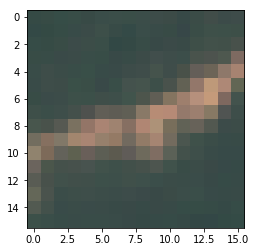

IMG 1229631 {5}


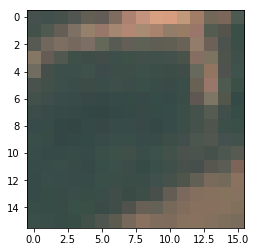

IMG 1229632 {5}


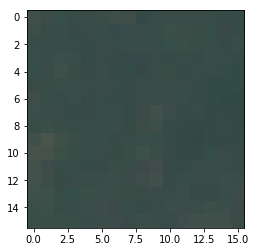

In [53]:
import random

idx = random.choice(idxs)
display(PATH_DATA, idx-1)
display(PATH_DATA, idx)
display(PATH_DATA, idx+1)

In [71]:
train_gen = generator(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen = generator(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)

In [72]:
print(train_batch_count, val_batch_count)

233728 58432


In [73]:
#get_category(PATH_DATA, train_idxs)

In [76]:
input_shape = (16,16,4)
dropout_rate = 0.5

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=input_shape))
model.add(Conv2D(4,(3,3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(4, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(23, activation='softmax'))

In [78]:
# optim = keras.optimizers.Adam(lr=0.001)
optim = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_gen, steps_per_epoch=100, epochs=10, verbose=1, validation_data=val_gen, nb_val_samples=100)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, validation_steps=100, epochs=10, validation_data=<generator..., steps_per_epoch=100)`
  


Epoch 1/10
100/100 [==============================] - 300s 3s/step - loss: 3.8118 - acc: 0.2375 - val_loss: 1.7062 - val_acc: 0.4550
Epoch 2/10
100/100 [==============================] - 288s 3s/step - loss: 1.8527 - acc: 0.3709 - val_loss: 1.5554 - val_acc: 0.4956
Epoch 3/10
100/100 [==============================] - 273s 3s/step - loss: 1.6868 - acc: 0.4213 - val_loss: 1.5237 - val_acc: 0.4725
Epoch 4/10
100/100 [==============================] - 271s 3s/step - loss: 1.6230 - acc: 0.4503 - val_loss: 1.4519 - val_acc: 0.4969
Epoch 5/10
100/100 [==============================] - 260s 3s/step - loss: 1.5177 - acc: 0.4841 - val_loss: 1.4648 - val_acc: 0.4891
Epoch 6/10
100/100 [==============================] - 262s 3s/step - loss: 1.4830 - acc: 0.4928 - val_loss: 1.3954 - val_acc: 0.5209
Epoch 7/10
100/100 [==============================] - 261s 3s/step - loss: 1.5250 - acc: 0.4725 - val_loss: 1.3711 - val_acc: 0.5325
Epoch 8/10
100/100 [==============================] - 264s 3s/step - 

In [79]:
import os 
def prediction_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = f['S2'][batch_idxs, :,:,:]
        yield np.array(X)

def build_h5_pred_file(pred, h5_output_path):
    if os.path.exists(h5_output_path):
        os.remove(h5_output_path)
    f = h5.File(h5_output_path, 'w')
    top_landcover_submit = f.create_dataset("TOP_LANDCOVER", (len(pred), 1), maxshape=(None, 1))
    top_landcover_submit[:, 0] = pred
    f.close()
    
    return 1

In [80]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction = model.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction))
build_h5_pred_file(np.argmax(prediction, axis = 1), PATH_SUBMIT)

241700
7554/7554 [==============================] - 29s 4ms/step
241700


1

In [81]:
def gt_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        Y = f['TOP_LANDCOVER'][batch_idxs, :]
        yield keras.utils.np_utils.to_categorical(np.array(Y), 23)

gt_gen = gt_generator(PATH_PREDICT_WITH_GT, BATCH_SIZE, pred_idx)
gt = []
for elem in gt_gen:
    gt.append(elem)
gt = np.vstack(gt)

In [82]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=7)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [83]:
def clean_confusion_matrix(confusion_matrix, classes):
    real_classes = []
    for c in range(len(classes)):
        if np.sum(confusion_matrix[:,c])+np.sum(confusion_matrix[c, :]) != 0:
            real_classes.append(c)
    real_confusion_matrix = np.empty((len(real_classes), len(real_classes)))  
    for c_index in range(len(real_classes)):
        real_confusion_matrix[c_index,:] = confusion_matrix[real_classes[c_index], real_classes]
    return real_confusion_matrix, real_classes

Normalized confusion matrix


<IPython.core.display.Javascript object>


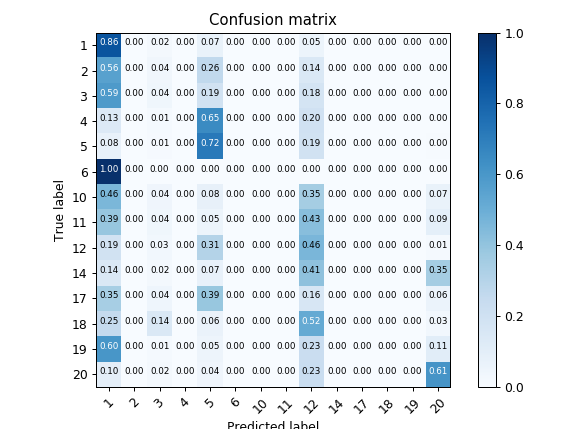

In [84]:
%matplotlib notebook
from sklearn.metrics import confusion_matrix
y_true = np.argmax(gt, axis=1)
y_pred = np.argmax(prediction, axis = 1)

real_cnf_matrix, real_classes = clean_confusion_matrix(confusion_matrix(y_true, y_pred, labels= range(23)), range(23))
plot_confusion_matrix(real_cnf_matrix, classes = real_classes, normalize=True)

In [85]:
somme = 0
for i in range (len(real_cnf_matrix)):    
    somme = somme + real_cnf_matrix[i,i] 
somme_t = sum(sum(real_cnf_matrix))
somme/somme_t

0.5226272238311956

In [86]:
model.save("incredible_florian.dqf")

In [87]:
ls


5tars-and-a-friend/      incredible_florian.dqf
Hackathon.ipynb          launch_verif_from_students_pred.py
Hackathon_Florian.ipynb  pred_eighties_from_half_1.h5
data/                    pred_eighties_from_half_1_AWESOMEGROUP.h5
eightieth.h5             pred_eighties_from_half_1_without_gt.h5
half.h5


In [ ]:
df2 = pd.DataFrame(y_pred, columns=['TOP_LANDCOVER'])
df2.to_csv(PATH_SUBMIT, index="ID")